## TOP 5 LEAGUES PLAYER SKILLS

Dataset: Habilidades y puntuaciones de los jugadores de las 5 grandes ligas, obtenido de Kaggle, que a su vez se consiguió del scrapping de datos de la web sofifa.com   
https://www.kaggle.com/datasets/maso0dahmed/football-players-data

Objetivo:
- Análisis en profundidad de puntuaciones y habilidades de los futbolistas.
- Clasificación de los jugadores en grupos dependiendo de sus habilidades y puntuaciones (clusterización).
- Modelo de recomendación que identifique el/los mejores reemplazos para un jugador concreto, según sus características y habilidades.
- Predicción del valor de mercado de los jugadores según sus habilidades.


In [316]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import warnings

 LECTURA DE DATASETS

In [317]:
df_skills = pd.read_csv('data/skills.csv')

In [318]:
df_skills.columns

Index(['Known As', 'Full name', 'Overall', 'Potential', 'Value(in Euro)',
       'Positions Played', 'Best Position', 'Nationality', 'Image Link', 'age',
       'Height(in cm)', 'Weight(in kg)', 'TotalStats', 'BaseStats',
       'Club name', 'Wage(in Euro)', 'Release Clause', 'Club Position',
       'Contract Until', 'Club Jersey Number', 'Joined On', 'On Loan',
       'Preferred Foot', 'Weak Foot Rating', 'Skill Moves',
       'International Reputation', 'National Team name',
       'National Team Image Link', 'National Team Position',
       'National Team Jersey Number', 'attacking_work_rate',
       'defensive_work_rate', 'Pace Total', 'Shooting Total', 'Passing Total',
       'Dribbling Total', 'Defending Total', 'Physicality Total', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'Freekick Accuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
       'Shot Powe

In [319]:
df_players = pd.read_csv('data/players_cleaned.csv')

Merge para obtener las formaciones de los equipos (aplicables a jugadores) y la liga en la que milita cada jugador. Es un merge de tipo "left", para quedarnos con todo nuestro dataframe original y unirle las variables que hemos descrito, con unión en la columna referente al nombre del equipo de cada dataset.

In [320]:
df_skills = pd.merge(df_skills, df_players[['team', 'formation', 'league']],
                    how='left',left_on='Club name', right_on='team')

df_skills.drop(columns='team', inplace=True)

df_skills

Known As           Full name  Overall  Potential  Value(in Euro)  \
0            L. Messi        Lionel Messi       91         91        54000000   
1          K. Benzema       Karim Benzema       91         91        64000000   
2      R. Lewandowski  Robert Lewandowski       91         91        84000000   
3        K. De Bruyne     Kevin De Bruyne       91         91       107500000   
4        K. De Bruyne     Kevin De Bruyne       91         91       107500000   
...               ...                 ...      ...        ...             ...   
94096      D. Collins      Darren Collins       47         56          110000   
94097    Yang Dejiang        Dejiang Yang       47         57           90000   
94098       L. Mullan         Liam Mullan       47         67          130000   
94099    D. McCallion    Daithí McCallion       47         61          100000   
94100        N. Rabha         Nabin Rabha       47         50           60000   

      Positions Played Best Position          Nationality  \
0                   RW           CAM            Argentina   
1                CF,ST            CF               France   
2                   ST            ST               Poland   
3               CM,CAM            CM              Belgium   
4               CM,CAM            CM              Belgium   
...                ...           ...                  ...   
94096            ST,RM           CAM  Republic of Ireland   
94097              CDM           CDM             China PR   
94098               CM            RM     Northern Ireland   
94099               CB            CB  Republic of Ireland   
94100               LB            LB                India   

                                             Image Link  age  ...  RM Rating  \
0      https://cdn.sofifa.net/players/158/023/23_60.png   35  ...         91   
1      https://cdn.sofifa.net/players/165/153/23_60.png   34  ...         89   
2      https://cdn.sofifa.net/players/188/545/23_60.png   33  ...         86   
3      https://cdn.sofifa.net/players/192/985/23_60.png   31  ...         91   
4      https://cdn.sofifa.net/players/192/985/23_60.png   31  ...         91   
...                                                 ...  ...  ...        ...   
94096  https://cdn.sofifa.net/players/243/725/23_60.png   21  ...         50   
94097  https://cdn.sofifa.net/players/261/933/23_60.png   17  ...         45   
94098  https://cdn.sofifa.net/players/267/823/23_60.png   18  ...         52   
94099  https://cdn.sofifa.net/players/267/824/23_60.png   17  ...         33   
94100  https://cdn.sofifa.net/players/261/424/23_60.png   25  ...         44   

       LWB Rating  CDM Rating  RWB Rating LB Rating  CB Rating  RB Rating  \
0              67          66          67        62         53         62   
1              67          67          67        63         58         63   
2              67          69          67        64         63         64   
3              82          82          82        78         72         78   
4              82          82          82        78         72         78   
...           ...         ...         ...       ...        ...        ...   
94096          41          38          41        40         36         40   
94097          47          48          47        49         49         49   
94098          46          44          46        46         42         46   
94099          44          42          44        47         49         47   
94100          46          43          46        47         47         47   

      GK Rating formation              league  
0            22       NaN                 NaN  
1            21       NaN                 NaN  
2            22       NaN                 NaN  
3            24     4-3-3  eng Premier League  
4            24     4-3-3  eng Premier League  
...         ...       ...                 ...  
94096        15       NaN                 NaN  
94097        15       NaN            

### LIMPIEZA Y CALIDAD

Primero vamos a filtrar las ligas de nuestro proyecto: 5 grandes ligas europeas (España, Italia, Inglaterra, Alemania y Francia) y vamos a hacer que las nuevas columnas (formation y league) aparezcan junto a la columna de nombre de equipo ('Club name')

In [321]:
top5_leagues = ['eng Premier League', 'de Bundesliga', 'fr Ligue 1', 'it Serie A', 'es La Liga']
df_skills_top5 = df_skills[df_skills['league'].isin(top5_leagues)]

clubs_to_add = [
    'Leeds', 'West Bromwich Albion', 'Spezia', 'Parma', 'Real Valladolid', 'Crotone', 
    'Benevento', 'Dijon', 'Schalke 04', 'AC Ajaccio', 'AJ Auxerre', 'ESTAC Troyes', 
    'US Cremonese', 'RCD Espanyol'
]

df_skills_clubs = df_skills[df_skills['Club name'].isin(clubs_to_add)]
df_skills = pd.concat([df_skills_top5, df_skills_clubs])
df_skills = df_skills.drop_duplicates()

df_skills

Known As          Full name  Overall  Potential  Value(in Euro)  \
3       K. De Bruyne    Kevin De Bruyne       91         91       107500000   
26         K. Mbappé      Kylian Mbappé       91         95       190500000   
53          M. Salah      Mohamed Salah       90         90       115500000   
82       T. Courtois   Thibaut Courtois       90         91        90000000   
109         M. Neuer       Manuel Neuer       90         90        13500000   
...              ...                ...      ...        ...             ...   
93667       A. Basit     Abdallah Basit       52         62          180000   
93721        T. Cann           Ted Cann       52         65          170000   
93735  D. Ciezkowski  Dorian Ciezkowski       51         58          100000   
93749   I. Lucatelli     Igor Lucatelli       51         62          110000   
93783       E. Corvi      Edoardo Corvi       51         58          100000   

      Positions Played Best Position Nationality  \
3               CM,CAM            CM     Belgium   
26               ST,LW            ST      France   
53                  RW            RW       Egypt   
82                  GK            GK     Belgium   
109                 GK            GK     Germany   
...                ...           ...         ...   
93667           CM,CDM            CM       Ghana   
93721               GK            GK     England   
93735               GK            GK      Poland   
93749               GK            GK       Italy   
93783               GK            GK       Italy   

                                             Image Link  age  ...  RM Rating  \
3      https://cdn.sofifa.net/players/192/985/23_60.png   31  ...         91   
26     https://cdn.sofifa.net/players/231/747/23_60.png   23  ...         92   
53     https://cdn.sofifa.net/players/209/331/23_60.png   30  ...         90   
82     https://cdn.sofifa.net/players/192/119/23_60.png   30  ...         34   
109    https://cdn.sofifa.net/players/167/495/23_60.png   36  ...         47   
...                                                 ...  ...  ...        ...   
93667  https://cdn.sofifa.net/players/256/280/23_60.png   22  ...         53   
93721  https://cdn.sofifa.net/players/263/907/23_60.png   21  ...         24   
93735  https://cdn.sofifa.net/players/268/636/23_60.png   21  ...         20   
93749  https://cdn.sofifa.net/players/271/377/23_60.png   18  ...         20   
93783  https://cdn.sofifa.net/players/271/385/23_60.png   21  ...         23   

       LWB Rating  CDM Rating  RWB Rating LB Rating  CB Rating  RB Rating  \
3              82          82          82        78         72         78   
26             70          66          70        66         57         66   
53             74          71          74        70         61         70   
82             32          34          32        32         32         32   
109            39          46          39        38         37         38   
...           ...         ...         ...       ...        ...        ...   
93667          53          54          53        52         51         52   
93721          22          24          22        22         22         22   
93735          19          21          19        19         21         19   
93749          19          22          19        19         23         19   
93783          20          25          20        20         23         20   

      GK Rating formation              league  
3            24     4-3-3  eng Premier League  
26           21     4-3-3          fr Ligue 1  
53           25     4-3-3  eng Premier League  
82           90     4-3-3          es La Liga  
109          90   4-2-3-1       de Bundesliga  
...         ...       ...                 ...  
93667        16       NaN                 NaN  
93721        53       NaN                 NaN  
93735        52       NaN                 NaN  
93749        52       NaN                 NaN  
93783        52       Na

In [322]:
cols = list(df_skills.columns)
formation_index = cols.index('Club name')

columns_to_move = ['formation', 'league']

for col in columns_to_move:
    cols.remove(col)

for i, col in enumerate(columns_to_move):
    cols.insert(formation_index + 1 + i, col)

df_skills = df_skills[cols]

In [323]:
df_skills.head()

Known As         Full name  Overall  Potential  Value(in Euro)  \
3    K. De Bruyne   Kevin De Bruyne       91         91       107500000   
26      K. Mbappé     Kylian Mbappé       91         95       190500000   
53       M. Salah     Mohamed Salah       90         90       115500000   
82    T. Courtois  Thibaut Courtois       90         91        90000000   
109      M. Neuer      Manuel Neuer       90         90        13500000   

    Positions Played Best Position Nationality  \
3             CM,CAM            CM     Belgium   
26             ST,LW            ST      France   
53                RW            RW       Egypt   
82                GK            GK     Belgium   
109               GK            GK     Germany   

                                           Image Link  age  ...  LM Rating  \
3    https://cdn.sofifa.net/players/192/985/23_60.png   31  ...         91   
26   https://cdn.sofifa.net/players/231/747/23_60.png   23  ...         92   
53   https://cdn.sofifa.net/players/209/331/23_60.png   30  ...         90   
82   https://cdn.sofifa.net/players/192/119/23_60.png   30  ...         34   
109  https://cdn.sofifa.net/players/167/495/23_60.png   36  ...         47   

     CM Rating  RM Rating  LWB Rating CDM Rating RWB Rating LB Rating  \
3           91         91          82         82         82        78   
26          84         92          70         66         70        66   
53          85         90          74         71         74        70   
82          35         34          32         34         32        32   
109         53         47          39         46         39        38   

     CB Rating  RB Rating GK Rating  
3           72         78        24  
26          57         66        21  
53          61         70        25  
82          32         32        90  
109         37         38        90  

[5 rows x 91 columns]

Comprobaciones:

In [324]:
df_skills.shape

(3098, 91)

In [325]:
df_skills.columns

Index(['Known As', 'Full name', 'Overall', 'Potential', 'Value(in Euro)',
       'Positions Played', 'Best Position', 'Nationality', 'Image Link', 'age',
       'Height(in cm)', 'Weight(in kg)', 'TotalStats', 'BaseStats',
       'Club name', 'formation', 'league', 'Wage(in Euro)', 'Release Clause',
       'Club Position', 'Contract Until', 'Club Jersey Number', 'Joined On',
       'On Loan', 'Preferred Foot', 'Weak Foot Rating', 'Skill Moves',
       'International Reputation', 'National Team name',
       'National Team Image Link', 'National Team Position',
       'National Team Jersey Number', 'attacking_work_rate',
       'defensive_work_rate', 'Pace Total', 'Shooting Total', 'Passing Total',
       'Dribbling Total', 'Defending Total', 'Physicality Total', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'Freekick Accuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Bala

Eliminamos columnas que no necesitamos o que son redundantes y renombramos otras para normalización de nuestro proyecto. Hay bastantes columnas que no nos son necesarias, sobre todo referentes a datos con selecciones, imágenes, peso o cláusulas de rescisión. Otras son redundantes, como freekick que va muy asociada al tiro en general, agility a speed, sprint a pace_total y jumping a heading

In [326]:
df_skills = df_skills.drop(['Known As', 'Club Position', 'Best Position', 'Image Link', 'Weight(in kg)',
    'TotalStats', 'BaseStats', 'Release Clause', 'Club Jersey Number', 'Joined On', 'On Loan', 'International Reputation',
    'National Team Image Link', 'National Team name', 'National Team Jersey Number','ST Rating','LW Rating',
    'LF Rating', 'CF Rating', 'RF Rating', 'RW Rating','CAM Rating', 'LM Rating', 'CM Rating','RM Rating',
    'LWB Rating','CDM Rating', 'RWB Rating', 'LB Rating', 'CB Rating', 'RB Rating','GK Rating',
    'Curve', 'Freekick Accuracy', 'Jumping', 'Stamina', 'Agility', 'Reactions', 'Contract Until',
    'National Team Position'], axis=1)

In [327]:
df_skills = df_skills.rename(columns={'Full name': 'name', 'Club name': 'Team', 'Positions Played': 'Position',
    'Value(in Euro)': 'value_million_euro', 'Wage(in Euro)': 'Wage Million Euro', 'BallControl': 'Ball Control',
    'LongPassing': 'Long Passing','Height(in cm)': 'Height', ' GoalkeeperKicking': 'Goalkeeper Kicking', 
    'Composure': 'Mentality'})

Normalizamos para cumplir con PEP8 y mantener un formato para todo el proyecto

In [328]:
df_skills.columns = df_skills.columns.str.replace(' ', '_').str.lower()
df_skills.columns = df_skills.columns.str.replace('(in_euro)', '_in_euro')

df_skills.columns

Index(['name', 'overall', 'potential', 'value_million_euro', 'position',
       'nationality', 'age', 'height', 'team', 'formation', 'league',
       'wage_million_euro', 'preferred_foot', 'weak_foot_rating',
       'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
       'defending_total', 'physicality_total', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'balance', 'shot_power', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'mentality',
       'marking', 'standing_tackle', 'sliding_tackle', 'goalkeeper_diving',
       'goalkeeper_handling', 'goalkeeper_kicking', 'goalkeeper_positioning',
       'goalkeeper_reflexes'],
      dtype='object')

In [329]:
df_skills.dtypes

name                      object
overall                    int64
potential                  int64
value_million_euro         int64
position                  object
nationality               object
age                        int64
height                     int64
team                      object
formation                 object
league                    object
wage_million_euro          int64
preferred_foot            object
weak_foot_rating           int64
skill_moves                int64
attacking_work_rate       object
defensive_work_rate       object
pace_total                 int64
shooting_total             int64
passing_total              int64
dribbling_total            int64
defending_total            int64
physicality_total          int64
crossing                   int64
finishing                  int64
heading_accuracy           int64
short_passing              int64
volleys                    int64
dribbling                  int64
long_passing               int64
ball_contr

### __Breve análisis de las variables__

Variables cualitativas nominales (string):

- name: Nombre del jugador.
- position: Posición en la que juega el futbolista. 
- nationality: País del jugador.
- team: Equipo en el que juega el jugador.
- formation:  tipo de alineación del equipo del jugador (aunque sea representado con números es como si fuese una 'etiqueta') 
- league: Liga en la que juega el futbolista 
- preferred_foot: pie dominante del jugador (derecho/izquierdo)
- attacking_work_rate: clasificación del aporte del jugador al equipo en ataque (bajo/medio/alto)
- defensive_work_rate: clasificación del aporte del jugador al equipo en defensa (bajo/medio/alto)

Variables cuantitativas discretas (int): 

- age: edad de los jugadores (en años).
- overall: puntuación total del jugador sobre 100 puntos.
- potential: puntuación de potencial del jugador sobre 100 puntos
- height: altura del jugador en centímetros
- weak_foot_rating: valoración de la habilidad del jugador con su pie 'débil' o menos dominante.
- pace_total: puntuación del ritmo total del jugador sobre 100 puntos.
- shooting_total: puntuación del ritmo total del jugador sobre 100 puntos.
- passing_total: puntuación total de la habilidad de pase del jugador sobre 100 puntos.
- dribbling_total: puntuación total del regate del jugador sobre 100 puntos.
- defending_total: puntuación total del nivel defensivo del jugador sobre 100 puntos.
- physicality_total: puntuación total de la condición física del jugador sobre 100 puntos.
- finishing: puntuación de la finalización de jugadas del jugador sobre 100 puntos.
- heading_accuracy': puntuación de la precisión de cabeceo de balón del jugador sobre 100 puntos.
- passing': puntuación de la habilidad en pases del jugador sobre 100 puntos.
- ball_control: puntuación de la habilidad de control de balón del jugador sobre 100 puntos.
- speed: puntuación de la velocidad corriendo del jugador sobre 100 puntos.
- balance: puntuación del balance en el juego del jugador sobre 100 puntos.
- shot_power: puntuación de la potencia de golpeo del balón del jugador sobre 100 puntos.
- strength: puntuación de la fuerza del jugador sobre 100 puntos. 
- long_shots: puntuación de los disparos lejanos del jugador sobre 100 puntos.
- aggression: puntuación de la agresividad del jugador sobre 100 puntos.
- positioning: puntuación del posicionamiento táctico del jugador sobre 100 puntos.
- vision: puntuación de la visión de juego del jugador sobre 100 puntos.
- penalties: puntuación de la habilidad tirando penaltis del jugador sobre 100 puntos.
- goalkeeper_diving: puntuación en el juego de suelo del portero sobre 100 puntos.
- goalkeeper_handling: puntuación en el juego de manos del portero sobre 100 puntos.
- goalkeeper_kicking: puntuación de golpeo de balón del portero sobre 100 puntos.
- goalkeeper_positioning: puntuación del posicionamiento del portero sobre 100 puntos.
- goalkeeper_reflexes: puntuación de los reflejos del portero sobre 100 puntos.

Variables cuantitativas continuas (float): 

- value_million_euro: valor de mercado del jugador en millones de euros.
- wage_million_euro: salario del jugador en millones de euros.

Queremos mostrar el precio de los jugadores en millones y el salario, que aparece como semanal, lo vamos a convertir a anual

In [330]:
df_skills['value_million_euro'] = df_skills['value_million_euro'] / 1000000
df_skills.head()

name  overall  potential  value_million_euro position  \
3     Kevin De Bruyne       91         91               107.5   CM,CAM   
26      Kylian Mbappé       91         95               190.5    ST,LW   
53      Mohamed Salah       90         90               115.5       RW   
82   Thibaut Courtois       90         91                90.0       GK   
109      Manuel Neuer       90         90                13.5       GK   

    nationality  age  height                 team formation  ... penalties  \
3       Belgium   31     181      Manchester City     4-3-3  ...        83   
26       France   23     182  Paris Saint-Germain     4-3-3  ...        80   
53        Egypt   30     175            Liverpool     4-3-3  ...        86   
82      Belgium   30     199          Real Madrid     4-3-3  ...        27   
109     Germany   36     193        Bayern Munich   4-2-3-1  ...        47   

     mentality marking  standing_tackle  sliding_tackle goalkeeper_diving  \
3           89      68               65              53                15   
26          88      26               34              32                13   
53          92      38               43              41                14   
82          66      20               18              16                84   
109         70      17               10              11                87   

    goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
3                    13                   5                      10   
26                    5                   7                      11   
53                   14                   9                      11   
82                   89                  75                      89   
109                  88                  91                      91   

     goalkeeper_reflexes  
3                     13  
26                     6  
53                    14  
82                    90  
109                   88  

[5 rows x 51 columns]

In [331]:
df_skills['wage_million_euro'] = df_skills['wage_million_euro'] * 52 / 1000000
df_skills

name  overall  potential  value_million_euro position  \
3        Kevin De Bruyne       91         91              107.50   CM,CAM   
26         Kylian Mbappé       91         95              190.50    ST,LW   
53         Mohamed Salah       90         90              115.50       RW   
82      Thibaut Courtois       90         91               90.00       GK   
109         Manuel Neuer       90         90               13.50       GK   
...                  ...      ...        ...                 ...      ...   
93667     Abdallah Basit       52         62                0.18   CM,CDM   
93721           Ted Cann       52         65                0.17       GK   
93735  Dorian Ciezkowski       51         58                0.10       GK   
93749     Igor Lucatelli       51         62                0.11       GK   
93783      Edoardo Corvi       51         58                0.10       GK   

      nationality  age  height                  team formation  ... penalties  \
3         Belgium   31     181       Manchester City     4-3-3  ...        83   
26         France   23     182   Paris Saint-Germain     4-3-3  ...        80   
53          Egypt   30     175             Liverpool     4-3-3  ...        86   
82        Belgium   30     199           Real Madrid     4-3-3  ...        27   
109       Germany   36     193         Bayern Munich   4-2-3-1  ...        47   
...           ...  ...     ...                   ...       ...  ...       ...   
93667       Ghana   22     180             Benevento       NaN  ...        40   
93721     England   21     188  West Bromwich Albion       NaN  ...        14   
93735      Poland   21     191          US Cremonese       NaN  ...        16   
93749       Italy   18     197             Benevento       NaN  ...        13   
93783       Italy   21     183                 Parma       NaN  ...        12   

       mentality marking  standing_tackle  sliding_tackle goalkeeper_diving  \
3             89      68               65              53                15   
26            88      26               34              32                13   
53            92      38               43              41                14   
82            66      20               18              16                84   
109           70      17               10              11                87   
...          ...     ...              ...             ...               ...   
93667         50      37               50              47                 8   
93721         38       9               14              12                50   
93735         30       6               12              14                48   
93749         38       9               14              11                58   
93783         25       7               17              13                58   

      goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
3                      13                   5                      10   
26                      5                   7                      11   
53                     14                   9                      11   
82                     89                  75                      89   
109                    88                  91                      91   
...                   ...                 ...                     ...   
93667                   6                   6                      13   
93721                  53                  52                      46   
93735                  55                  49                      47   
93749                  45                  47                      46   
93783                  56                  50                      46   

       goalkeeper_reflexes  
3                       13  
26                       6  
53                      14  
82                      90  
109                     88  
...                    ...  
93667                   11  
93721                   58  
93735                   55  
93749 

Vamos a reducir las posiciones a valores más genéricos y renombrarlos para que sean más intuitivos

In [332]:
position_counts = df_skills['position'].value_counts()
position_counts

position
CB           437
GK           364
ST           271
CDM,CM       177
CM,CDM       139
            ... 
CAM,RW,LW      1
CM,CB          1
RW,CF,LW       1
CAM,CM,ST      1
CF,ST,RM       1
Name: count, Length: 337, dtype: int64

Primero renombramos las posiciones para entenderlos mejor y normalizar nuestro proyecto

In [333]:
positions = {
    'GK': 'Goalkeeper','CB': 'Defender','LB': 'Full Back','RB': 'Full Back','LWB': 'Full Back','RWB': 'Full Back',
    'CM': 'Midfielder','CDM': 'Midfielder','CAM': 'Midfielder','LM': 'Midfielder','RM': 'Midfielder',
    'ST': 'Forward','CF': 'Forward','LW': 'Winger','RW': 'Winger'
}

df_skills['position'] = df_skills['position'].replace(positions)

Las posiciones estaban muy amplificadas, pero realmente nos vale dividirlas en 6 grandes grupos: porteros, defensas, laterales, centrocampistas, extremos y delanteros.

In [334]:
df_skills['position'].unique()

array(['CM,CAM', 'ST,LW', 'Winger', 'Goalkeeper', 'Defender', 'Forward',
       'LW,LM', 'Midfielder', 'LM,CF', 'CDM,RB', 'CDM,CM', 'CAM,CM',
       'LB,RB', 'CDM,CB', 'CAM,CF', 'Full Back', 'CM,CDM', 'LW,RW',
       'RW,RM', 'CF,CAM', 'CF,CAM,ST', 'CB,RB', 'CM,CDM,LM', 'LM,LWB',
       'LW,CF,CAM', 'CF,LW', 'CAM,CF,RM', 'CB,LB', 'CAM,LW', 'RM,RW',
       'LW,LM,CAM', 'CB,RB,RW', 'RM,CAM,CDM', 'LM,CAM', 'RB,RM', 'CM,LM',
       'RM,LM,LW', 'CM,RW', 'RWB,RB', 'CAM,CF,ST', 'CF,ST', 'RB,RWB',
       'LB,LM', 'CAM,RW', 'LW,RW,LM', 'CM,RM,RB', 'LWB,LM', 'RW,LW',
       'ST,RW', 'CM,RM,CDM', 'ST,RM,CF', 'CM,LM,RM', 'ST,CF,RW', 'RW,CAM',
       'CAM,RM', 'ST,LM,CF', 'CM,CB,CDM', 'CAM,CM,RM', 'RM,LM', 'LM,ST',
       'CAM,CM,CF', 'RWB,RM', 'LWB,LB', 'CAM,LW,ST', 'CB,RWB,RB',
       'CAM,LW,CM', 'CM,CAM,CDM', 'CM,CDM,CB', 'ST,CF,CAM', 'LW,CF',
       'CF,CM', 'LW,ST', 'LWB,LM,LB', 'CF,RW,RM', 'LB,CB,LM', 'CB,LB,CDM',
       'ST,CAM,LM', 'RW,CF', 'CM,LM,CAM', 'RW,CAM,LW', 'CAM,ST,CM',
       'CM

In [335]:
df_skills['position'] = df_skills['position'].apply(lambda x: x.split(',')[0])
df_skills['position'].unique()

array(['CM', 'ST', 'Winger', 'Goalkeeper', 'Defender', 'Forward', 'LW',
       'Midfielder', 'LM', 'CDM', 'CAM', 'LB', 'Full Back', 'RW', 'CF',
       'CB', 'RM', 'RB', 'RWB', 'LWB'], dtype=object)

In [336]:
df_skills['position'] = df_skills['position'].replace(positions)
df_skills['position'].unique()
df_skills['position'].value_counts()

position
Midfielder    1103
Defender       562
Full Back      479
Forward        435
Goalkeeper     364
Winger         155
Name: count, dtype: int64

Para los jugadores distintos a portero (jugadores de campo) convertimos los parámetros de portero a 0 y para los porteros convertimos las variables que no son de portero a 0, pero conservamos variables importantes también para los porteros, como: mentalidad, fuerza, potencia de disparo, posicionamiento,etc

In [337]:
df_skills.loc[df_skills['position'] != 'Goalkeeper', ['goalkeeper_diving', 'goalkeeper_handling', 
                                         'goalkeeper_kicking', 'goalkeeper_positioning', 
                                         'goalkeeper_reflexes']] = 0

In [338]:
df_skills.loc[df_skills['position'] == 'Goalkeeper', ['skill_moves','pace_total', 'dribbling_total',
       'crossing', 'short_passing', 'volleys', 'dribbling','long_passing', 'ball_control', 'acceleration',
       'sprint_speed','long_shots','interceptions','penalties','marking','standing_tackle', 'sliding_tackle',
       'defending_total', 'finishing', 'heading_accuracy', 'aggression', 'positioning']] = 0

In [339]:
df_skills[df_skills['position'] == 'Goalkeeper'].head()

name  overall  potential  value_million_euro  \
82            Thibaut Courtois       90         91                90.0   
109               Manuel Neuer       90         90                13.5   
250                  Jan Oblak       89         91                85.5   
305  Ederson Santana de Moraes       89         91                88.0   
358      Alisson Ramses Becker       89         90                79.0   

       position nationality  age  height             team formation  ...  \
82   Goalkeeper     Belgium   30     199      Real Madrid     4-3-3  ...   
109  Goalkeeper     Germany   36     193    Bayern Munich   4-2-3-1  ...   
250  Goalkeeper    Slovenia   29     188  Atletico Madrid     5-3-2  ...   
305  Goalkeeper      Brazil   28     188  Manchester City     4-3-3  ...   
358  Goalkeeper      Brazil   29     191        Liverpool     4-3-3  ...   

    penalties  mentality marking  standing_tackle  sliding_tackle  \
82          0         66       0                0               0   
109         0         70       0                0               0   
250         0         68       0                0               0   
305         0         70       0                0               0   
358         0         68       0                0               0   

    goalkeeper_diving goalkeeper_handling  goalkeeper_kicking  \
82                 84                  89                  75   
109                87                  88                  91   
250                86                  90                  78   
305                87                  82                  93   
358                86                  85                  85   

     goalkeeper_positioning  goalkeeper_reflexes  
82                       89                   90  
109                      91                   88  
250                      87                   89  
305                      88                   88  
358                      90                   89  

[5 rows x 51 columns]

### DUPLICADOS

In [340]:
duplicados = df_skills.duplicated().any()

print("Duplicados en el dataset:", duplicados)

df_skills.duplicated().sum()

Duplicados en el dataset: False


np.int64(0)

Tenemos un jugador duplicado porque parece que ha estado en dos equipos en la misma temporada, por lo que nos quedamos solo con uno. En este caso con el segundo equipo, que es donde milita actualmente

In [341]:
name_duplicados = df_skills[df_skills['name'].duplicated(keep=False)]
name_duplicados


name  overall  potential  value_million_euro    position  \
28170  Jesper Lindstrøm       75         84                12.5  Midfielder   
32525  Jesper Lindstrøm       75         84                12.5  Midfielder   

      nationality  age  height                 team formation  ... penalties  \
28170     Denmark   22     182               Napoli     4-3-3  ...        48   
32525     Denmark   22     182  Eintracht Frankfurt   3-4-2-1  ...        48   

       mentality marking  standing_tackle  sliding_tackle goalkeeper_diving  \
28170         71      46               57              49                 0   
32525         71      46               57              49                 0   

      goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
28170                   0                   0                       0   
32525                   0                   0                       0   

       goalkeeper_reflexes  
28170                    0  
32525                    0  

[2 rows x 51 columns]

In [342]:
df_skills = df_skills.drop_duplicates(subset='name', keep='first')

In [343]:
df_skills.drop_duplicates(inplace=True)

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\2348450637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills.drop_duplicates(inplace=True)


In [344]:
df_skills.duplicated().sum()

np.int64(0)

Comprobamos que no haya caracteres especiales en los registros, que más tarde se pudieran considerar como valores nulos

In [345]:
for col in df_skills.select_dtypes(include=['object']).columns:
    print(col)
    print(df_skills[col].unique())

name
['Kevin De Bruyne' 'Kylian Mbappé' 'Mohamed Salah' ... 'Dorian Ciezkowski'
 'Igor Lucatelli' 'Edoardo Corvi']
position
['Midfielder' 'Forward' 'Winger' 'Goalkeeper' 'Defender' 'Full Back']
nationality
['Belgium' 'France' 'Egypt' 'Germany' 'Netherlands' 'England'
 'Korea Republic' 'Brazil' 'Slovenia' 'Senegal' 'Portugal' 'Norway'
 'Italy' 'Costa Rica' 'Croatia' 'Spain' 'Scotland' 'Austria' 'Algeria'
 'Argentina' 'Poland' 'Slovakia' 'Serbia' 'Gabon' 'Czech Republic'
 'Hungary' 'Switzerland' 'Ghana' 'Morocco' 'Turkey' 'Montenegro'
 'Cameroon' 'Bosnia and Herzegovina' 'Colombia' 'Uruguay' 'Canada'
 'Nigeria' 'Denmark' 'Finland' "Côte d'Ivoire" 'Ukraine' 'Mexico'
 'United States' 'Central African Republic' 'Mali' 'Burkina Faso' 'Sweden'
 'Armenia' 'Guinea' 'Japan' 'Jamaica' 'Kosovo' 'Chile' 'Iran' 'Ecuador'
 'Russia' 'Tunisia' 'Mozambique' 'Peru' 'Togo' 'Congo DR' 'Albania'
 'Wales' 'Georgia' 'North Macedonia' 'Greece' 'Paraguay'
 'Republic of Ireland' 'Gambia' 'Venezuela' 'Romania' 'N

NULOS

In [346]:
df_skills.isnull().sum()

name                        0
overall                     0
potential                   0
value_million_euro          0
position                    0
nationality                 0
age                         0
height                      0
team                        0
formation                 371
league                    371
wage_million_euro           0
preferred_foot              0
weak_foot_rating            0
skill_moves                 0
attacking_work_rate         0
defensive_work_rate         0
pace_total                  0
shooting_total              0
passing_total               0
dribbling_total             0
defending_total             0
physicality_total           0
crossing                    0
finishing                   0
heading_accuracy            0
short_passing               0
volleys                     0
dribbling                   0
long_passing                0
ball_control                0
acceleration                0
sprint_speed                0
balance   

In [347]:
nulos_league = df_skills[df_skills['league'].isnull()]
nulos_league.head()

name  overall  potential  value_million_euro  \
5789          Sergi Darder Moll       82         82                30.5   
8648            Luis Sinisterra       80         86                33.5   
10269  José Luis Sanmartín Mato       80         80                17.0   
13153      Sergio Asenjo Andrés       79         79                 5.5   
14918         Javier Puado Díaz       78         83                21.0   

         position nationality  age  height             team formation  ...  \
5789   Midfielder       Spain   28     180     RCD Espanyol       NaN  ...   
8648       Winger    Colombia   23     172            Leeds       NaN  ...   
10269     Forward       Spain   32     192     RCD Espanyol       NaN  ...   
13153  Goalkeeper       Spain   33     189  Real Valladolid       NaN  ...   
14918  Midfielder       Spain   24     177     RCD Espanyol       NaN  ...   

      penalties  mentality marking  standing_tackle  sliding_tackle  \
5789         60         85      76               77              75   
8648         55         77      56               48              47   
10269        87         68      23               27              20   
13153         0         64       0                0               0   
14918        74         75      52               46              45   

      goalkeeper_diving goalkeeper_handling  goalkeeper_kicking  \
5789                  0                   0                   0   
8648                  0                   0                   0   
10269                 0                   0                   0   
13153                80                  77                  78   
14918                 0                   0                   0   

       goalkeeper_positioning  goalkeeper_reflexes  
5789                        0                    0  
8648                        0                    0  
10269                       0                    0  
13153                      77                   78  
14918                       0                    0  

[5 rows x 51 columns]

Al tener nulos en 'formation' y 'league', que proceden del merge con otro dataset, vemos que faltan varios equipos con estos resultados. En realidad no es que sean 371 jugadores con nulos como tal, sino que son equipos completos, por lo que corresponde a unos 12 equipos (resultado de bajar o subir a primera división justo esa temporada), asi que vamos a introducirlo manualmente.

In [348]:
df_skills.loc[df_skills['team'] == 'RCD Espanyol', 'formation'] = '4-2-3-1'
df_skills.loc[df_skills['team'] == 'RCD Espanyol', 'league'] = 'es La Liga'
df_skills.loc[df_skills['team'] == 'Leeds', 'formation'] = '4-2-3-1'
df_skills.loc[df_skills['team'] == 'Leeds', 'league'] = 'eng Premier League'
df_skills.loc[df_skills['team'] == 'Real Valladolid', 'formation'] = '4-3-3'
df_skills.loc[df_skills['team'] == 'Real Valladolid', 'league'] = 'es La Liga'
df_skills.loc[df_skills['team'] == 'Parma', 'formation'] = '4-3-3'
df_skills.loc[df_skills['team'] == 'Parma', 'league'] = 'it Serie A'
df_skills.loc[df_skills['team'] == 'US Cremonese', 'formation'] = '3-4-3'
df_skills.loc[df_skills['team'] == 'US Cremonese', 'league'] = 'it Serie A'
df_skills.loc[df_skills['team'] == 'Schalke 04', 'formation'] = '4-2-3-1'
df_skills.loc[df_skills['team'] == 'Schalke 04', 'league'] = 'de Bundesliga'
df_skills.loc[df_skills['team'] == 'Spezia', 'formation'] = '3-4-3'
df_skills.loc[df_skills['team'] == 'Spezia', 'league'] = 'it Serie A'
df_skills.loc[df_skills['team'] == 'ESTAC Troyes', 'formation'] = '4-4-2'
df_skills.loc[df_skills['team'] == 'ESTAC Troyes', 'league'] = 'fr Ligue 1'
df_skills.loc[df_skills['team'] == 'AJ Auxerre', 'formation'] = '3-4-3'
df_skills.loc[df_skills['team'] == 'AJ Auxerre', 'league'] = 'fr Ligue 1'
df_skills.loc[df_skills['team'] == 'AC Ajaccio', 'formation'] = '4-4-2'
df_skills.loc[df_skills['team'] == 'AC Ajaccio', 'league'] = 'fr Ligue 1'
df_skills.loc[df_skills['team'] == 'West Bromwich Albion', 'formation'] = '4-4-2'
df_skills.loc[df_skills['team'] == 'West Bromwich Albion', 'league'] = 'eng Premier League'
df_skills.loc[df_skills['team'] == 'Benevento', 'formation'] = '3-4-3'
df_skills.loc[df_skills['team'] == 'Benevento', 'league'] = 'it Serie A'
df_skills.loc[df_skills['team'] == 'Dijon', 'formation'] = '4-4-2'
df_skills.loc[df_skills['team'] == 'Dijon', 'league'] = 'fr Ligue 1'


In [349]:
df_skills.isnull().sum().any()

np.False_

____
OUTLIERS : procedemos a analizar el límite superior e inferior para considerar si son atípicos y vemos cuantos hay para cada variable

In [350]:
columnas_outliers = ['overall', 'potential', 'value_million_euro', 'position', 
                    'nationality', 'age', 'height', 'team', 'wage_million_euro']

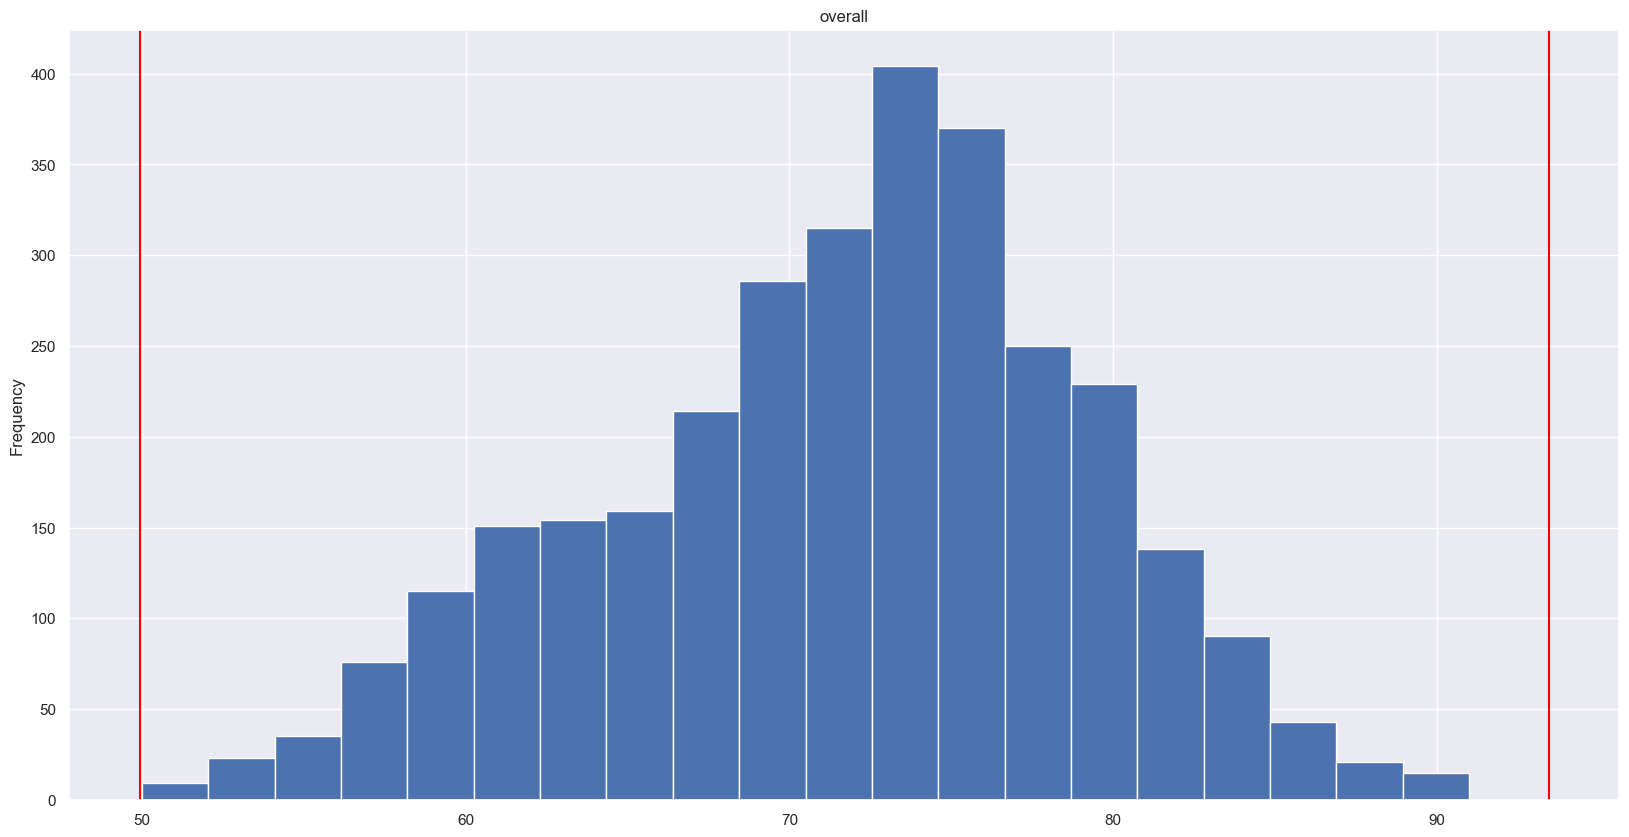

Variable: overall
Umbral Superior: 93.46250378582371
Umbral Inferior: 49.92851978537421
Total de Outliers: 0



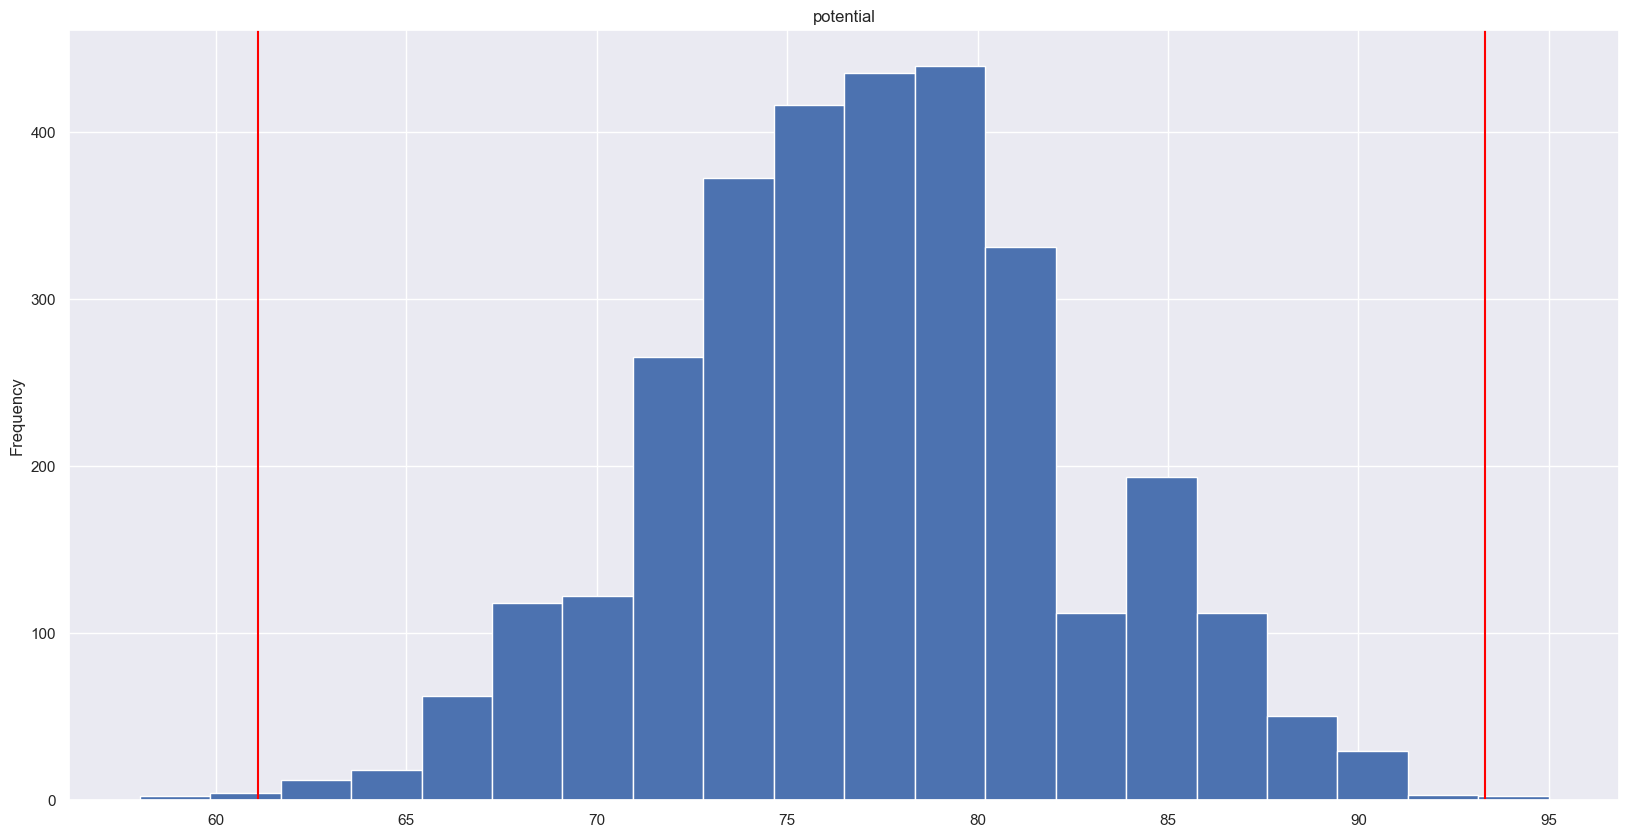

Variable: potential
Umbral Superior: 93.32684169801895
Umbral Inferior: 61.0955025060495
Total de Outliers: 8



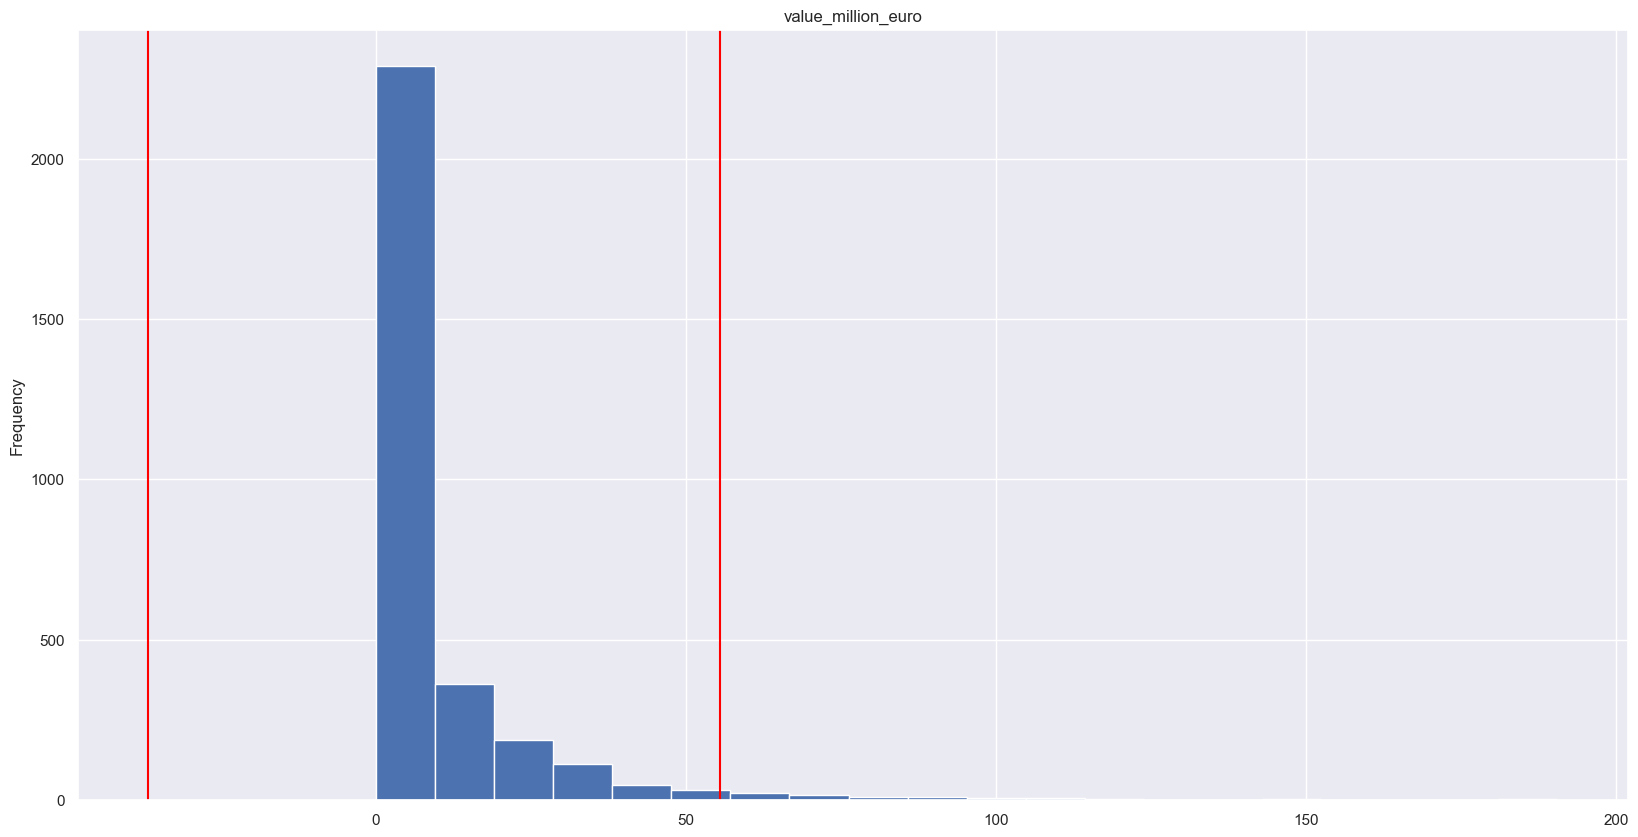

Variable: value_million_euro
Umbral Superior: 55.533613719738014
Umbral Inferior: -36.73802445076805
Total de Outliers: 74



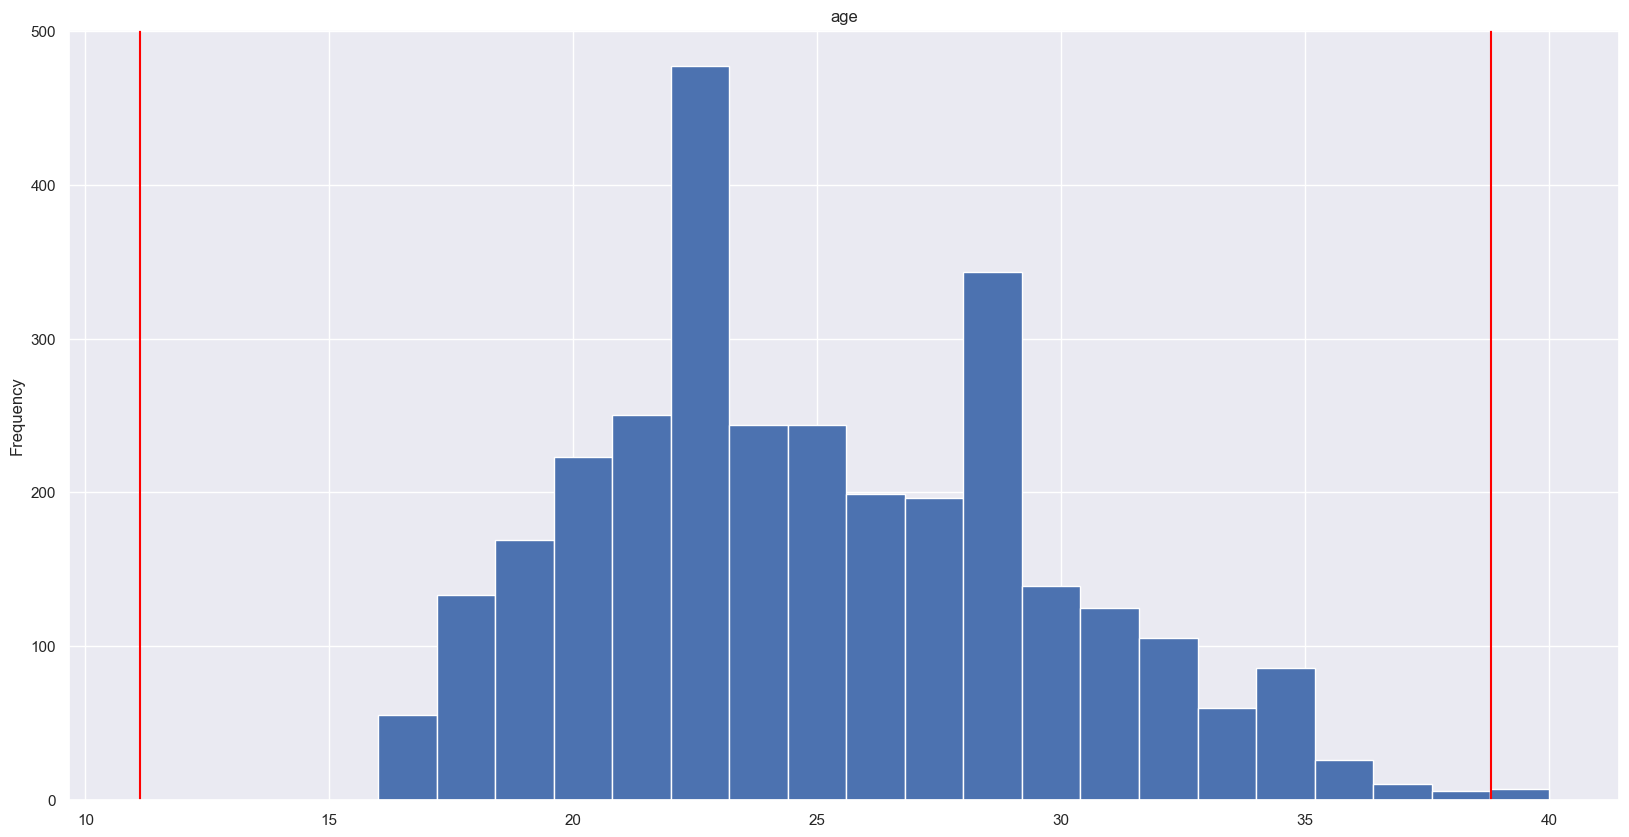

Variable: age
Umbral Superior: 38.81179573348648
Umbral Inferior: 11.113938848366924
Total de Outliers: 7



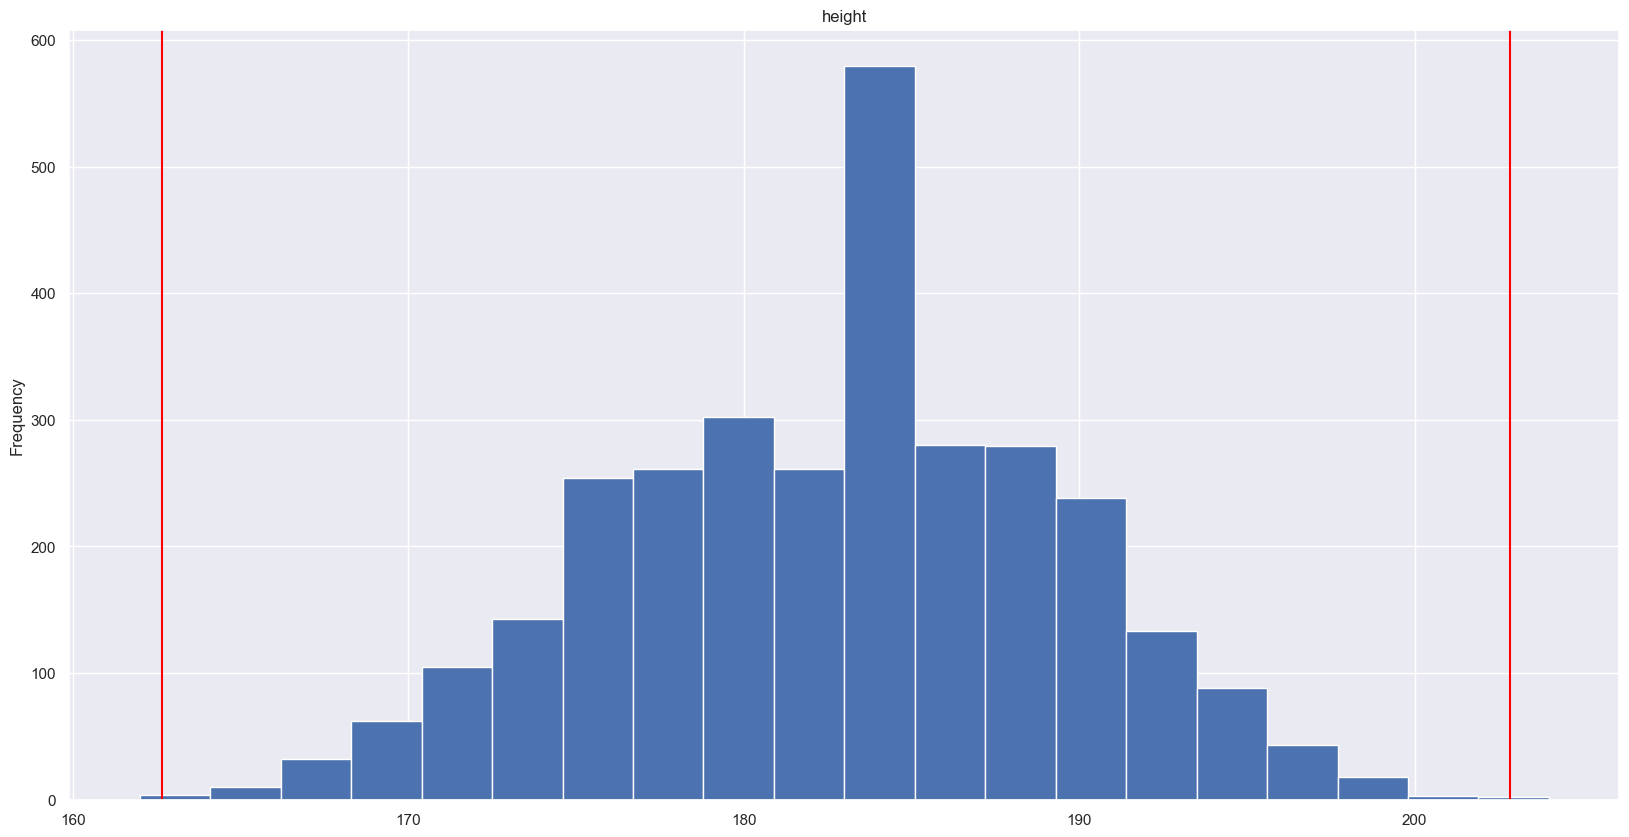

Variable: height
Umbral Superior: 202.85245990052675
Umbral Inferior: 162.65157626350293
Total de Outliers: 2



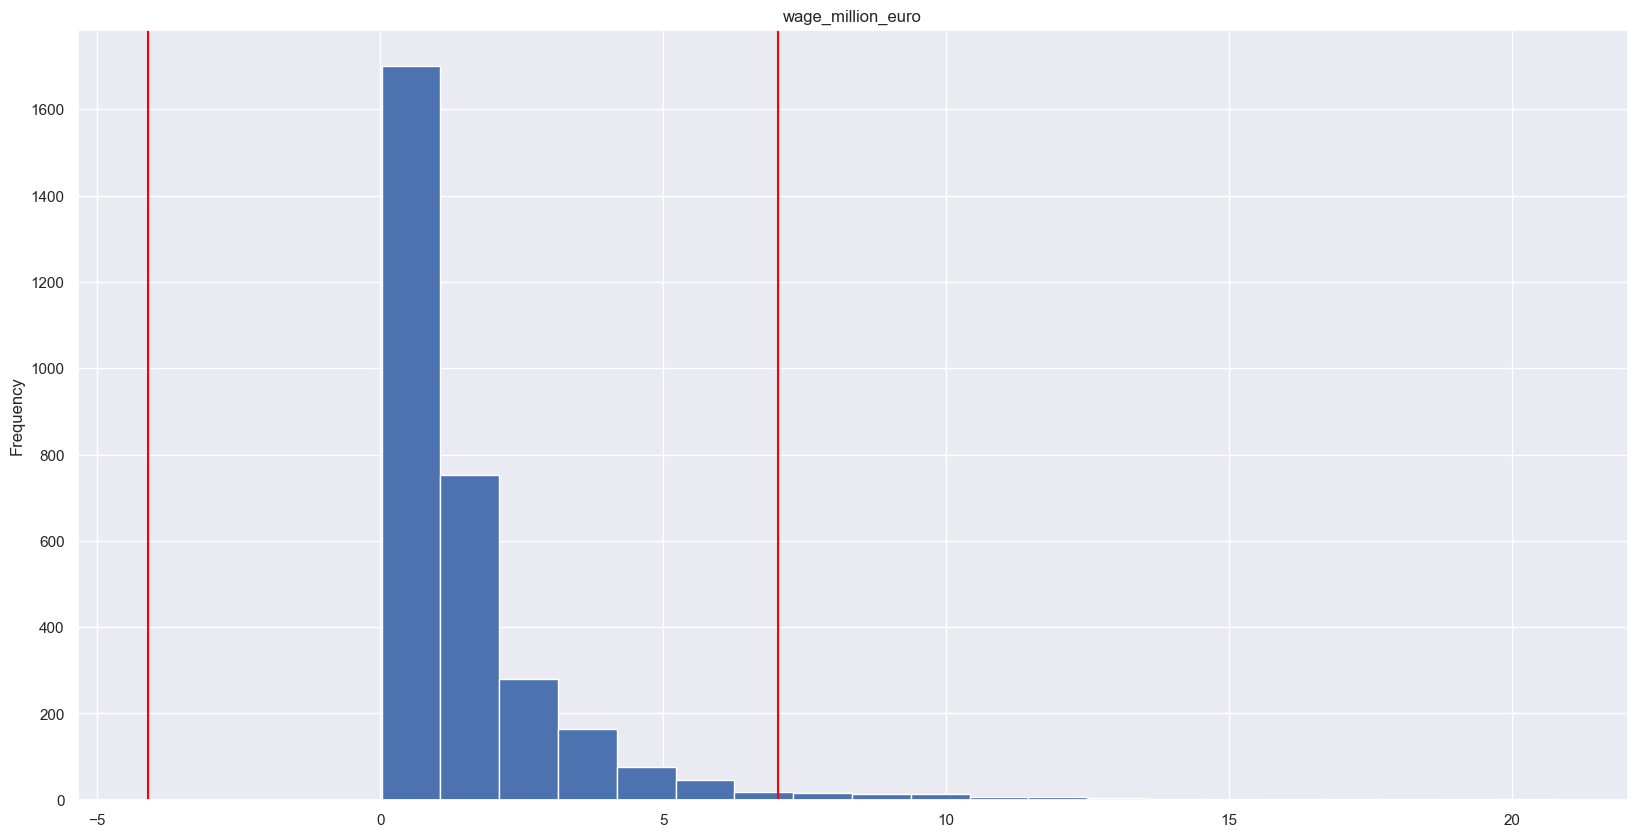

Variable: wage_million_euro
Umbral Superior: 7.033149562215817
Umbral Inferior: -4.097525409810263
Total de Outliers: 66



In [351]:
df_interes = df_skills[columnas_outliers]

for col in df_interes.select_dtypes(include=["int", 'float']).columns:
    media = df_interes[col].mean()
    desviacion_estandar = df_interes[col].std()

    umbral_superior = media + 3 * desviacion_estandar
    umbral_inferior = media - 3 * desviacion_estandar
    
    outliers = df_interes[(df_interes[col] > umbral_superior) | (df_interes[col] < umbral_inferior)]
    total_outliers = outliers.shape[0]
    
    df_interes[col].plot(kind='hist', bins=20)
    plt.axvline(umbral_inferior, color='red')
    plt.axvline(umbral_superior, color='red')
    plt.title(col)
    plt.show()
    plt.close()

    print(f"Variable: {col}")
    print(f"Umbral Superior: {umbral_superior}")
    print(f"Umbral Inferior: {umbral_inferior}")
    print(f"Total de Outliers: {total_outliers}\n")


Como podemos observar en los outliers, hay 43 futbolistas que podemos clasificar como élite total, ya que son los outliers de la valoración general del jugador ('Overall'). Estos tienen una valoración general mayor a 86.1 sobre 100. En 'Potencial' los valores son parecidos, pero encontramos más outliers, por lo que podemos pensar que hay más jugadores porque hay futuras promesas para convertirse en jugadores de élite.

Para el Valor de mercado en millones euros sí que hay más outliers, pero son bastante importantes para nuestro proyecto. En cualquier caso, el umbral está en torno a los 25 millones. Un valor bastante bajo según el mercado futbolístico actual. Es cierto que la mayoría de jugadores y transacciones se hacen por debajo de los 25 millones, pero por encima se encuentran muchas operaciones importantes de mercado. El salario tiene 66 outliers y son los superiores a 7.03 millones de euros anuales.

Para la edad, tenemos como outlier los jugadores que tengan 40 o más años y un conteo total de 32 jugadores en ese rango de edad. Para la variable de altura el umbral superior, a partir del cual se consideran outliers, serían 2,02 metros de altura. En este caso hay outliers inferiores al umbral inferior, que sería 1,6 metros. Juntando ambos umbrales (superior e inferior) hay 23 jugadores, por encima o debajo de estas alturas.
___



### ENCODING

In [352]:
from sklearn.preprocessing import LabelEncoder

Con 'attacking_work_rate' y 'defensive_work_rate', al contener valores categóricos con un orden (Low < Medium < High), queríamos realizar un Label enconding a los valores 0, 1 y 2, pero no respetaba ese orden lógico de menor a mayor, por lo que optamos por hacer un mapeo para introducir los valores 0, 1 y 2 (Low, Medium y High) 

In [353]:
df_skills['attacking_work_rate'].value_counts()

attacking_work_rate
Medium    1907
High      1042
Low        148
Name: count, dtype: int64

In [354]:
print(df_skills['attacking_work_rate'].unique())


['High' 'Medium' 'Low']


In [355]:
attacking_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

df_skills['attacking_work_rate'] = df_skills['attacking_work_rate'].map(attacking_mapping)

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\1447918813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills['attacking_work_rate'] = df_skills['attacking_work_rate'].map(attacking_mapping)


In [356]:
df_skills['attacking_work_rate'].value_counts()

attacking_work_rate
1    1907
2    1042
0     148
Name: count, dtype: int64

In [357]:
df_skills['defensive_work_rate'].value_counts()

defensive_work_rate
Medium    2212
High       681
Low        204
Name: count, dtype: int64

In [358]:
defensive_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

df_skills['defensive_work_rate'] = df_skills['defensive_work_rate'].map(defensive_mapping)

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\4192741777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills['defensive_work_rate'] = df_skills['defensive_work_rate'].map(defensive_mapping)


In [359]:
df_skills['defensive_work_rate'].value_counts()

defensive_work_rate
1    2212
2     681
0     204
Name: count, dtype: int64

La variable 'preferred_foot' (Right o Left) la convertimos a 1 y 0, por lo que utilizamos un mapeo para hacer un Binary encoding

In [360]:
df_skills['preferred_foot'] = df_skills['preferred_foot'].map({'Right': 1, 'Left': 0})

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\1525017330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills['preferred_foot'] = df_skills['preferred_foot'].map({'Right': 1, 'Left': 0})


In [361]:
df_skills['preferred_foot'].value_counts()

preferred_foot
1    2291
0     806
Name: count, dtype: int64

____

### ANÁLISIS DE DATOS

EDAD

In [362]:
df_skills['age'].value_counts().count()

np.int64(25)

In [363]:
df_skills['age'].describe().to_frame().T

count       mean       std   min   25%   50%   75%   max
age  3097.0  24.962867  4.616309  16.0  21.0  24.0  28.0  40.0

In [364]:
print(f'La media de edad de los jugadores de las 5 grandes ligas en la temporada 23/24 es de{df_skills['age'].mean(): .2f} años.')
print(f'La mediana de edad de los jugadores de las 5 grandes ligas en la temporada 23/24 es de{df_skills['age'].median(): .2f} años.')
print(f'La edad más habitual de los jugadores de las 5 grandes ligas en la temporada 23/24 es de{df_skills['age'].mode()[0]: .2f} años.')

La media de edad de los jugadores de las 5 grandes ligas en la temporada 23/24 es de 24.96 años.
La mediana de edad de los jugadores de las 5 grandes ligas en la temporada 23/24 es de 24.00 años.
La edad más habitual de los jugadores de las 5 grandes ligas en la temporada 23/24 es de 21.00 años.


Distribución de la variable edad

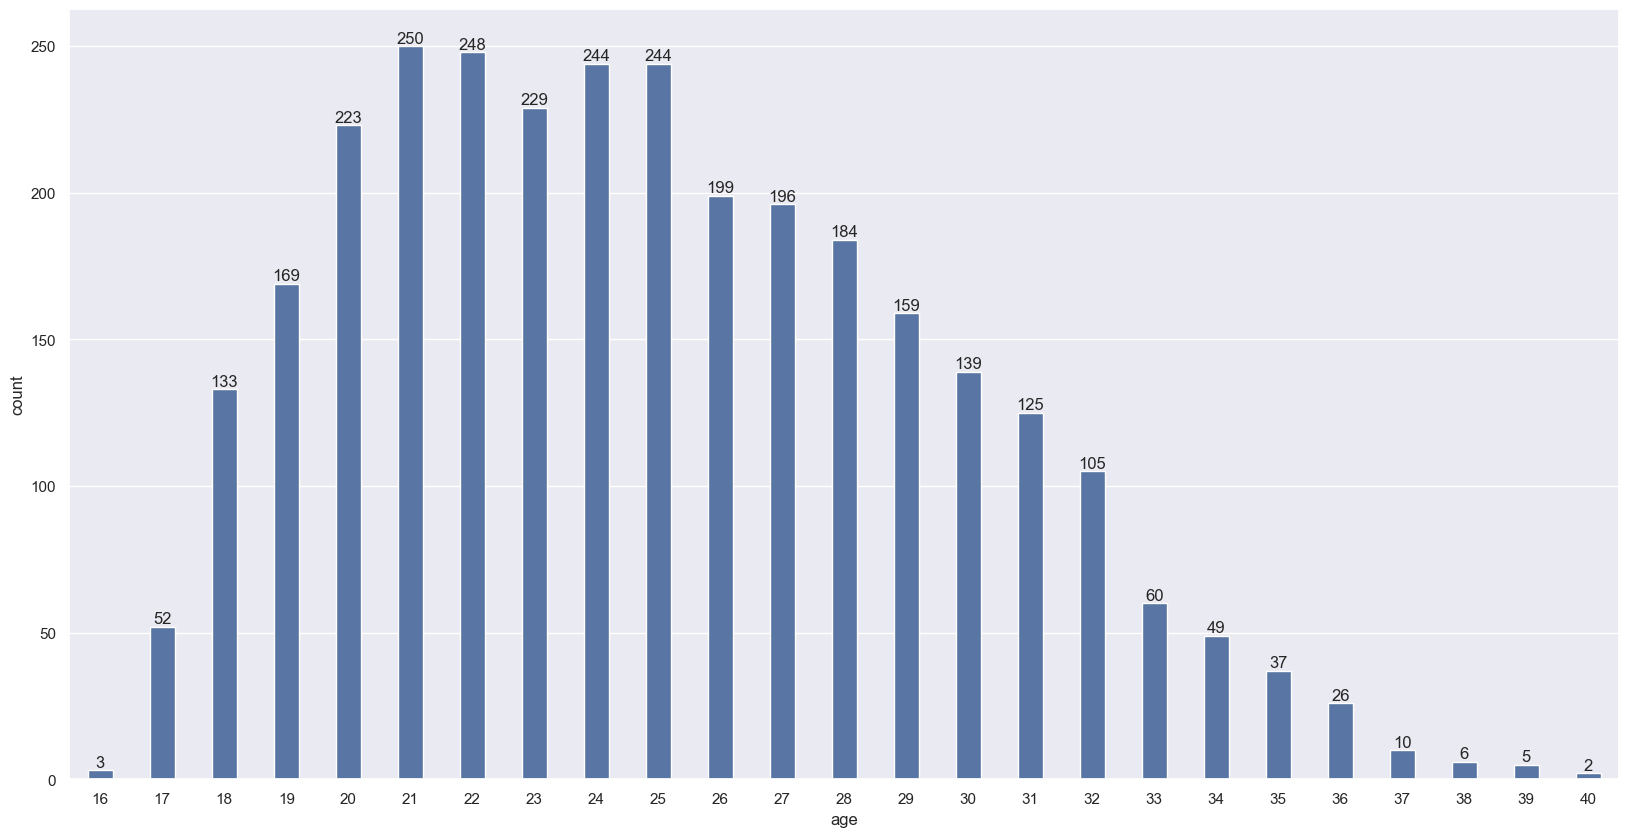

In [365]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.countplot(x = 'age',data = df_skills,width=0.4)
for bars in ax.containers:
    ax.bar_label(bars)

In [366]:
skewness_age = df_skills['age'].skew()
skewness_age

np.float64(0.42726895855704033)

La distribución de la edad es positiva, pero no mucho. Tiende a la derecha, donde se sitúa la cola de la distribución. Esto indica que hay algunos valores de edad que son más altos que la mayoría, y estos elevan la media hacia la derecha. La media estaría en 24.96 años (prácticamente 25) y la edad más repetida son los 21 años.

Los valores han tenido algún pequeño cambio con respecto a nuestro otro notebook estadísitco, ya que este dataset incluye más jugadores por equipo. Revisándolo, esto es debido a jugadores de la cantera que han podido jugar algún partido con el equipo, pero realmente pertenecen a categorías inferiores, lo que hace que cambie ligeramente nuestra distribución a modas más bajas. No pudimos realizar un merge de estos jugadores, ya que no contamos con sus estadísticas para tener los valores de variables importantes del otro data set 

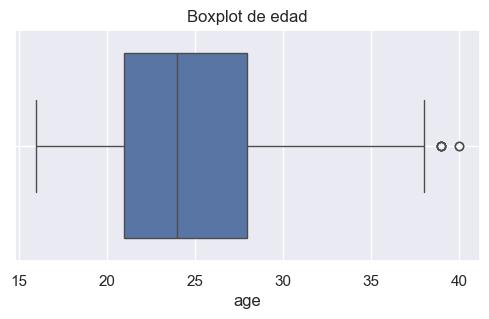

In [367]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_skills['age'])
plt.grid(True)
plt.title('Boxplot de edad')
plt.show()

Visualizando el boxplot de edad y calculando los valores de límites con cuantiles, observamos que se considera atípico los jugadores mayores de 38 años y que hay 7 jugadores por encima de esas edad en total

In [368]:
Q1_age = df_skills['age'].quantile(0.25)
Q3_age = df_skills['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

upper_limit_age = Q3_age + 1.5 * IQR_age
print(f"Años que se consideran outlier: {upper_limit_age} años o más")

outliers_age = df_skills[df_skills['age'] > upper_limit_age]
print(f"Cantidad de outliers: {len(outliers_age)}")

Años que se consideran outlier: 38.5 años o más
Cantidad de outliers: 7


VALOR DE MERCADO

In [369]:
df_skills['value_million_euro'].value_counts().count()

np.int64(240)

In [370]:
df_skills['value_million_euro'].describe().round(6)

count    3097.000000
mean        9.397795
std        15.378606
min         0.000000
25%         1.400000
50%         3.300000
75%        10.500000
max       190.500000
Name: value_million_euro, dtype: float64

In [371]:
print(f'La media de valor de mercado de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de{df_skills['value_million_euro'].mean(): .2f} millones de euros')
print(f'La mediana de valor de mercado de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de{df_skills['value_million_euro'].median(): .2f} millones de euros.')
print(f'El valor de mercado más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de {df_skills["value_million_euro"].mode()[0]: .2f} millones de euros.')

La media de valor de mercado de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de 9.40 millones de euros
La mediana de valor de mercado de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de 3.30 millones de euros.
El valor de mercado más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de  1.10 millones de euros.


Se observa que el coste cero corresponde a un jugador de 40 años y que quizás ya se retire a final de temporada

In [372]:
coste_cero = df_skills[df_skills['value_million_euro'] == 0]
coste_cero

name  overall  potential  value_million_euro position  \
20306  Jorge Molina Vidal       77         77                 0.0  Forward   

      nationality  age  height     team formation  ... penalties  mentality  \
20306       Spain   40     188  Granada     4-3-3  ...        79         79   

       marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
20306       45               32              19                  0   

       goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
20306                    0                   0                       0   

       goalkeeper_reflexes  
20306                    0  

[1 rows x 51 columns]

In [373]:
max_value_player = df_skills[df_skills['value_million_euro'] == df_skills['value_million_euro'].max()]
max_value_player

name  overall  potential  value_million_euro position  \
26  Kylian Mbappé       91         95               190.5  Forward   

   nationality  age  height                 team formation  ... penalties  \
26      France   23     182  Paris Saint-Germain     4-3-3  ...        80   

    mentality  marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
26         88       26               34              32                  0   

    goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
26                    0                   0                       0   

    goalkeeper_reflexes  
26                    0  

[1 rows x 51 columns]

In [374]:
max_value = df_skills['value_million_euro'].idxmax()
player_name = df_skills.loc[max_value, 'name']
player_value = df_skills.loc[max_value, 'value_million_euro']

print(f'Jugador con mayor valor de mercado:\n{player_name}: {player_value} millones de euros')

Jugador con mayor valor de mercado:
Kylian Mbappé: 190.5 millones de euros


Graficamos para ver el top 10 jugadores con mayor valor de mercado

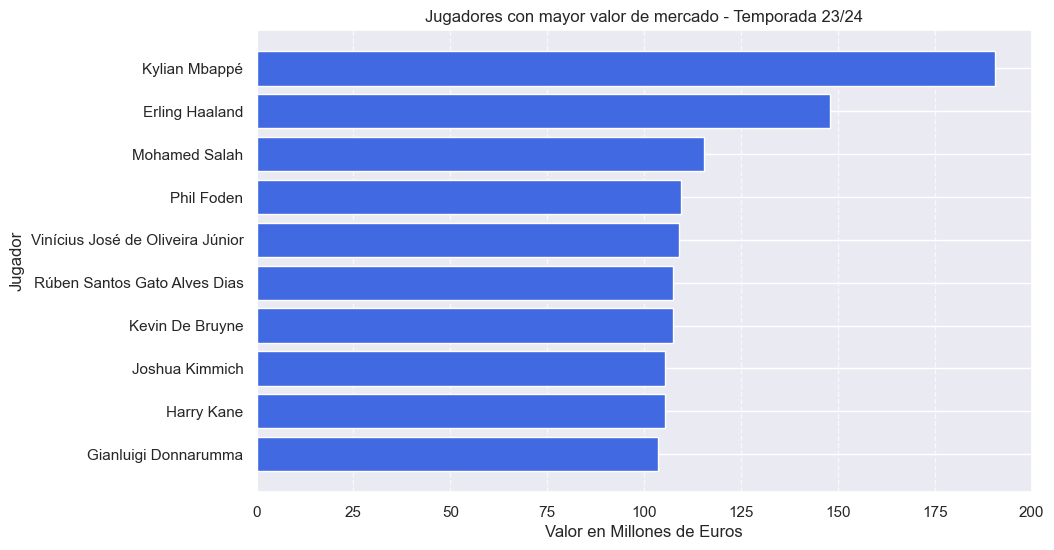

In [375]:
df_max_value = df_skills.sort_values('value_million_euro', ascending=False).head(10)

player_name = df_max_value['name']
player_value = df_max_value['value_million_euro']

plt.figure(figsize=(10, 6))
plt.barh(player_name[::-1], player_value[::-1], color='royalblue')
plt.xlabel('Valor en Millones de Euros')
plt.ylabel('Jugador')
plt.title('Jugadores con mayor valor de mercado - Temporada 23/24')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


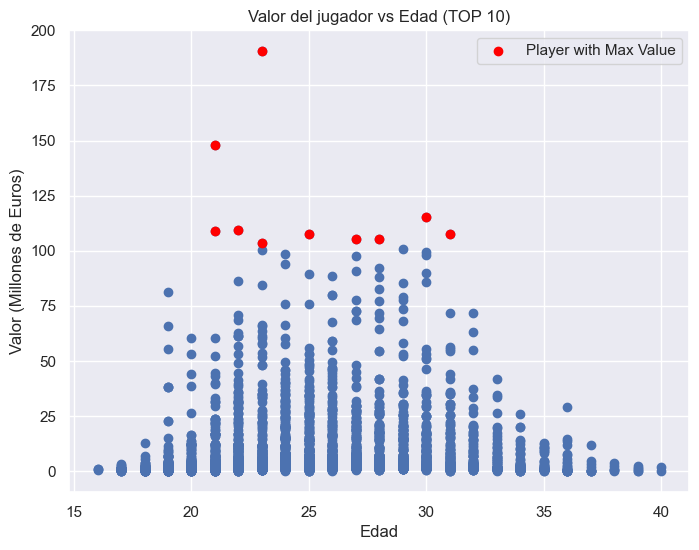

In [376]:
plt.figure(figsize=(8, 6))
plt.scatter(df_skills['age'], df_skills['value_million_euro'])
plt.scatter(df_max_value.iloc[:10]['age'], df_max_value.iloc[:10]['value_million_euro'], color='red', label='Player with Max Value')
plt.xlabel('Edad')
plt.ylabel('Valor (Millones de Euros)')
plt.title('Valor del jugador vs Edad (TOP 10)')
plt.legend()
plt.show()

La varianza del valor de mercado es muy alta, mientras que la desiación típica no es tan exagerada, aunque puede considerarse algo alta para valores de mercado más bajos.

In [377]:
print(f'Varianza valor de mercado:{df_skills['value_million_euro'].var(): .2f} millones de euros')
print(f'Desviación típica de valor de mercado:{df_skills['value_million_euro'].std(): .2f} millones de euros')
print(f'Coeficiente de variación de valor de mercado:{df_skills['value_million_euro'].std()/np.abs(df_skills['value_million_euro'].mean()): .2f} millones de euros')

Varianza valor de mercado: 236.50 millones de euros
Desviación típica de valor de mercado: 15.38 millones de euros
Coeficiente de variación de valor de mercado: 1.64 millones de euros


La distribución del valor de mercado es bastante asimétrico, con una enorme cola a la derecha de la distribución, lo que sugiere que hay valores de mercado muy por encima de la media y la moda, que es más bien baja. La media se sitúa en los 9.4 millones de euros, mientras que hay valores muy altos, entre los 100 y 200 millones de euros

In [378]:
skewness_value = df_skills['value_million_euro'].skew()
skewness_value

np.float64(3.6414654985553563)

Lo que comentamos de la distribución se puede comprobar fácilmente con los outliers, ya que existen mucho y mucho más altos del límite superior. Hay 340 jugadores que valen por encima del límite superior de outliers, que se considera 24.15 millones. Esto es una cantidad relativamente baja para el fútbol y los movimientos de mercado de las 5 grandes ligas, de ahí el sesgo de la distribución de esta variable

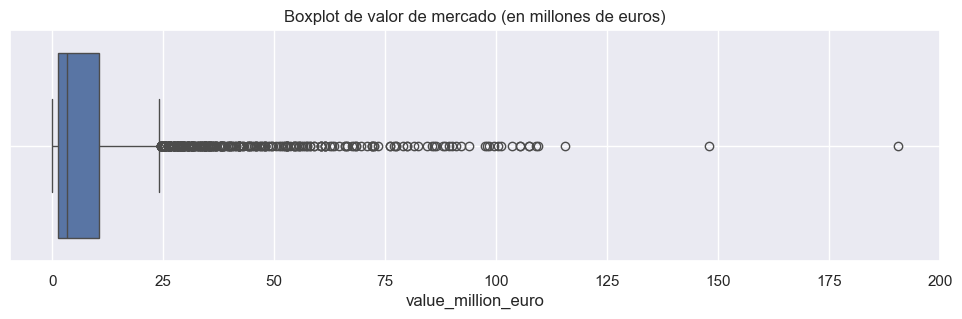

In [379]:
plt.figure(figsize=(12,3))
sns.boxplot(x=df_skills['value_million_euro'])
plt.grid(True)
plt.title('Boxplot de valor de mercado (en millones de euros)')
plt.show()

In [380]:
Q1_value_million_euro = df_skills['value_million_euro'].quantile(0.25)
Q3_value_million_euro = df_skills['value_million_euro'].quantile(0.75)
IQR_value_million_euro = Q3_value_million_euro - Q1_value_million_euro

upper_limit_value_million_euro = Q3_value_million_euro + 1.5 * IQR_value_million_euro
print(f"Valor en millones que se considera outlier: {upper_limit_value_million_euro} millones o más")

outliers_value_million_euro = df_skills[df_skills['value_million_euro'] > upper_limit_value_million_euro]
print(f"Cantidad de outliers: {len(outliers_value_million_euro)}")

Valor en millones que se considera outlier: 24.15 millones o más
Cantidad de outliers: 340


SALARIO

In [381]:
df_skills['wage_million_euro'].describe().to_frame().T

count      mean       std    min    25%    50%    75%  \
wage_million_euro  3097.0  1.467812  1.855112  0.026  0.312  0.936  1.872   

                    max  
wage_million_euro  20.8

In [382]:
print(f'La media de salario de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de{df_skills['wage_million_euro'].mean(): .2f} millones de euros')
print(f'La mediana de salario de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de{df_skills['wage_million_euro'].median(): .2f} millones de euros.')
print(f'El salario más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de {df_skills["wage_million_euro"].mode()[0]: .2f} millones de euros.')

La media de salario de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de 1.47 millones de euros
La mediana de salario de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de 0.94 millones de euros.
El salario más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de  0.10 millones de euros.


Observamos los salarios mínimos y los máximos

In [383]:
min_wage = df_skills[df_skills['wage_million_euro'] == 0.026]
min_wage.head()

name  overall  potential  value_million_euro  \
55327      Theocharis Tsingaras       70         79               3.400   
71475                 Tom Rothe       65         82               1.700   
72330  Vinícius Tobías da Silva       65         83               1.700   
80612    El Chadaille Bitshiabu       62         80               0.925   
81228   Alejandro Padilla Pérez       62         80               0.900   

         position nationality  age  height                 team formation  \
55327  Midfielder      Greece   21     175             Toulouse   4-2-3-1   
71475   Full Back     Germany   17     192    Borussia Dortmund   4-2-3-1   
72330   Full Back      Brazil   18     175          Real Madrid     4-3-3   
80612    Defender      France   17     196  Paris Saint-Germain     4-3-3   
81228  Goalkeeper       Spain   18     190      Athletic Bilbao     4-4-2   

       ... penalties  mentality  marking  standing_tackle  sliding_tackle  \
55327  ...        45         66       66               72              70   
71475  ...        37         51       57               64              63   
72330  ...        49         60       60               62              60   
80612  ...        38         51       59               63              48   
81228  ...         0         21        0                0               0   

       goalkeeper_diving  goalkeeper_handling  goalkeeper_kicking  \
55327                  0                    0                   0   
71475                  0                    0                   0   
72330                  0                    0                   0   
80612                  0                    0                   0   
81228                 64                   65                  62   

       goalkeeper_positioning  goalkeeper_reflexes  
55327                       0                    0  
71475                       0                    0  
72330                       0                    0  
80612                       0                    0  
81228                      61                   63  

[5 rows x 51 columns]

In [384]:
max_wage_player = df_skills[df_skills['wage_million_euro'] == df_skills['wage_million_euro'].max()]
max_wage_player

name  overall  potential  value_million_euro position  \
26  Kylian Mbappé       91         95               190.5  Forward   

   nationality  age  height                 team formation  ... penalties  \
26      France   23     182  Paris Saint-Germain     4-3-3  ...        80   

    mentality  marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
26         88       26               34              32                  0   

    goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
26                    0                   0                       0   

    goalkeeper_reflexes  
26                    0  

[1 rows x 51 columns]

In [385]:
max_wage = df_skills['wage_million_euro'].idxmax()
player_name_wage = df_skills.loc[max_wage, 'name']
player_wage_wage = df_skills.loc[max_wage, 'wage_million_euro']

print(f'Jugador con mayor salario:\n{player_name_wage}: {player_wage_wage} millones de euros')

Jugador con mayor salario:
Kylian Mbappé: 20.8 millones de euros


Con esto, además, vemos que los jugadores con salarios más altos parecen corresponderse en su mayoría también con los que tienen mayor valor de mercado

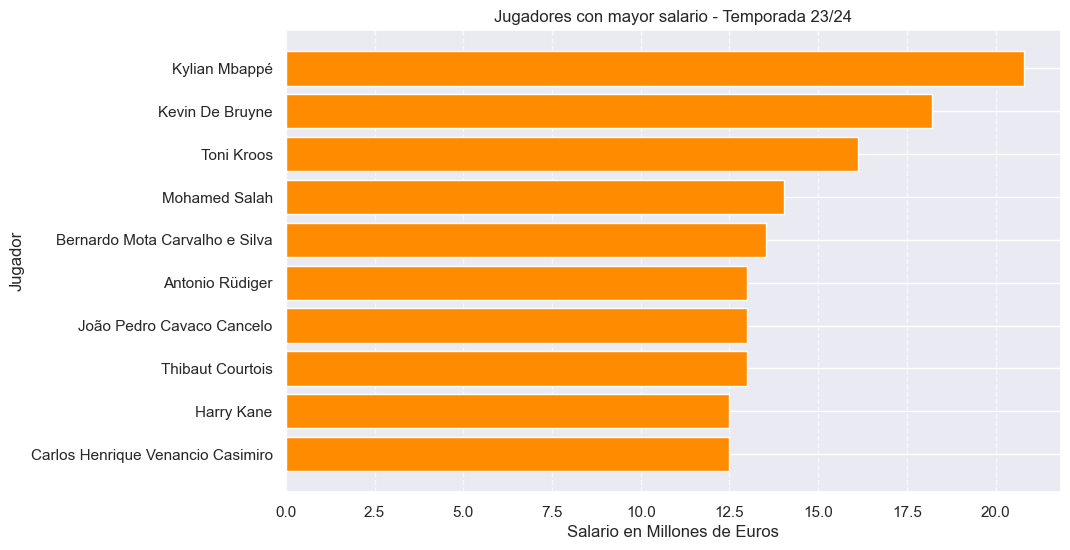

In [386]:
df_max_wage = df_skills.sort_values('wage_million_euro', ascending=False).head(10)

player_name = df_max_wage['name']
player_wage = df_max_wage['wage_million_euro']

plt.figure(figsize=(10, 6))
plt.barh(player_name[::-1], player_wage[::-1], color='darkorange')
plt.xlabel('Salario en Millones de Euros')
plt.ylabel('Jugador')
plt.title('Jugadores con mayor salario - Temporada 23/24')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

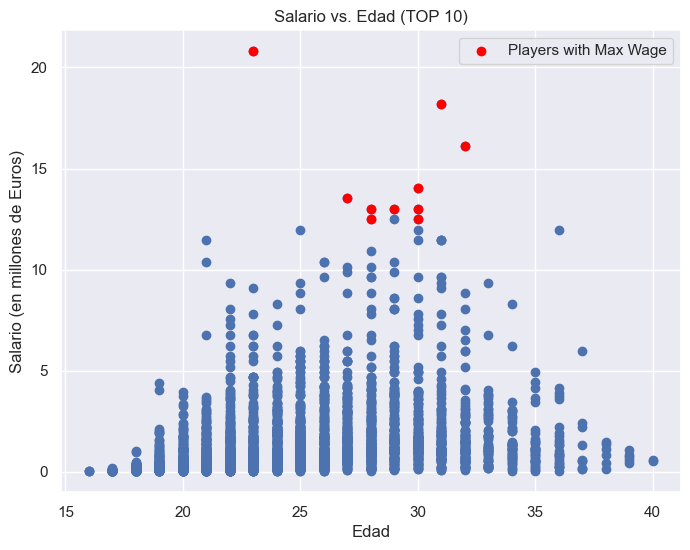

In [387]:
df_max_wage = df_skills.sort_values('wage_million_euro', ascending=False)

plt.figure(figsize=(8, 6))
plt.scatter(df_skills['age'], df_skills['wage_million_euro'])

plt.scatter(df_max_wage.iloc[:10]['age'], df_max_wage.iloc[:10]['wage_million_euro'], color='red', label='Players with Max Wage')

plt.xlabel('Edad')
plt.ylabel('Salario (en millones de Euros)')
plt.title('Salario vs. Edad (TOP 10)')
plt.legend()
plt.show()


La varianza del salario, como en el caso del valor de mercado, es bastante cambiante y puede generar valores de desviación muy altos para salarios bajos

In [388]:
print(f'Varianza del salario de los jugadores:{df_skills['wage_million_euro'].var(): .2f} millones de euros')
print(f'Desviación típica de del salario de los jugadores:{df_skills['wage_million_euro'].std(): .2f} millones de euros')
print(f'Coeficiente de variación de del salario de los jugadores:{df_skills['wage_million_euro'].std()/np.abs(df_skills['wage_million_euro'].mean()): .2f} millones de euros')

Varianza del salario de los jugadores: 3.44 millones de euros
Desviación típica de del salario de los jugadores: 1.86 millones de euros
Coeficiente de variación de del salario de los jugadores: 1.26 millones de euros


In [389]:
skewness_wage = df_skills['wage_million_euro'].skew()
skewness_wage

np.float64(3.231557882972605)

La distribución del salario también es extremadamente parecida a la del valor de mercado, siendo bastante asimétrica, con una gran cola a la derecha de la distribución, por lo que hay salarios muy por encima de la media y la moda, que es baja. La media se sitúa en los 1.47 millones de euros, mientras que hay valores muy altos, entre los 10 y 25 millones de euros. El valor más habitual de salario es 0.1 millones de euros (100.000 euros), lo que representa un valor bastante bajo. Se dan más en equipos pequeños y, como hemos comentado anteriormente, canteranos que juegan en ocasiones con el primer equipo

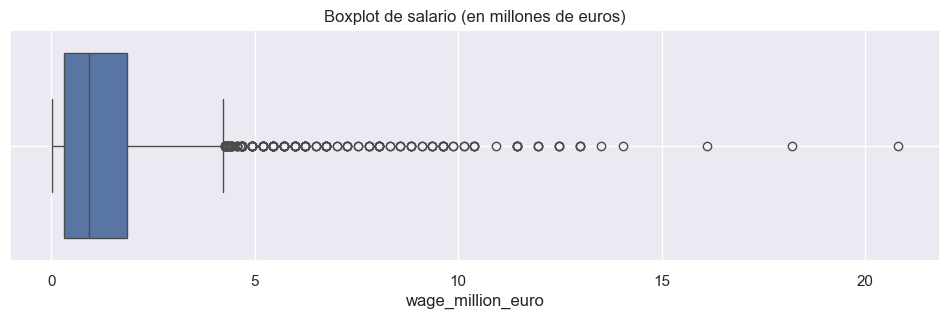

In [390]:
plt.figure(figsize=(12,3))
sns.boxplot(x=df_skills['wage_million_euro'])
plt.grid(True)
plt.title('Boxplot de salario (en millones de euros)')
plt.show()

In [391]:
Q1_wage_million_euro = df_skills['wage_million_euro'].quantile(0.25)
Q3_wage_million_euro = df_skills['wage_million_euro'].quantile(0.75)
IQR_wage_million_euro = Q3_wage_million_euro - Q1_wage_million_euro

upper_limit_wage_million_euro = Q3_wage_million_euro + 1.5 * IQR_wage_million_euro
print(f"Valor en millones que se considera outlier: {upper_limit_wage_million_euro} millones o más")

outliers_wage_million_euro = df_skills[df_skills['wage_million_euro'] > upper_limit_wage_million_euro]
print(f"Cantidad de outliers: {len(outliers_wage_million_euro)}")

Valor en millones que se considera outlier: 4.212 millones o más
Cantidad de outliers: 196


ALTURA

In [392]:
df_skills['height'].value_counts().count()

np.int64(42)

In [393]:
df_skills['height'].describe().to_frame().T

count        mean       std    min    25%    50%    75%    max
height  3097.0  182.752018  6.700147  162.0  178.0  183.0  188.0  204.0

In [394]:
print(f'La altura media de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de{df_skills['height'].mean(): .2f} centímetros')
print(f'La altura más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de{df_skills["height"].mode()[0]: .2f} centímetros.')

La altura media de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de 182.75 centímetros
La altura más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de 185.00 centímetros.


In [395]:
print(f'El jugador más alto de las 5 grandes ligas europeas en la temporada 23/24 mide{df_skills['height'].max(): .2f} centímetros')
print(f'El jugador más alto entre los jugadores de las 5 grandes ligas en la temporada 23/24 mide{df_skills["height"].min(): .2f} centímetros.')

El jugador más alto de las 5 grandes ligas europeas en la temporada 23/24 mide 204.00 centímetros
El jugador más alto entre los jugadores de las 5 grandes ligas en la temporada 23/24 mide 162.00 centímetros.


In [396]:
max_height = df_skills[df_skills['height'] == df_skills['height'].max()]
max_height

name  overall  potential  value_million_euro  position  \
67151  Isaak Touré       67         83                 2.5  Defender   

      nationality  age  height       team formation  ... penalties  mentality  \
67151      France   19     204  Marseille   4-2-3-1  ...        41         64   

       marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
67151       62               65              60                  0   

       goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
67151                    0                   0                       0   

       goalkeeper_reflexes  
67151                    0  

[1 rows x 51 columns]

In [397]:
min_height = df_skills[df_skills['height'] == df_skills['height'].min()]
min_height

name  overall  potential  value_million_euro    position  \
73183  José Alonso Lara       65         75                 1.6  Midfielder   

      nationality  age  height        team formation  ... penalties  \
73183       Spain   22     162  Real Betis   4-2-3-1  ...        61   

       mentality  marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
73183         49       28               36              28                  0   

       goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
73183                    0                   0                       0   

       goalkeeper_reflexes  
73183                    0  

[1 rows x 51 columns]

La desviación tipica para la altura es bastante pequeña, aunque tiene una varianza moderada

In [398]:
print(f'Varianza de altura de los jugadores:{df_skills['height'].var(): .2f} centímetros')
print(f'Desviación típica de de altura de los jugadores:{df_skills['height'].std(): .2f} centimetros')
print(f'Coeficiente de variación de de altura de los jugadores:{df_skills['height'].std()/np.abs(df_skills['height'].mean()): .2f} centimetros')

Varianza de altura de los jugadores: 44.89 centímetros
Desviación típica de de altura de los jugadores: 6.70 centimetros
Coeficiente de variación de de altura de los jugadores: 0.04 centimetros


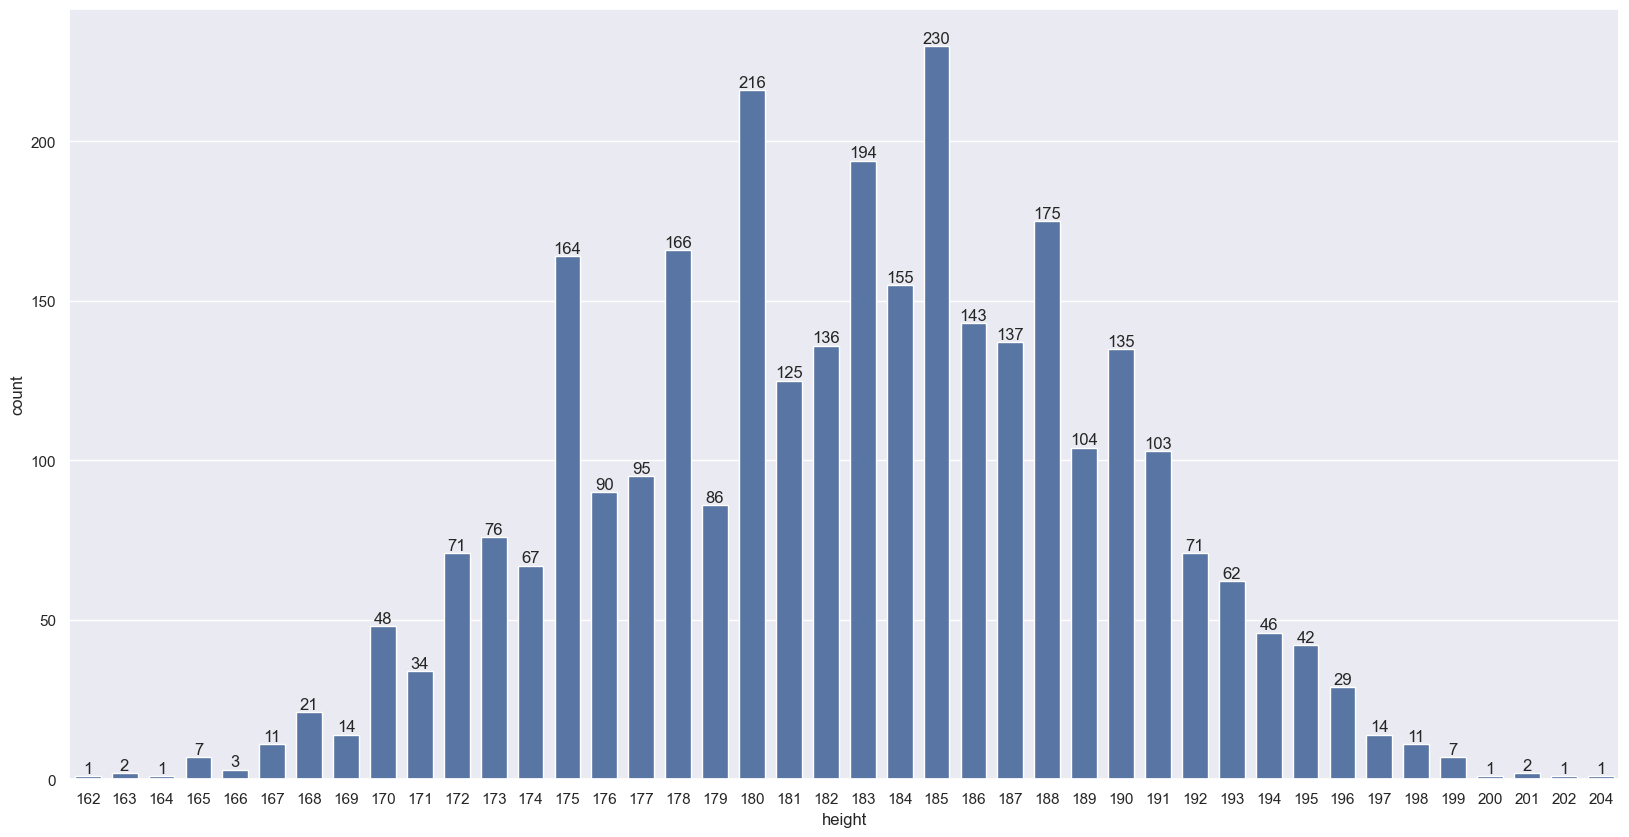

In [399]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.countplot(x = 'height',data = df_skills ,width=0.7)
for bars in ax.containers:
    ax.bar_label(bars)

In [400]:
skewness_height = df_skills['height'].skew()
skewness_height

np.float64(-0.09083068800972455)

La variable altura, aunque es negativa y a la izquierda, supone un valor muy pequeño, por lo que se considera bastante simétrica. Además, se observa que los jugadores profesionales tienden a ser bastante altos, ya que la media se sitúa en los 182,75 centímetros y la altura más habitual son 185 cm, presentando un solo outlier por cada umbral. Uno por encima de los 203 cm y otro por debajo de los 163 cm, lo que confirma la distribución tan simétrica de la altura

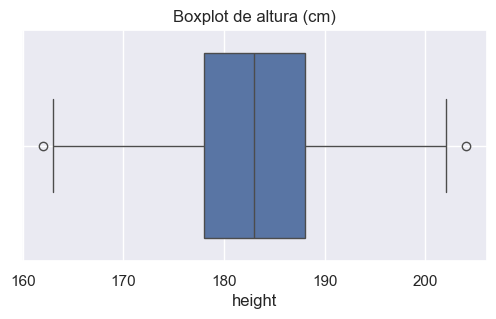

In [401]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_skills['height'])
plt.grid(True)
plt.title('Boxplot de altura (cm)')
plt.show()

In [402]:
Q1_height = df_skills['height'].quantile(0.25)
Q3_height = df_skills['height'].quantile(0.75)
IQR_height = Q3_height - Q1_height

upper_limit_height = Q3_height + 1.5 * IQR_height
print(f"Valor en centimetros: {upper_limit_height} centimetros o más")

outliers_height = df_skills[df_skills['height'] > upper_limit_height]
print(f"Cantidad de outliers: {len(outliers_height)}")

lower_limit_height = Q1_height - 1.5 * IQR_height
print(f"Valor en centímetros: {lower_limit_height} centímetros o menos")

outliers_below_height = df_skills[df_skills['height'] < lower_limit_height]
print(f"Cantidad de outliers por debajo del límite inferior: {len(outliers_below_height)}")


Valor en centimetros: 203.0 centimetros o más
Cantidad de outliers: 1
Valor en centímetros: 163.0 centímetros o menos
Cantidad de outliers por debajo del límite inferior: 1


OVERALL (Puntuación general de los futbolistas)

In [403]:
df_skills['overall'].value_counts().count()

np.int64(42)

In [404]:
df_skills['overall'].describe().to_frame().T

count       mean       std   min   25%   50%   75%   max
overall  3097.0  71.695512  7.255664  50.0  67.0  73.0  77.0  91.0

In [405]:
print(f'La puntuación media de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de{df_skills['overall'].mean(): .2f} sobre 100')
print(f'La puntuación más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de{df_skills["overall"].mode()[0]: .2f} sobre 100.')

La puntuación media de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de 71.70 sobre 100
La puntuación más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de 73.00 sobre 100.


Vemos los jugadores con mayor y menor puntuación general

In [406]:
max_overall = df_skills[df_skills['overall'] == df_skills['overall'].max()]
max_overall

name  overall  potential  value_million_euro    position  \
3   Kevin De Bruyne       91         91               107.5  Midfielder   
26    Kylian Mbappé       91         95               190.5     Forward   

   nationality  age  height                 team formation  ... penalties  \
3      Belgium   31     181      Manchester City     4-3-3  ...        83   
26      France   23     182  Paris Saint-Germain     4-3-3  ...        80   

    mentality  marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
3          89       68               65              53                  0   
26         88       26               34              32                  0   

    goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
3                     0                   0                       0   
26                    0                   0                       0   

    goalkeeper_reflexes  
3                     0  
26                    0  

[2 rows x 51 columns]

In [407]:
overall_top10 = df_skills.sort_values(by='overall', ascending=False).head(10)
overall_top10

name  overall  potential  value_million_euro  \
3          Kevin De Bruyne       91         91               107.5   
26           Kylian Mbappé       91         95               190.5   
53           Mohamed Salah       90         90               115.5   
82        Thibaut Courtois       90         91                90.0   
109           Manuel Neuer       90         90                13.5   
140        Virgil van Dijk       90         90                98.0   
358  Alisson Ramses Becker       89         90                79.0   
328         Joshua Kimmich       89         90               105.5   
387           N'Golo Kanté       89         89                72.0   
169             Harry Kane       89         89               105.5   

       position  nationality  age  height                 team formation  ...  \
3    Midfielder      Belgium   31     181      Manchester City     4-3-3  ...   
26      Forward       France   23     182  Paris Saint-Germain     4-3-3  ...   
53       Winger        Egypt   30     175            Liverpool     4-3-3  ...   
82   Goalkeeper      Belgium   30     199          Real Madrid     4-3-3  ...   
109  Goalkeeper      Germany   36     193        Bayern Munich   4-2-3-1  ...   
140    Defender  Netherlands   30     193            Liverpool     4-3-3  ...   
358  Goalkeeper       Brazil   29     191            Liverpool     4-3-3  ...   
328  Midfielder      Germany   27     177        Bayern Munich   4-2-3-1  ...   
387  Midfielder       France   31     168              Chelsea     3-4-3  ...   
169     Forward      England   28     188        Bayern Munich   4-2-3-1  ...   

    penalties  mentality  marking  standing_tackle  sliding_tackle  \
3          83         89       68               65              53   
26         80         88       26               34              32   
53         86         92       38               43              41   
82          0         66        0                0               0   
109         0         70        0                0               0   
140        62         90       92               92              86   
358         0         68        0                0               0   
328        44         85       85               85              78   
387        54         84       90               93              86   
169        92         92       50               36              38   

     goalkeeper_diving  goalkeeper_handling  goalkeeper_kicking  \
3                    0                    0                   0   
26                   0                    0                   0   
53                   0                    0                   0   
82                  84                   89                  75   
109                 87                   88                  91   
140                  0                    0                   0   
358                 86                   85                  85   
328                  0                    0                   0   
387                  0                    0                   0   
169                  0                    0                   0   

     goalkeeper_positioning  goalkeeper_reflexes  
3                         0                    0  
26                        0                    0  
53                        0                    0  
82                       89                   90  
109                      91                   88  
140                       0                    0  
358                      90                   89  
328                       0                    0  
387                       0                    0  
169                       0                    0  

[10 rows x 51 columns]

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\3508937013.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='overall', y='name', data=overall_top10, palette='viridis')


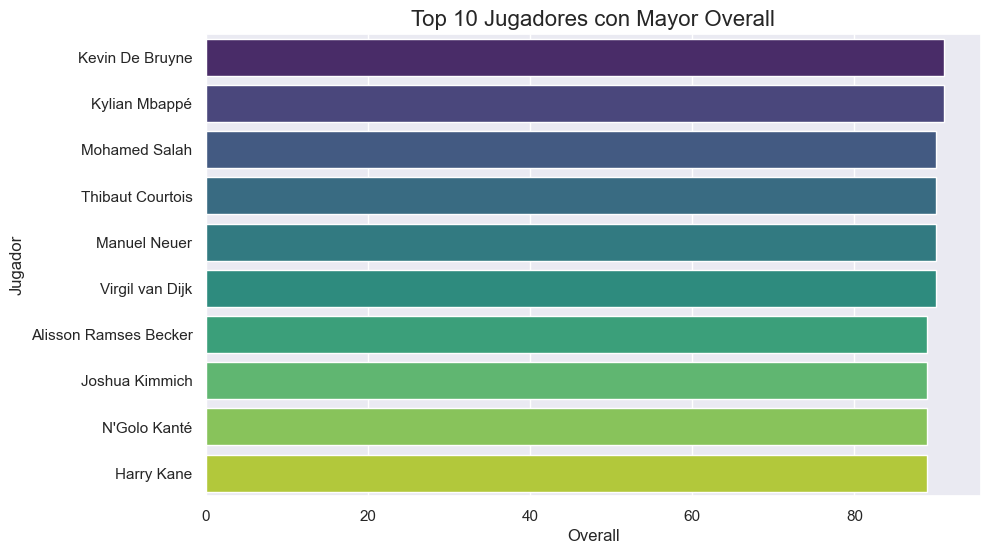

In [408]:
overall_top10 = df_skills.sort_values(by='overall', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='overall', y='name', data=overall_top10, palette='viridis')
plt.title('Top 10 Jugadores con Mayor Overall', fontsize=16)
plt.xlabel('Overall', fontsize=12)
plt.ylabel('Jugador', fontsize=12)
plt.show()

El top 10 de puntuación tiene bastante relación, de nuevo, con el valor de mercado y los salarios

In [409]:
min_overall = df_skills[df_skills['overall'] == df_skills['overall'].min()]
min_overall

name  overall  potential  value_million_euro    position  \
93900  Isaac Price       50         73                0.15  Midfielder   

            nationality  age  height     team formation  ... penalties  \
93900  Northern Ireland   18     178  Everton     4-4-2  ...        43   

       mentality  marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
93900         43       40               38              46                  0   

       goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
93900                    0                   0                       0   

       goalkeeper_reflexes  
93900                    0  

[1 rows x 51 columns]

In [410]:
print(f'Varianza de la puntuación general de los jugadores:{df_skills['overall'].var(): .2f} puntos')
print(f'Desviación típica de de la puntuación general de los jugadores:{df_skills['overall'].std(): .2f} puntos')
print(f'Coeficiente de variación de de la puntuación general de los jugadores:{df_skills['overall'].std()/np.abs(df_skills['overall'].mean()): .2f} puntos')

Varianza de la puntuación general de los jugadores: 52.64 puntos
Desviación típica de de la puntuación general de los jugadores: 7.26 puntos
Coeficiente de variación de de la puntuación general de los jugadores: 0.10 puntos


La desviación es relativamente baja y la varianza, para ser sobre 100 puntos, no es realmente muy alta 

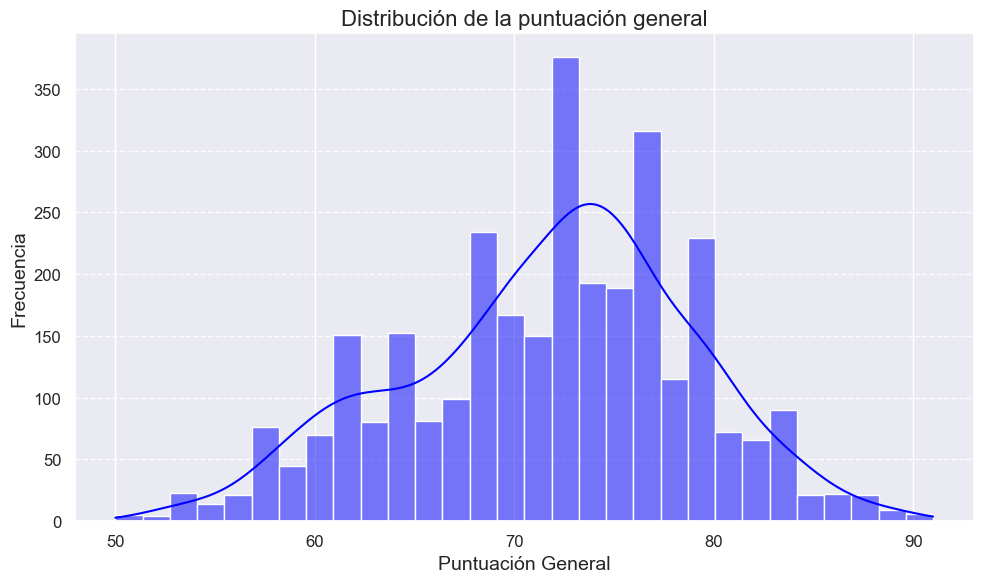

In [411]:
plt.figure(figsize=(10, 6))
sns.histplot(df_skills['overall'], kde=True, bins=30, color='blue')
plt.title('Distribución de la puntuación general', fontsize=16)
plt.xlabel('Puntuación General', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()


In [412]:
skewness_overall = df_skills['overall'].skew()
skewness_overall

np.float64(-0.2853408196216606)

'Overall' tiene una asimetría negativa bastante leve, con pequeña cola a la izquierda de la distribución. Podemos inferir que hay menos valores bajos que altos, concentrandose la media en 71.70 puntos y siendo el valor más habitual 73 puntos. Solo hay 5 valores atípicos y son para jugadores con puntuación menor a 52 puntos (umbral inferior de los cuartiles)

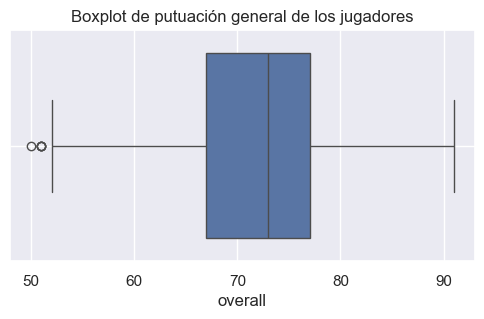

In [413]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_skills['overall'])
plt.grid(True)
plt.title('Boxplot de putuación general de los jugadores')
plt.show()

In [414]:
Q1_overall = df_skills['overall'].quantile(0.25)
Q3_overall = df_skills['overall'].quantile(0.75)
IQR_overall = Q3_overall - Q1_overall

lower_limit_overall = Q1_overall - 1.5 * IQR_overall
print(f"Valor en puntos: {lower_limit_overall} puntos o menos")

outliers_below_overall = df_skills[df_skills['overall'] < lower_limit_overall]
print(f"Cantidad de outliers por debajo del límite inferior: {len(outliers_below_overall)}")

Valor en puntos: 52.0 puntos o menos
Cantidad de outliers por debajo del límite inferior: 5


POTENCIAL (Potencial de un futbolistas, como calidad presente y a futuro)

In [415]:
df_skills['potential'].value_counts().count()

np.int64(36)

In [416]:
df_skills['potential'].describe().to_frame().T

count       mean      std   min   25%   50%   75%   max
potential  3097.0  77.211172  5.37189  58.0  73.0  77.0  81.0  95.0

In [417]:
print(f'El potencial medio de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de{df_skills['potential'].mean(): .2f} sobre 100')
print(f'El valor de potencial más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de{df_skills["potential"].mode()[0]: .2f} sobre 100.')

El potencial medio de los jugadores de las 5 grandes ligas europeas en la temporada 23/24 es de 77.21 sobre 100
El valor de potencial más habitual entre los jugadores de las 5 grandes ligas en la temporada 23/24 es de 79.00 sobre 100.


In [418]:
max_potential = df_skills[df_skills['potential'] == df_skills['potential'].max()]
max_potential

name  overall  potential  value_million_euro position  \
26  Kylian Mbappé       91         95               190.5  Forward   

   nationality  age  height                 team formation  ... penalties  \
26      France   23     182  Paris Saint-Germain     4-3-3  ...        80   

    mentality  marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
26         88       26               34              32                  0   

    goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
26                    0                   0                       0   

    goalkeeper_reflexes  
26                    0  

[1 rows x 51 columns]

In [419]:
potential_top10 = df_skills.sort_values(by='potential', ascending=False).head(10)
potential_top10

name  overall  potential  \
26                       Kylian Mbappé       91         95   
439                     Erling Haaland       88         94   
1973                        Phil Foden       85         92   
1536  Vinícius José de Oliveira Júnior       86         92   
462               Gianluigi Donnarumma       88         92   
82                    Thibaut Courtois       90         91   
305          Ederson Santana de Moraes       89         91   
5303                     Florian Wirtz       82         91   
2984                   Jude Bellingham       84         91   
3307                       Kai Havertz       84         91   

      value_million_euro    position nationality  age  height  \
26                 190.5     Forward      France   23     182   
439                148.0     Forward      Norway   21     195   
1973               109.5      Winger     England   22     171   
1536               109.0      Winger      Brazil   21     176   
462                103.5  Goalkeeper       Italy   23     196   
82                  90.0  Goalkeeper     Belgium   30     199   
305                 88.0  Goalkeeper      Brazil   28     188   
5303                66.0  Midfielder     Germany   19     176   
2984                81.5  Midfielder     England   19     186   
3307                84.5  Midfielder     Germany   23     189   

                     team formation  ... penalties  mentality  marking  \
26    Paris Saint-Germain     4-3-3  ...        80         88       26   
439       Manchester City     4-3-3  ...        76         85       44   
1973      Manchester City     4-3-3  ...        64         84       58   
1536          Real Madrid     4-3-3  ...        65         79       32   
462   Paris Saint-Germain     4-3-3  ...         0         65        0   
82            Real Madrid     4-3-3  ...         0         66        0   
305       Manchester City     4-3-3  ...         0         70        0   
5303     Bayer Leverkusen   4-2-3-1  ...        60         80       55   
2984          Real Madrid     4-3-3  ...        56         79       79   
3307              Arsenal   4-2-3-1  ...        73         84       39   

      standing_tackle  sliding_tackle  goalkeeper_diving  goalkeeper_handling  \
26                 34              32                  0                    0   
439                53              29                  0                    0   
1973               59              47                  0                    0   
1536               25              18                  0                    0   
462                 0               0                 90                   83   
82                  0               0                 84                   89   
305                 0               0                 87                   82   
5303               57              44                  0                    0   
2984               78              76                  0                    0   
3307               46              38                  0                    0   

      goalkeeper_kicking  goalkeeper_positioning  goalkeeper_reflexes  
26                     0                       0                    0  
439                    0                       0                    0  
1973                   0                       0                    0  
1536                   0                       0                    0  
462                   79                      85                   89  
82                    75                      89                   90  
305                   93                      88                   88  
5303                   0                       0                    0  
2984                   0                       0                    0  
3307                   0                       0                    0  

[10 rows x 51 columns]

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\720097377.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='potential', y='name', data=potential_top10, palette='viridis')


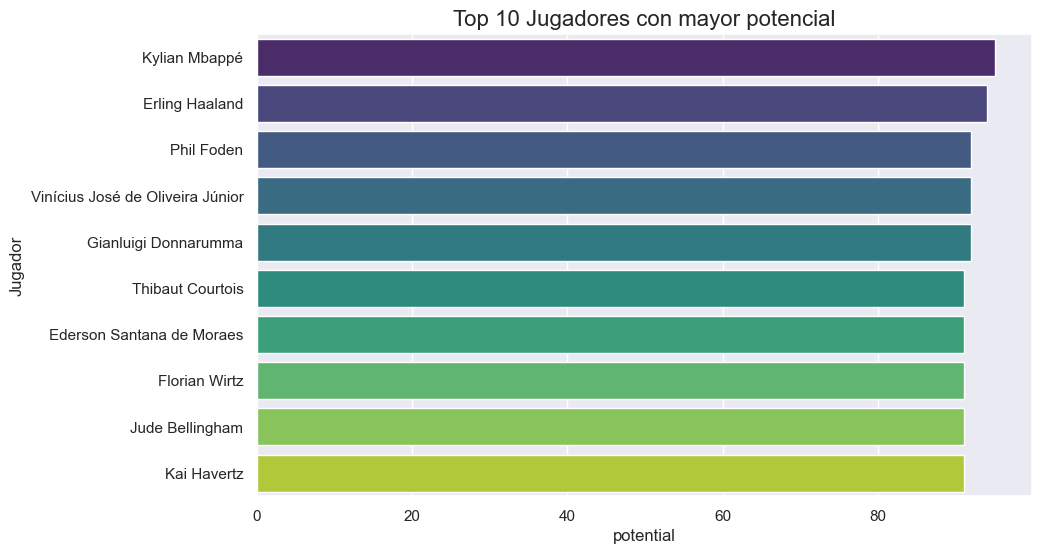

In [420]:
potential_top10 = df_skills.sort_values(by='potential', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='potential', y='name', data=potential_top10, palette='viridis')
plt.title('Top 10 Jugadores con mayor potencial', fontsize=16)
plt.xlabel('potential', fontsize=12)
plt.ylabel('Jugador', fontsize=12)
plt.show()


En potencial ya vemos cambios un poco más significativos, ya que, aunque haya jugadores de los que tienen mejor overall y valor de mercado, también aparecen jugadores menos conocidos que deben tener un potencial a futuro bastante bueno. Suelen ser además jugadores jóvenes, por debajo de los 25 años

In [421]:
min_potential = df_skills[df_skills['potential'] == df_skills['potential'].min()]
min_potential

name  overall  potential  value_million_euro    position  \
93735  Dorian Ciezkowski       51         58                 0.1  Goalkeeper   
93783      Edoardo Corvi       51         58                 0.1  Goalkeeper   

      nationality  age  height          team formation  ... penalties  \
93735      Poland   21     191  US Cremonese     3-4-3  ...         0   
93783       Italy   21     183         Parma     4-3-3  ...         0   

       mentality  marking  standing_tackle  sliding_tackle  goalkeeper_diving  \
93735         30        0                0               0                 48   
93783         25        0                0               0                 58   

       goalkeeper_handling  goalkeeper_kicking  goalkeeper_positioning  \
93735                   55                  49                      47   
93783                   56                  50                      46   

       goalkeeper_reflexes  
93735                   55  
93783                   49  

[2 rows x 51 columns]

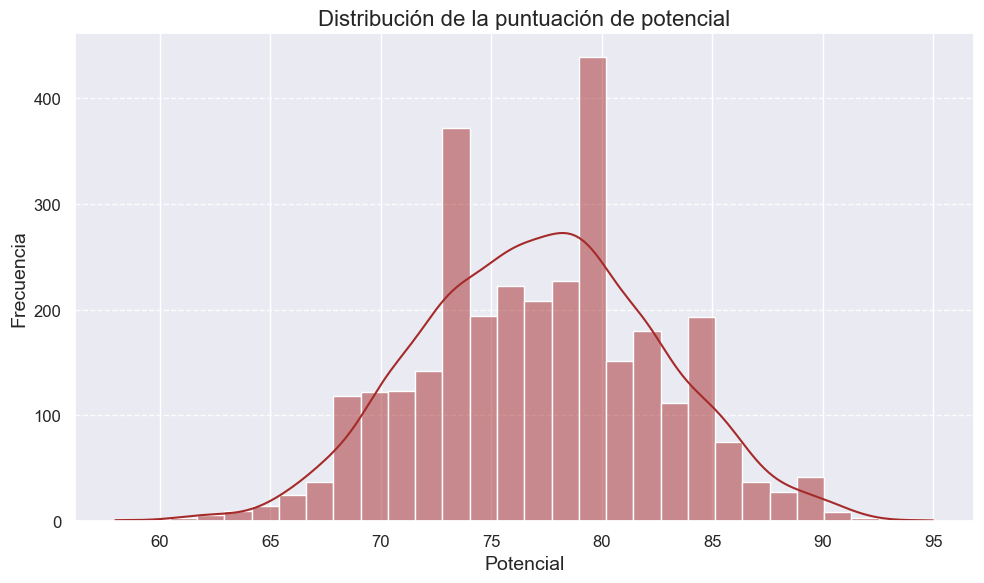

In [422]:
plt.figure(figsize=(10, 6))
sns.histplot(df_skills['potential'], kde=True, bins=30, color='brown')
plt.title('Distribución de la puntuación de potencial', fontsize=16)
plt.xlabel('Potencial', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

El skewness y la distribución nos muestran que es una distribución muy simétrica, con una pequeña tendencia a la izquierda, pero mínima. Los datos parecen compensados, tiene una media de 77.21 y el valor más habitual es 79 sobre 100. Por ello presenta pocos outliers y estos son menores que el umbral inferior: 3 jugadores por debajo del umbral de atípicos inferior (menor a 61 puntos sobre 100)

In [423]:
skewness_potential = df_skills['potential'].skew()
skewness_potential

np.float64(-0.00681930968633671)

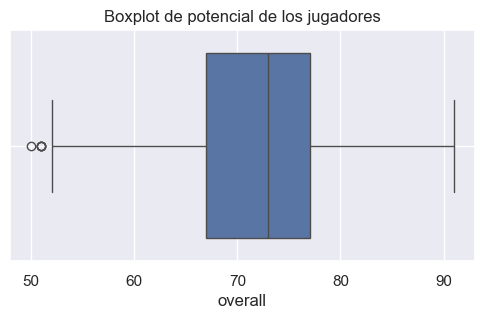

In [424]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df_skills['overall'])
plt.grid(True)
plt.title('Boxplot de potencial de los jugadores')
plt.show()

In [425]:
Q1_potential = df_skills['potential'].quantile(0.25)
Q3_potential = df_skills['potential'].quantile(0.75)
IQR_potential = Q3_potential - Q1_potential

lower_limit_potential = Q1_potential - 1.5 * IQR_potential
print(f"Valor en puntos: {lower_limit_potential} puntos o menos")

outliers_below_potential = df_skills[df_skills['potential'] < lower_limit_potential]
print(f"Cantidad de outliers por debajo del límite inferior: {len(outliers_below_potential)}")

Valor en puntos: 61.0 puntos o menos
Cantidad de outliers por debajo del límite inferior: 3


PIE (1:RIGHT, 0:LEFT)

In [426]:
preferred_foot = df_skills['preferred_foot'].value_counts()
preferred_foot

preferred_foot
1    2291
0     806
Name: count, dtype: int64

In [427]:
percentages = preferred_foot / preferred_foot.sum() * 100
percentages

preferred_foot
1    73.974814
0    26.025186
Name: count, dtype: float64

Observamos que hay una tendencia mucho más grande a que los jugadores sean diestros que zurdos. Aproximadamente 3 de cada 4 jugadores son diestros (3/4)

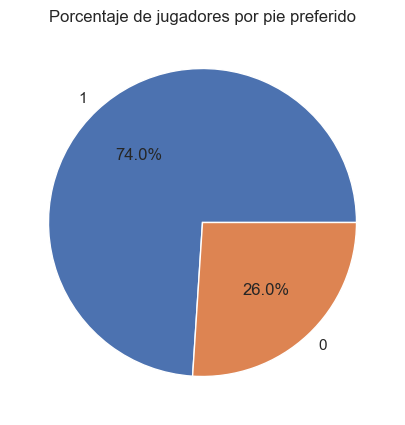

In [428]:
plt.figure(figsize=(10, 5))
plt.pie(preferred_foot.values, labels=preferred_foot.index, autopct='%1.1f%%')
plt.title('Porcentaje de jugadores por pie preferido')
plt.show()

NACIONALIDAD

In [429]:
nationality = df_skills['nationality'].value_counts()
nationality

nationality
Spain         462
France        418
Germany       309
Italy         278
England       277
             ... 
Mauritania      1
Andorra         1
Moldova         1
Singapore       1
Madagascar      1
Name: count, Length: 107, dtype: int64

Nacionalidades más habituales en las 5 grandes ligas europeas: españoles, franceses, alemanes, italianos e ingleses, que corresponden con las ligas de origen, aunque pueden estar jugando en una de estas ligas diferentes a su país. Cabe destacar, fuera de los nacionales de las ligas, la cantidad de jugadores brasileños, portugueses, argentinos, holandeses, senegaleses, belgas, polacos y daneses

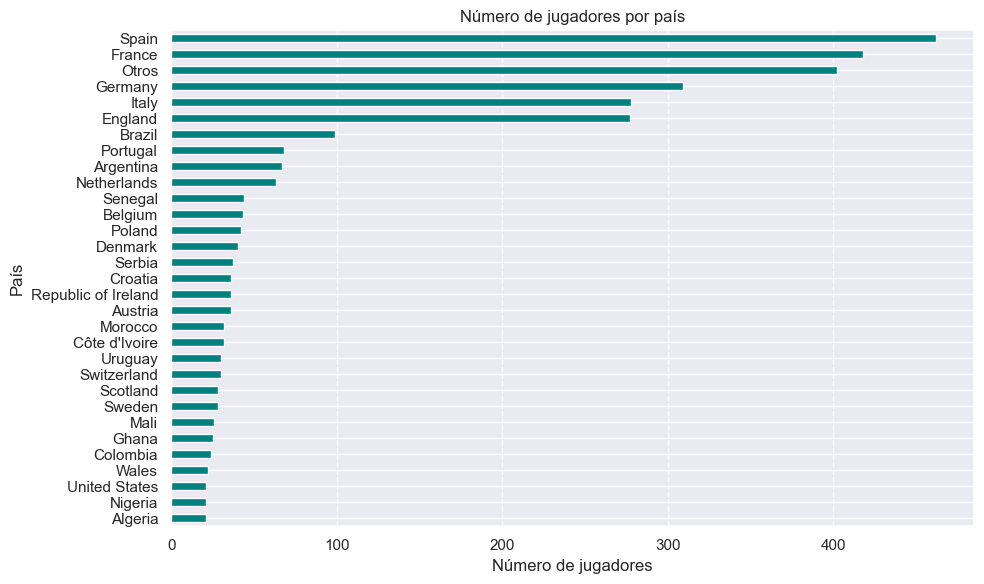

In [430]:
nationality = df_skills['nationality'].value_counts()

filtered_nationality = nationality[nationality > 20]
filtered_nationality['Otros'] = nationality[nationality <= 20].sum()

plt.figure(figsize=(10, 6))
filtered_nationality.sort_values().plot(kind='barh', color='teal')
plt.title('Número de jugadores por país')
plt.xlabel('Número de jugadores')
plt.ylabel('País')
plt.grid(axis='x', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


Graficamos también países con pocos jugadores, pero representados en las 5 grandes ligas

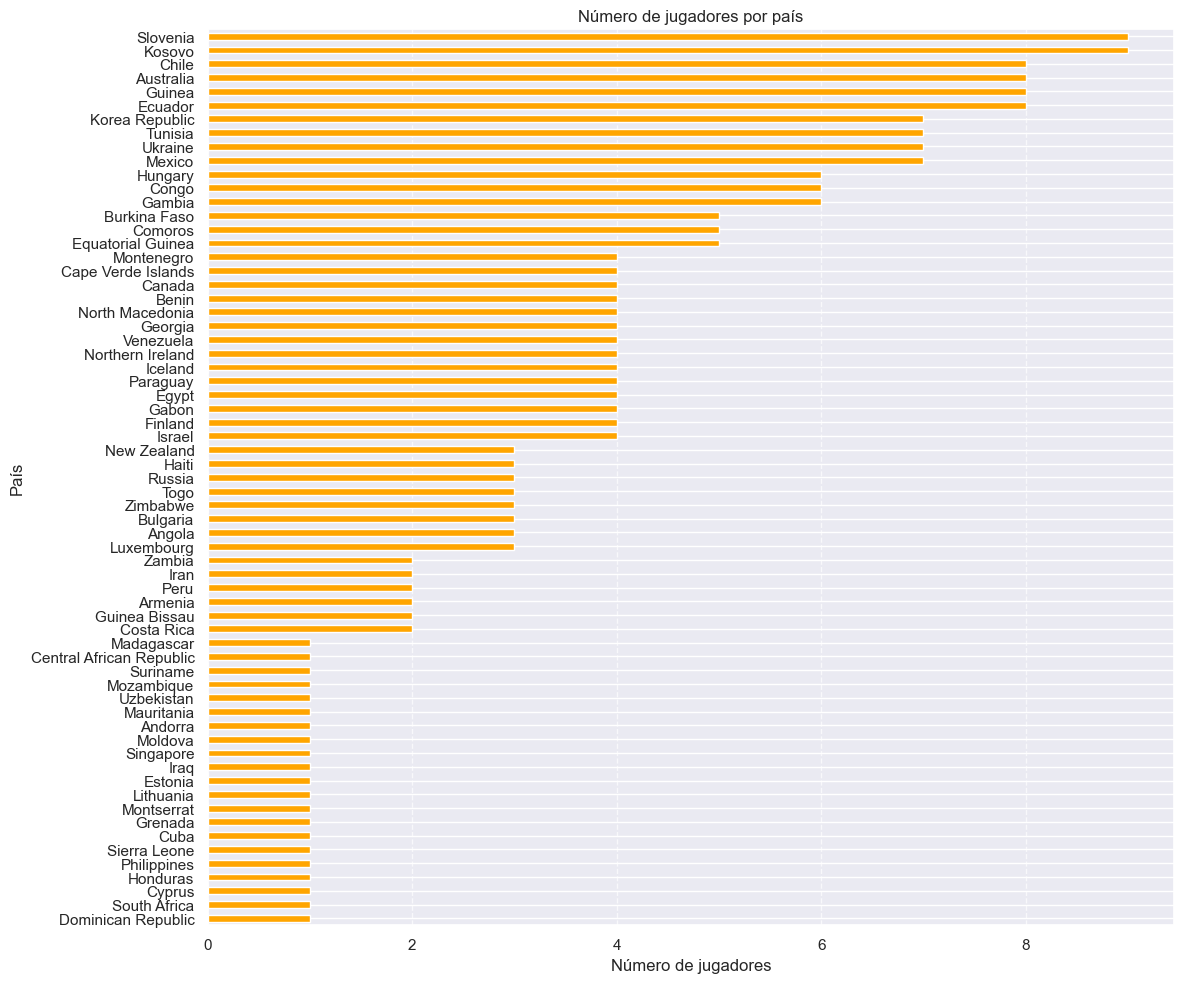

In [431]:
nationality = df_skills['nationality'].value_counts()

least_nationality = nationality[nationality < 10]

plt.figure(figsize=(12, 10))
least_nationality.sort_values().plot(kind='barh', color='orange')
plt.title('Número de jugadores por país')
plt.xlabel('Número de jugadores')
plt.ylabel('País')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

POSICION


In [432]:
df_skills['position'].value_counts().sum()

np.int64(3097)

In [433]:
df_skills['position'].describe().to_frame().T

count unique         top  freq
position  3097      6  Midfielder  1102

La posición más habitual es la de centrocampista ('Midfielder'), con una frecuencia de 1103 (35.6%). Aproximadamente un tercio de los jugadores. También es frecuente la posición de defensa y lateral (que juntos conformarían toda la defensa). Sumando los defensas centrales y los laterales sumarían casi un porcentaje como el de centrocampistas, aunque algo inferior (33.6%).

Tras estos, estarían los delanteros y los porteros. Para estos últimos hay que tener en cuenta que de 11 jugadores solo puede jugar un portero y en cada plantilla suele haber únicamente 2 o 3 porteros. Por último tenemos a los extremos, la posición con menos jugadores con diferencia, que muchas veces están considerados simplemente como delanteros y en conjunto se contabilizan como jugadores de ataque. Los delanteros, como término genérico lo conformarían delanteros y extremos, con lo que su porcentaje subiría (19%), pero no llegaría a los números de centrocampistas y defensas.

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\1736384541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_skills, x='position', order=df_skills['position'].value_counts().index, palette='magma')


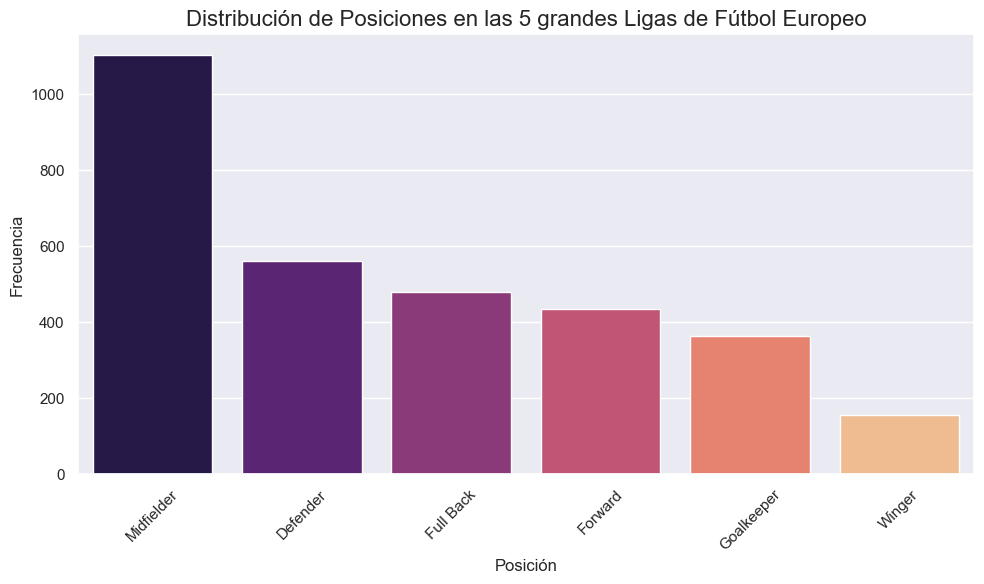

In [434]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_skills, x='position', order=df_skills['position'].value_counts().index, palette='magma')

plt.title('Distribución de Posiciones en las 5 grandes Ligas de Fútbol Europeo', fontsize=16)
plt.xlabel('Posición')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.yticks()

plt.tight_layout()
plt.show()

Nos ha parecido importante analizar la media por cada habilidad del conjunto de jugadores y verlo graficamente

In [435]:
df_skills[['pace_total', 'shooting_total', 'passing_total','dribbling_total', 'defending_total','physicality_total', 
        'crossing','finishing', 'heading_accuracy', 'short_passing', 'long_passing','ball_control','acceleration',
        'sprint_speed', 'balance','shot_power', 'strength', 'long_shots','aggression', 'interceptions',
        'positioning', 'vision', 'penalties','mentality', 'marking']].describe().round(3)

pace_total  shooting_total  passing_total  dribbling_total  \
count    3097.000        3097.000       3097.000         3097.000   
mean       61.505          58.877         63.927           60.471   
std        24.901          14.518         10.135           23.873   
min         0.000          18.000         29.000            0.000   
25%        58.000          49.000         57.000           59.000   
50%        69.000          62.000         65.000           68.000   
75%        77.000          70.000         71.000           74.000   
max        97.000          91.000         93.000           92.000   

       defending_total  physicality_total  crossing  finishing  \
count         3097.000           3097.000  3097.000   3097.000   
mean            50.635             67.588    52.675     48.882   
std             24.850             10.007    23.447     24.106   
min              0.000             30.000     0.000      0.000   
25%             34.000             61.000    42.000     33.000   
50%             59.000             69.000    59.000     55.000   
75%             71.000             75.000    69.000     68.000   
max             91.000             91.000    94.000     94.000   

       heading_accuracy  short_passing  ...  shot_power  strength  long_shots  \
count          3097.000       3097.000  ...    3097.000  3097.000    3097.000   
mean             54.327         61.460  ...      63.505    67.068      49.994   
std              22.984         23.925  ...      13.099    12.604      23.917   
min               0.000          0.000  ...      20.000    25.000       0.000   
25%              48.000         61.000  ...      54.000    59.000      36.000   
50%              60.000         69.000  ...      65.000    68.000      57.000   
75%              70.000         75.000  ...      74.000    76.000      69.000   
max              91.000         93.000  ...      94.000    96.000      91.000   

       aggression  interceptions  positioning    vision  penalties  mentality  \
count    3097.000       3097.000     3097.000  3097.000   3097.000   3097.000   
mean       56.853         49.667       53.560    59.471     48.405     64.569   
std        24.517         26.138       24.396    14.810     21.495     12.606   
min         0.000          0.000        0.000    10.000      0.000     20.000   
25%        49.000         29.000       42.000    50.000     41.000     58.000   
50%        64.000         59.000       61.000    62.000     52.000     67.000   
75%        74.000         71.000       71.000    71.000     63.000     74.000   
max        95.000         91.000       96.000    94.000     92.000     94.000   

        marking  
count  3097.000  
mean     49.736  
std      25.325  
min       0.000  
25%      32.000  
50%      58.000  
75%      70.000  
max      92.000  

[8 rows x 25 columns]

In [436]:
df_skills[['weak_foot_rating', 'skill_moves', 'attacking_work_rate',
 'defensive_work_rate']].describe().round(3)

weak_foot_rating  skill_moves  attacking_work_rate  defensive_work_rate
count          3097.000     3097.000             3097.000             3097.000
mean              3.060        2.451                1.289                1.154
std               0.703        1.122                0.549                0.512
min               1.000        0.000                0.000                0.000
25%               3.000        2.000                1.000                1.000
50%               3.000        3.000                1.000                1.000
75%               3.000        3.000                2.000                1.000
max               5.000        5.000                2.000                2.000

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\577573446.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_values.index, y=mean_values.values, palette='viridis')


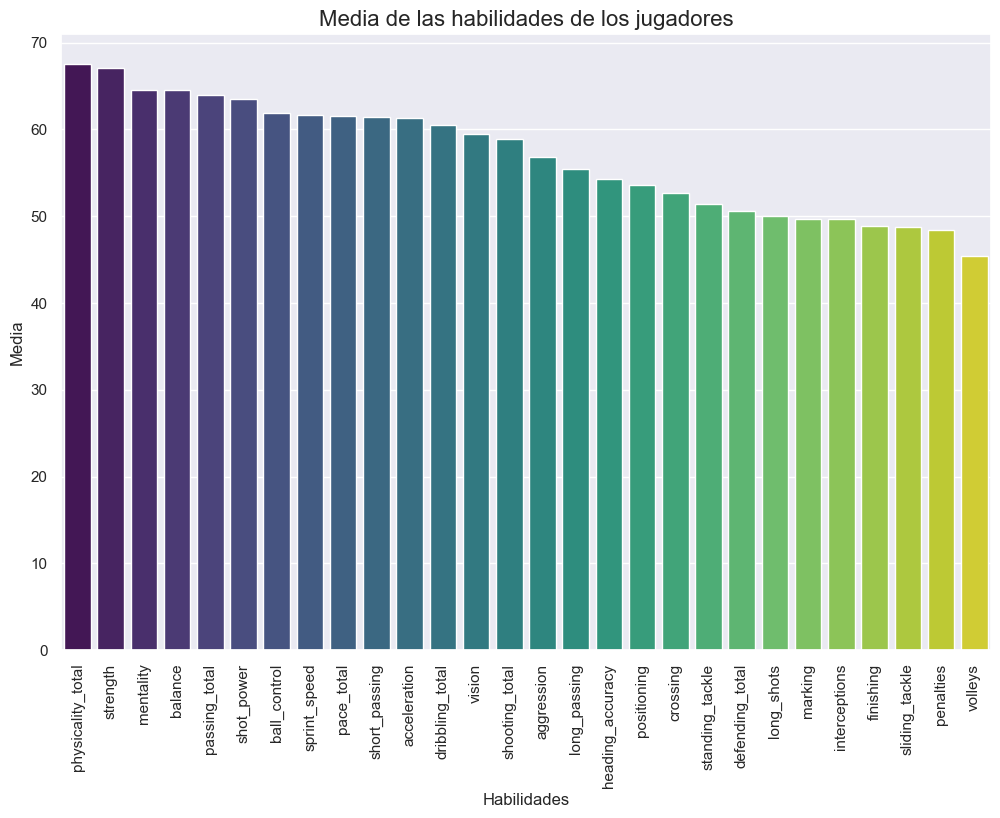

In [437]:
mean_values = df_skills[['pace_total', 'shooting_total', 'passing_total','dribbling_total', 'defending_total',
                        'physicality_total', 'crossing','finishing', 'heading_accuracy', 'short_passing', 'volleys',
                        'long_passing', 'ball_control','acceleration', 'sprint_speed', 'balance','shot_power',
                        'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision',
                        'penalties','mentality', 'marking', 'standing_tackle', 'sliding_tackle']].mean()

mean_values = mean_values.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=mean_values.index, y=mean_values.values, palette='viridis')

plt.title('Media de las habilidades de los jugadores', fontsize=16)
plt.xlabel('Habilidades', fontsize=12)
plt.ylabel('Media', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Las habilidades con mayor media entre los futbolistas son: phisicality, strength, mentality, balance y pasing_total. Esto muestra la gran preparación física y mental de los jugadores profesionales. Por el contrario, las habilidades con menor media son: volleys, penaltis, sliding_tackle y finishing. Son habilidades de bastante definición (menos las entradas) y asociadas a delanteros con muy buena precisión, por lo que en el cómputo general (contando todas las posiciones) es normal que baje la media

CONCLUSIONES DEL ANÁLISIS DE VARIABLES:

La valoración general de los jugadores tiene una distribución equilibrada, con una media de 71.7 puntos, teniendo valores tanto más bajos como más altos. Hay 43 jugadores con una valoración general superior a 86.1 sobre 100, por lo que los podemos clasificar como futbolistas muy destacados o de élite. Además, hay una gran cantidad de outliers para el potencial, lo que sugiere que hay jugadores emergentes con un gran futuro por delante, en ascenso en su carrera profesional.

El valor de mercado de los jugadores muestra una gran diferencia entre valores, con outliers mayores a 25 millones de euros, pero habiendo juagdores con valor de mercado y transacciones mucho mayores que superan esta cifra. También hay bastantes jugadores con salarios en cifras superiores a los 7 millones de euros anuales, haciendo que sean los que mejor cobran. Aún así, hay que resaltar que la mayoría de los jugadores se encuentran en rangos salariales y de valores de mercado moderados e incluso bajos, de ahí los outliers altos en estas categorías.

En cuanto a las características demográficas, la media de edad de los jugadores en torno a los 25 años, lo que refleja una gran concentración de futbolistas jóvenes. A partir de los 37 años cada vez hay menos futbolistas, lo que muestra la tendencia en el fútbol profesional a preferir la juventud. En cuanto a la altura, la media es de 182.75 cm muestra que los jugadores tienen una tendencia a ser bastante altos.

Analizando las habilidades técnicas y físicas, se ve que los futbolistas de élite tienen un alto nivel en aspectos físicos y mentales. Características como "phisicality", "strength" y "mentality" son algunas de las más altas, lo que nos indica la importancia de la preparación física y mental en el rendimiento de un futbolista. 

En cuanto a las posiciones, los centrocampistas son los jugadores más representados, con un 35.6% del total, seguidos de los defensas con un 33.6%. En cambio, los porteros y extremos son posiciones menos comunes. El caso de los porteros es debido a que sólo un portero es titular y en la plantilla suele haber entre 2 y 3 porteros. Aproximadamente el 75% de los jugadores son diestros, lo que indica una gran diferencia y tendencia en el fútbol a ser diestro, aunque luego muchos jugadores manejen bien ambas piernas.

____

RELACIONES ENTRE VARIABLES

In [438]:
df_cuantitativo = df_skills[['age', 'overall', 'potential', 'value_million_euro', 'height',
       'wage_million_euro', 'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total','defending_total', 'physicality_total']]

<Axes: >

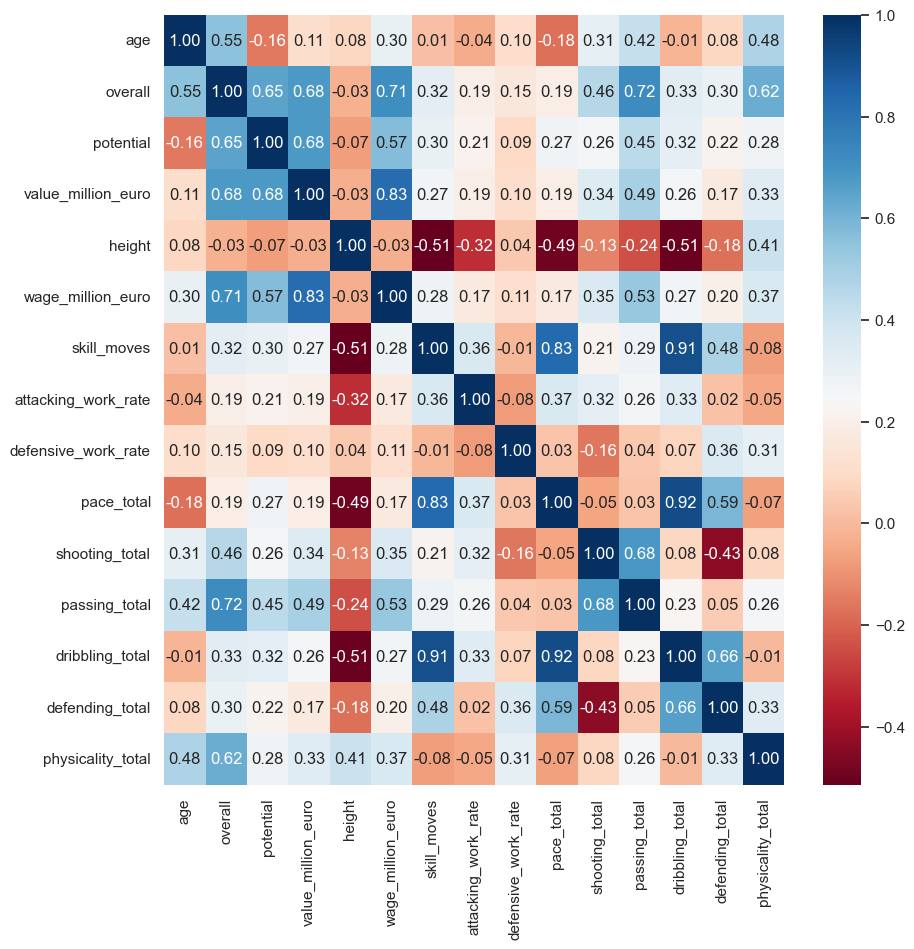

In [439]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cuantitativo.corr(),annot=True,fmt='.2f',cmap='RdBu')

Analizando la correlaciones vemos que la edad tiene una relación alta con la puntuación general (overall) y una relación moderada con el físico total y, en menor medida, con el disparo y el salario. Por ello, cuando va aumentando la edad de los jugadores tienden a aumentar estas habilidades. 

La puntuación general y el potencial están estrechamente relacionados y cuando sube una suele subir la otra. El overall tiene bastante relación positiva también con el salario, el valor de mercado, el pase y el físico. El potencial, por su parte, se relaciona también con el valor de mercado, el salario y el pase.

El valor de mercado y el salario tienen correlaciones bastante parecidas y entre ellas están muy relacionadas, por lo que al subir el valor de mercado sube el salario, y viceversa. Estas dos variables sobre todo están correlacionadas con: overall y potential (como hemos comentado) y el pase. Tienen relación moderada con el disparo y el físico.

La altura arroja datos interesantes, ya que tiene correlaciones de moderadas a altas pero en general negativas. Las más altas son con los movimientos habilidosos (skill moves), el ritmo (pace total), y el regate (dribbling total), por lo que cuando aumenta la estatura tiende a disminuir la habilidad, el ritmo y el regate. Únicamente tiene una relación positiva (pero moderada) con el físico.

Los movimientos habilidosos se relacionan altamente con el ritmo y el regate y, a su vez, estos dos el están muy relacionado entre ellos. El disparo y el pase están también bastante relacionados y el regate y la defensa, que puede estar asociado a las posiciones de lateral (posición defensiva, pero con tendencia al ataque por banda). Por último cabe destacar la relación negativa moderada entre el disparo y el trabajo defensivo, que van por caminos opuestos. 

In [440]:
df_correlaciones = df_cuantitativo.corr()
df_correlaciones = df_correlaciones.where(np.triu(np.ones(df_correlaciones.shape)).astype(bool))
df_correlaciones = df_correlaciones.stack().reset_index()
df_correlaciones.columns = ['Row','Column','Value']
df_correlaciones = df_correlaciones[df_correlaciones['Row']!=df_correlaciones['Column']]
df_correlaciones.head()

Row              Column     Value
1  age             overall  0.554202
2  age           potential -0.157703
3  age  value_million_euro  0.109238
4  age              height  0.078838
5  age   wage_million_euro  0.297049

Vemos la colinealidad entre variables y no tenemos colinealidad mayor a 0.9. Si bajamos a 0.85 solo tenemos colinealidad entre la puntuación total de pase y la puntuación total de dribbling (regate), pero en sí no son dos variables que tengan dependencia una de la otra

In [441]:
df_colinealidad = df_correlaciones[abs(df_correlaciones['Value'])>0.85]
df_colinealidad

Row           Column     Value
81   skill_moves  dribbling_total  0.910231
102   pace_total  dribbling_total  0.918952

In [442]:
df_cuantitativo2 = df_skills[['age', 'overall', 'potential', 'value_million_euro','height',
       'wage_million_euro', 'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total','defending_total', 
       'physicality_total','crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'balance','shot_power',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning','vision', 'penalties',
       'mentality', 'marking', 'standing_tackle','sliding_tackle']]

In [443]:
df_correlaciones_skills = df_cuantitativo2.corr()
df_correlaciones_skills = df_correlaciones_skills.where(np.triu(np.ones(df_correlaciones_skills.shape)).astype(bool))
df_correlaciones_skills = df_correlaciones_skills.stack().reset_index()
df_correlaciones_skills.columns = ['Row','Column','Value']
df_correlaciones_skills = df_correlaciones_skills[df_correlaciones_skills['Row']!=df_correlaciones_skills['Column']]
df_correlaciones_skills.head()

Row              Column     Value
1  age             overall  0.554202
2  age           potential -0.157703
3  age  value_million_euro  0.109238
4  age              height  0.078838
5  age   wage_million_euro  0.297049

Cuando hacemos la colinealidad con las habilidades sí que vemos bastante correlación entre algunas variables, por lo que hemos procedido a unir algunas que sean redundantes e incluso borrar otras.

In [444]:
df_colinealidad_skills = df_correlaciones_skills[abs(df_correlaciones_skills['Value'])>0.85]
df_colinealidad_skills

Row           Column     Value
213      skill_moves  dribbling_total  0.910231
216      skill_moves         crossing  0.853547
217      skill_moves        finishing  0.859112
219      skill_moves    short_passing  0.850173
220      skill_moves          volleys  0.852084
..               ...              ...       ...
674    interceptions   sliding_tackle  0.969709
677      positioning        penalties  0.890583
698          marking  standing_tackle  0.969211
699          marking   sliding_tackle  0.964207
701  standing_tackle   sliding_tackle  0.986100

[70 rows x 3 columns]

Hay pares de variables muy correlacionadas, así que hemos decidido hacer una nueva columna juntando las dos con su media entre ellas. Es el caso de short_passing y long_passing, que pasa a llamarse 'passing'. Acceleration y sprint_speed se pasa a llamar 'speed' y hacemos la media también. Los dos tipos de tackles pasan a ser 'tackling' y con ese mismo tackling hacemos media con interceptions, ya que se trata de acciones defensivas (entradas e intercepciones)

In [445]:
df_skills['passing'] = df_skills[['short_passing', 'long_passing']].mean(axis=1)
df_skills['speed'] = df_skills[['acceleration', 'sprint_speed']].mean(axis=1)
df_skills['tackling'] = df_skills[['standing_tackle', 'sliding_tackle']].mean(axis=1)
df_skills['tackling'] = df_skills[['tackling', 'interceptions']].mean(axis=1)

df_skills.drop(['short_passing', 'long_passing', 'acceleration', 'sprint_speed', 'standing_tackle',
                'sliding_tackle', 'interceptions'], axis=1, inplace=True)


C:\Users\metal\AppData\Local\Temp\ipykernel_5676\2901394927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills['passing'] = df_skills[['short_passing', 'long_passing']].mean(axis=1)
C:\Users\metal\AppData\Local\Temp\ipykernel_5676\2901394927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills['speed'] = df_skills[['acceleration', 'sprint_speed']].mean(axis=1)
C:\Users\metal\AppData\Local\Temp\ipykernel_5676\2901394927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Eliminamos además las variables: volleys (no nos parece relevante), 'crossing' (muy redundante con passing y long_passing), 'marking' y 'tackling' (muy parecidas y redundantes con las otras variables de  habilidades defensivas)

In [446]:
df_skills.drop(['volleys', 'crossing', 'marking', 'tackling'], axis=1, inplace=True)

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\4234853992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills.drop(['volleys', 'crossing', 'marking', 'tackling'], axis=1, inplace=True)


In [447]:
df_cuantitativo2 = df_skills[['overall','finishing', 'heading_accuracy','ball_control','balance','shot_power',
                            'strength', 'long_shots','aggression', 'positioning','vision','penalties',
                            'mentality', 'speed', 'passing']]

<Axes: >

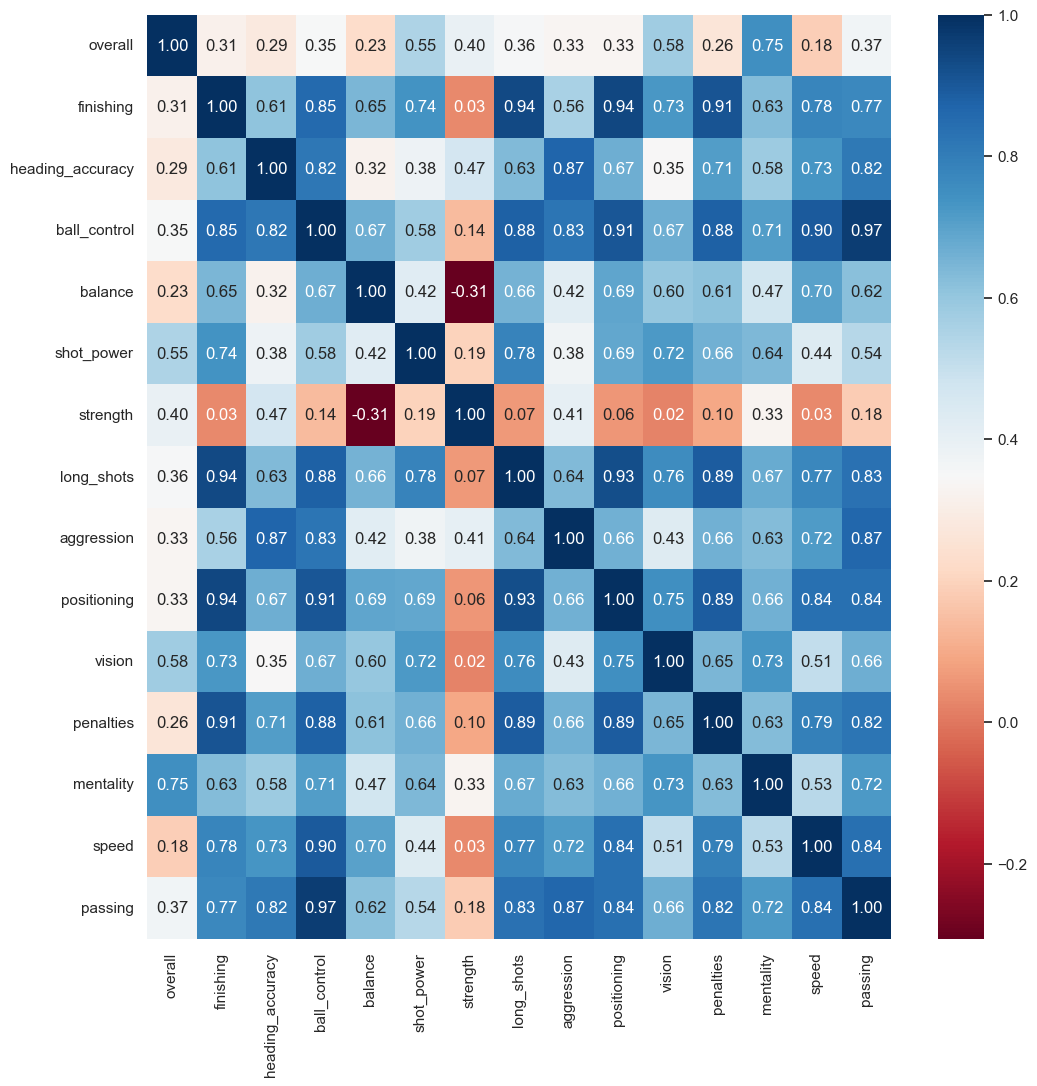

In [448]:
plt.figure(figsize=(12,12))
sns.heatmap(df_cuantitativo2.corr(),annot=True,fmt='.2f',cmap='RdBu')

Para las habilidades de jugadores específicas vemos que existen mucha correlación entre casi todas y algunas con valores bastante altos, por lo que después haremos une estudio de colinealidad. Aún así, es normal que haya bastante correlación entre habilidades de futbolistas profesionales, ya que aunque sean mejores en ciertos aspectos son personas preparadas para desenvolverse bien en todos los ámbitos del juego.

La edad sólo está bastante relacionada con la mentalidad y moderadamente con la visión de juego y la fuerza de disparo, por lo que al subir la edad tienden a subir estas habilidades. La finalización tiene correlación significativa con los disparos lejanos, el posicionamiento y los penaltis. La precisión de cabeceo se relaciona mucho con el control de balón y la agresividad, que es un aspecto con mucho contacto físico entre futbolistas.

La fuerza es la variable con menos correlación con el resto, menos con la agresividad, la mentalidad y el cabeceo. Como decimos, todos estos aspectos conllevan interacción física, por lo que hay tendencia a ser más fuertes, más agresivos y participar en jugadas de contacto como cabeceos. Además tiene una correlación moderada y negativa con el equilibrio (balance), por lo que a más fuerza parece haber menos estabilidad del jugador. 

El resto están bastante correlacionadas, sobre todo el pase con el resto, los disparos lejanos y el posicionamiento.

In [449]:
df_correlaciones_skills = df_cuantitativo2.corr()
df_correlaciones_skills = df_correlaciones_skills.where(np.triu(np.ones(df_correlaciones_skills.shape)).astype(bool))
df_correlaciones_skills = df_correlaciones_skills.stack().reset_index()
df_correlaciones_skills.columns = ['Row','Column','Value']
df_correlaciones_skills = df_correlaciones_skills[df_correlaciones_skills['Row']!=df_correlaciones_skills['Column']]
df_correlaciones_skills.head()

Row            Column     Value
1  overall         finishing  0.314371
2  overall  heading_accuracy  0.285060
3  overall      ball_control  0.348322
4  overall           balance  0.228884
5  overall        shot_power  0.546058

Si bien seguimos teniendo colinealidad con alguna variable, no consideramos que tengan una relación directa o sean dependientes. Es el caso de finishing con long_shots (finalización y disparos lejanos), finishing y positioning (finalización y posicionamiento), ball_control y passing (control de balón y pase) y long_shots y positioning (disparos lejanos y posicionamiento)

In [450]:
df_colinealidad_skills = df_correlaciones_skills[abs(df_correlaciones_skills['Value'])>0.9]
df_colinealidad_skills

Row       Column     Value
21     finishing   long_shots  0.935276
23     finishing  positioning  0.941395
25     finishing    penalties  0.909819
48  ball_control  positioning  0.906802
53  ball_control      passing  0.965265
86    long_shots  positioning  0.928125

Las variables para la posición de portero sí tienen colinealidad entre ellas al ser tan pocas y estar solo asociadas a esa posición. En cualquier caso, revisando las varaibles, ninguna indica una redundancia de datos

In [451]:
df_goalkeepers = df_skills[['goalkeeper_handling', 'goalkeeper_kicking', 'goalkeeper_positioning', 'goalkeeper_reflexes']]

In [452]:
df_correlaciones_goalkeepers = df_goalkeepers.corr()
df_correlaciones_goalkeepers = df_correlaciones_goalkeepers.where(np.triu(np.ones(df_correlaciones_goalkeepers.shape)).astype(bool))
df_correlaciones_goalkeepers = df_correlaciones_goalkeepers.stack().reset_index()
df_correlaciones_goalkeepers.columns = ['Row','Column','Value']
df_correlaciones_goalkeepers = df_correlaciones_goalkeepers[df_correlaciones_goalkeepers['Row']!=df_correlaciones_goalkeepers['Column']]
df_correlaciones_goalkeepers.head()

Row                  Column     Value
1  goalkeeper_handling      goalkeeper_kicking  0.996855
2  goalkeeper_handling  goalkeeper_positioning  0.998678
3  goalkeeper_handling     goalkeeper_reflexes  0.998555
5   goalkeeper_kicking  goalkeeper_positioning  0.996262
6   goalkeeper_kicking     goalkeeper_reflexes  0.996176

In [453]:
df_colinealidad_goalkeepers = df_correlaciones_goalkeepers[abs(df_correlaciones_goalkeepers['Value'])>0.8]
df_colinealidad_goalkeepers

Row                  Column     Value
1     goalkeeper_handling      goalkeeper_kicking  0.996855
2     goalkeeper_handling  goalkeeper_positioning  0.998678
3     goalkeeper_handling     goalkeeper_reflexes  0.998555
5      goalkeeper_kicking  goalkeeper_positioning  0.996262
6      goalkeeper_kicking     goalkeeper_reflexes  0.996176
8  goalkeeper_positioning     goalkeeper_reflexes  0.998572

In [454]:
df_skills.to_csv('data/skills_resultado.csv', index=False)

___

RELACIONES CON EDAD

In [455]:
df_skills['age_group'] = pd.cut(df_skills['age'], bins=[14, 19, 24, 29, 34, 40], 
                         labels=['15-19', '20-24', '25-29', '30-34', '35-40'])

columns_to_analyze = ['overall', 'value_million_euro', 'wage_million_euro', 'pace_total', 
                      'physicality_total', 'vision', 'strength', 'mentality']

grouped_by_age = df_skills.groupby('age_group')[columns_to_analyze].describe()
grouped_by_age

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\520111247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skills['age_group'] = pd.cut(df_skills['age'], bins=[14, 19, 24, 29, 34, 40],
C:\Users\metal\AppData\Local\Temp\ipykernel_5676\520111247.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_age = df_skills.groupby('age_group')[columns_to_analyze].describe()


overall                                                      \
            count       mean       std   min   25%   50%    75%   max   
age_group                                                               
15-19       357.0  62.254902  5.581823  50.0  59.0  61.0  65.00  84.0   
20-24      1194.0  69.880235  6.756194  51.0  65.0  70.0  75.00  91.0   
25-29       982.0  75.015275  5.160500  56.0  72.0  75.0  79.00  89.0   
30-34       478.0  75.769874  5.121314  61.0  72.0  75.0  79.00  91.0   
35-40        86.0  75.534884  5.967949  62.0  72.0  75.0  79.75  90.0   

          value_million_euro             ... strength       mentality  \
                       count       mean  ...      75%   max     count   
age_group                                ...                            
15-19                  357.0   2.459986  ...    66.00  91.0     357.0   
20-24                 1194.0   9.031595  ...    74.75  96.0    1194.0   
25-29                  982.0  12.587205  ...    78.00  95.0     982.0   
30-34                  478.0  10.033305  ...    79.00  95.0     478.0   
35-40                   86.0   3.331105  ...    80.00  90.0      86.0   

                                                               
                mean        std   min   25%   50%   75%   max  
age_group                                                      
15-19      53.551821  11.190924  21.0  46.0  54.0  61.0  82.0  
20-24      61.897822  12.619439  20.0  55.0  64.0  71.0  88.0  
25-29      68.516293  10.635814  23.0  64.0  70.0  75.0  94.0  
30-34      70.497908   9.990719  30.0  65.0  72.0  77.0  92.0  
35-40      69.372093  12.323146  30.0  63.0  70.0  78.5  92.0  

[5 rows x 64 columns]

In [456]:
cols = list(df_skills.columns)
cols.remove('age_group')
cols.insert(cols.index('age') + 1, 'age_group')
df_skills = df_skills[cols]

Edad y puntuación total

In [457]:
overall_age = df_skills[['age', 'overall']].groupby(by='age').mean()
overall_age.T

age             16         17         18         19         20      21  \
overall  58.333333  60.307692  60.827068  64.047337  65.331839  67.732   

age             22         23         24         25  ...      31    32  \
overall  70.508065  71.716157  73.877049  73.930328  ...  75.624  75.0   

age             33         34         35         36    37         38    39  \
overall  75.983333  75.591837  76.054054  75.576923  74.3  73.833333  75.0   

age        40  
overall  78.0  

[1 rows x 25 columns]

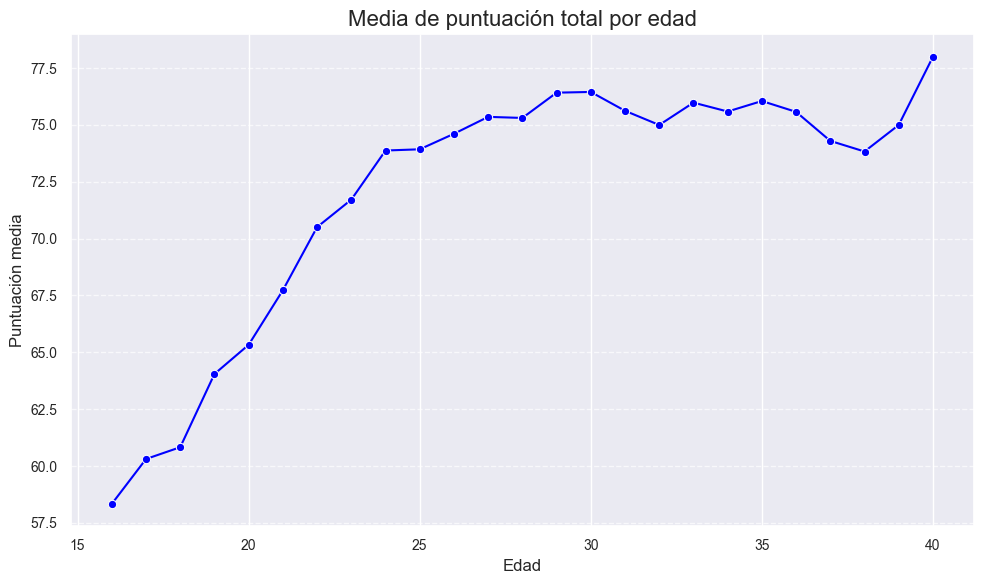

In [458]:
mean_overall_by_age = df_skills.groupby('age')['overall'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_overall_by_age, x='age', y='overall', marker='o', color='blue')
plt.title('Media de puntuación total por edad', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Puntuación media', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

La puntuación total sube según aumentan los años de los jugadores (tendencia ascendente) hasta regularse a la edad de 30 años, donde se mantiene en un rango bastante parecido. Hacia los 36 años hay un pequeño declive, que podría deberse a los últimos años de su carrera profesional, pero finalmente hay un repunte entre los 38 y 40 años. Esto se debe a que hay muy pocos jugadores con esa edad y al hacer la media el valor está sesgado, por lo que los pocos jugadores veteranos de esas edades son pocos y bastante buenos para su edad, cosa que explicaría además que sigan en activo

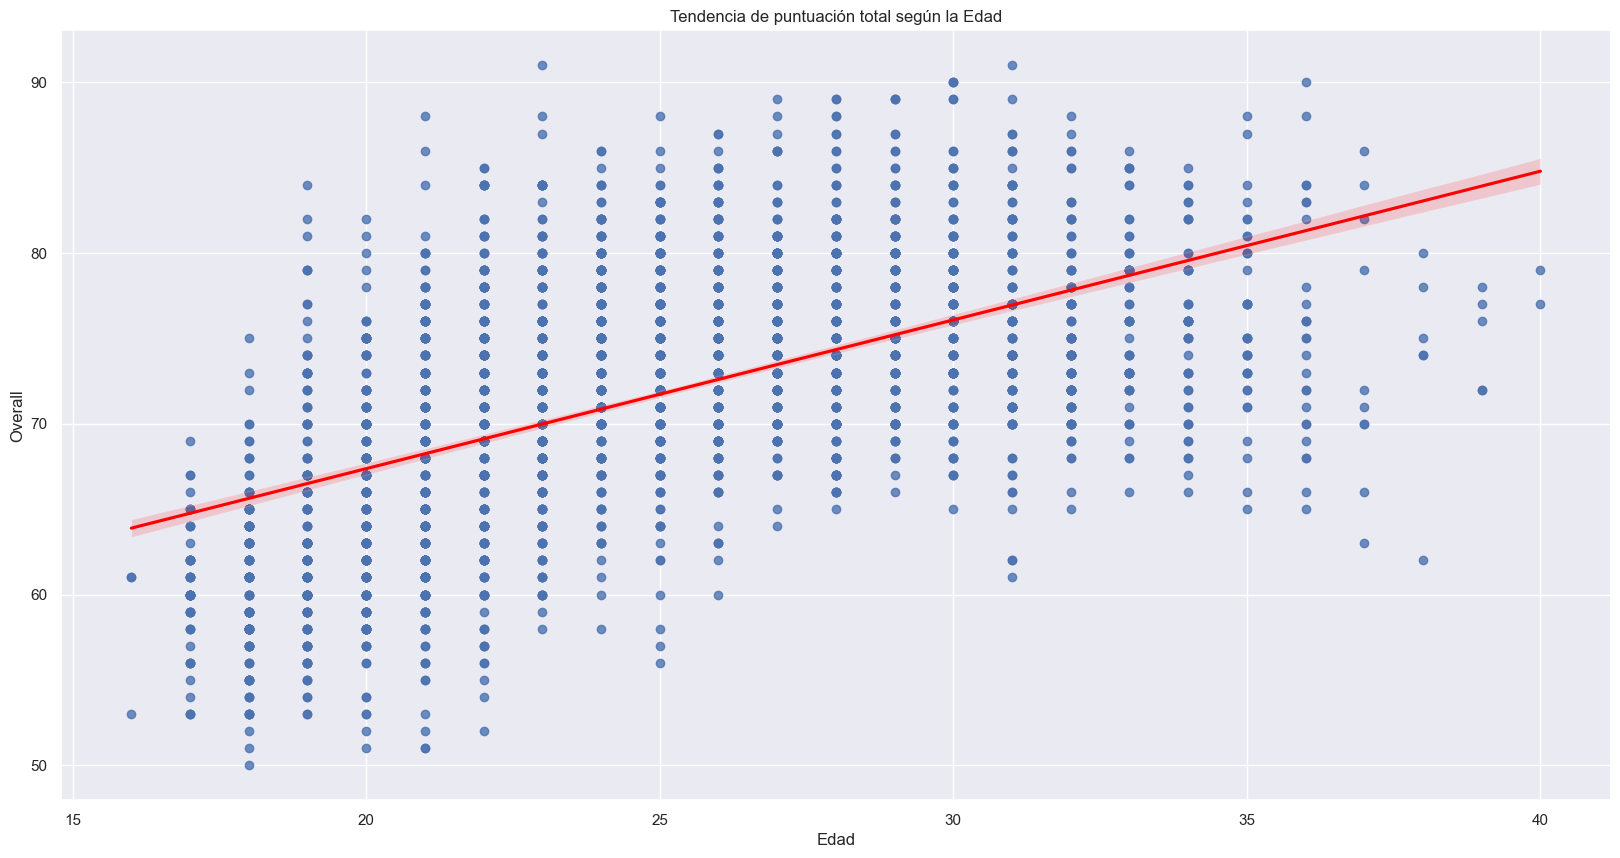

In [459]:
sns.regplot(data=df_skills, x='age', y='overall', line_kws={"color": "red"})
plt.title('Tendencia de puntuación total según la Edad')
plt.xlabel('Edad')
plt.ylabel('Overall')
plt.show()

In [460]:
df_skills[['age', 'overall']].describe().T

count       mean       std   min   25%   50%   75%   max
age      3097.0  24.962867  4.616309  16.0  21.0  24.0  28.0  40.0
overall  3097.0  71.695512  7.255664  50.0  67.0  73.0  77.0  91.0

Edad y potencial

In [461]:
age_potential = df_skills.groupby('age')['potential'].describe().T
age_potential

age      16         17          18          19          20          21  \
count   3.0  52.000000  133.000000  169.000000  223.000000  250.000000   
mean   79.0  79.653846   77.413534   77.828402   77.309417   77.508000   
std     2.0   4.143905    4.689007    5.206466    5.212446    5.971312   
min    77.0  68.000000   62.000000   67.000000   63.000000   58.000000   
25%    78.0  77.750000   75.000000   75.000000   74.000000   73.000000   
50%    79.0  80.000000   78.000000   78.000000   77.000000   78.000000   
75%    80.0  83.000000   80.000000   81.000000   81.000000   82.000000   
max    81.0  88.000000   90.000000   91.000000   89.000000   94.000000   

age            22          23         24          25  ...          31  \
count  248.000000  229.000000  244.00000  244.000000  ...  125.000000   
mean    78.552419   78.358079   78.97541   77.450820  ...   75.624000   
std      5.927811    5.421949    4.78503    5.328088  ...    5.652096   
min     61.000000   67.000000   64.00000   60.000000  ...   61.000000   
25%     75.000000   75.000000   76.00000   74.000000  ...   72.000000   
50%     79.000000   78.000000   79.00000   78.000000  ...   75.000000   
75%     82.250000   82.000000   82.00000   81.000000  ...   79.000000   
max     92.000000   95.000000   90.00000   91.000000  ...   91.000000   

age            32         33         34         35         36         37  \
count  105.000000  60.000000  49.000000  37.000000  26.000000  10.000000   
mean    75.000000  75.983333  75.591837  76.054054  75.576923  74.300000   
std      4.714952   4.724590   4.847329   5.359032   6.765637   7.902883   
min     65.000000  66.000000  66.000000  65.000000  65.000000  63.000000   
25%     72.000000  73.000000  72.000000  73.000000  70.250000  70.000000   
50%     74.000000  76.000000  76.000000  75.000000  75.000000  71.500000   
75%     78.000000  79.000000  79.000000  80.000000  81.000000  81.250000   
max     88.000000  86.000000  85.000000  88.000000  90.000000  86.000000   

age           38         39         40  
count   6.000000   5.000000   2.000000  
mean   73.833333  75.000000  78.000000  
std     6.274286   2.828427   1.414214  
min    62.000000  72.000000  77.000000  
25%    74.000000  72.000000  77.500000  
50%    74.500000  76.000000  78.000000  
75%    77.250000  77.000000  78.500000  
max    80.000000  78.000000  79.000000  

[8 rows x 25 columns]

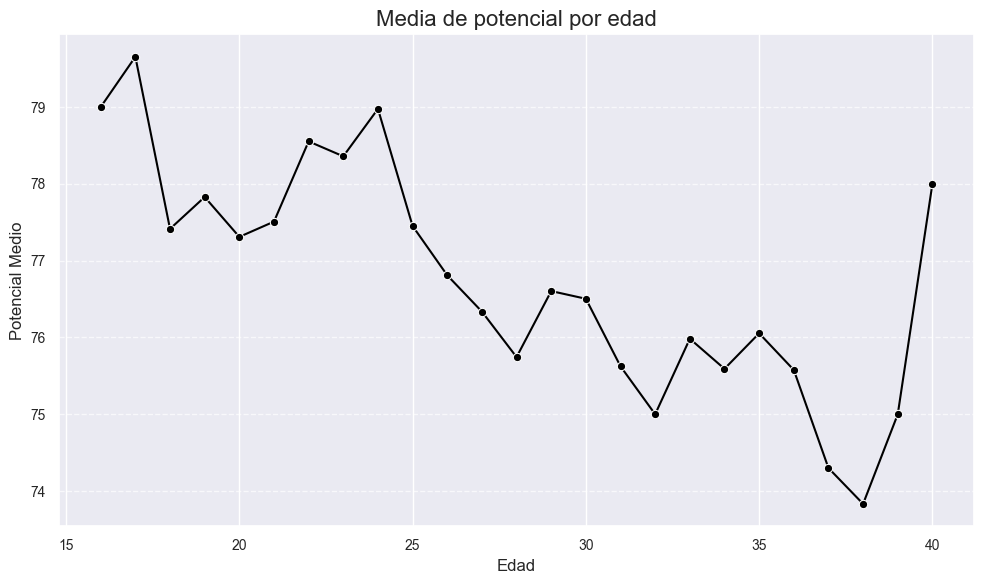

In [462]:
mean_potential_by_age = df_skills.groupby('age')['potential'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_potential_by_age, x='age', y='potential', marker='o', color='black')
plt.title('Media de potencial por edad', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Potencial Medio', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

El potencial promedio es más alto en los jugadores jóvenes (con 79 puntos a los 17 años) y comienza a disminuir poco a poco con la edad. Hay cierta estabilidad en el rango de edad de los 18 a los 25 años (con algún pico en los 24 años). Entre los 25 años y los 30 el potencial baja y se vuelve a estabilizar, aunque un poco más bajo, para finalmente decaer en los jugadores mayores a 35 años, con un repunte a los 40 años (por la baja cantidad de registros, que muestra una media algo sesgada). Todo esto muestra que los jugadores jóvenes suelen ser vistos como promesas y un futuro más prometeder que con una mediana edad, donde el potencial a futuro disminuye porque se van acercando a la retirada, como en el caso ya de los mayores de 30 años.

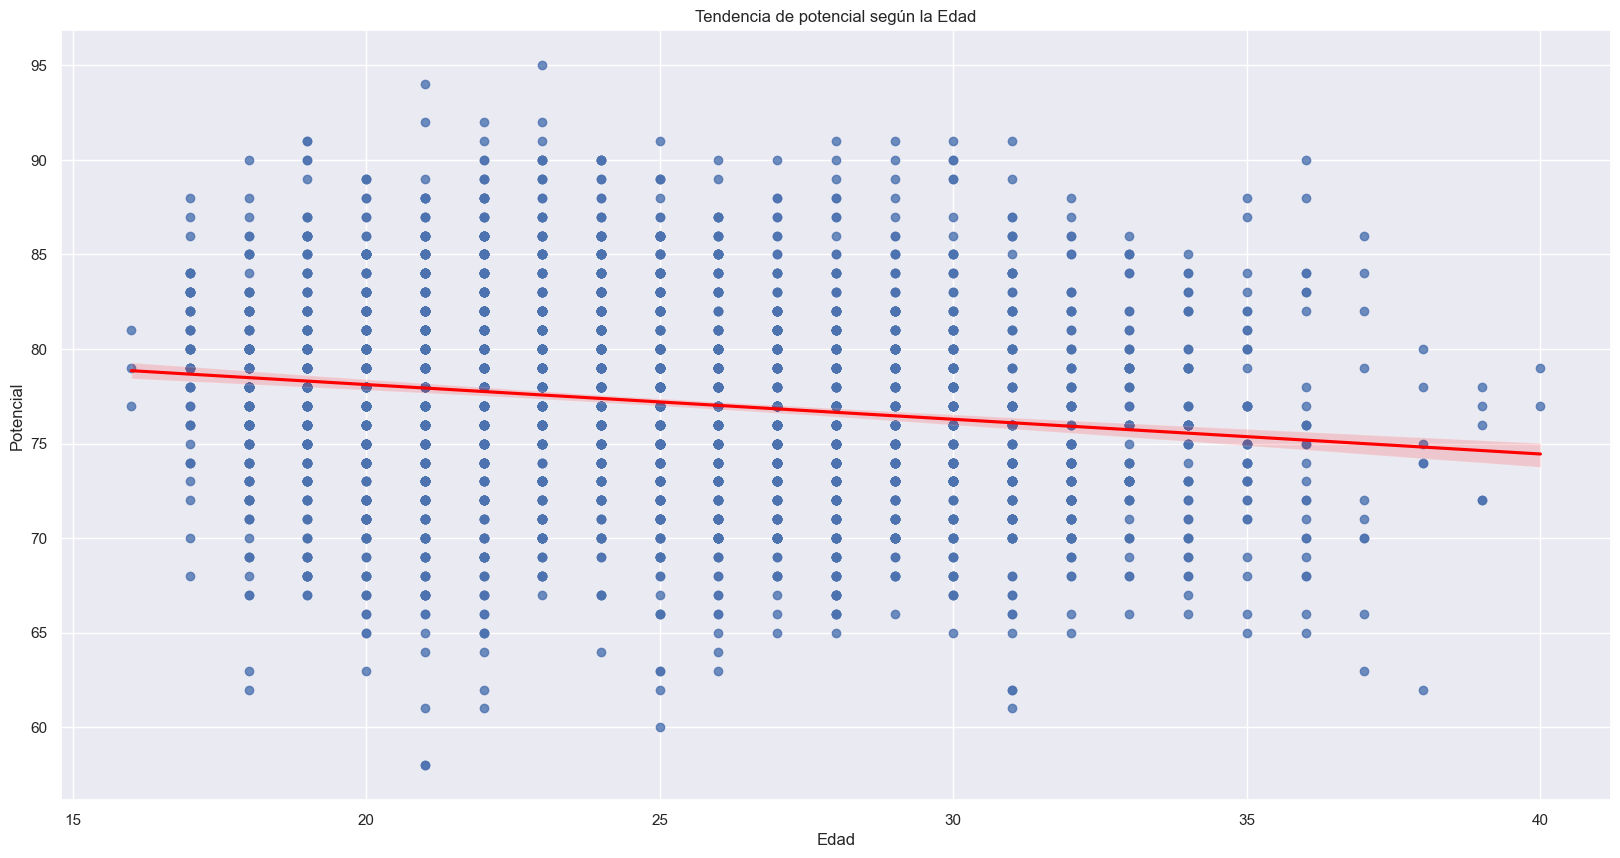

In [463]:
sns.regplot(data=df_skills, x='age', y='potential', line_kws={"color": "red"})
plt.title('Tendencia de potencial según la Edad')
plt.xlabel('Edad')
plt.ylabel('Potencial')
plt.show()

En la gráfica comparativa por edad de la media de puntuación y la media de potencial, vemos que la puntuación del potenciales en general más alta y tiene a descender, mientras que la puntuación general empieza muy baja en los primeros años de carrera y va ascendiendo rápidamente con la edad, hasta lograr una estabilización de las dos variables a partir de los 30 años, donde coinciden sus medias bastante bien

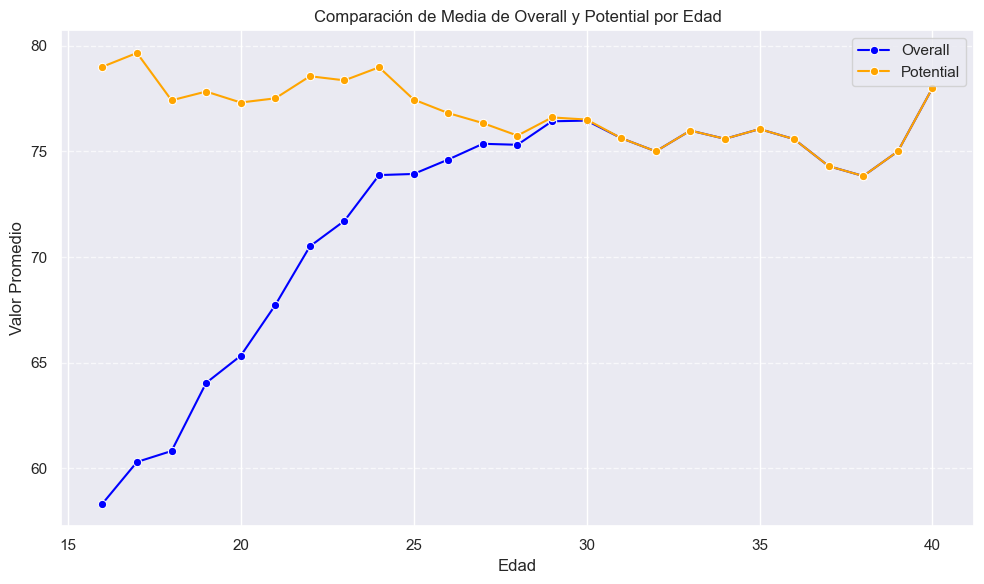

In [464]:
mean_overall_age = df_skills.groupby('age')['overall'].mean()
mean_potential_age = df_skills.groupby('age')['potential'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_overall_age.index, y=mean_overall_age.values, marker='o', label='Overall', color='blue')
sns.lineplot(x=mean_potential_age.index, y=mean_potential_age.values, marker='o', label='Potential', color='orange')
plt.title('Comparación de Media de Overall y Potential por Edad')
plt.xlabel('Edad')
plt.ylabel('Valor Promedio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Edad y valor de mercado

In [465]:
age_value = df_skills.groupby('age')['value_million_euro'].describe().T
age_value

age          16         17          18          19          20          21  \
count  3.000000  52.000000  133.000000  169.000000  223.000000  250.000000   
mean   0.675000   0.947885    1.158571    3.981124    3.658027    6.914860   
std    0.281736   0.660397    1.426220   10.429686    7.228793   14.451563   
min    0.350000   0.190000    0.110000    0.190000    0.130000    0.100000   
25%    0.587500   0.543750    0.475000    0.575000    0.750000    0.981250   
50%    0.825000   0.762500    0.750000    1.100000    1.500000    2.500000   
75%    0.837500   1.200000    1.400000    2.500000    3.350000    5.500000   
max    0.850000   3.500000   13.000000   81.500000   60.500000  148.000000   

age            22          23          24          25  ...          31  \
count  248.000000  229.000000  244.000000  244.000000  ...  125.000000   
mean    10.412177   11.472926   12.417008   11.787336  ...   10.866840   
std     15.908619   20.672716   15.162840   15.263102  ...   16.091637   
min      0.180000    0.400000    0.325000    0.160000  ...    0.170000   
25%      1.800000    2.100000    2.675000    2.200000  ...    1.700000   
50%      3.600000    4.000000    6.000000    5.500000  ...    3.800000   
75%     11.500000   11.000000   16.625000   14.500000  ...   12.500000   
max    109.500000  190.500000   98.500000  107.500000  ...  107.500000   

age            32         33         34         35         36         37  \
count  105.000000  60.000000  49.000000  37.000000  26.000000  10.000000   
mean     7.842143   7.057917   4.584490   3.676081   4.247500   2.355500   
std     12.147999   8.977878   5.907778   4.145507   6.661967   3.749095   
min      0.475000   0.275000   0.150000   0.190000   0.080000   0.050000   
25%      1.500000   1.500000   0.550000   0.625000   0.331250   0.187500   
50%      2.800000   3.650000   2.400000   1.700000   0.962500   0.512500   
75%      9.000000   8.625000   5.500000   4.500000   5.225000   3.025000   
max     72.000000  42.000000  26.000000  13.000000  29.000000  12.000000   

age          38        39        40  
count  6.000000  5.000000  2.000000  
mean   1.445000  1.180000  0.950000  
std    1.425623  0.990328  1.343503  
min    0.045000  0.250000  0.000000  
25%    0.543750  0.250000  0.475000  
50%    0.925000  1.200000  0.950000  
75%    2.150000  1.600000  1.425000  
max    3.800000  2.600000  1.900000  

[8 rows x 25 columns]

Edad y valor de mercado

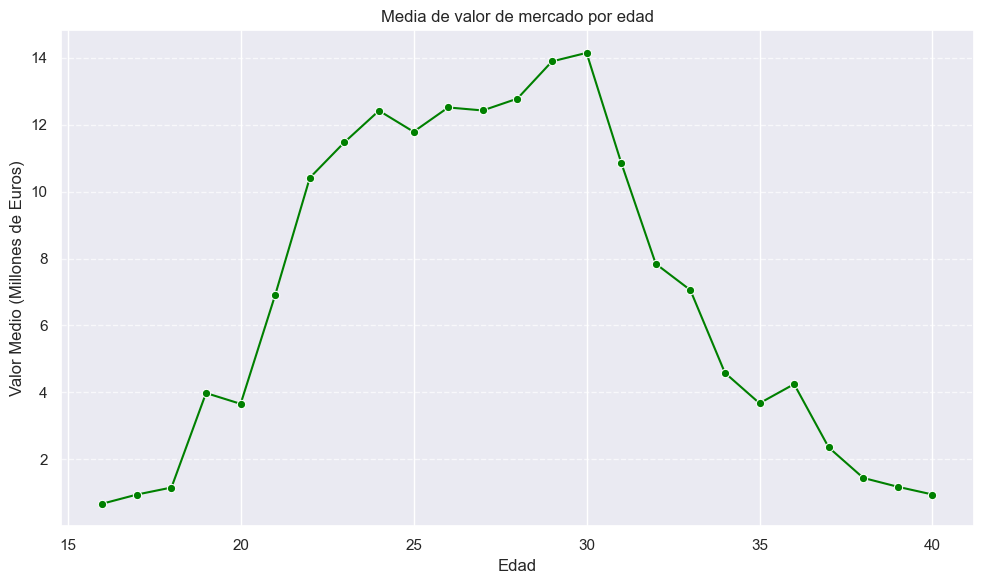

In [466]:
mean_value_age = df_skills.groupby('age')['value_million_euro'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_value_age.index, y=mean_value_age.values, marker='o', color='green')
plt.title('Media de valor de mercado por edad')
plt.xlabel('Edad')
plt.ylabel('Valor Medio (Millones de Euros)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El valor de mercado comienza muy bajo para las edades más jóvenes y tiene una tendencia ascendente según van cumpliendo años. Se estabiliza entre los 24 y 30 años, a partir del cual baja en picado, según se acerca la retirada profesional de los futbolistas. Tiene sentido, ya que a partir de esa edad quizá un equipo no pueda contar tantos años con el futbolista, como en el caso de fichar un futbolista joven. En el siguiente regplot podemos observar que aunque hay esos cambios, la tendencia general es ligeramente ascendente, por lo que el ascenso en el valor de mercado es más pronunciado a nivel general que el descenso. Pero realmente es muy ligero

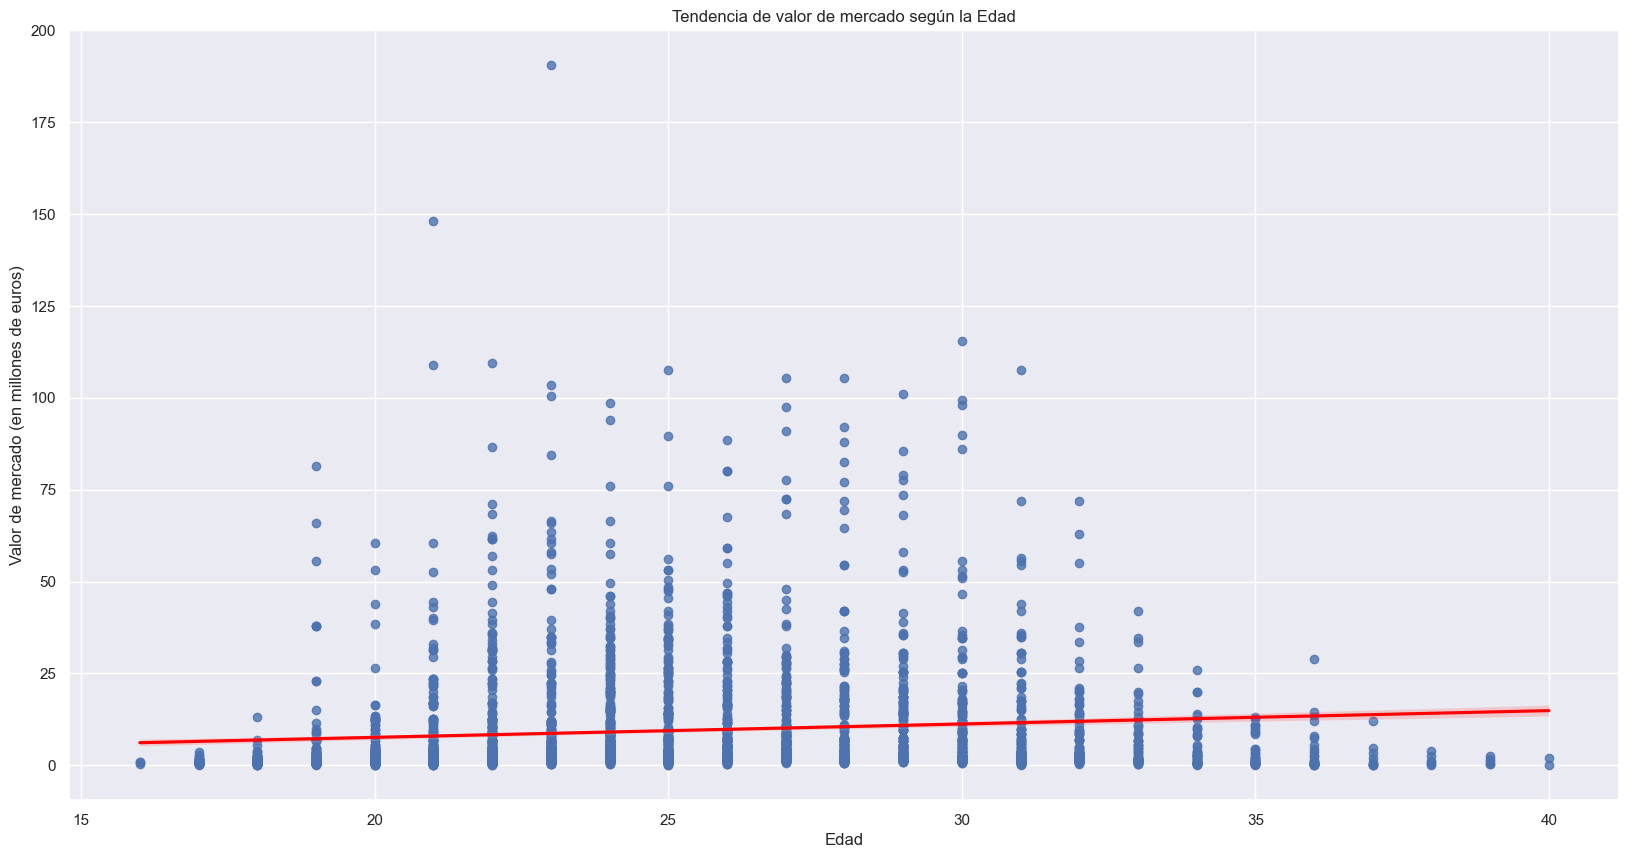

In [467]:
sns.regplot(data=df_skills, x='age', y='value_million_euro', line_kws={"color": "red"})
plt.title('Tendencia de valor de mercado según la Edad')
plt.xlabel('Edad')
plt.ylabel('Valor de mercado (en millones de euros)')
plt.show()

Edad y salario

In [468]:
age_wage = df_skills.groupby('age')['wage_million_euro'].describe().T
age_wage

age          16         17          18          19          20          21  \
count  3.000000  52.000000  133.000000  169.000000  223.000000  250.000000   
mean   0.034667   0.052550    0.143156    0.416231    0.589162    0.822401   
std    0.015011   0.041966    0.147130    0.598342    0.698424    1.277396   
min    0.026000   0.026000    0.026000    0.026000    0.033800    0.026000   
25%    0.026000   0.026000    0.052000    0.104000    0.156000    0.156000   
50%    0.026000   0.029900    0.104000    0.208000    0.312000    0.364000   
75%    0.039000   0.052000    0.156000    0.416000    0.728000    1.040000   
max    0.052000   0.208000    1.040000    4.368000    3.952000   11.440000   

age            22          23          24          25  ...          31  \
count  248.000000  229.000000  244.000000  244.000000  ...  125.000000   
mean     1.240714    1.381100    1.498761    1.745836  ...    2.302144   
std      1.486164    1.982729    1.314936    1.742278  ...    2.805493   
min      0.026000    0.028600    0.039000    0.052000  ...    0.104000   
25%      0.260000    0.364000    0.559000    0.572000  ...    0.884000   
50%      0.780000    0.728000    1.092000    1.196000  ...    1.352000   
75%      1.560000    1.664000    2.080000    2.093000  ...    2.288000   
max      9.360000   20.800000    8.320000   11.960000  ...   18.200000   

age            32         33         34         35         36         37  \
count  105.000000  60.000000  49.000000  37.000000  26.000000  10.000000   
mean     1.923010   1.811333   1.653388   1.339351   1.791600   1.404000   
std      2.158542   1.637239   1.476935   1.229837   2.401699   1.807992   
min      0.104000   0.208000   0.052000   0.052000   0.041600   0.156000   
25%      0.728000   0.741000   0.780000   0.520000   0.455000   0.286000   
50%      1.404000   1.248000   1.300000   1.040000   0.962000   0.546000   
75%      2.392000   2.678000   2.184000   1.456000   1.885000   2.002000   
max     16.120000   9.360000   8.320000   4.940000  11.960000   5.980000   

age          38        39       40  
count  6.000000  5.000000  2.00000  
mean   0.892667  0.728000  0.54600  
std    0.522507  0.257387  0.03677  
min    0.156000  0.416000  0.52000  
25%    0.520000  0.572000  0.53300  
50%    0.988000  0.728000  0.54600  
75%    1.300000  0.832000  0.55900  
max    1.456000  1.092000  0.57200  

[8 rows x 25 columns]

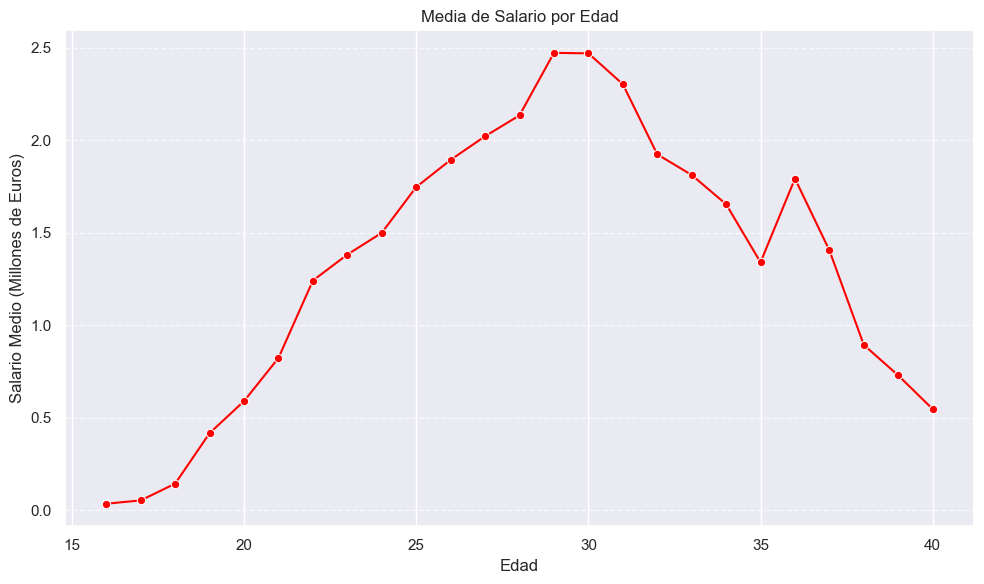

In [469]:
mean_wage_age = df_skills.groupby('age')['wage_million_euro'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_wage_age.index, y=mean_wage_age.values, marker='o', color='red')
plt.title('Media de Salario por Edad')
plt.xlabel('Edad')
plt.ylabel('Salario Medio (Millones de Euros)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

En el caso del salario con la edad, también tiene una tendencia ascendente desde los 15 años hasta los 29/30 años. Apartir de ahí tiene un descenso, pero menos pronunciado, por lo que los jugadores más veteranos, aunque pierden poder adquisitio, siguen teniendo buenos salarios hasta los 37 años, a partir del cual ya bajan considerablemente, debido a que están muy próximos a su retirada.

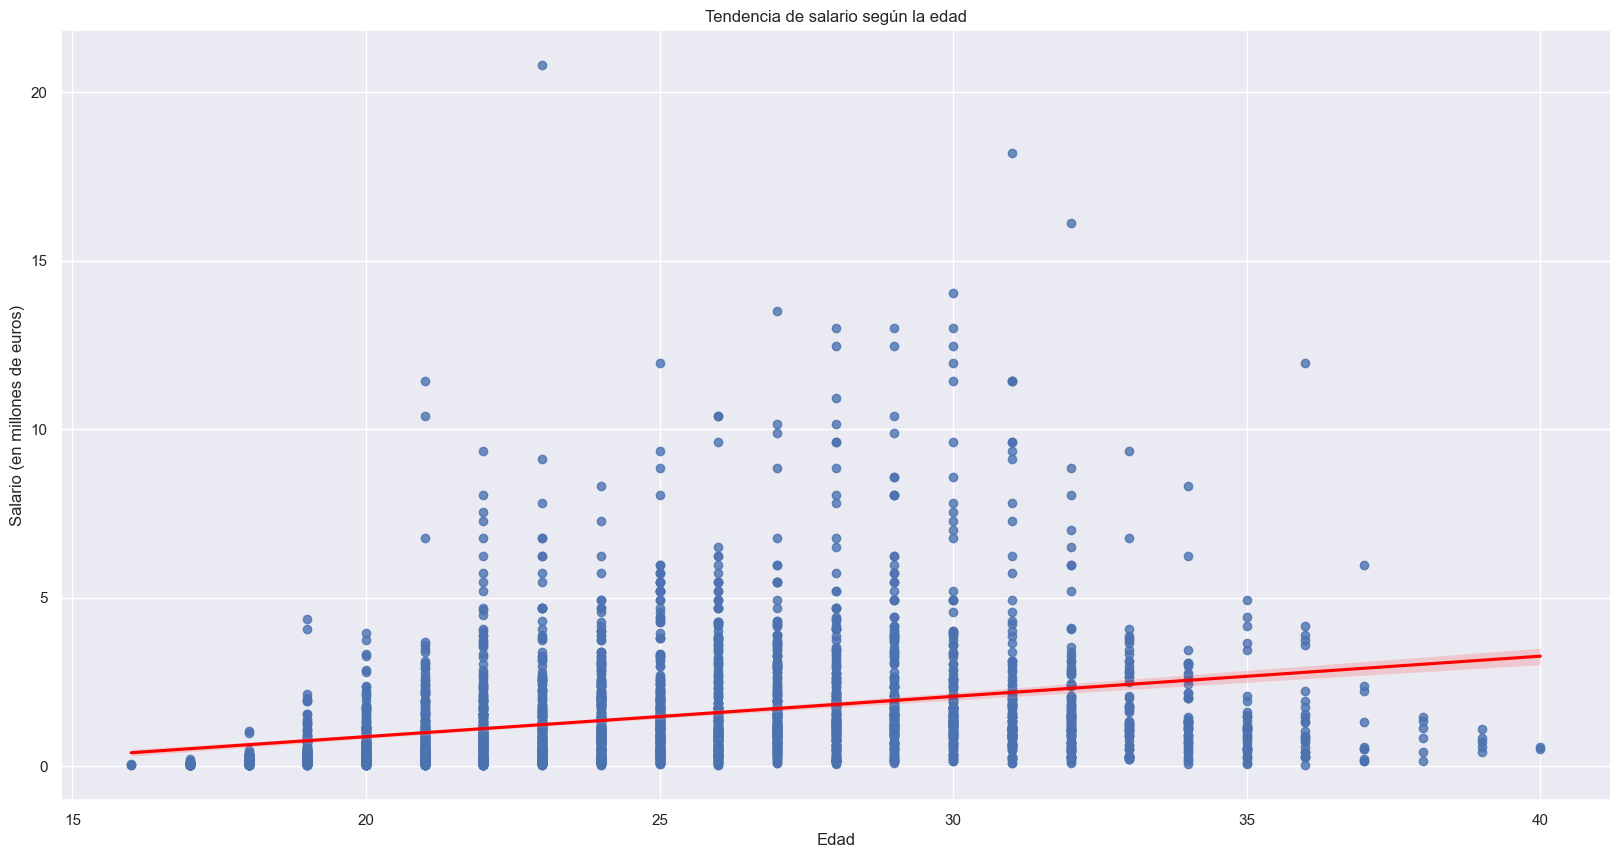

In [470]:
sns.regplot(data=df_skills, x='age', y='wage_million_euro', line_kws={"color": "red"})
plt.title('Tendencia de salario según la edad')
plt.xlabel('Edad')
plt.ylabel('Salario (en millones de euros)')
plt.show()

Edad y ritmo de juego

In [471]:
age_pace = df_skills.groupby('age')['pace_total'].describe().T
age_pace

age      16         17          18          19          20          21  \
count   3.0  52.000000  133.000000  169.000000  223.000000  250.000000   
mean   60.0  64.076923   59.616541   63.366864   61.470852   61.880000   
std     1.0  15.575051   22.959689   21.794393   24.601285   25.891991   
min    59.0   0.000000    0.000000    0.000000    0.000000    0.000000   
25%    59.5  61.750000   58.000000   60.000000   60.000000   60.000000   
50%    60.0  66.000000   65.000000   67.000000   67.000000   69.000000   
75%    60.5  71.250000   73.000000   75.000000   76.000000   77.000000   
max    61.0  85.000000   90.000000   92.000000   94.000000   95.000000   

age            22          23          24          25  ...          31  \
count  248.000000  229.000000  244.000000  244.000000  ...  125.000000   
mean    67.528226   65.925764   66.290984   64.467213  ...   55.720000   
std     20.637786   23.726857   22.426683   23.936880  ...   29.057396   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%     63.000000   64.000000   64.000000   61.000000  ...   50.000000   
50%     73.000000   73.000000   72.000000   71.000000  ...   68.000000   
75%     80.000000   78.000000   79.000000   79.000000  ...   74.000000   
max     93.000000   97.000000   95.000000   93.000000  ...   89.000000   

age            32         33         34         35         36         37  \
count  105.000000  60.000000  49.000000  37.000000  26.000000  10.000000   
mean    54.676190  44.866667  44.081633  40.513514  37.538462  14.900000   
std     22.669233  26.896201  30.884757  29.408636  27.754972  25.150436   
min      0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     49.000000  32.750000   0.000000   0.000000   0.000000   0.000000   
50%     60.000000  52.000000  53.000000  47.000000  48.500000   0.000000   
75%     68.000000  64.250000  69.000000  68.000000  55.000000  25.500000   
max     91.000000  87.000000  90.000000  78.000000  85.000000  66.000000   

age           38         39         40  
count   6.000000   5.000000   2.000000  
mean   25.333333  12.600000  16.500000  
std    21.011108  28.174457  23.334524  
min     0.000000   0.000000   0.000000  
25%     7.750000   0.000000   8.250000  
50%    31.500000   0.000000  16.500000  
75%    35.750000   0.000000  24.750000  
max    52.000000  63.000000  33.000000  

[8 rows x 25 columns]

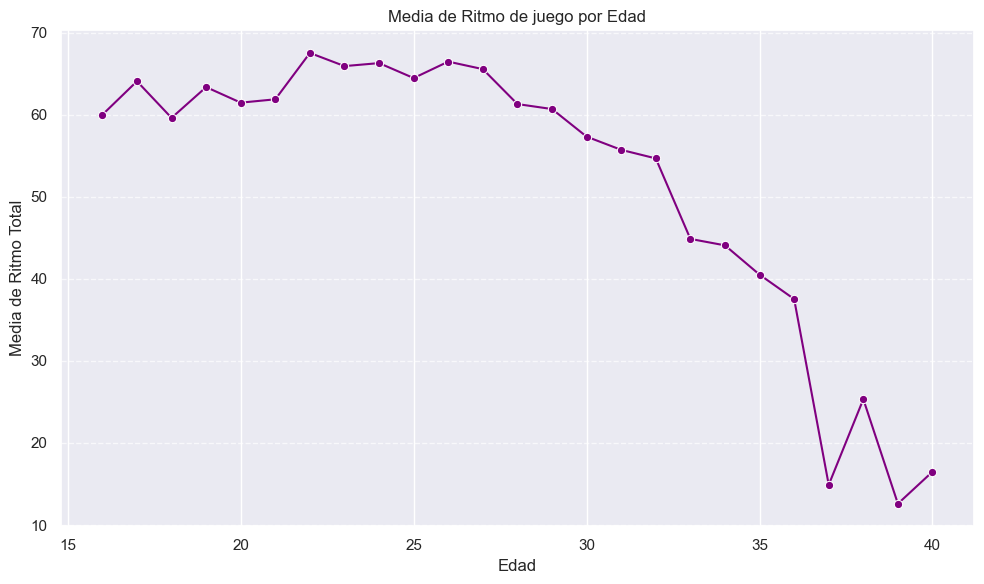

In [472]:
mean_age_pace = df_skills.groupby('age')['pace_total'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_age_pace.index, y=mean_age_pace.values, marker='o', color='purple')
plt.title('Media de Ritmo de juego por Edad')
plt.xlabel('Edad')
plt.ylabel('Media de Ritmo Total')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


El ritmo de juego tiene valores bastante estables entre el incio de su carrera (o los 15 años) y los 32 años. A esta edad ya comienza un declive en el ritmo de juego hasta la retirada. La tendencia es descendente, a más edad menor ritmo de juego

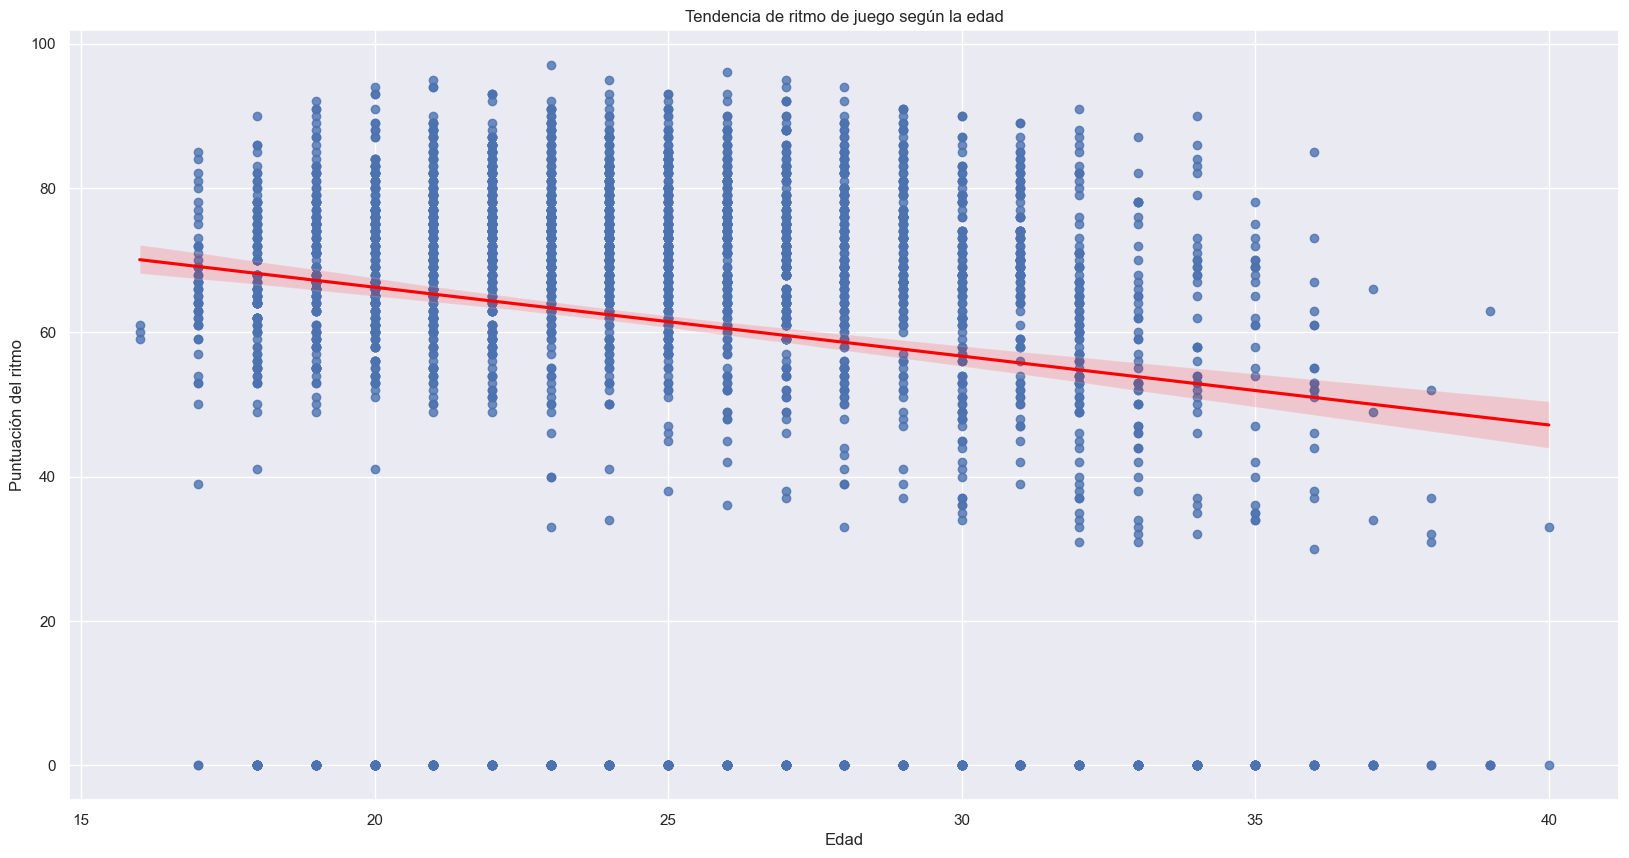

In [473]:
sns.regplot(data=df_skills, x='age', y='pace_total', line_kws={"color": "red"})
plt.title('Tendencia de ritmo de juego según la edad')
plt.xlabel('Edad')
plt.ylabel('Puntuación del ritmo')
plt.show()

Edad y visión de juego

In [474]:
age_vision = df_skills.groupby('age')['vision'].describe().T
age_vision

age           16         17          18          19          20          21  \
count   3.000000  52.000000  133.000000  169.000000  223.000000  250.000000   
mean   39.000000  51.365385   49.503759   53.775148   52.713004   55.116000   
std    11.135529   9.575354   12.857390   12.883049   13.423731   14.546924   
min    27.000000  28.000000   22.000000   21.000000   21.000000   21.000000   
25%    34.000000  47.750000   39.000000   45.000000   43.000000   45.250000   
50%    41.000000  53.000000   51.000000   55.000000   55.000000   57.000000   
75%    45.000000  57.250000   60.000000   63.000000   63.000000   66.750000   
max    49.000000  68.000000   86.000000   85.000000   81.000000   80.000000   

age            22          23          24          25  ...          31  \
count  248.000000  229.000000  244.000000  244.000000  ...  125.000000   
mean    58.262097   58.519651   61.741803   62.250000  ...   62.344000   
std     14.593821   14.236899   14.244880   14.147627  ...   17.235608   
min     22.000000   22.000000   12.000000   16.000000  ...   10.000000   
25%     49.750000   48.000000   53.000000   55.000000  ...   53.000000   
50%     59.500000   60.000000   65.000000   65.000000  ...   67.000000   
75%     70.000000   70.000000   73.000000   73.000000  ...   74.000000   
max     86.000000   90.000000   85.000000   87.000000  ...   94.000000   

age            32         33         34         35         36        37  \
count  105.000000  60.000000  49.000000  37.000000  26.000000  10.00000   
mean    61.895238  63.683333  60.510204  63.216216  59.115385  54.20000   
std     12.644491  15.614521  17.029536  14.292840  19.978642  10.71655   
min     30.000000  23.000000  22.000000  32.000000  19.000000  41.00000   
25%     51.000000  54.750000  48.000000  54.000000  44.000000  46.00000   
50%     65.000000  66.500000  64.000000  66.000000  66.000000  52.50000   
75%     71.000000  76.250000  73.000000  74.000000  71.000000  58.50000   
max     89.000000  90.000000  87.000000  87.000000  90.000000  71.00000   

age           38         39         40  
count   6.000000   5.000000   2.000000  
mean   58.333333  55.400000  63.500000  
std    17.580292  22.567676  12.020815  
min    32.000000  29.000000  55.000000  
25%    48.000000  34.000000  59.250000  
50%    63.500000  65.000000  63.500000  
75%    67.000000  69.000000  67.750000  
max    80.000000  80.000000  72.000000  

[8 rows x 25 columns]

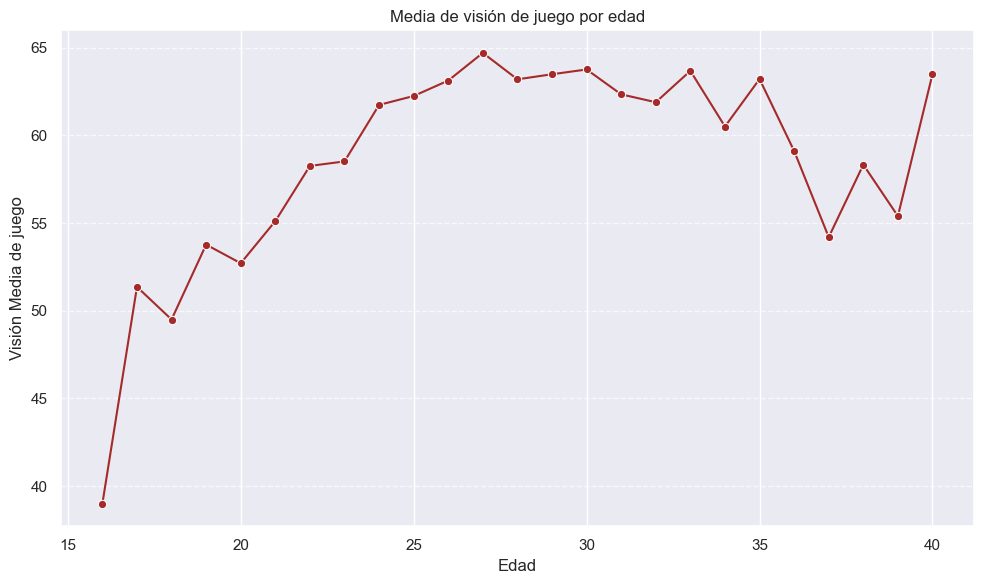

In [475]:
mean_age_vision = df_skills.groupby('age')['vision'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_age_vision.index, y=mean_age_vision.values, marker='o', color='brown')
plt.title('Media de visión de juego por edad')
plt.xlabel('Edad')
plt.ylabel('Visión Media de juego')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

La visión de juego según la edad tiene una tendencia claramente ascendente, ya que según amumenta la edad aumenta la visión de juego. Cabe destacar que hay una estabilización de la puntuación visión entre los 24 y 35 años. Tras esto hay un pequeño declive entre los 35 y 39 años, pero no es demasiado marcado.

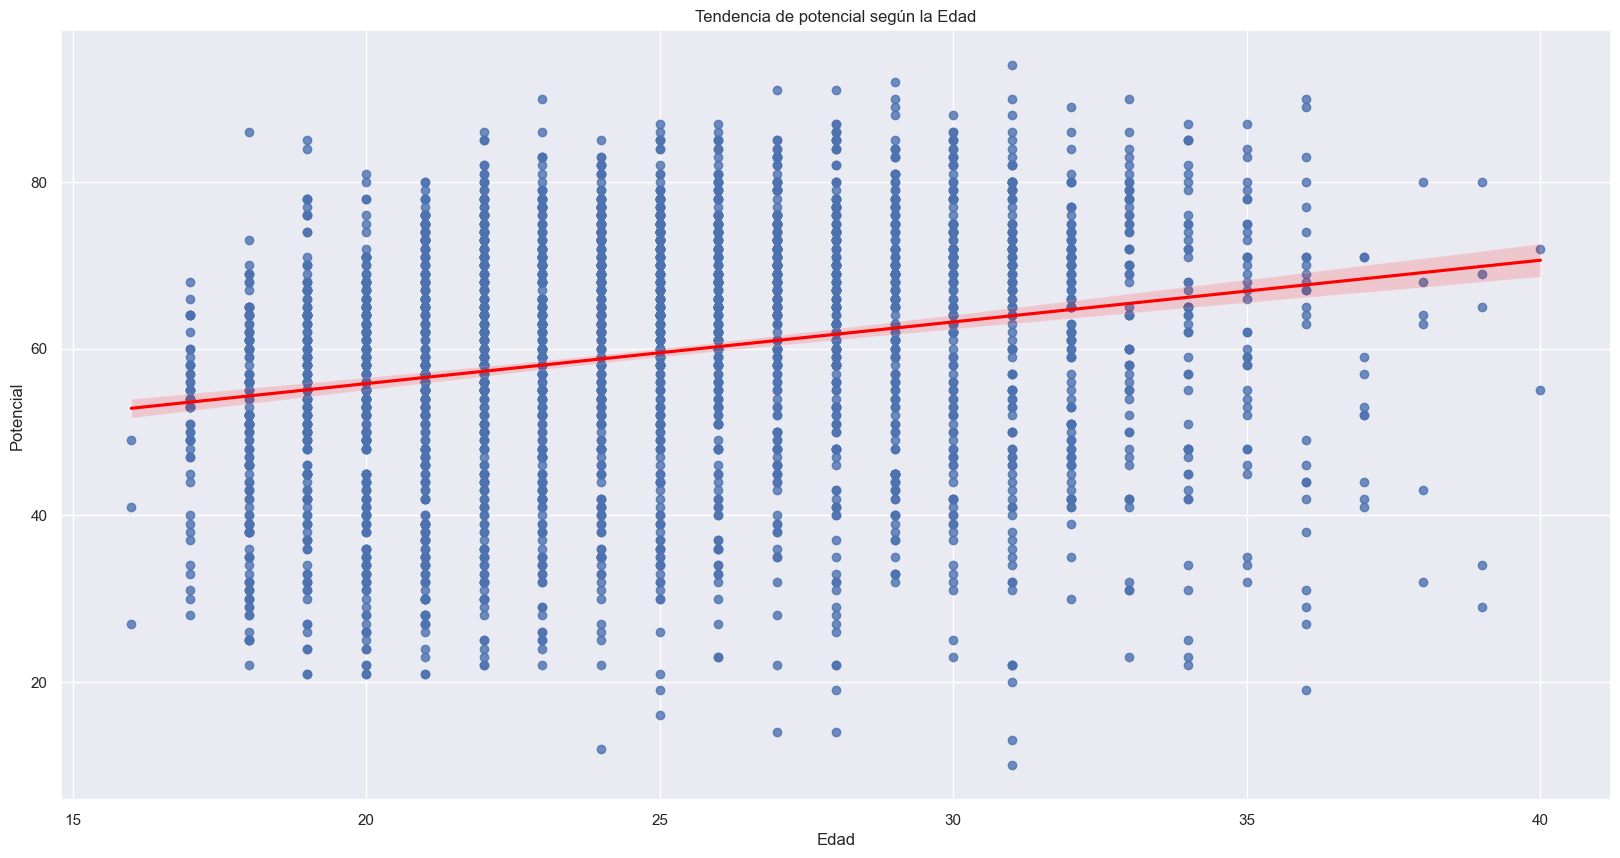

In [476]:
sns.regplot(data=df_skills, x='age', y='vision', line_kws={"color": "red"})
plt.title('Tendencia de potencial según la Edad')
plt.xlabel('Edad')
plt.ylabel('Potencial')
plt.show()

Edad y Fuerza

In [477]:
age_strength = df_skills.groupby('age')['strength'].describe().T
age_strength

age           16         17          18          19          20          21  \
count   3.000000  52.000000  133.000000  169.000000  223.000000  250.000000   
mean   53.000000  54.576923   58.436090   56.426036   60.551570   62.996000   
std    19.672316  11.933387   10.692927   13.225905   11.272057   11.912498   
min    32.000000  31.000000   34.000000   27.000000   31.000000   30.000000   
25%    44.000000  45.750000   51.000000   48.000000   53.000000   56.000000   
50%    56.000000  53.500000   58.000000   59.000000   61.000000   64.500000   
75%    63.500000  63.250000   67.000000   66.000000   69.000000   72.000000   
max    71.000000  91.000000   83.000000   91.000000   88.000000   93.000000   

age            22          23          24          25  ...          31  \
count  248.000000  229.000000  244.000000  244.000000  ...  125.000000   
mean    65.350806   67.157205   69.680328   69.926230  ...   69.256000   
std     12.811382   12.604709   12.085611   10.483118  ...   12.205171   
min     32.000000   29.000000   30.000000   32.000000  ...   25.000000   
25%     56.000000   61.000000   63.000000   63.750000  ...   62.000000   
50%     66.000000   68.000000   70.000000   70.000000  ...   71.000000   
75%     76.000000   76.000000   78.000000   77.000000  ...   77.000000   
max     96.000000   92.000000   92.000000   93.000000  ...   95.000000   

age            32         33         34         35         36        37  \
count  105.000000  60.000000  49.000000  37.000000  26.000000  10.00000   
mean    72.609524  72.916667  70.795918  71.000000  69.423077  69.10000   
std      9.977374  10.333903  10.696533  11.979149  13.494215   8.94986   
min     45.000000  40.000000  40.000000  43.000000  37.000000  57.00000   
25%     65.000000  68.000000  65.000000  63.000000  66.500000  61.75000   
50%     74.000000  73.000000  71.000000  71.000000  70.000000  67.00000   
75%     80.000000  80.000000  78.000000  82.000000  80.000000  78.25000   
max     93.000000  91.000000  92.000000  90.000000  86.000000  80.00000   

age           38         39         40  
count   6.000000   5.000000   2.000000  
mean   67.166667  61.600000  81.000000  
std    13.075422   7.569676  11.313708  
min    55.000000  54.000000  73.000000  
25%    57.500000  55.000000  77.000000  
50%    62.500000  60.000000  81.000000  
75%    77.250000  69.000000  85.000000  
max    85.000000  70.000000  89.000000  

[8 rows x 25 columns]

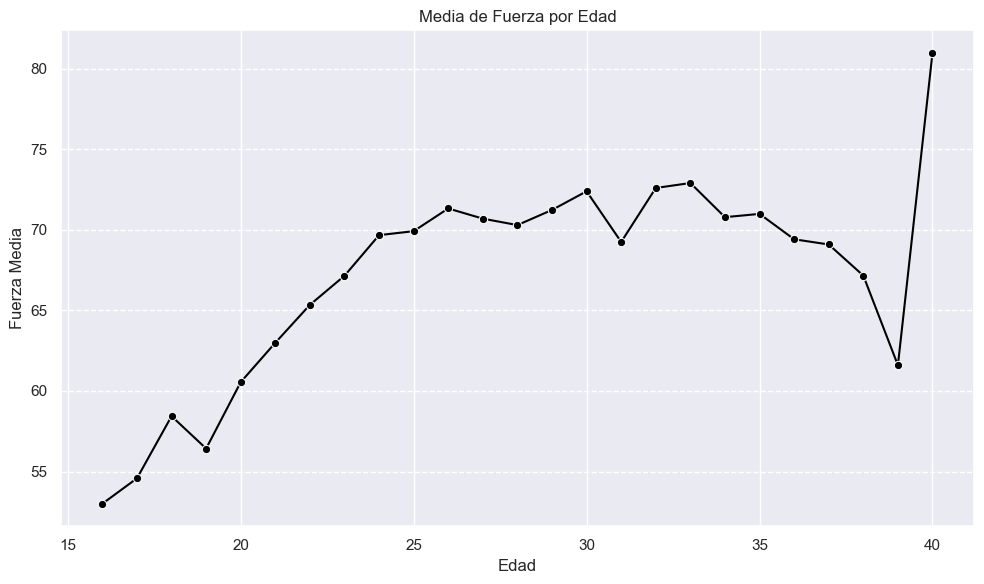

In [478]:
mean_strength_by_age = df_skills.groupby('age')['strength'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_strength_by_age.index, y=mean_strength_by_age.values, marker='o', color='black')
plt.title('Media de Fuerza por Edad')
plt.xlabel('Edad')
plt.ylabel('Fuerza Media')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

La fuerza por edad también tiene tendencia ascendente y se estabiliza entre los 24 y 37 años. Tras esa edad tiende a descender, aunque hay un repunte en los 40 años, que de nuevo parece un sesgo de la media por los pocos registros de esa edad. Se corresponde a algún jugador de retirada tardía y que aún con esa edad cumple bastante bien y mantiene puntuaciones altas para las habilidades (en este caso la fuerza)

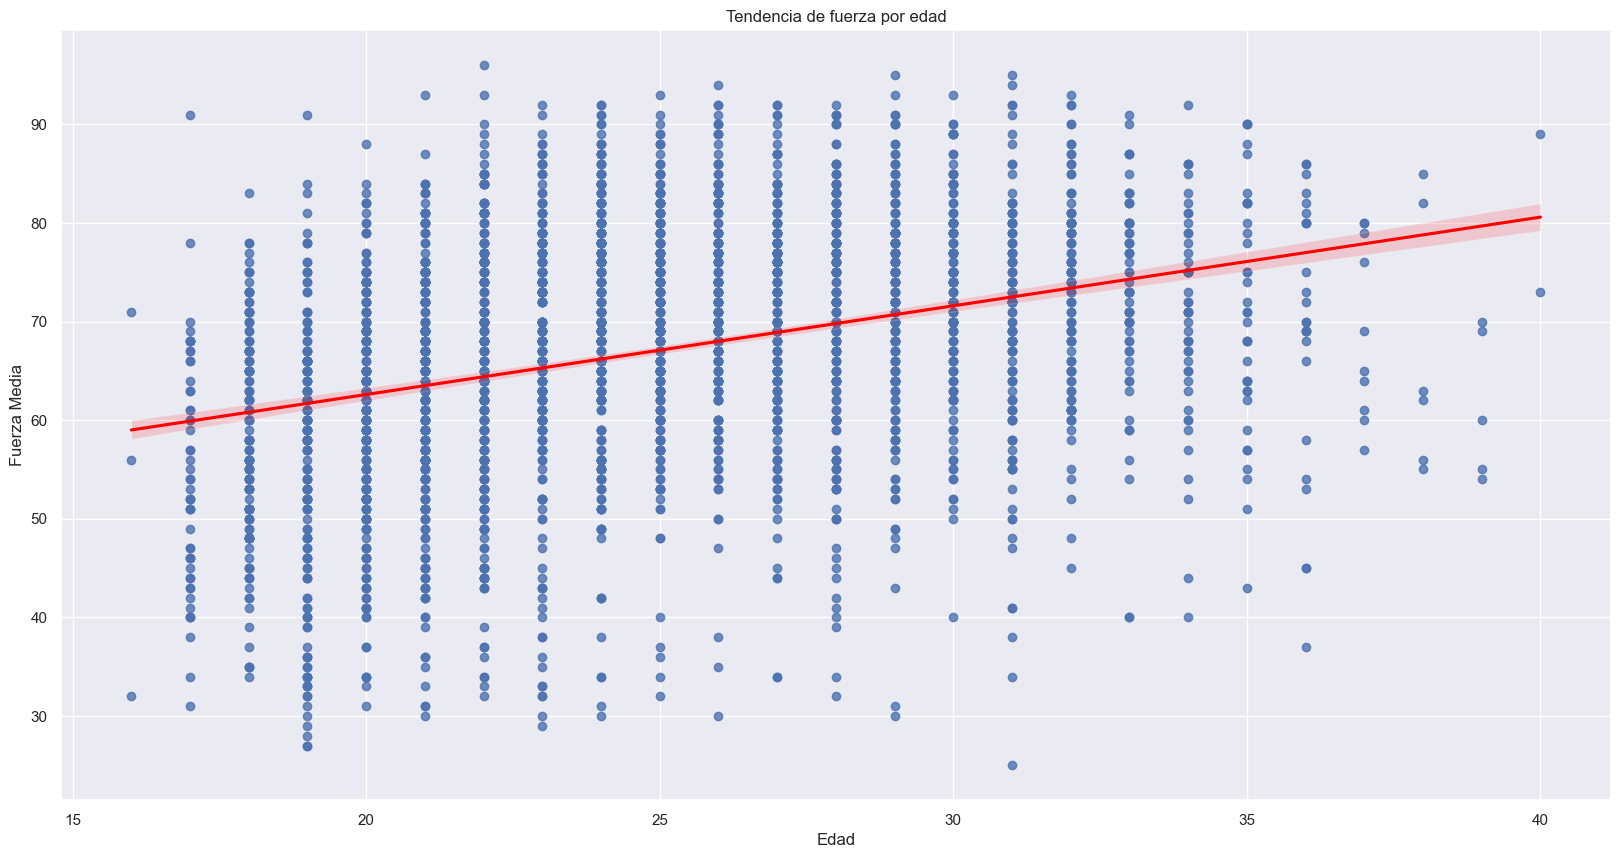

In [479]:
sns.regplot(data=df_skills, x='age', y='strength', line_kws={"color": "red"})
plt.title('Tendencia de fuerza por edad')
plt.xlabel('Edad')
plt.ylabel('Fuerza Media')
plt.show()

Edad y mentalidad

In [480]:
age_mentality = df_skills.groupby('age')['mentality'].describe().T
age_mentality

age      16         17          18          19          20          21  \
count   3.0  52.000000  133.000000  169.000000  223.000000  250.000000   
mean   49.0  52.673077   51.669173   55.384615   56.511211   58.788000   
std     6.0   8.958994   10.731377   11.971196   12.249972   13.507363   
min    43.0  23.000000   21.000000   23.000000   24.000000   22.000000   
25%    46.0  45.000000   44.000000   47.000000   49.000000   51.000000   
50%    49.0  53.000000   53.000000   56.000000   59.000000   60.500000   
75%    52.0  58.250000   59.000000   64.000000   65.000000   69.000000   
max    55.0  68.000000   75.000000   82.000000   79.000000   85.000000   

age            22          23          24          25  ...          31  \
count  248.000000  229.000000  244.000000  244.000000  ...  125.000000   
mean    62.883065   64.262009   66.786885   67.172131  ...   69.664000   
std     12.154473   10.880185   11.389281   10.932409  ...   11.115192   
min     22.000000   20.000000   25.000000   23.000000  ...   37.000000   
25%     57.000000   59.000000   62.000000   62.000000  ...   64.000000   
50%     64.000000   66.000000   68.000000   69.000000  ...   70.000000   
75%     71.250000   71.000000   75.000000   74.000000  ...   78.000000   
max     86.000000   88.000000   88.000000   86.000000  ...   90.000000   

age            32         33         34         35         36         37  \
count  105.000000  60.000000  49.000000  37.000000  26.000000  10.000000   
mean    70.400000  71.850000  68.265306  70.108108  71.846154  63.200000   
std      7.578563   9.679307  13.585801  10.439731  13.463112  10.982815   
min     45.000000  45.000000  30.000000  36.000000  38.000000  41.000000   
25%     67.000000  66.000000  58.000000  64.000000  66.500000  62.000000   
50%     71.000000  73.000000  73.000000  70.000000  74.000000  63.000000   
75%     75.000000  78.250000  77.000000  76.000000  81.000000  65.500000   
max     88.000000  89.000000  87.000000  90.000000  92.000000  86.000000   

age           38         39         40  
count   6.000000   5.000000   2.000000  
mean   68.500000  63.400000  72.000000  
std    19.725618  11.907981   9.899495  
min    30.000000  44.000000  65.000000  
25%    69.250000  64.000000  68.500000  
50%    74.500000  64.000000  72.000000  
75%    79.000000  69.000000  75.500000  
max    84.000000  76.000000  79.000000  

[8 rows x 25 columns]

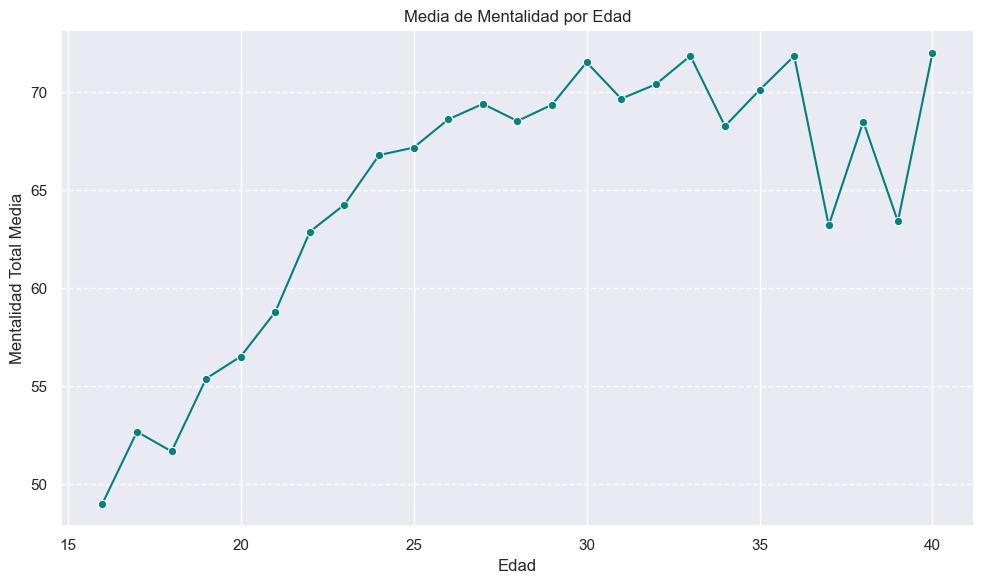

In [481]:
mean_age_mentality = df_skills.groupby('age')['mentality'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_age_mentality.index, y=mean_age_mentality.values, marker='o', color='teal')
plt.title('Media de Mentalidad por Edad')
plt.xlabel('Edad')
plt.ylabel('Mentalidad Total Media')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()


La mentalidad por edades tiene una tendencia claramente ascendente y en torno a los 25 años se estabiliza hasta el final sus carreras. En los últimos años hay más variabilidad de puntuación, pero sigue siendo bastante parecido a los año previos. Esto indica que la mentalidad y focalización es una habilidad que se va desarrollando poco a poco a lo largo de la carrera profesional

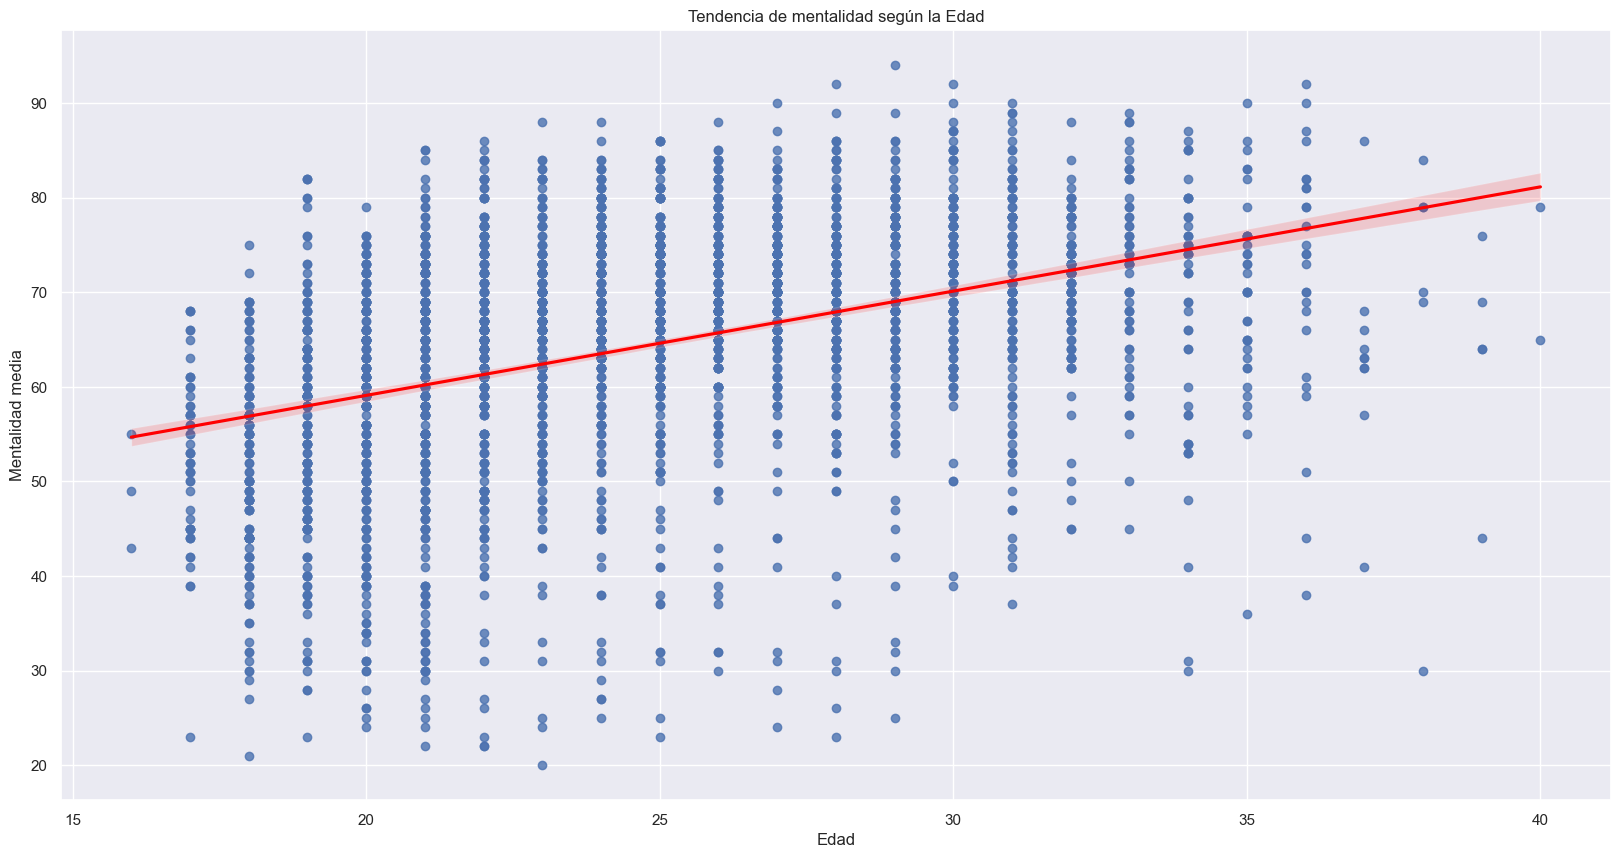

In [482]:
sns.regplot(data=df_skills, x='age', y='mentality', line_kws={"color": "red"})
plt.title('Tendencia de mentalidad según la Edad')
plt.xlabel('Edad')
plt.ylabel('Mentalidad media')
plt.show()

Gráfica comparativa entre la media de habilidad de disparo y finalización (por edad)

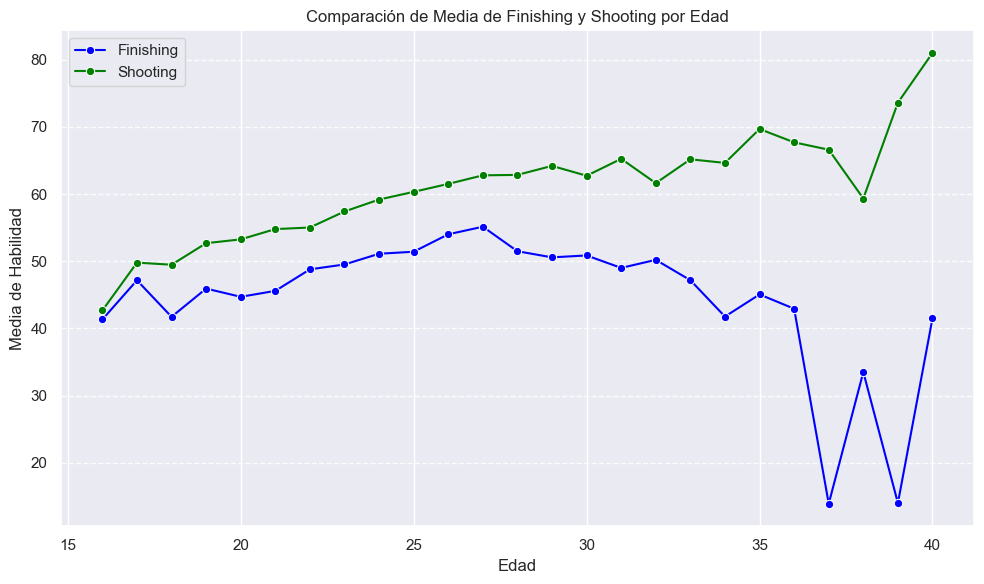

In [483]:
mean_age_finishing = df_skills.groupby('age')['finishing'].mean()
mean_age_shooting = df_skills.groupby('age')['shooting_total'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_age_finishing.index, y=mean_age_finishing.values, marker='o', label='Finishing', color='blue')
sns.lineplot(x=mean_age_shooting.index, y=mean_age_shooting.values, marker='o', label='Shooting', color='green')

plt.title('Comparación de Media de Finishing y Shooting por Edad')
plt.xlabel('Edad')
plt.ylabel('Media de Habilidad')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.legend()
plt.tight_layout()
plt.show()

La variable shooting tiene una tendencia ascendente en cuanto a la edad, por lo que según los jugadores van teniendo más años suele mejorar su habilidad de disparo. La variable de finalización es bastante estable por edades, aunque a partir de los 36 años baja considerablemente. Los jugadores más veteranos van perdiendo precisión en la finalización de gol

AGRUPACIÓN POR PUNTUACIÓN DEFENSIVA Y OFENSIVA DE HABILIDADES

In [484]:
df_skills['defensive_score'] = df_skills[['defending_total', 'physicality_total', 'strength', 
                                          'aggression', 'heading_accuracy', 'ball_control']].mean(axis=1)

df_skills['offensive_score'] = df_skills[['shooting_total', 'finishing', 'long_shots', 
                                          'positioning', 'vision', 'penalties', 'speed',
                                          'shot_power', 'dribbling_total', 'passing_total',]].mean(axis=1)

In [485]:
mean_defensive_age = df_skills.groupby('age')['defensive_score'].mean()
mean_offensive_age = df_skills.groupby('age')['offensive_score'].mean()

In [486]:
df_scores_by_age = pd.DataFrame({
    'Age': mean_defensive_age.index,
    'Defensive_Score': mean_defensive_age.values,
    'Offensive_Score': mean_offensive_age.values,
})

df_scores_by_age


Age  Defensive_Score  Offensive_Score
0    16        51.111111        44.933333
1    17        50.740385        52.070192
2    18        50.317043        48.866917
3    19        52.049310        53.232840
4    20        53.066517        51.953812
5    21        55.184000        53.338000
6    22        60.285618        56.693145
7    23        60.386463        57.063537
8    24        63.520492        59.136680
9    25        62.642760        59.218852
10   26        64.369347        61.174874
11   27        65.252551        62.052041
12   28        62.807971        59.693478
13   29        62.756813        59.578931
14   30        65.735012        59.927698
15   31        59.592000        58.297600
16   32        65.544444        58.643810
17   33        60.702778        56.172500
18   34        57.003401        53.025510
19   35        56.247748        54.574324
20   36        55.801282        52.938462
21   37        37.316667        34.025000
22   38        55.583333        45.775000
23   39        28.866667        35.200000
24   40        49.000000        49.175000

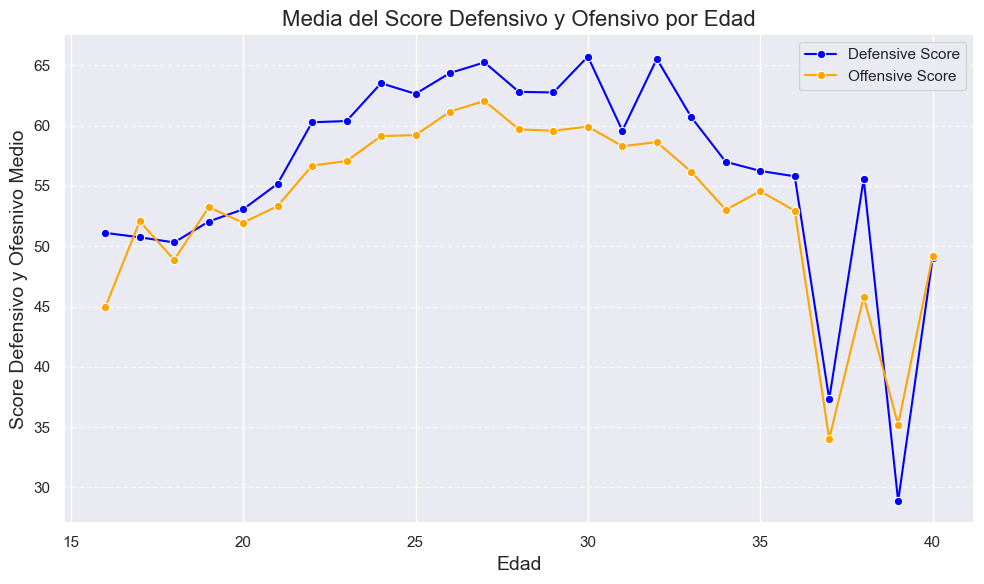

In [487]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_defensive_age.index, y=mean_defensive_age.values, marker='o', label='Defensive Score', color='blue')
sns.lineplot(x=mean_offensive_age.index, y=mean_offensive_age.values, marker='o', label='Offensive Score', color='orange')
plt.title('Media del Score Defensivo y Ofensivo por Edad', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Score Defensivo y Ofesnivo Medio', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El score defensivo suele tener mayor media en todas las edades que estamos analizando. Ambas son constantes, con una ligera mejora en los primeros años de carrera y una bajada a partir de los 36 años.

____
RELACIONES CON POSICION

Posicion y valor de mercado

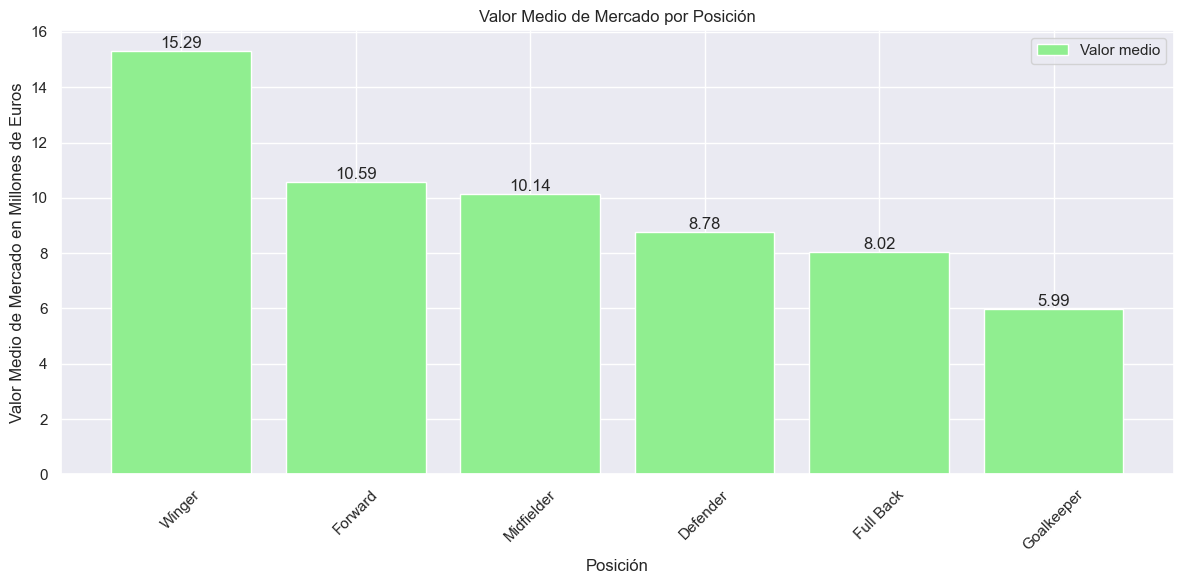

In [488]:
mean_value_position = df_skills.groupby('position')['value_million_euro'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
positions = mean_value_position.index
values = mean_value_position.values
plt.bar(positions, values, color='lightgreen', label='Valor medio')
plt.xlabel('Posición')
plt.ylabel('Valor Medio de Mercado en Millones de Euros')
plt.title('Valor Medio de Mercado por Posición')
plt.xticks(rotation=45)
plt.legend()

for i, value in enumerate(values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Observamos que los mayores valores medios de mercado son para los extremos (con mucha diferencia) y delanteros, seguidos de los centrocampistas, los defensas, laterales y, por último, los porteros. Este dato puede responder a la necesidad en el fútbol de marcar goles para ganar, por lo que los talentos más buscados serían los jugadores más ofensivos (delanteros, extremos o centrocampistas más ofensivos), bajando el precio cuanto más alejado juegue de la portería contraria. Esto valora más el aspecto ofensivo del juego que el defensivo.

Cabe mencionar la diferencia tan grande de los extremos, que como analizamos en las posiciones es la menos habitual y puede deberse a un desbalanceo de datos, ya que al tener muchos menos registros puede introducir un sesgo en la media.

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\2877732427.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_max_value =df_skills.groupby('position').apply(lambda x: x.loc[x['value_million_euro'].idxmax()])


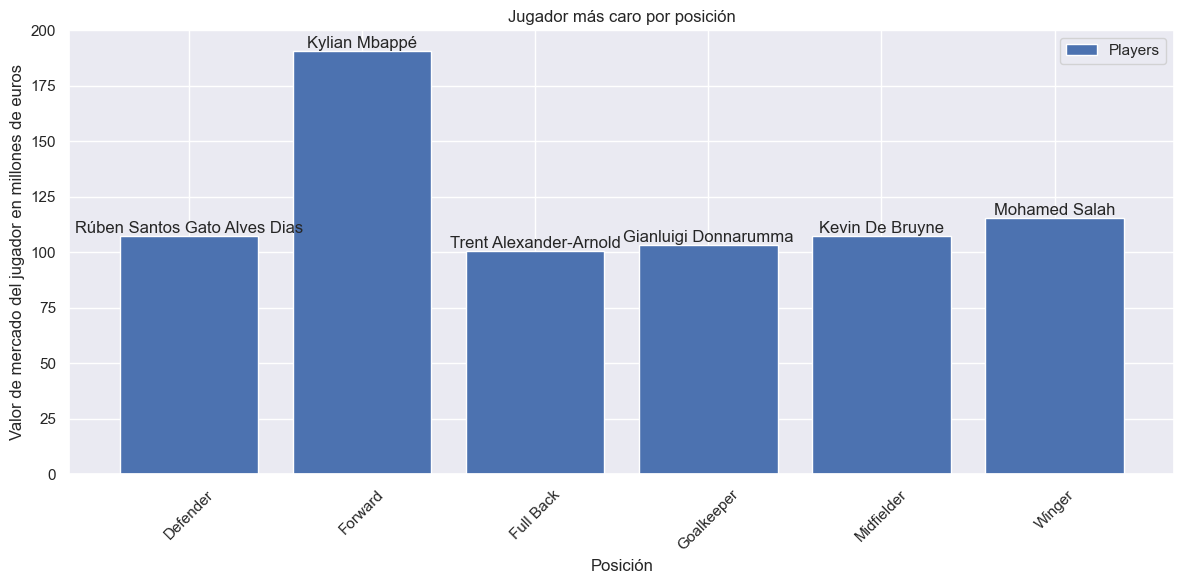

In [489]:
df_max_value =df_skills.groupby('position').apply(lambda x: x.loc[x['value_million_euro'].idxmax()])

plt.figure(figsize=(12, 6))
positions = df_max_value['position']
values = df_max_value['value_million_euro']
players = df_max_value['name']

plt.bar(positions, values, label='Players')
plt.xlabel('Posición')
plt.ylabel('Valor de mercado del jugador en millones de euros')
plt.title('Jugador más caro por posición')
plt.xticks(rotation=45)
plt.legend()

for i, value in enumerate(values):
    plt.text(i, value, players.iloc[i], ha='center', va='bottom')

plt.tight_layout()
plt.show()

POSICIÓN Y SALARIO

En cuanto a salarios, también lideran los extremos, cobrando de media una cifra significativamente más alta que el resto. Le siguen las posiciones de delantero, centrocampista y defensa, que están muy a la par, pero siendo ligeramente más alto el de los delanteros. Por último, los que menos cobran son los porteros. Esto responde, como hemos dicho antes a la valoración en el fútbol de los futbolistas más atacantes y menos valoración de los defensivos en cuanto al juego general de los equipos. En este caso, los extremos siguen respondiendo al patrón de tener menos registros (unos 150) y el posible sesgo al calcular la media con menos registros que el resto de posiciones.

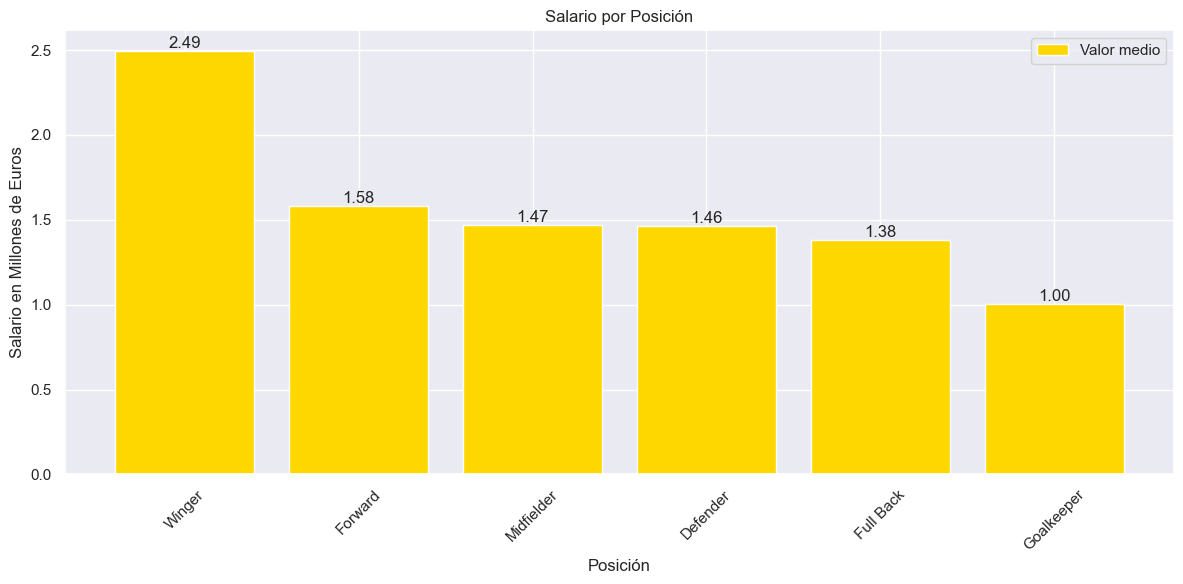

In [490]:
mean_value_position = df_skills.groupby('position')['wage_million_euro'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
positions = mean_value_position.index
values = mean_value_position.values
plt.bar(positions, values, color='gold', label='Valor medio')
plt.xlabel('Posición')
plt.ylabel('Salario en Millones de Euros')
plt.title('Salario por Posición')
plt.xticks(rotation=45)
plt.legend()

for i, value in enumerate(values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

POSICION Y OTRAS VARIABLES

En cuanto a las habilidades en comparación a la posición, vemos que el potencial es bastante parecido para todas las posiciones, por lo que se mantiene un patrón casi independiente a las posiciones

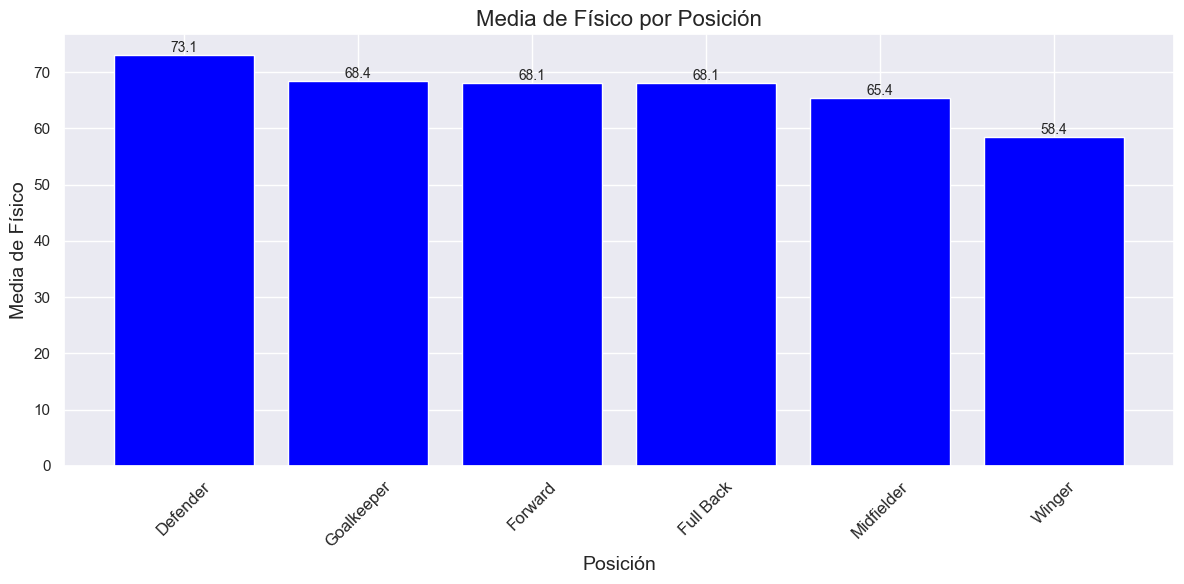

In [491]:
mean_potential_position = df_skills.groupby('position')['physicality_total'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_potential_position.index, mean_potential_position.values, color='blue')
plt.title('Media de Físico por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de Físico', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_potential_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

En cuanto a capacidad física, vemos algo diferente a lo que hemos analizado. Los defensas y porteros son los que tienen una media más alta de 'físico', estando por encima de los delanteros, centrocampistas y, sobre todo, de los extremos. Esto indica su faceta defensiva y no tanto una más creativa o dinámica. Se centran más en aspectos que requieren un físico para imponerse a los rivales y sacar ventaja de ello

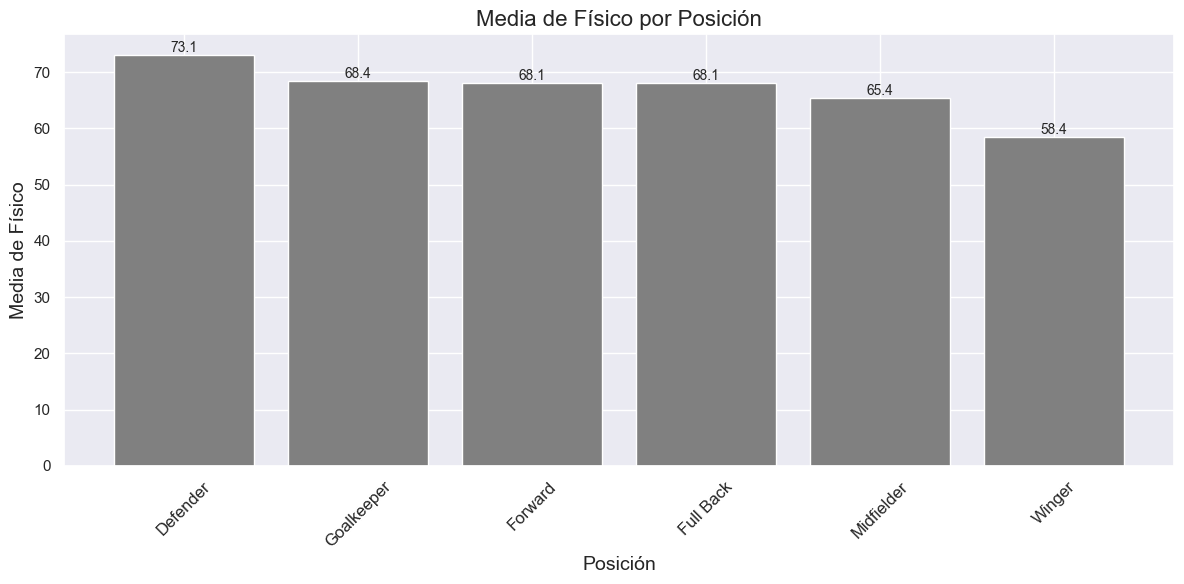

In [492]:
mean_phisicallity_position = df_skills.groupby('position')['physicality_total'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_phisicallity_position.index, mean_phisicallity_position.values, color='grey')
plt.title('Media de Físico por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de Físico', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_phisicallity_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


RELACIONES DE POSICION CON HABILIDADES

Los defensas parecen tener una gran importancia a la hora de pasar el balón desde atrás mediante pases precisos y construcción de juego, siendo el grupo con mejor pase. El resto de posiciones son bastante similares, menos en el caso de los extremos. Este es un caso bastante particular, muestra un perfil más vertical por sus habilidades medias más altas y parecidas a las de los delanteros centro.

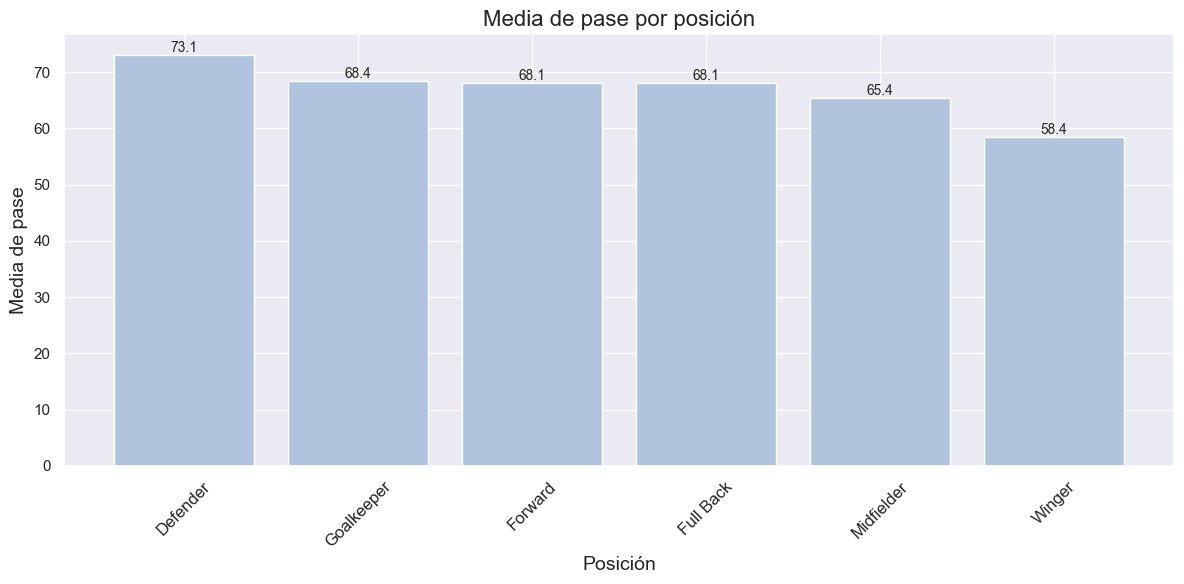

In [493]:
mean_passing_position = df_skills.groupby('position')['passing'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_phisicallity_position.index, mean_phisicallity_position.values, color='lightsteelblue')
plt.title('Media de pase por posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de pase', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_phisicallity_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

En velocidad, la posición lider de media es la de extremo (que corrobora esta versión más vertical y ofensiva de la que hablamos) y los laterales, que son jugadores que recorren la banda. Los delanteros y centrocampistas tienen velocidades más similares y en un punto intermedio. Los defensas parecen tener menos velocidad, por lo que quizás se involucren en jugadas defensivas en menores porciones de terreno, donde como hemos visto, intentarán imponer su fuerza antes de la velocidad.

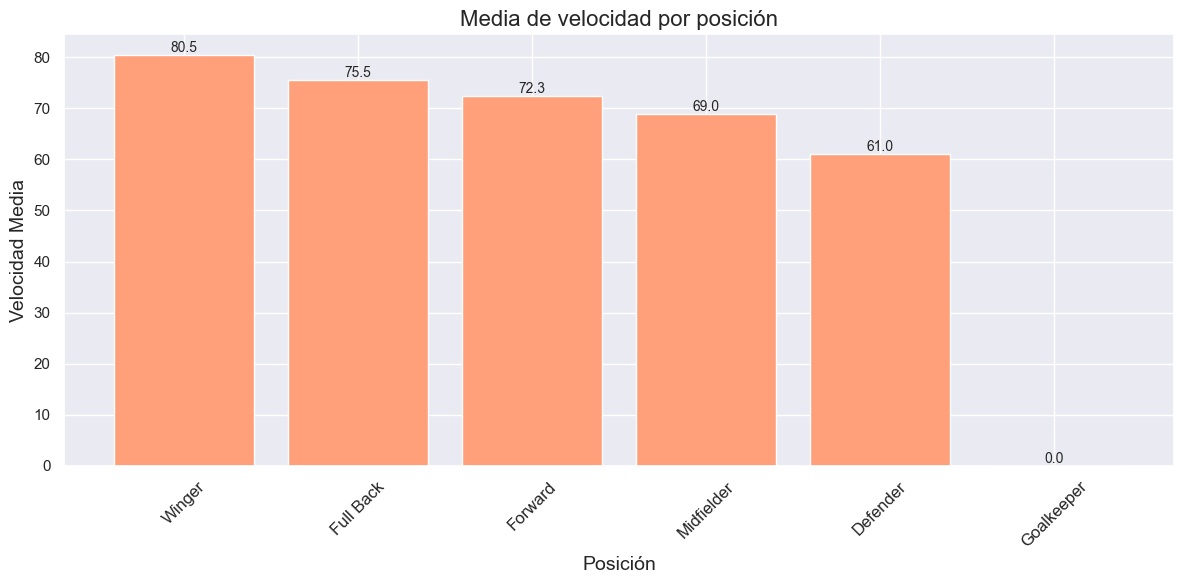

In [494]:
mean_speed_position = df_skills.groupby('position')['speed'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_speed_position.index, mean_speed_position.values, color='lightsalmon')
plt.title('Media de velocidad por posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Velocidad Media', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_speed_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

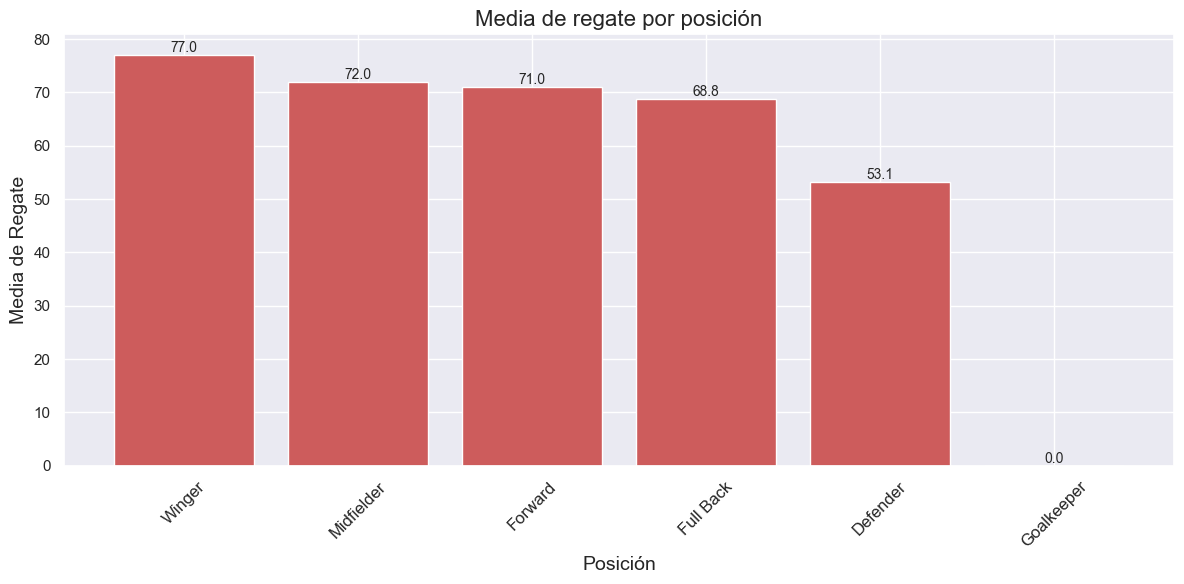

In [495]:
mean_speed_position = df_skills.groupby('position')['dribbling'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_speed_position.index, mean_speed_position.values, color='indianred')
plt.title('Media de regate por posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de Regate', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_speed_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

Los extremos vuelven a ser clave en una habilidad como el regate, por lo que tendrán una tendencia al desborde y aporte ofensivo desde la velocidad y la habilidad regateando. El resto tienen unas puntuaciones similares y altas, influyendo bastante en deshacerse de rivales fácilmente. Los defensas de nuevo tienen la emdia más baja y no parecen ser buenos regateadores, centrándose más en el pase y el físico.

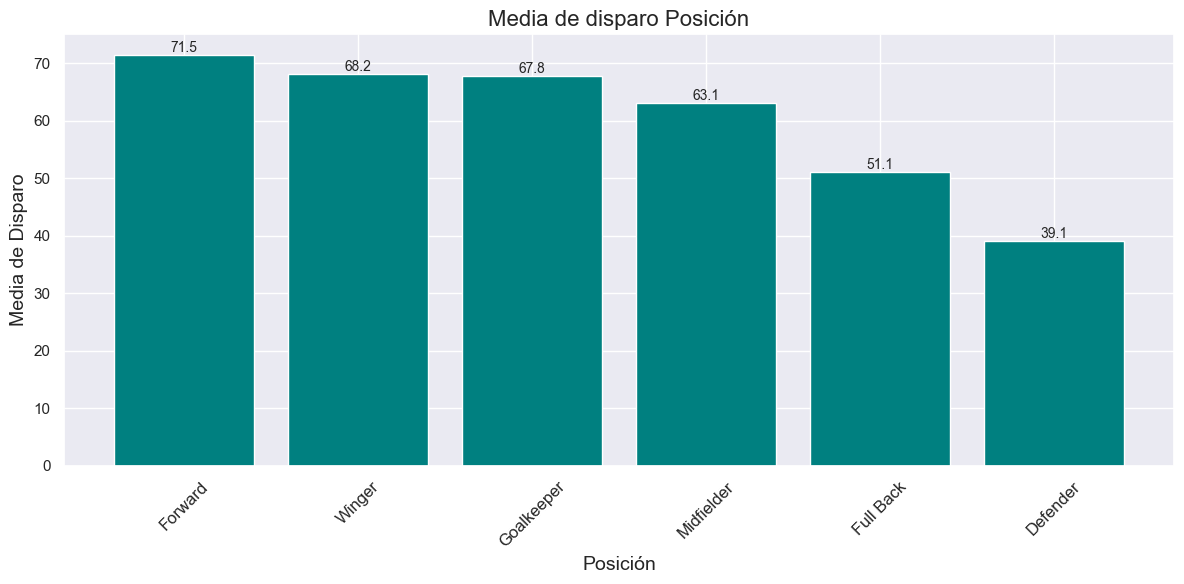

In [496]:
mean_shooting_position = df_skills.groupby('position')['shooting_total'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_shooting_position.index, mean_shooting_position.values, color='teal')
plt.title('Media de disparo Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de Disparo', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_shooting_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

Los delanteros son los jugadores con mejor media de disparo, lo cual define su capacidad ofensiva y para marcar más goles. Le siguen extremos y centrocampistas, jugadores también muy relacionados con la vertiente ofensiva. Los porteros pueden sorprender por su habilidad de disparo, pero en reaidad son los jugadores que ponen el balón en juego desde su área con balones largos a los compañeros en posiciones ofensivas. Por último, se observa una media mucho menor, e incluso baja, para los defensas, que parece que se centran más en labores defensivas y no en disparos.

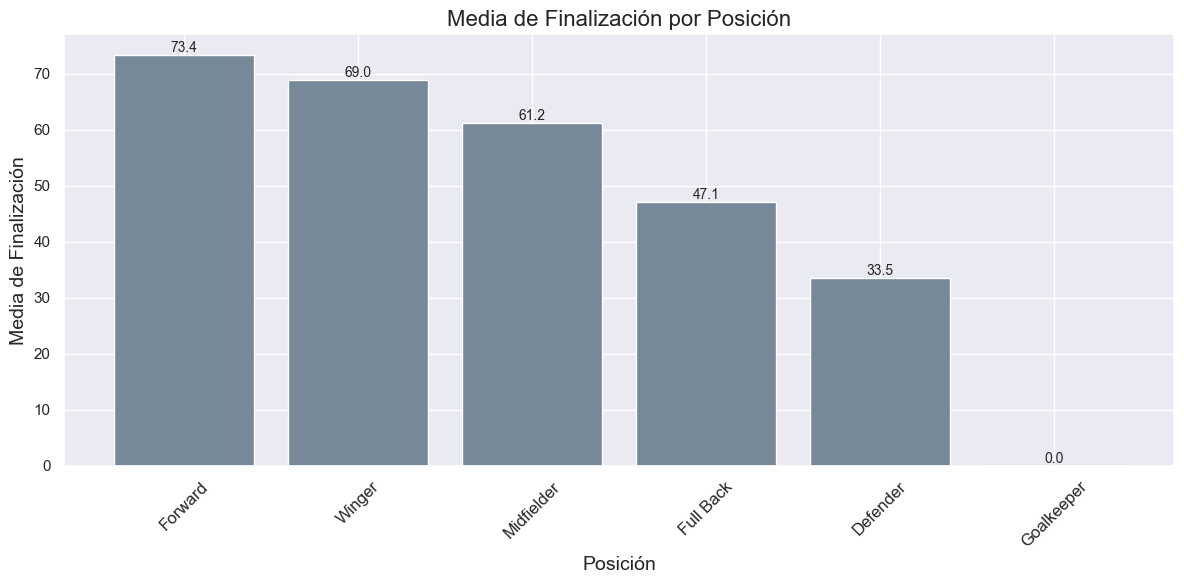

In [497]:
mean_finishing_position = df_skills.groupby('position')['finishing'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_finishing_position.index, mean_finishing_position.values, color='lightslategrey')
plt.title('Media de Finalización por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de Finalización', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_finishing_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

Las dos posiciones más atacantes y ofensivas (delanteros y extremos) son las que mejor finalizan, mientras que los defensas centrales y los laterales son los que menos capacidad de finalización tienen. Aquí se ve claramente la faceta ofensiva vs la defensiva.

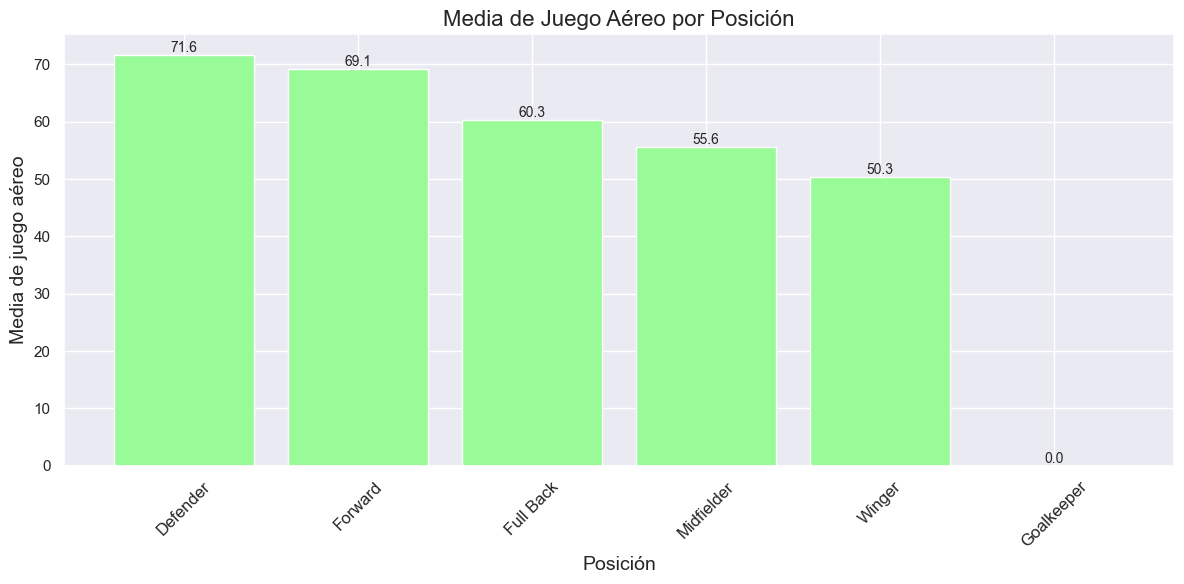

In [498]:
mean_heading_position = df_skills.groupby('position')['heading_accuracy'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_heading_position.index, mean_heading_position.values, color='palegreen')
plt.title('Media de Juego Aéreo por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de juego aéreo', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_heading_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

Los mejores jugadores para el juego aéreo son los delanteros y los defensas. Ambos disputan duelos aéreos, unos para defender y otros para generar peligro de gol, por lo que ambos tienen muy buena habilidad cabeceadora. Sin embargo, los extremos y los centrocampistas tienen una media más baja de cabeceo.

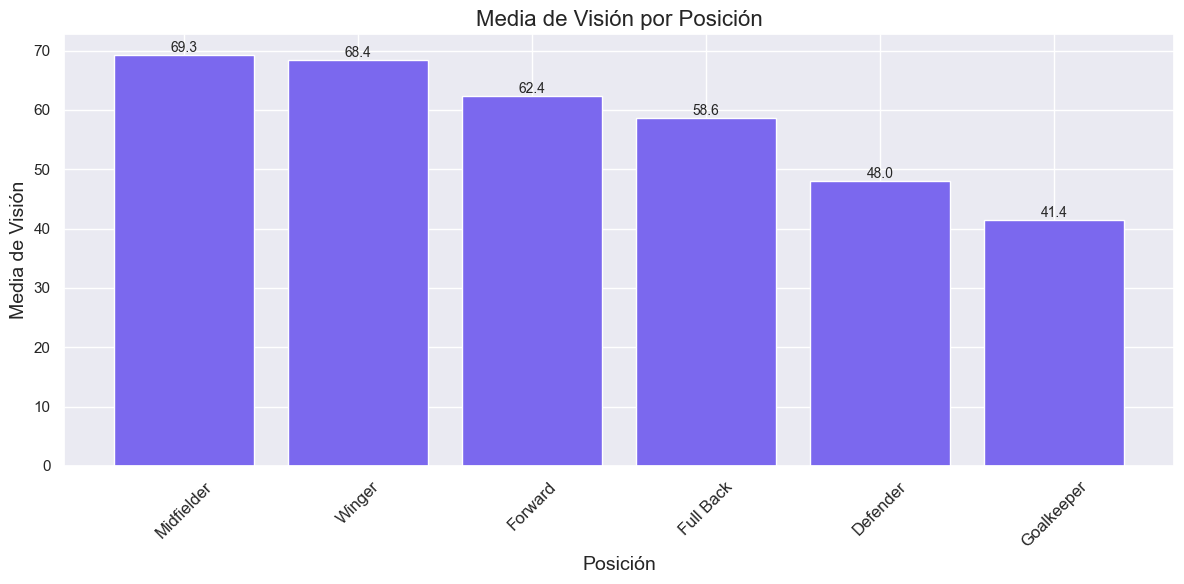

In [499]:
mean_vision_position = df_skills.groupby('position')['vision'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_vision_position.index, mean_vision_position.values, color='#7B68EE')
plt.title('Media de Visión por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de Visión', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_vision_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

Los defensas y porteros son los jugadores con menor visión de juego. Por un lado, el caso de los porteros puede explicarse porque no suelen participar en el juego de campo y la construcción de jugadas.  Los mediocentros son los jugadores con mejor visión de juego, ya que su posición representa la de transición de juego y contrucción entre la parte defensiva y la atacante. Los extremos al estar cerca de los centrocampistas y los delanteros también perecen tener una buena visión de juego para interconectar las posicones y leer el juego.

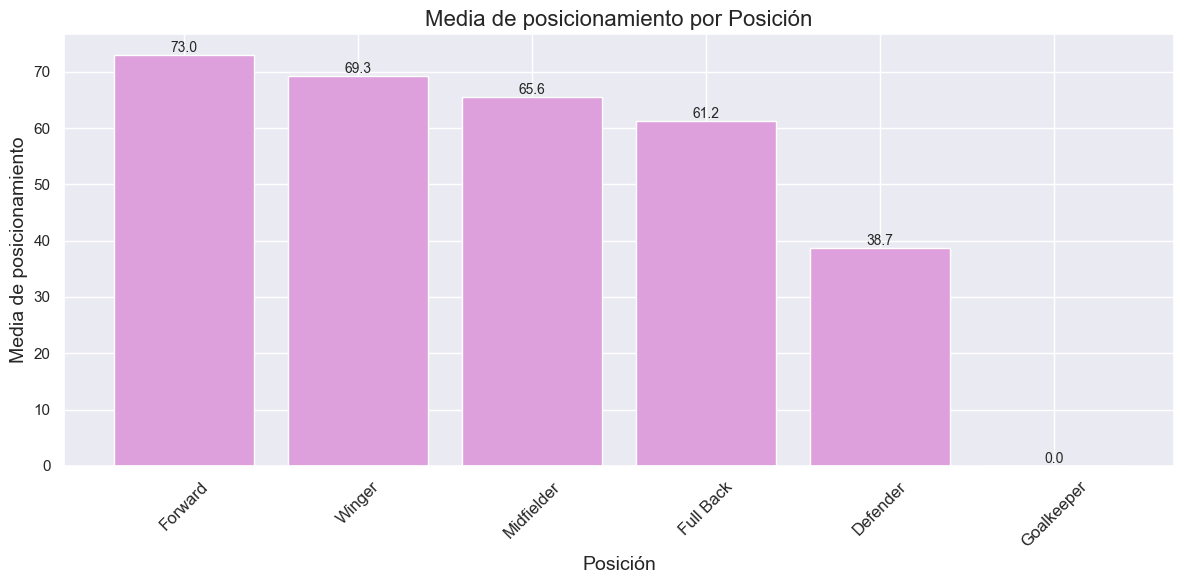

In [500]:
mean_positioning_position = df_skills.groupby('position')['positioning'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_positioning_position.index, mean_positioning_position.values, color='#DDA0DD')
plt.title('Media de posicionamiento por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de posicionamiento', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_positioning_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

Las posiciones con mejor posicionamiento son las asociadas con el juego ofensivo. Los delanteros parecen tener una gran capacidad de posicionamiento, quizá por sus desmarques y busqueda de espacios para generar ocasiones. Los extremos son un caso parecido, mientras que los centrocampistas, al llevar la parte más creativa y la visión del juego (como ya hemos visto) necesitarán mejores posicionamientos para superar al rival.

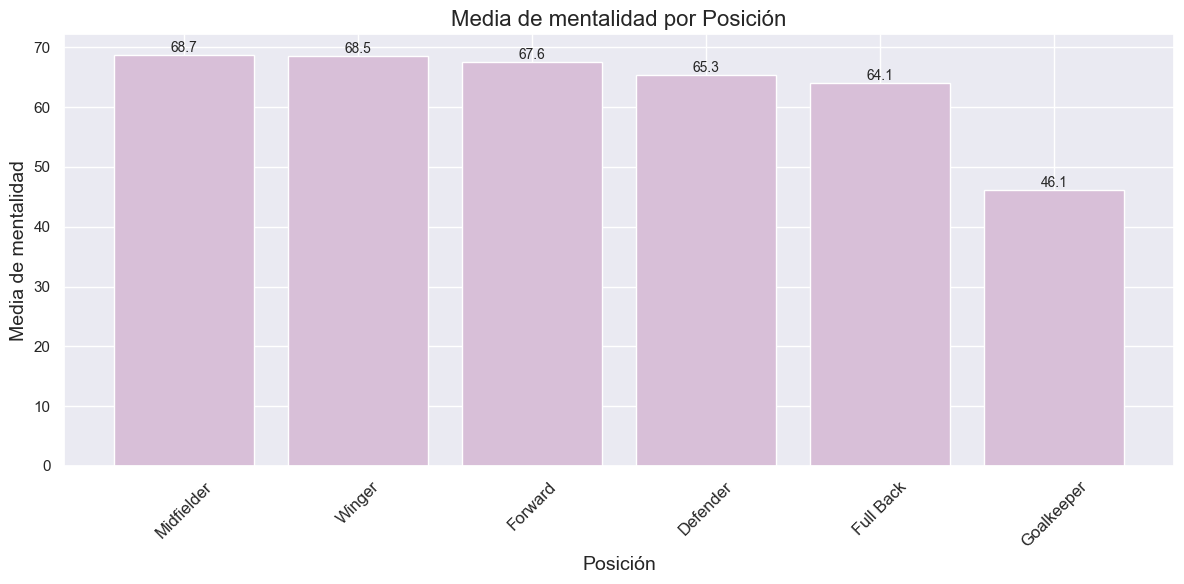

In [501]:
mean_mentality_position = df_skills.groupby('position')['mentality'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_mentality_position.index, mean_mentality_position.values, color='#D8BFD8')
plt.title('Media de mentalidad por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Media de mentalidad', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
for i, value in enumerate(mean_mentality_position.values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

La mentalidad es bastante parecida para todas las posiciones, menos para la de portero, que es mucho más baja. Quizá al estar menos conectado con el resto del equipo con los compañeros pueda ser un factor importante. El resto son muy parecidos, pero la mayor es de los centrocampistas, que al tener esa faceta de interconectar casi todas las posiciones (están en el medio del campo) pueden promediar una mayor habilidad de fortaleza mental y atención y focalización en el juego.

In [502]:
mean_defensive_position = df_skills.groupby('position')['defensive_score'].mean()
mean_offensive_position = df_skills.groupby('position')['offensive_score'].mean()

df_scores_by_position = pd.DataFrame({
    'Position': mean_defensive_position.index,
    'Defensive_Score': mean_defensive_position.values,
    'Offensive_Score': mean_offensive_position.values,
})

df_scores_by_position.T

0          1          2           3           4  \
Position          Defender    Forward  Full Back  Goalkeeper  Midfielder   
Defensive_Score  71.498517  62.126437  66.341684   21.759158   63.102238   
Offensive_Score  46.669306  69.184943  58.494154   22.572527   65.968557   

                         5  
Position            Winger  
Defensive_Score  55.149462  
Offensive_Score  69.866774

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\312753511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_skills, x='position', y='defensive_score', palette='Blues')


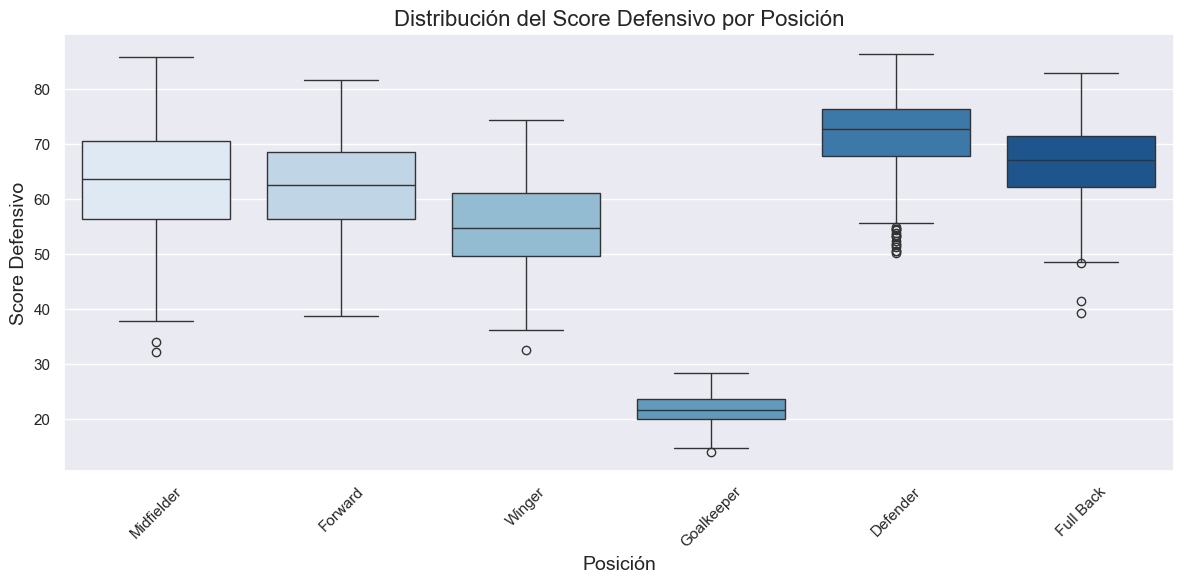

In [503]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_skills, x='position', y='defensive_score', palette='Blues')
plt.title('Distribución del Score Defensivo por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Score Defensivo', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\4077794067.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_skills, x='position', y='offensive_score', palette='Oranges')


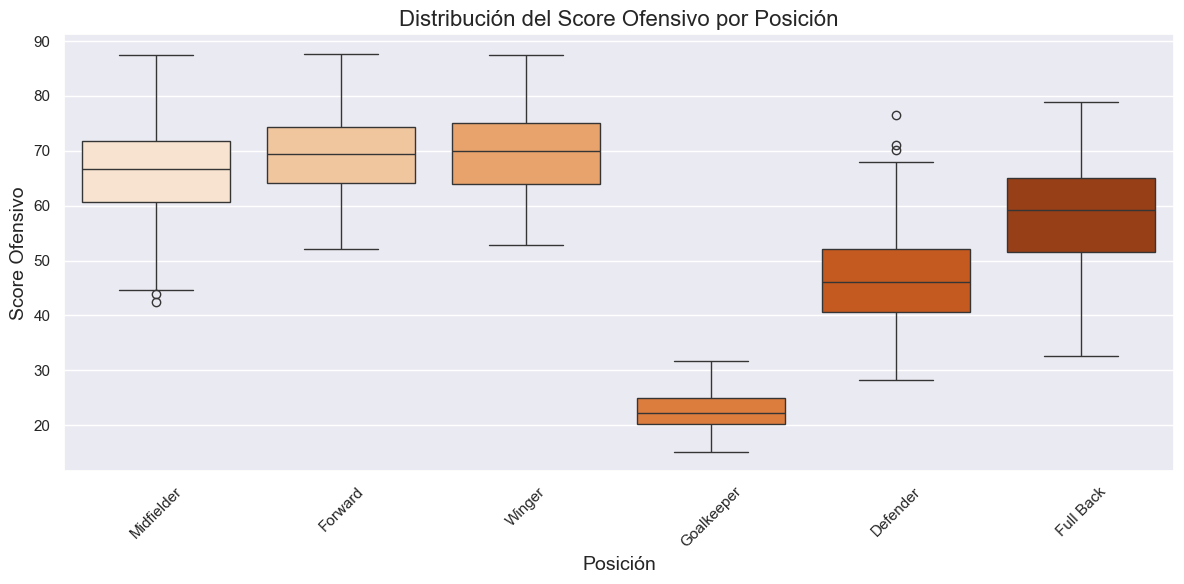

In [504]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_skills, x='position', y='offensive_score', palette='Oranges')
plt.title('Distribución del Score Ofensivo por Posición', fontsize=16)
plt.xlabel('Posición', fontsize=14)
plt.ylabel('Score Ofensivo', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [505]:
df_skills.drop(['defensive_score', 'offensive_score'], axis=1, inplace=True)

___
RELACIÓN POTENCIAL Y OVERALL (puntuación general)

In [506]:
correlation = df_skills[['overall', 'potential']].corr()
correlation

overall  potential
overall    1.000000   0.645994
potential  0.645994   1.000000

En el siguiente gráfico vemos cómo cada en rangos de 4 en 4 años (de 16 años a 40 años) se relaciona con la puntuación general y el potencial. Vemos en primer lugar, que al subir la puntuación general tiende a subir el potencial del jugador también. Lo más importante es que observamos, con los colores del plot, que para cada puntuación general ('overall') los jugadores que tienen más potencial son más jóvenes (puntos superiores del gráfico para cada valor de overall). Esto es así menos para valores por encima de 80 de puntuación total, donde lo que más predominan son jugadores mayores de 20 años. Esto indica que el potencial es un buen parámetro para intuír el overall a futuro de jóvenes promesas


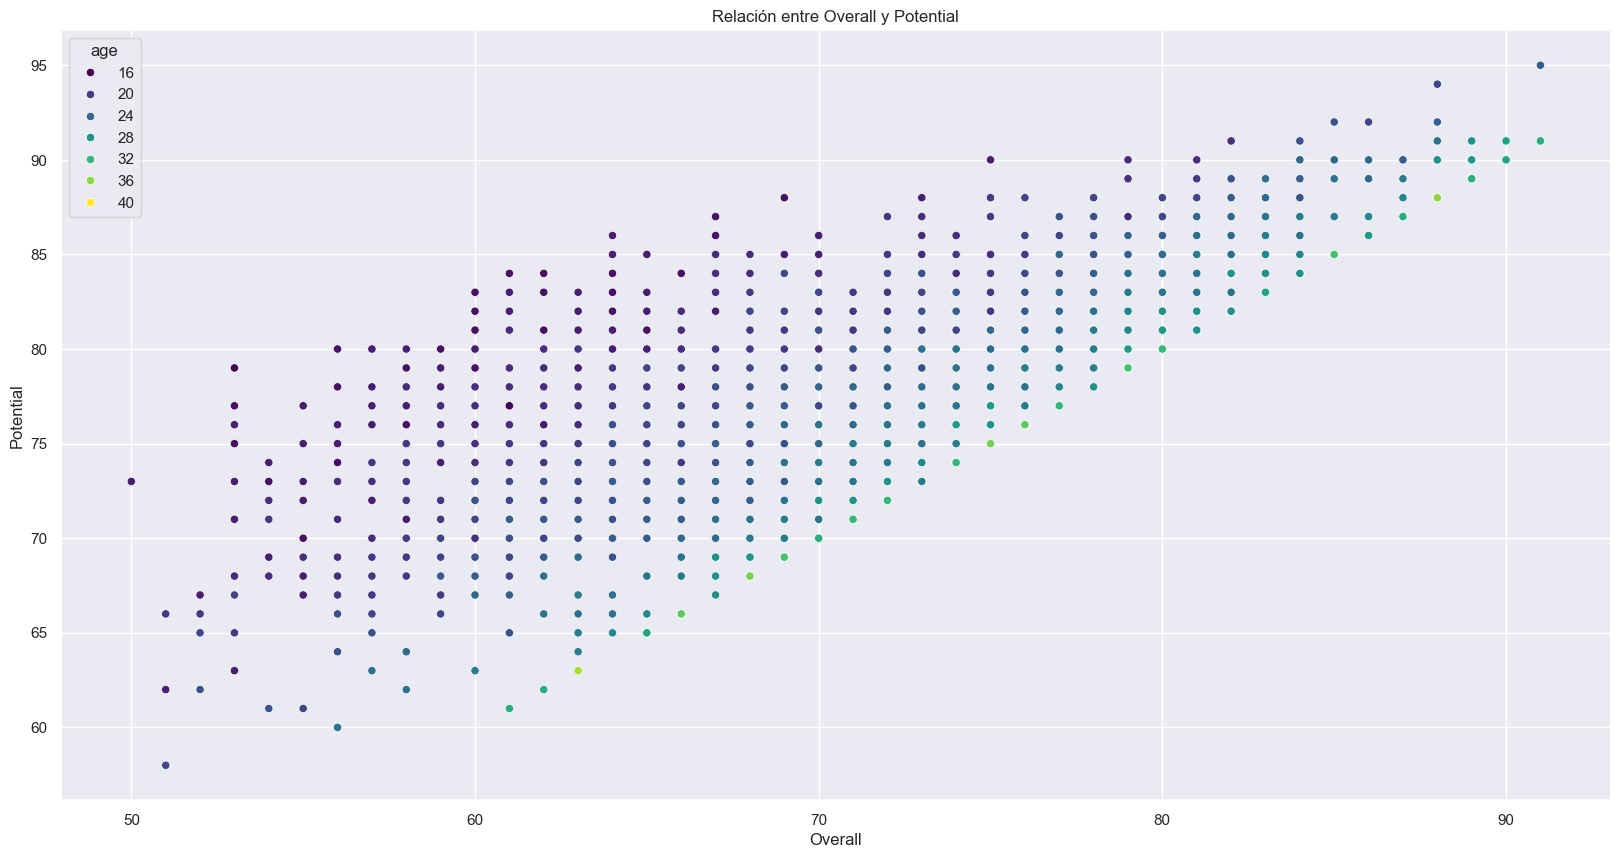

In [507]:
sns.scatterplot(data=df_skills, x='overall', y='potential', hue='age', palette='viridis')
plt.title('Relación entre Overall y Potential')
plt.xlabel('Overall')
plt.ylabel('Potential')
plt.show()

Aquí podemos ver que la diferencia entre overall y potential no suele ser mayor a 20 puntos entre una y otra, siendo lo más habitual que no varíen o solo varíen 1 punto entre ellas, aunque hasta las diferencias de 15 puntos entre ellas hay mucha variablidad en esta diferencia

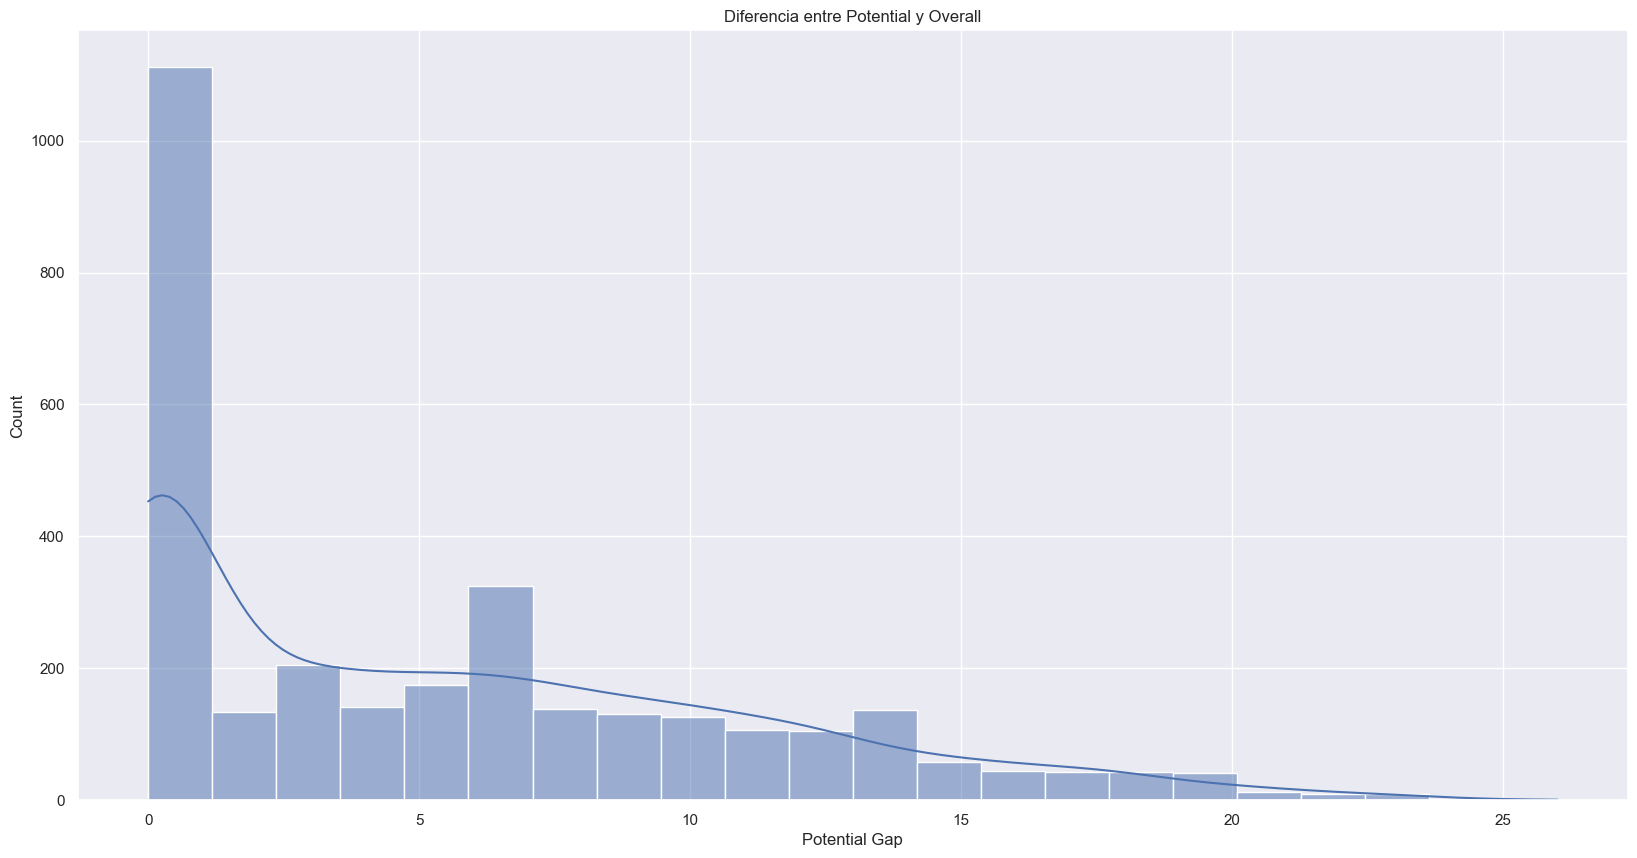

In [508]:
df_skills['potential_gap'] = df_skills['potential'] - df_skills['overall']
sns.histplot(df_skills['potential_gap'], kde=True)
plt.title('Diferencia entre Potential y Overall')
plt.xlabel('Potential Gap')
plt.show()

df_skills.drop('potential_gap', axis=1, inplace=True)

En general se observa que según va aumentando la puntuación general también aumenta el potencial del jugador, salvo por el valor más bajo para valoración total, que tiene un potencial más alto. Esto puede ser por tener pocos valores en esa puntuación general, que genera una media superior al resto de puntuaciones, donde hay más registros para hacer la media y no tiene tanto error como cuando se tienen pocos registros para un valor

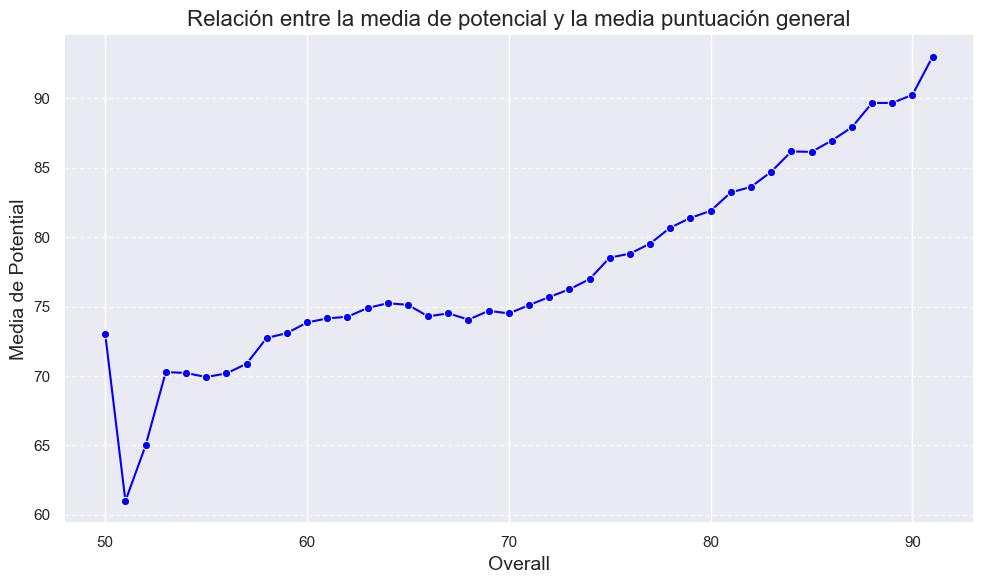

In [509]:
mean_potential_overall = df_skills.groupby('overall')['potential'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_potential_overall.index, y=mean_potential_overall.values, marker='o', color='blue')
plt.title('Relación entre la media de potencial y la media puntuación general', fontsize=16)
plt.xlabel('Overall', fontsize=14)
plt.ylabel('Media de Potential', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

RELACION VALOR DE MERCADO Y OVERALL (puntuación general)

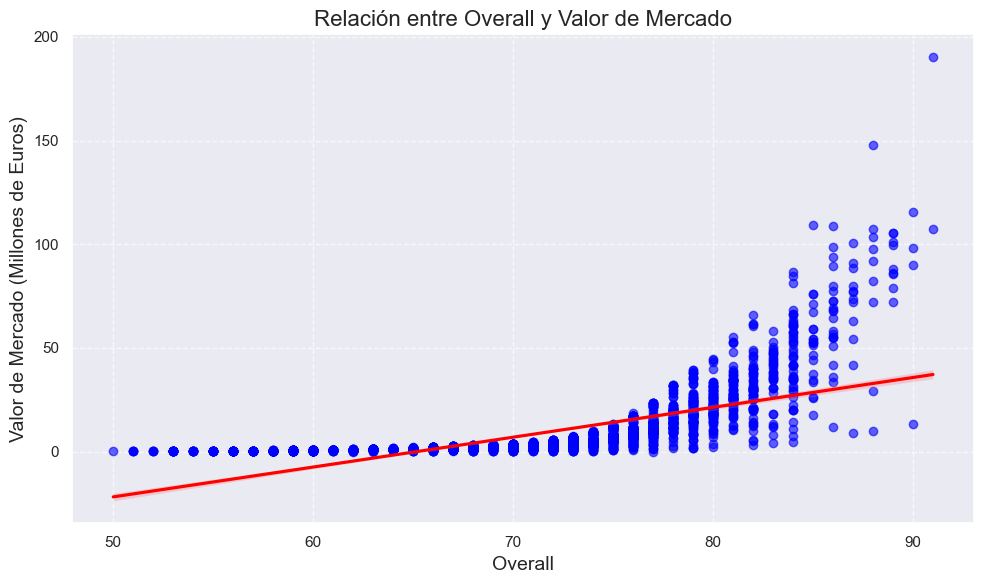

In [510]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df_skills, x='overall', y='value_million_euro', color='blue', scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Relación entre Overall y Valor de Mercado', fontsize=16)
plt.xlabel('Overall', fontsize=14)
plt.ylabel('Valor de Mercado (Millones de Euros)', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Vemos como la relación entre la puntuación general y el valor de mercado es bastante proporcional, ya que cuando una sube, la otra también lo hace. A mayor puntuación, mayor valor de mercado del futbolista. Solamente para la puntuación 90 hay un ligero descenso con respecto al valor de mercado, pero parece poco significativo por el momento

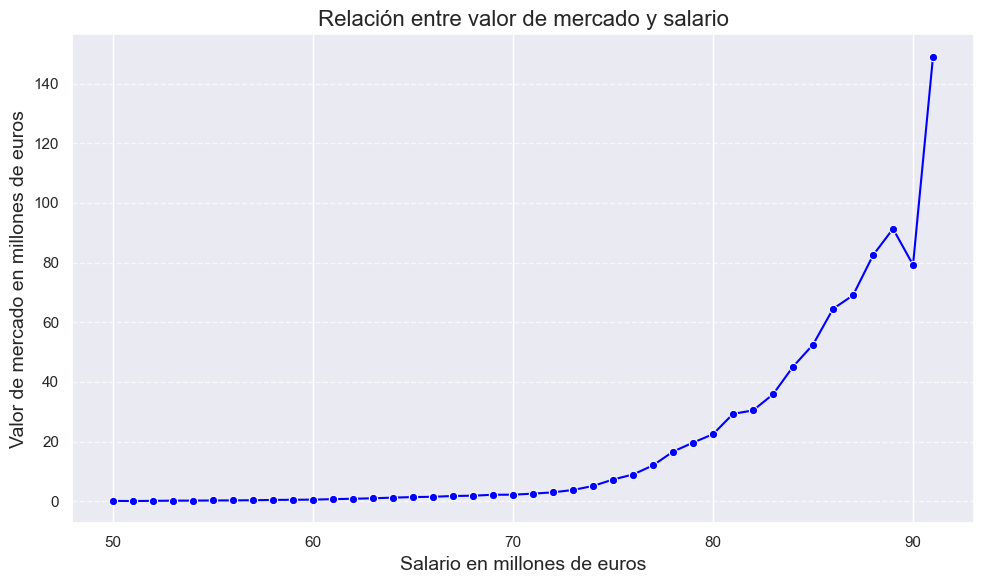

In [511]:
mean_value_overall = df_skills.groupby('overall')['value_million_euro'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_value_overall.index, y=mean_value_overall.values, marker='o', color='blue')
plt.title('Relación entre valor de mercado y salario', fontsize=16)
plt.xlabel('Salario en millones de euros', fontsize=14)
plt.ylabel('Valor de mercado en millones de euros', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

RELACION VALOR DE MERCADO Y SALARIO

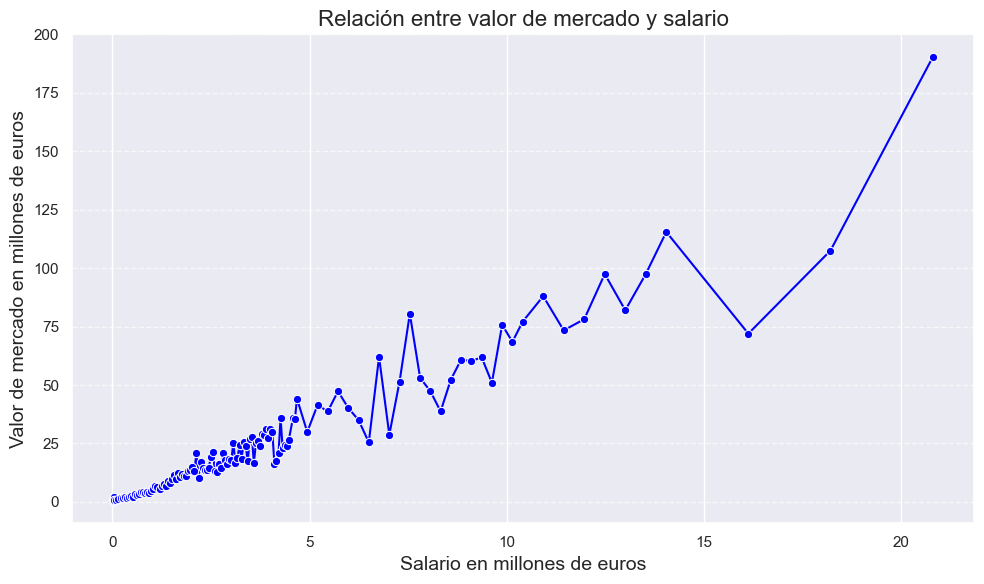

In [512]:
mean_value_wage = df_skills.groupby('wage_million_euro')['value_million_euro'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_value_wage.index, y=mean_value_wage.values, marker='o', color='blue')
plt.title('Relación entre valor de mercado y salario', fontsize=16)
plt.xlabel('Salario en millones de euros', fontsize=14)
plt.ylabel('Valor de mercado en millones de euros', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

La relación entre el salario y el valor de mercado también es proporcional y tiene una pendiente ascendente, que muestra que por lo general según sube el valor de mercado del jugador, sube el salario del mismo (y viceversa). Aquí sin embargo hay un mayor número de casos que se salen un poco de la media y van haciendo que dependiendo del salario exacto varíe la tendencia del valor de mercado arriba o abajo, pero la tendencia es claramente ascendente, como demuestran los gráficos

<Axes: xlabel='wage_million_euro'>

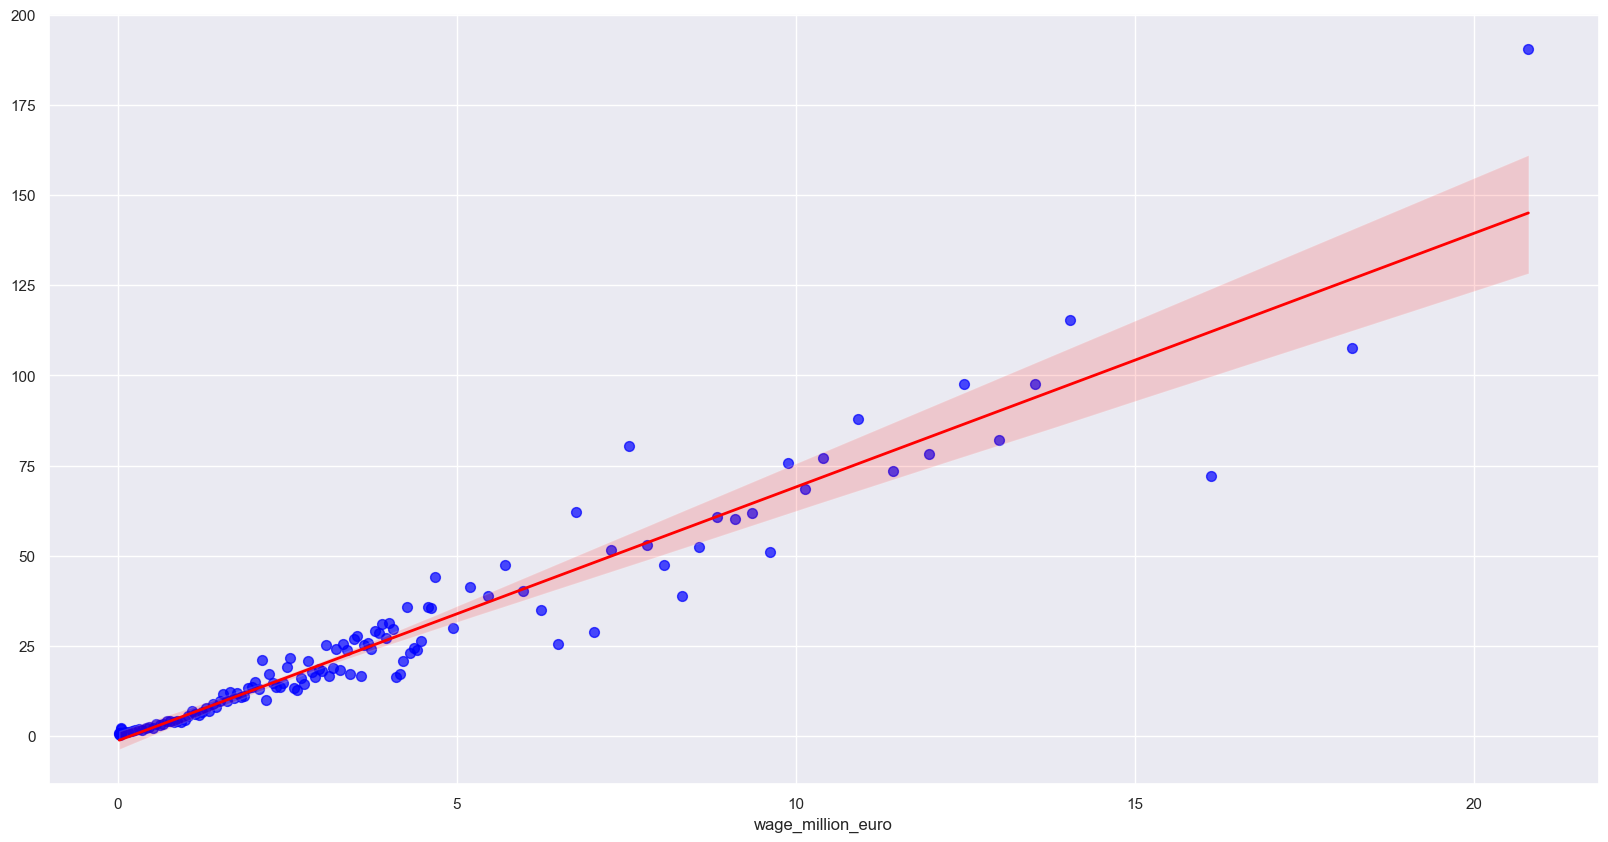

In [513]:
sns.regplot(
    x=mean_value_wage.index, 
    y=mean_value_wage.values, 
    scatter_kws={'color': 'blue', 's': 50, 'alpha': 0.7},
    line_kws={'color': 'red', 'lw': 2},)

CONSLUSIONES DEL ANÁLISIS DE RELACIONES ENTRE VARIABLES:

La edad de los jugadores está estrechamente ligada a varias habilidades, como la puntuación general (overall), el físico y el disparo, con una relación moderada con el salario. A medida que los jugadores envejecen, tienden a mejorar en estas habilidades, aunque hay ciertas habilidades que tienden a estabilizarse a partir de los 30 años. Otras como ritmo, velocidad, potencial y fuerza tienen un tendencia descendente con la edad. La visión de juego y la mentalidad aumentan con la edad y se mantienen altas a partir de 30 años, mostrando habilidades que parecen adquirirse por la experiencia. En los más jóvenes se observa una buena progresión de la fuerza y el disparo hasta que se estabiliza y luego disminuye al final de sus carreras.

La puntuación general y el potencial están bastante relacionadas, lo que indica que cuando un jugador tiene una puntuación general alta, su potencial también suele ser elevado. Esto nos muestra la importancia del potencial para prever el desarrollo de un jugador a futuro. Por último, los jugadores veteranos a menudo muestran una buena puntuación general, pero su potencial tiende a ser más bajo.

El valor de mercado y el salario están muy correlacionados, por lo que a medida que un jugador incrementa su valor de mercado, su salario también se ajusta y aumenta. Esto puede reflejar la importancia del valor comercial de los jugadores e incluso podría estudiarse la relación con patrocinios y marketing. Cabe destacar que una vez que los jugadores superan los 30 años, aunque su salario sigue siendo alto (pero va descendiendo), tanto el valor de mercado si tiene un descenso bastante notable según se acerca su retirada. Estas variables en cuanto a la posición, muestran que los extremos son los jugadores que más salario ganan, seguidos por los delanteros. Los defensas y los porteros tienen salarios más bajos en comparación, lo que refleja la mayor valoración de las posiciones ofensivas en el fútbol. Esto también se refleja en el valor de mercado, con los delanteros y extremos siendo los que tienen valores más altos.

Las posiciones ofensivas, como los extremos y los delanteros, dominan en habilidades como el ritmo, el regate y el disparo, lo que refleja su rol atacante. Por otro lado, los defensas y porteros tienden a destacar más en aspectos físicos, como la fuerza y el cabezazo, aspectos defensivos. Los jugadores más altos tienden a tener menor agilidad y velocidad, aunque tienen buena puntuación física, lo que indica que su juego puede depender más de la fuerza que de la habilidad técnica.


____
### MODELOS

#### MODELO DE CLUSTERIZACIÓN PARA CLASIFICAR LOS JUGADORES POR SUS HABILIDADES Y JUEGO

In [514]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [515]:
df_skills.columns

Index(['name', 'overall', 'potential', 'value_million_euro', 'position',
       'nationality', 'age', 'age_group', 'height', 'team', 'formation',
       'league', 'wage_million_euro', 'preferred_foot', 'weak_foot_rating',
       'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
       'defending_total', 'physicality_total', 'finishing', 'heading_accuracy',
       'dribbling', 'ball_control', 'balance', 'shot_power', 'strength',
       'long_shots', 'aggression', 'positioning', 'vision', 'penalties',
       'mentality', 'goalkeeper_diving', 'goalkeeper_handling',
       'goalkeeper_kicking', 'goalkeeper_positioning', 'goalkeeper_reflexes',
       'passing', 'speed'],
      dtype='object')

Primero escogemos las variables más importantes para cubrir las habilidades de un futbolista que definan su juego

In [516]:
player_skills = ['overall', 'potential','skill_moves', 'attacking_work_rate',
       'defensive_work_rate','pace_total', 'shooting_total', 'passing_total',
       'dribbling_total', 'defending_total', 'physicality_total', 'finishing',
       'heading_accuracy','dribbling', 'ball_control', 'balance', 'shot_power',
       'strength', 'long_shots', 'aggression', 'positioning', 'vision', 'penalties',
       'mentality','passing', 'speed']

df_player_skills = df_skills[player_skills]

In [517]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_player_skills)

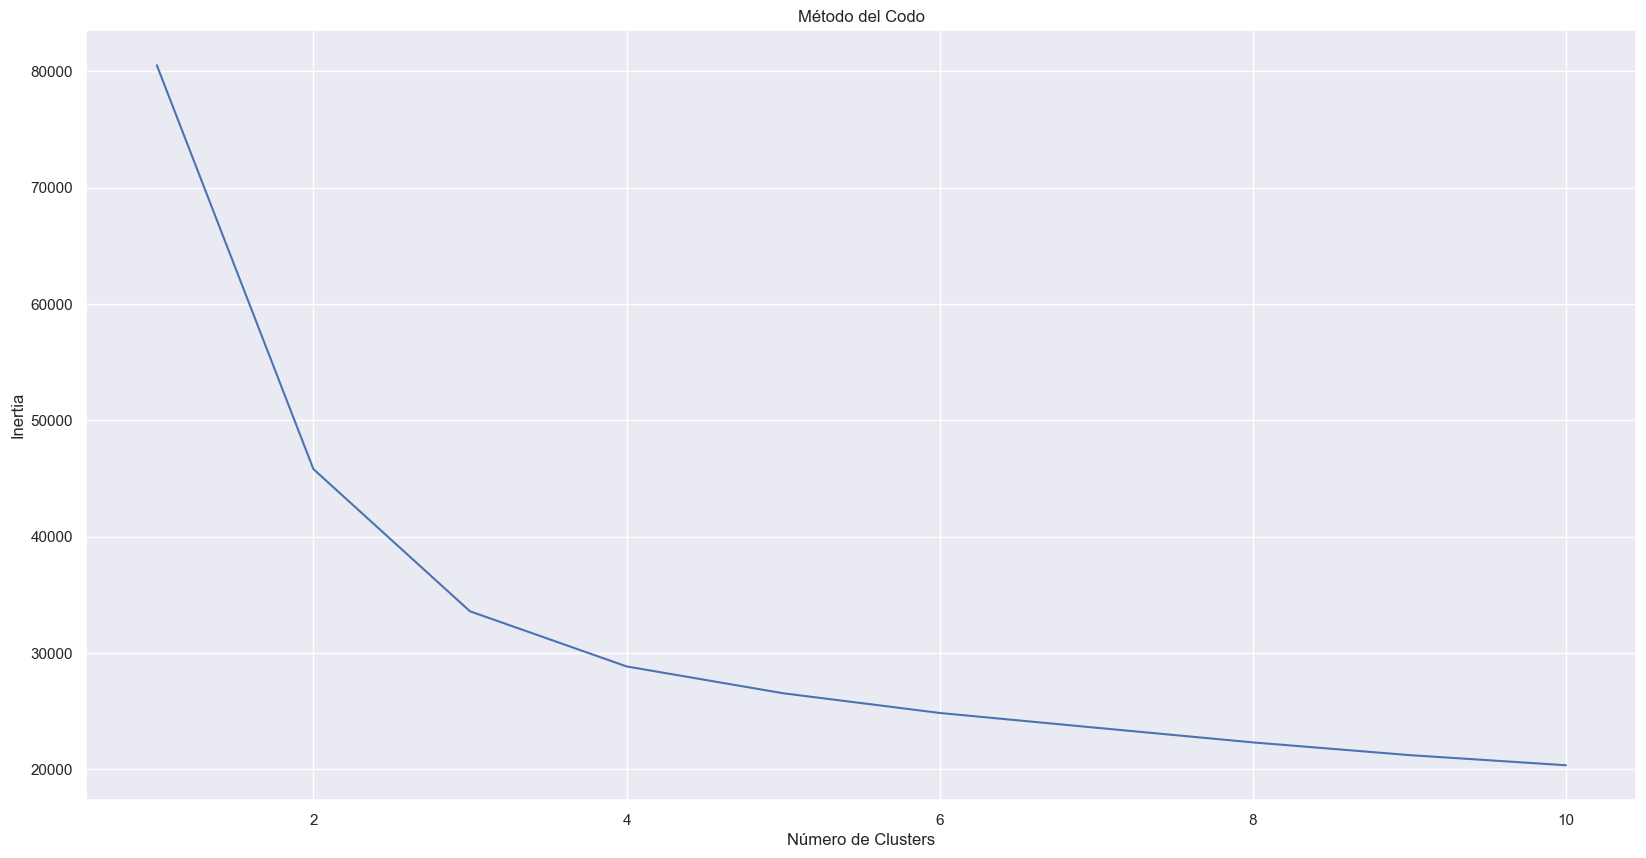

In [518]:
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()

Según el método del codo lo ideal serían 3 o 4 clusters, así que vamos a probar lo que mejor se ajusta a los datos y grupos que se creen

In [519]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)

df_skills['players_cluster'] = kmeans.fit_predict(df_scaled)

In [520]:
cluster_means = df_skills.groupby('players_cluster')[player_skills].mean()
cluster_means

overall  potential  skill_moves  attacking_work_rate  \
players_cluster                                                           
0                76.883929  79.681006     3.221591             1.520292   
1                69.629121  74.837912     0.000000             1.000000   
2                65.813602  75.190176     2.704030             1.381612   
3                70.323904  76.398868     2.086280             0.929279   

                 defensive_work_rate  pace_total  shooting_total  \
players_cluster                                                    
0                           1.218344   72.540584       68.650162   
1                           1.000000    0.000000       67.785714   
2                           0.937028   71.778338       57.423174   
3                           1.364922   62.404526       38.892504   

                 passing_total  dribbling_total  defending_total  ...  \
players_cluster                                                   ...   
0                    71.626623        75.714286        58.988636  ...   
1                    66.524725         0.000000         0.000000  ...   
2                    59.085642        66.707809        43.686398  ...   
3                    54.611033        58.036775        69.951909  ...   

                 shot_power   strength  long_shots  aggression  positioning  \
players_cluster                                                               
0                 74.713474  70.384740   68.975649   68.915584    71.852273   
1                 50.021978  62.129121    0.000000    0.000000     0.000000   
2                 61.949622  56.802267   55.238035   52.129723    60.808564   
3                 52.663366  75.360679   36.765205   70.408769    41.120226   

                    vision  penalties  mentality    passing      speed  
players_cluster                                                         
0                71.995130  62.405844  74.384740  72.774756  72.564529  
1                41.392857   0.000000  46.074176   0.000000   0.000000  
2                58.326196  54.498741  59.369018  60.054156  71.816121  
3                48.239038  42.083451  62.827440  61.794201  62.193069  

[4 rows x 26 columns]

In [521]:
player_style_labels = {0: 'Jugador físico', 1: 'Jugador destacado', 2:'Portero', 3: 'Jugador versátil'}

df_skills['playing_style'] = df_skills['players_cluster'].map(player_style_labels)

In [522]:
import joblib
joblib.dump(kmeans, 'kmeans_player_style_skills_model.pkl')

kmeans = joblib.load('kmeans_player_style_skills_model.pkl')

df_skills['players_cluster'] = kmeans.predict(df_scaled)
df_skills['playing_style'] = df_skills['players_cluster'].map(player_style_labels)

Vamos a visualizar los clusters ya etiquetados para comprobar que estemos haciendo un análisis correcto:

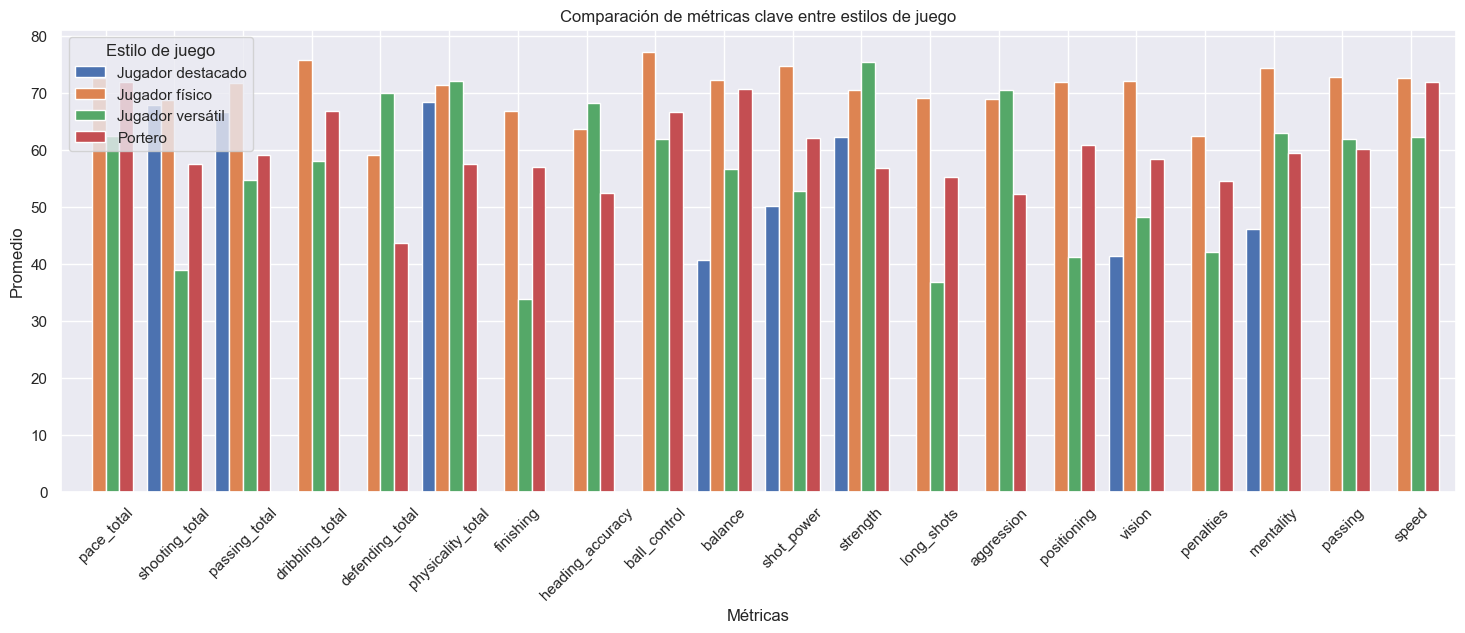

In [523]:
stats_to_plot = df_skills.groupby('playing_style')[[
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
       'defending_total', 'physicality_total', 'finishing', 'heading_accuracy',
       'ball_control', 'balance', 'shot_power', 'strength',
       'long_shots', 'aggression', 'positioning', 'vision', 'penalties',
       'mentality','passing', 'speed']].mean()

stats_to_plot = stats_to_plot.T

stats_to_plot.plot(kind='bar', figsize=(18, 6), width=0.8)
plt.title("Comparación de métricas clave entre estilos de juego")
plt.ylabel("Promedio")
plt.xlabel("Métricas")
plt.xticks(rotation=45)
plt.legend(title="Estilo de juego")
plt.show()

Vemos como los jugadores destacados dominan muchas de las habilidades, como ritmo, disparo, pase, finalización, control de balón, posicionamiento, visión o mentalidad. Los jugadores físicos dominan en cuanto a habilidades defensivas, el físico, la fuerza, el cabeceo o la agresividad. Los porteros, aunque son los líderes en ninguna habilidad (salvo las de portero), destacan en habilidades como la fuerza, el físico y el disparo. Los jugadores versátiles son muy equilibrados en casi todas las categorías, teneindo valores intermedio. Destacan en balnace, velocidad y regate, pero promedian menos que el resto en agresividad o cabeceo.

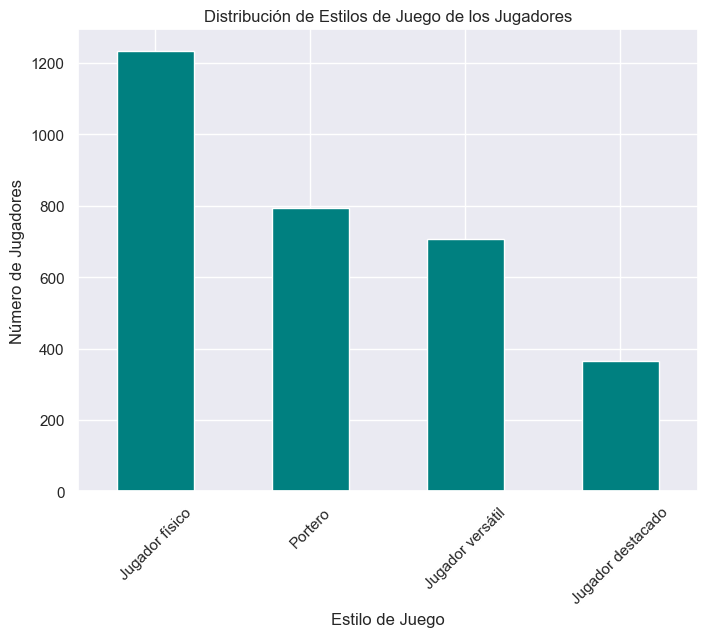

In [524]:
player_style_counts = df_skills['playing_style'].value_counts()

plt.figure(figsize=(8, 6))
player_style_counts.plot(kind='bar', color='teal')
plt.title('Distribución de Estilos de Juego de los Jugadores')
plt.xlabel('Estilo de Juego')
plt.ylabel('Número de Jugadores')
plt.xticks(rotation=45)
plt.show()

Optamos por utilizar PCA para poder visualizar estos conjuntos enormes de datos y que podamos observar grupos e identificar tendencias

In [525]:
from sklearn.decomposition import PCA

In [526]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

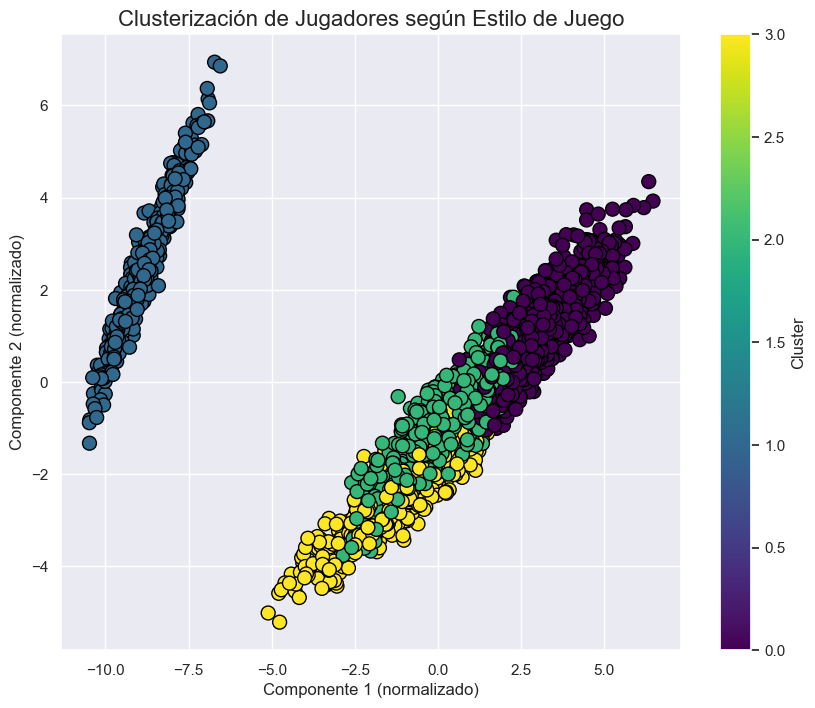

In [527]:
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_skills['players_cluster'], cmap='viridis', s=100, edgecolor='black')

plt.title("Clusterización de Jugadores según Estilo de Juego", fontsize=16)
plt.xlabel("Componente 1 (normalizado)", fontsize=12)
plt.ylabel("Componente 2 (normalizado)", fontsize=12)
plt.colorbar(label='Cluster')
plt.show()

In [528]:
df_skills[['name', 'playing_style']].head()

name      playing_style
3     Kevin De Bruyne     Jugador físico
26      Kylian Mbappé     Jugador físico
53      Mohamed Salah     Jugador físico
82   Thibaut Courtois  Jugador destacado
109      Manuel Neuer  Jugador destacado

In [529]:
player_style = df_skills[df_skills['name'] == 'Mohamed Salah']
player_style[['name', 'team', 'playing_style']].head()

name       team   playing_style
53  Mohamed Salah  Liverpool  Jugador físico

In [530]:
player_style = df_skills[df_skills['name'] == 'Jan Oblak']
player_style[['name', 'team', 'playing_style']].head()

name             team      playing_style
250  Jan Oblak  Atletico Madrid  Jugador destacado

In [531]:
player_style = df_skills[df_skills['name'] == 'Takefusa Kubo']
player_style[['name', 'team', 'playing_style']].head()

name           team playing_style
37116  Takefusa Kubo  Real Sociedad       Portero

In [532]:
player_style = df_skills[df_skills['name'] == 'Randal Kolo Muani']
player_style[['name', 'team', 'playing_style']].head()

name                 team   playing_style
15353  Randal Kolo Muani  Paris Saint-Germain  Jugador físico

In [533]:
player_style = df_skills[df_skills['name'] == 'Jonathan Tah']
player_style[['name', 'team', 'playing_style']].head()

name              team     playing_style
4921  Jonathan Tah  Bayer Leverkusen  Jugador versátil

In [534]:
player_style = df_skills[df_skills['name'] == 'Nicolas Jackson']
player_style[['name', 'team', 'playing_style']].head()

name     team playing_style
49156  Nicolas Jackson  Chelsea       Portero

In [535]:
player_style = df_skills[df_skills['name'] == 'Virgil van Dijk']
player_style[['name', 'team', 'playing_style']].head()

name       team   playing_style
140  Virgil van Dijk  Liverpool  Jugador físico

In [536]:
player_style = df_skills[df_skills['name'] == 'Chris Smalling']
player_style[['name', 'team', 'playing_style']].head()

name  team     playing_style
7628  Chris Smalling  Roma  Jugador versátil

In [537]:
player_style = df_skills[df_skills['name'] == 'Manuel Neuer']
player_style[['name', 'team', 'playing_style']].head()

name           team      playing_style
109  Manuel Neuer  Bayern Munich  Jugador destacado

____

#### ANALISIS DE SIMILITUD CON COSINE SIMILARITY

In [538]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [539]:
df_skills.columns

Index(['name', 'overall', 'potential', 'value_million_euro', 'position',
       'nationality', 'age', 'age_group', 'height', 'team', 'formation',
       'league', 'wage_million_euro', 'preferred_foot', 'weak_foot_rating',
       'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
       'defending_total', 'physicality_total', 'finishing', 'heading_accuracy',
       'dribbling', 'ball_control', 'balance', 'shot_power', 'strength',
       'long_shots', 'aggression', 'positioning', 'vision', 'penalties',
       'mentality', 'goalkeeper_diving', 'goalkeeper_handling',
       'goalkeeper_kicking', 'goalkeeper_positioning', 'goalkeeper_reflexes',
       'passing', 'speed', 'players_cluster', 'playing_style'],
      dtype='object')

De nuevo, seleccionamos las variables (y habilidades) más importantes para poder observar las similitudes:

In [540]:
features = [
        'overall', 'potential', 'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
       'defending_total', 'physicality_total', 'finishing', 'heading_accuracy',
       'dribbling', 'ball_control', 'balance', 'shot_power', 'strength',
       'long_shots', 'aggression', 'positioning', 'vision', 'penalties',
       'mentality', 'goalkeeper_diving', 'goalkeeper_handling',
       'goalkeeper_kicking', 'goalkeeper_positioning', 'goalkeeper_reflexes',
       'passing', 'speed'     
]

X = df_skills[features]

In [541]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Creamos una matriz de similaridad para tener todos los jugadores relacionados entre ellos y cuantificados, para entonces solo tener que filtrar para recomendar las mejores opciones

In [542]:
similarity_matrix = cosine_similarity(X_scaled)

similarity_df = pd.DataFrame(similarity_matrix, index=df_skills['name'], columns=df_skills['name'])

similarity_df.head()

name              Kevin De Bruyne  Kylian Mbappé  Mohamed Salah  \
name                                                              
Kevin De Bruyne          1.000000       0.827726       0.930026   
Kylian Mbappé            0.827726       1.000000       0.949909   
Mohamed Salah            0.930026       0.949909       1.000000   
Thibaut Courtois        -0.226178      -0.238483      -0.268750   
Manuel Neuer            -0.121057      -0.169834      -0.192795   

name              Thibaut Courtois  Manuel Neuer  Virgil van Dijk  Harry Kane  \
name                                                                            
Kevin De Bruyne          -0.226178     -0.121057         0.670779    0.951222   
Kylian Mbappé            -0.238483     -0.169834         0.511320    0.804379   
Mohamed Salah            -0.268750     -0.192795         0.567955    0.902166   
Thibaut Courtois          1.000000      0.976458        -0.116745   -0.217467   
Manuel Neuer              0.976458      1.000000        -0.048267   -0.120597   

name              Heung Min Son  Carlos Henrique Venancio Casimiro  Jan Oblak  \
name                                                                            
Kevin De Bruyne        0.925430                           0.808022  -0.177445   
Kylian Mbappé          0.945140                           0.601317  -0.203747   
Mohamed Salah          0.973964                           0.692731  -0.226262   
Thibaut Courtois      -0.275106                          -0.129993   0.991502   
Manuel Neuer          -0.193718                          -0.045886   0.989744   

name              ...  Gianluca Saro  Rayane El Khamali  Rico Richards  \
name              ...                                                    
Kevin De Bruyne   ...      -0.745476          -0.590864      -0.587587   
Kylian Mbappé     ...      -0.747371          -0.517360      -0.454854   
Mohamed Salah     ...      -0.793732          -0.539244      -0.490233   
Thibaut Courtois  ...       0.696808          -0.240858      -0.204909   
Manuel Neuer      ...       0.641670          -0.296256      -0.294598   

name              Saul Shotton  Alessandro Circati  Abdallah Basit  Ted Cann  \
name                                                                           
Kevin De Bruyne      -0.918230           -0.912499       -0.785674 -0.788073   
Kylian Mbappé        -0.820908           -0.786158       -0.741718 -0.779517   
Mohamed Salah        -0.881992           -0.865920       -0.759952 -0.823239   
Thibaut Courtois     -0.003858            0.006455       -0.245184  0.656374   
Manuel Neuer         -0.112877           -0.110612       -0.308963  0.595166   

name              Dorian Ciezkowski  Igor Lucatelli  Edoardo Corvi  
name                                                                
Kevin De Bruyne           -0.804476       -0.819298      -0.798962  
Kylian Mbappé             -0.805289       -0.804544      -0.800112  
Mohamed Salah             -0.840212       -0.845485      -0.824190  
Thibaut Courtois           0.603926        0.613465       0.597310  
Manuel Neuer               0.550059        0.551669       0.537357  

[5 rows x 3097 columns]

In [543]:
player_name = 'Toni Kroos'
similarity_to_player = similarity_df.loc[player_name]

similar_players = similarity_to_player.sort_values(ascending=False).drop(player_name)

print(f"Jugadores más parecidos a {player_name}:\n")
print(similar_players.head(10))

Jugadores más parecidos a Toni Kroos:

name
Daniel Parejo Muñoz        0.983744
Ivan Rakitić               0.960747
Fabián Ruiz Peña           0.947384
Florian Neuhaus            0.937196
Luka Modrić                0.928614
Carlos Soler Barragán      0.928381
Jorge Resurrección         0.926014
Luiz Frello Filho Jorge    0.922886
Saša Lukić                 0.922412
Marcelo Brozović           0.918726
Name: Toni Kroos, dtype: float64


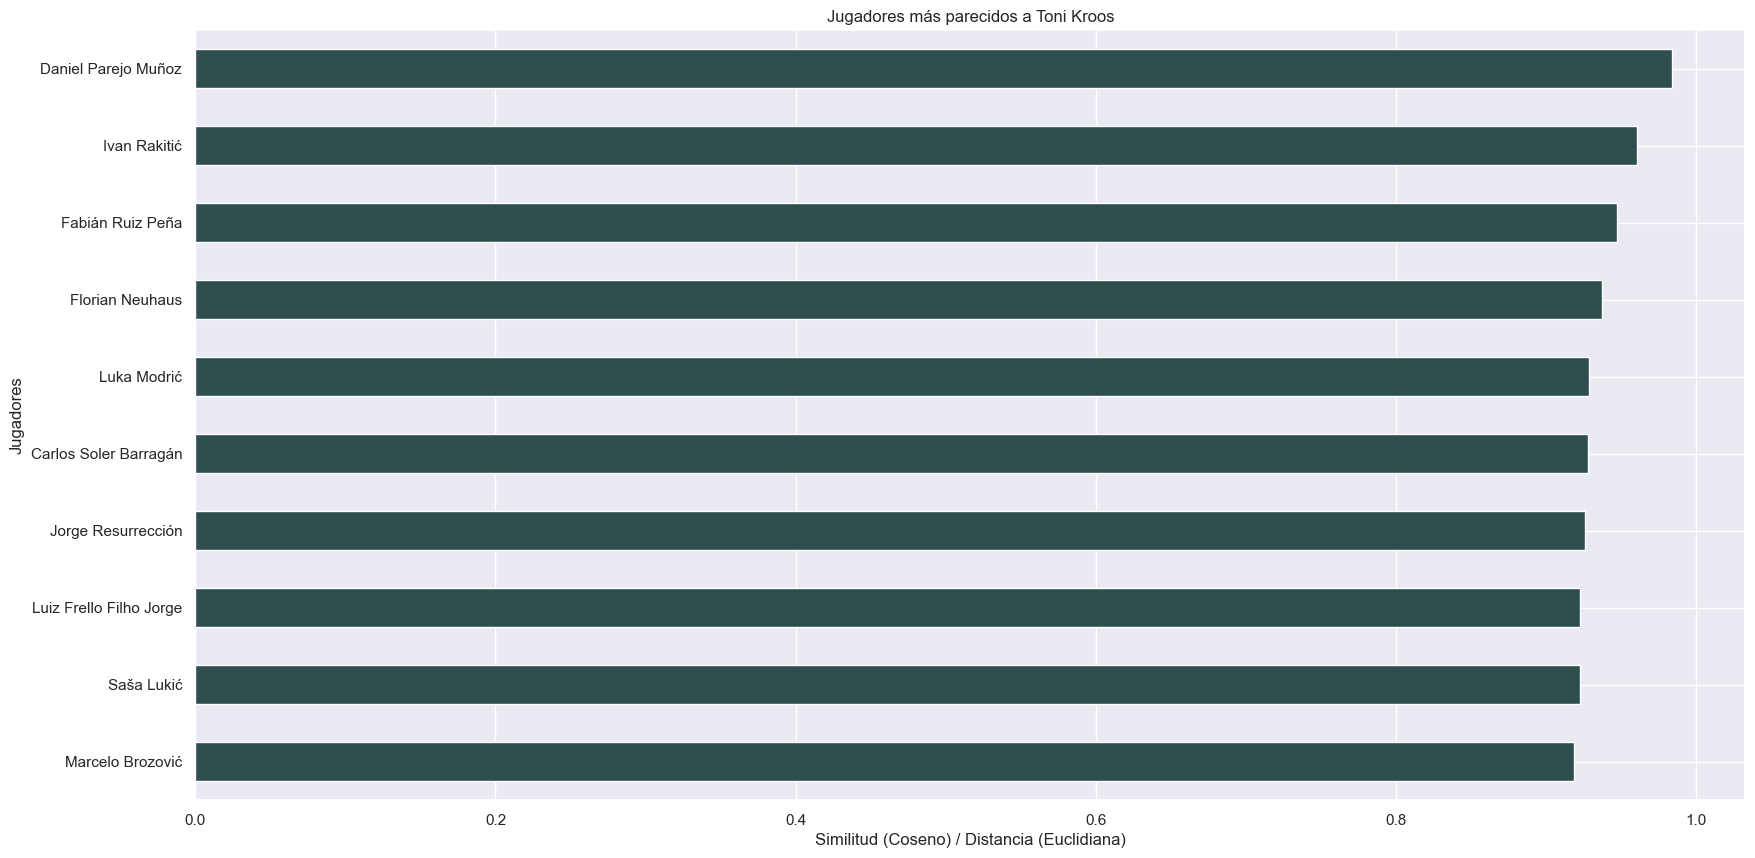

In [544]:
similar_players.head(10).plot(kind='barh', color='darkslategray')
plt.title(f"Jugadores más parecidos a {player_name}")
plt.xlabel("Similitud (Coseno) / Distancia (Euclidiana)")
plt.ylabel("Jugadores")
plt.gca().invert_yaxis()
plt.show()

#### ANALISIS DE SIMILITUD ENTRE JUGADORES CON DISTANCIA EUCLIDIANA

In [545]:
from scipy.spatial.distance import cdist

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_skills[features])

In [546]:
distance_matrix = cdist(scaled_features, scaled_features, metric='euclidean')

distance_df_skills = pd.DataFrame(distance_matrix, index=df_skills['name'], columns=df_skills['name'])

distance_df_skills.head()

name              Kevin De Bruyne  Kylian Mbappé  Mohamed Salah  \
name                                                              
Kevin De Bruyne          0.000000       4.845560       2.987203   
Kylian Mbappé            4.845560       0.000000       2.646516   
Mohamed Salah            2.987203       2.646516       0.000000   
Thibaut Courtois        16.585033      16.820566      16.445146   
Manuel Neuer            16.379010      16.844754      16.472559   

name              Thibaut Courtois  Manuel Neuer  Virgil van Dijk  Harry Kane  \
name                                                                            
Kevin De Bruyne          16.585033     16.379010         6.094615    2.507734   
Kylian Mbappé            16.820566     16.844754         7.480588    5.074444   
Mohamed Salah            16.445146     16.472559         6.535543    3.388214   
Thibaut Courtois          0.000000      2.871056        14.877965   16.287619   
Manuel Neuer              2.871056      0.000000        14.984220   16.157647   

name              Heung Min Son  Carlos Henrique Venancio Casimiro  Jan Oblak  \
name                                                                            
Kevin De Bruyne        3.122565                           4.789028  16.257123   
Kylian Mbappé          2.875804                           6.846363  16.578263   
Mohamed Salah          1.738466                           5.584760  16.174049   
Thibaut Courtois      16.136409                          15.040324   1.658817   
Manuel Neuer          16.162547                          15.049577   1.942245   

name              ...  Gianluca Saro  Rayane El Khamali  Rico Richards  \
name              ...                                                    
Kevin De Bruyne   ...      18.715467          12.232303      11.513402   
Kylian Mbappé     ...      18.939398          12.176436      11.285587   
Mohamed Salah     ...      18.411596          11.493064      10.633815   
Thibaut Courtois  ...       9.608240          15.052014      14.436420   
Manuel Neuer      ...      10.711740          15.812194      15.312690   

name              Saul Shotton  Alessandro Circati  Abdallah Basit   Ted Cann  \
name                                                                            
Kevin De Bruyne      14.654608           14.335461       12.502765  18.658474   
Kylian Mbappé        14.507956           14.085725       12.584186  18.832711   
Mohamed Salah        13.935176           13.581858       11.843289  18.276587   
Thibaut Courtois     14.475321           14.272624       14.811770  10.129799   
Manuel Neuer         15.596515           15.422741       15.594896  11.278117   

name              Dorian Ciezkowski  Igor Lucatelli  Edoardo Corvi  
name                                                                
Kevin De Bruyne           19.080676       19.021324      18.991982  
Kylian Mbappé             19.304029       19.166212      19.216661  
Mohamed Salah             18.700050       18.589935      18.561858  
Thibaut Courtois          10.996215       10.812040      11.062883  
Manuel Neuer              12.007090       11.933323      12.148714  

[5 rows x 3097 columns]

In [547]:
player_name = "Toni Kroos"

player_distances = distance_df_skills.loc[player_name]

most_similar_player = player_distances[player_distances > 0].sort_values().head(10)

print(f"Jugador más parecido a {player_name}:\n")
print(most_similar_player)

Jugador más parecido a Toni Kroos:

name
Daniel Parejo Muñoz        1.168757
Ivan Rakitić               1.982097
Fabián Ruiz Peña           2.198344
Carlos Soler Barragán      2.481368
Luka Modrić                2.544853
Jorge Resurrección         2.561622
Luiz Frello Filho Jorge    2.571735
Marcelo Brozović           2.596721
İlkay Gündoğan             2.625956
David Alaba                2.774413
Name: Toni Kroos, dtype: float64


En este caso no hay tanta difeerencia entre un método y otro, no como en nuestro otro análisis de estadísticas de futbolistas. En este caso sólo cambian 2, o como mucho 3 futbolistas, con los dos diferentes métodos de similitud.
Comprobando los resultados nos parece que la similitud coseno da resultados más exactos, pero la diferencia no es mucha. Esta se centra en el estilo de juego (patrones de datos y habilidades) y no tanto en las diferencias de escala y magnitudes, que no es tan importante en este caso como sí lo era para las estadísticas de jugadores.
Es decir, consideramos mejor la similitud coseno para las habilidades por dar importancia a los perfiles y estilos similares, mientras que la distancia euclidiana nos parece mejor para ver similitudes estadísticas, dond lo que más pesa son los valores absolutos y magnitudes.

____

### MODELO PRINCIPAL DEL PROYECTO: 
### CLUSTERING + RECOMENDACIÓN (K-Means + Cosine Similarity)
#### Identificar el mejor sustituto posible para los jugadores

In [548]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [549]:
df_skills.columns

Index(['name', 'overall', 'potential', 'value_million_euro', 'position',
       'nationality', 'age', 'age_group', 'height', 'team', 'formation',
       'league', 'wage_million_euro', 'preferred_foot', 'weak_foot_rating',
       'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
       'pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
       'defending_total', 'physicality_total', 'finishing', 'heading_accuracy',
       'dribbling', 'ball_control', 'balance', 'shot_power', 'strength',
       'long_shots', 'aggression', 'positioning', 'vision', 'penalties',
       'mentality', 'goalkeeper_diving', 'goalkeeper_handling',
       'goalkeeper_kicking', 'goalkeeper_positioning', 'goalkeeper_reflexes',
       'passing', 'speed', 'players_cluster', 'playing_style'],
      dtype='object')

In [550]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [551]:
features = [
    'overall', 'potential', 'skill_moves', 'attacking_work_rate', 'defensive_work_rate',
    'pace_total', 'shooting_total', 'passing_total', 'dribbling_total', 'defending_total',
    'physicality_total', 'finishing', 'heading_accuracy', 'dribbling', 'ball_control',
    'balance', 'shot_power', 'strength', 'long_shots', 'aggression', 'positioning', 'vision',
    'penalties', 'mentality', 'goalkeeper_diving', 'goalkeeper_handling', 'goalkeeper_kicking',
    'goalkeeper_positioning', 'goalkeeper_reflexes', 'passing', 'speed'
]

In [552]:
inercia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inercia.append(kmeans.inertia_)

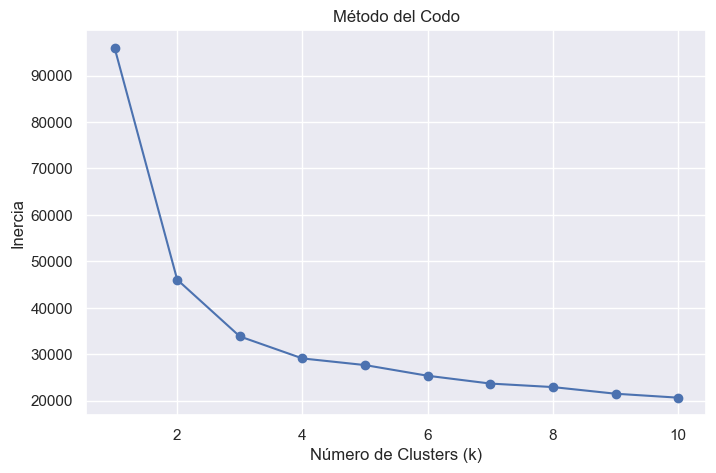

In [553]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inercia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()

Al ser igual que para la clasificación de jugadores en clusters por su juego y habilidad, vamos a aprovechar esos 4 clusters, que parece un número bastante bueno para el modelo

In [554]:
df_skills[['name', 'players_cluster']].head()

name  players_cluster
3     Kevin De Bruyne                0
26      Kylian Mbappé                0
53      Mohamed Salah                0
82   Thibaut Courtois                1
109      Manuel Neuer                1

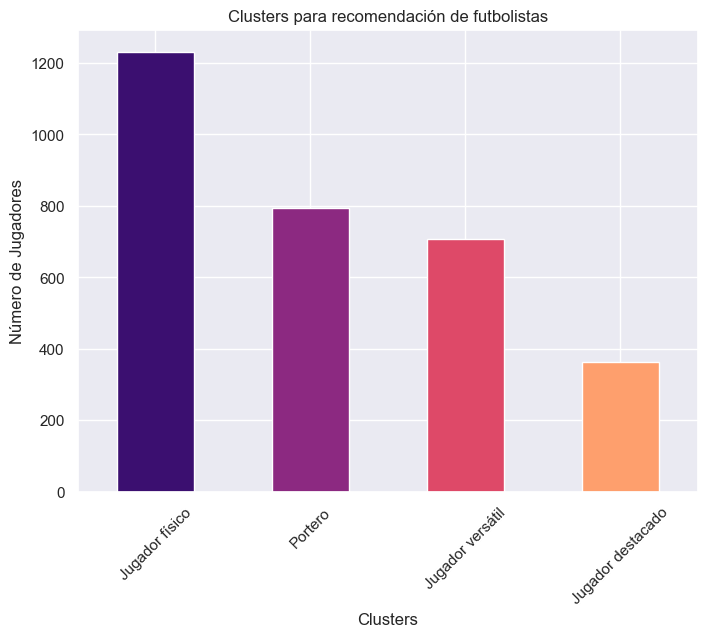

In [555]:
player_style_counts = df_skills['playing_style'].value_counts()

plt.figure(figsize=(8, 6))
colors = sns.color_palette('magma', len(player_style_counts))
player_style_counts.plot(kind='bar', color=colors)
plt.title('Clusters para recomendación de futbolistas')
plt.xlabel('Clusters')
plt.ylabel('Número de Jugadores')
plt.xticks(rotation=45)
plt.show()


Vamos a visualizar ayudándonos de PCA para reducir la dimensionalidad e interpretar mejor los clusters. Vemos que están bastante bien segmentados, sobre todo se nota con los porteros, que están más alejados de los jugadores de campo. Entre los otros tenemos a los jugadores destacados, entre medias a los versátiles y en el otro extremo a los jugadores físicos

In [556]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

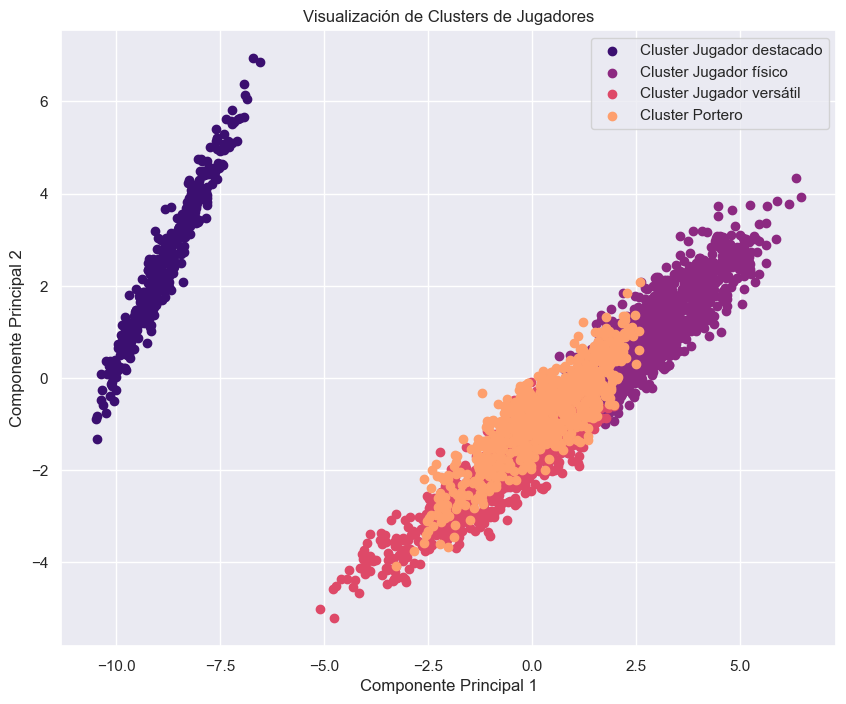

In [557]:
unique_clusters = np.sort(df_skills['playing_style'].unique())

palette = sns.color_palette('magma', len(unique_clusters))

cluster_colors = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    mask = df_skills['playing_style'] == cluster
    plt.scatter(pca_components[mask, 0], pca_components[mask, 1], 
                color=cluster_colors[cluster], label=f'Cluster {cluster}')

plt.title('Visualización de Clusters de Jugadores')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

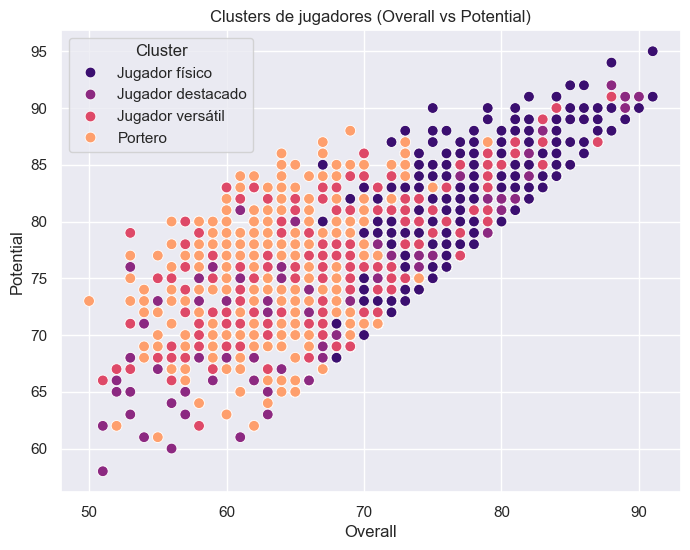

In [558]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_skills['overall'],
    y=df_skills['potential'],
    hue=df_skills['playing_style'],
    palette='magma',
    s=60
)
plt.title('Clusters de jugadores (Overall vs Potential)')
plt.xlabel('Overall')
plt.ylabel('Potential')
plt.legend(title='Cluster')
plt.show()

Una vez tenemos los clusters creados, identificados y analizados, podemos filtrar jugadores dentro de su mismo cluster, seleccionando todas las habilidades relevantes para la posterior recomendación. En este paso vamos a escalar también para que no haya rangos muy distintos entre variables

In [559]:
player_cluster = df_skills.loc[df_skills['name'] == player_name, 'playing_style'].values[0]

cluster_players = df_skills[df_skills['playing_style'] == player_cluster]

In [560]:
cluster_X = cluster_players[features]

cluster_X_scaled = scaler.transform(cluster_X)

Creamos la matriz de similaridad de los clusters para comparar los jugadores del mismo cluster. Después creamos un dataframe para las similitudes

In [561]:
cluster_similarity_matrix = cosine_similarity(cluster_X_scaled)

cluster_similarity_df = pd.DataFrame(cluster_similarity_matrix, index=cluster_players['name'], columns=cluster_players['name'])

cluster_similarity_df.head()

name             Kevin De Bruyne  Kylian Mbappé  Mohamed Salah  \
name                                                             
Kevin De Bruyne         1.000000       0.827726       0.930026   
Kylian Mbappé           0.827726       1.000000       0.949909   
Mohamed Salah           0.930026       0.949909       1.000000   
Virgil van Dijk         0.670779       0.511320       0.567955   
Harry Kane              0.951222       0.804379       0.902166   

name             Virgil van Dijk  Harry Kane  Heung Min Son  \
name                                                          
Kevin De Bruyne         0.670779    0.951222       0.925430   
Kylian Mbappé           0.511320    0.804379       0.945140   
Mohamed Salah           0.567955    0.902166       0.973964   
Virgil van Dijk         1.000000    0.726472       0.535315   
Harry Kane              0.726472    1.000000       0.892772   

name             Carlos Henrique Venancio Casimiro  Sadio Mané  \
name                                                             
Kevin De Bruyne                           0.808022    0.912469   
Kylian Mbappé                             0.601317    0.951832   
Mohamed Salah                             0.692731    0.977733   
Virgil van Dijk                           0.925060    0.597802   
Harry Kane                                0.860275    0.905074   

name             Joshua Kimmich  N'Golo Kanté  ...  Mickaël Le Bihan  \
name                                           ...                     
Kevin De Bruyne        0.892169      0.802804  ...          0.427254   
Kylian Mbappé          0.820811      0.596147  ...          0.204898   
Mohamed Salah          0.864576      0.732145  ...          0.347951   
Virgil van Dijk        0.671419      0.794090  ...          0.252541   
Harry Kane             0.832817      0.765604  ...          0.567978   

name             Adam Reach  Tristan Dingomé  Vincent Marchetti  \
name                                                              
Kevin De Bruyne    0.432612         0.405709           0.402094   
Kylian Mbappé      0.423401         0.293417           0.047522   
Mohamed Salah      0.488521         0.395844           0.232581   
Virgil van Dijk    0.068714         0.036847           0.457973   
Harry Kane         0.418478         0.341662           0.385729   

name             Gennaro Acampora  Adrián Bernabé García  Andrés Tello  \
name                                                                     
Kevin De Bruyne          0.271865               0.560205      0.310407   
Kylian Mbappé            0.236693               0.600272      0.114134   
Mohamed Salah            0.313090               0.640078      0.248718   
Virgil van Dijk          0.061760               0.045111      0.314161   
Harry Kane               0.256773               0.437260      0.358191   

name             Jessy Pi  Pasquale Schiattarella  Sam Greenwood  
name                                                              
Kevin De Bruyne  0.225363                0.320606       0.517885  
Kylian Mbappé   -0.068075                0.008733       0.585891  
Mohamed Salah    0.116269                0.194200       0.581258  
Virgil van Dijk  0.171256                0.107959       0.137829  
Harry Kane       0.273547                0.287341       0.512616  

[5 rows x 1232 columns]

Comprobamos la similitud de jugadores para la posterior recomendación según el filtrado que se desee (edad, posición, pie preferido, altura, liga...) y creamos una función que nos permita hacerlo de manera más interactiva, añadiendo además que nos arroje un mensaje si no encuentra el jugador que buscamos.

In [562]:
player_name = 'Toni Kroos'

if player_name not in df_skills['name'].values:
    print(f"El jugador '{player_name}' no se encuentra en el dataset. Por favor, verifica el nombre.")
else:
    similarity_to_player = cluster_similarity_df.loc[player_name]
    similar_players = similarity_to_player.sort_values(ascending=False).drop(player_name)

    print(f"Jugadores más parecidos a {player_name} dentro de su cluster:")
    print(similar_players.head(10))

Jugadores más parecidos a Toni Kroos dentro de su cluster:
name
Daniel Parejo Muñoz        0.983744
Ivan Rakitić               0.960747
Fabián Ruiz Peña           0.947384
Florian Neuhaus            0.937196
Luka Modrić                0.928614
Carlos Soler Barragán      0.928381
Jorge Resurrección         0.926014
Luiz Frello Filho Jorge    0.922886
Saša Lukić                 0.922412
Marcelo Brozović           0.918726
Name: Toni Kroos, dtype: float64


In [563]:
def get_similar_players(df_skills, player_name, features, n_clusters=4):
    """
    Función para recomendar jugadores más similares dentro del mismo cluster.

    Parámetros:
    df_skills (DataFrame): Dataframe con las habilidades de los jugadores y las características.
    player_name (str): Nombre del jugador para el que buscamos las recomendaciones.
    features (list): Lista de características a usar para el clustering y recomendación.

    Retorna:
    DataFrame: Jugadores más similares al jugador indicado dentro del mismo cluster.
    """

    if player_name not in df_skills['name'].values:
        raise ValueError(f"El jugador '{player_name}' no se encuentra en el dataset.")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_skills['players_cluster'] = kmeans.fit_predict(df_skills[features])

    scaler = StandardScaler()
    scaler.fit(df_skills[features])

    player_cluster = df_skills.loc[df_skills['name'] == player_name, 'players_cluster'].values[0]

    cluster_players = df_skills[df_skills['players_cluster'] == player_cluster]
    cluster_X = cluster_players[features]
    cluster_X_scaled = scaler.transform(cluster_X)

    cluster_similarity_matrix = cosine_similarity(cluster_X_scaled)
    cluster_similarity_df = pd.DataFrame(cluster_similarity_matrix, index=cluster_players['name'], columns=cluster_players['name'])

    similarity_to_player = cluster_similarity_df.loc[player_name]
    similar_players = similarity_to_player.sort_values(ascending=False).drop(player_name)

    return similar_players.head(10)

try:
    player_name = 'Toni Kroos'
    similar_players = get_similar_players(df_skills, player_name, features)
    print(f"Jugadores más parecidos a {player_name}:")
    print(similar_players)
except ValueError as e:
    print(e)

Jugadores más parecidos a Toni Kroos:
name
Daniel Parejo Muñoz        0.983744
Ivan Rakitić               0.960747
Fabián Ruiz Peña           0.947384
Florian Neuhaus            0.937196
Luka Modrić                0.928614
Carlos Soler Barragán      0.928381
Jorge Resurrección         0.926014
Luiz Frello Filho Jorge    0.922886
Saša Lukić                 0.922412
Marcelo Brozović           0.918726
Name: Toni Kroos, dtype: float64


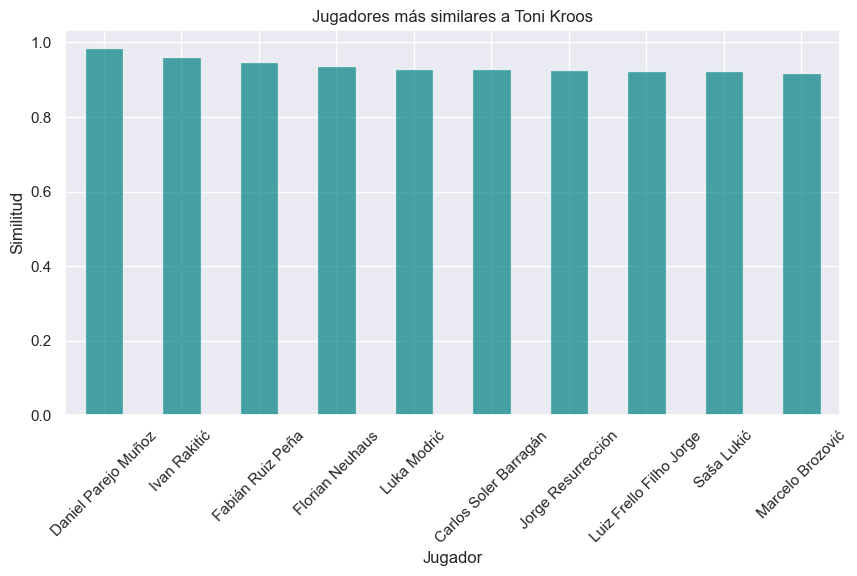

In [564]:
def top_similar_players(similar_players, player_name):
    plt.figure(figsize=(10, 5))
    similar_players.plot(kind='bar', color='teal', alpha=0.7)
    plt.title(f"Jugadores más similares a {player_name}")
    plt.xlabel("Jugador")
    plt.ylabel("Similitud")
    plt.xticks(rotation=45)
    plt.show()

top_similar_players(similar_players, player_name)


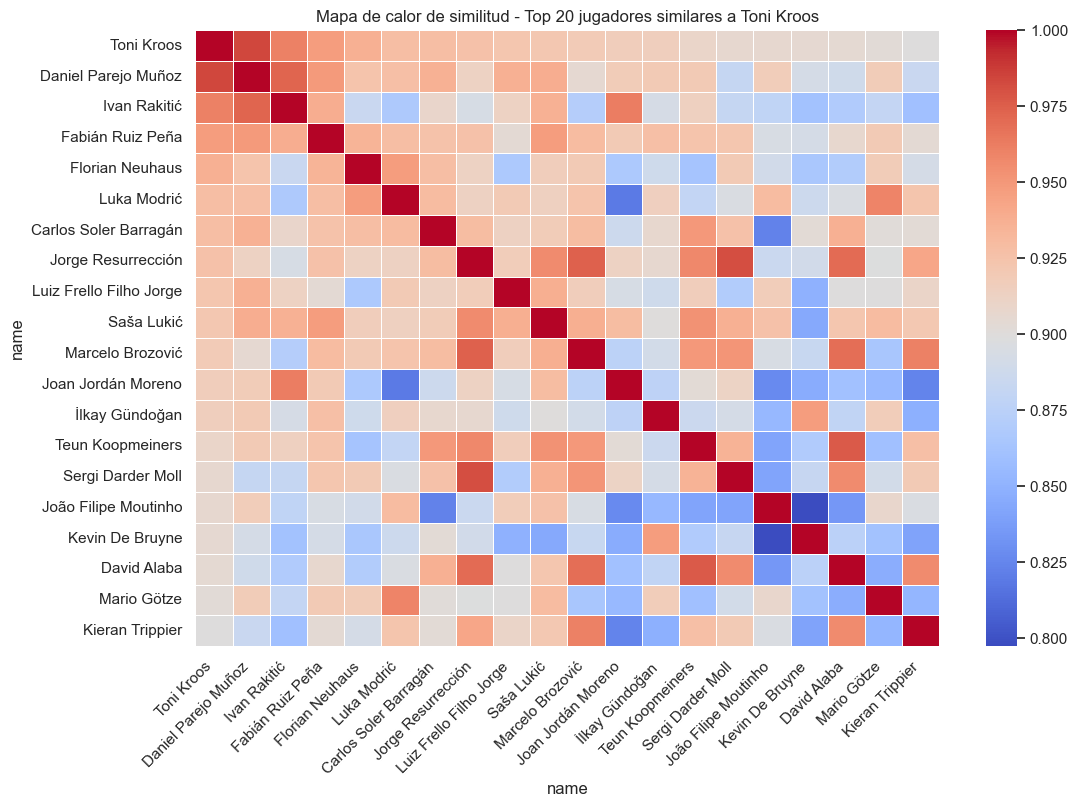

In [565]:
def similarity_heatmap(cluster_similarity_df, player_name, top_n=20):
    top_players = cluster_similarity_df.loc[player_name].sort_values(ascending=False).head(top_n).index
    top_similarity_df = cluster_similarity_df.loc[top_players, top_players]

    plt.figure(figsize=(12, 8))
    sns.heatmap(top_similarity_df, cmap="coolwarm", annot=False, linewidths=0.5)

    plt.title(f"Mapa de calor de similitud - Top {top_n} jugadores similares a {player_name}")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.show()

similarity_heatmap(cluster_similarity_df, player_name, top_n=20)

In [566]:
import joblib

joblib.dump(kmeans, 'nextgen_recommendation_model.pkl')

joblib.dump(scaler, 'nextgen_scaler_recommendation_model.pkl')


['nextgen_scaler_recommendation_model.pkl']

In [567]:
kmeans_recommendation_model_loaded = joblib.load('kmeans_recommendation_model.pkl')

scaler_loaded = joblib.load('scaler_recommendation_model.pkl')


## Modelo Gaussian Mixture Models (GMM)

El modelo GMM nos ofrecía una perspectiva  más probabilística para clasificar datos, permitiendo que los clusters se solapen. Lo probamos para el proyecto, por si nos pudiese servir como complemento para validar los resultados de K-Means y/u obtener clusters más flexibles.

In [568]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity

In [569]:
gmm = GaussianMixture(n_components=4, random_state=42)
df_skills['gmm_cluster'] = gmm.fit_predict(df_scaled)

In [570]:
gmm_cluster_counts = df_skills['gmm_cluster'].value_counts()

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\837436094.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gmm_cluster_counts.index, y=gmm_cluster_counts.values, palette='crest')


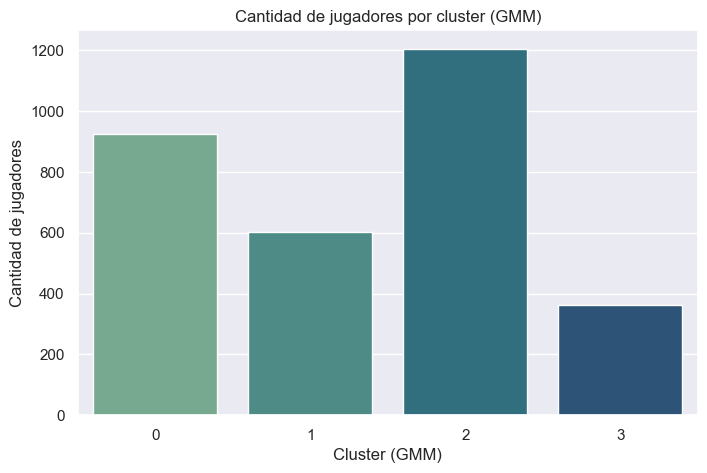

In [571]:
plt.figure(figsize=(8, 5))
sns.barplot(x=gmm_cluster_counts.index, y=gmm_cluster_counts.values, palette='crest')
plt.title('Cantidad de jugadores por cluster (GMM)')
plt.xlabel('Cluster (GMM)')
plt.ylabel('Cantidad de jugadores')
plt.show()

In [572]:
gmm_cluster_means = df_skills.groupby('gmm_cluster')[features].mean()
print("\nCaracterísticas promedio por cluster (GMM):")
print(gmm_cluster_means)

print("\nEjemplos de jugadores en cada cluster (GMM):")
for cluster in range(3):
    print(f"\nCluster {cluster}:")
    print(df_skills[df_skills['gmm_cluster'] == cluster][['name', 'overall', 'potential']].head(5))


Características promedio por cluster (GMM):
               overall  potential  skill_moves  attacking_work_rate  \
gmm_cluster                                                           
0            76.051836  78.600432     3.333693             1.557235   
1            66.272879  76.617304     2.813644             1.346090   
2            71.676617  77.156716     2.332504             1.140962   
3            69.629121  74.837912     0.000000             1.000000   

             defensive_work_rate  pace_total  shooting_total  passing_total  \
gmm_cluster                                                                   
0                       1.144708   72.895248       70.941685      71.799136   
1                       0.936772   71.955075       61.693844      58.607321   
2                       1.315920   66.116086       45.520730      59.750415   
3                       1.000000    0.000000       67.785714      66.524725   

             dribbling_total  defending_total  ...   

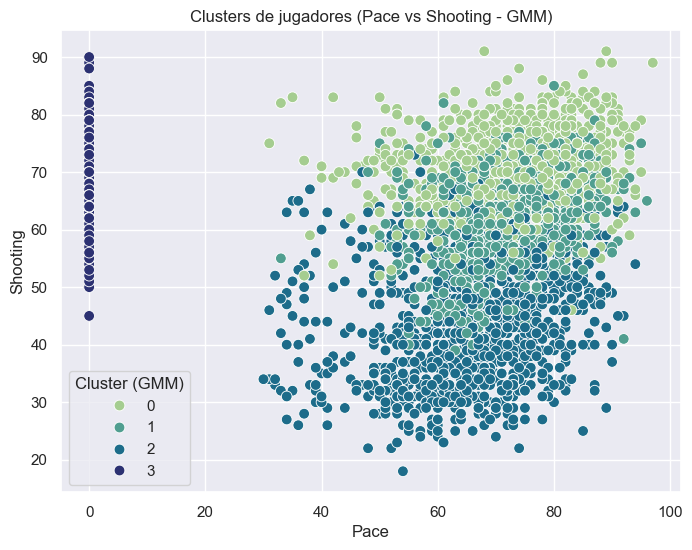

In [573]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_skills['pace_total'],
    y=df_skills['shooting_total'],
    hue=df_skills['gmm_cluster'],
    palette='crest',
    s=60
)
plt.title('Clusters de jugadores (Pace vs Shooting - GMM)')
plt.xlabel('Pace')
plt.ylabel('Shooting')
plt.legend(title='Cluster (GMM)')
plt.show()

In [574]:
jugador_objetivo = "Toni Kroos"

fila_objetivo = df_skills[df_skills["name"] == jugador_objetivo]
if fila_objetivo.empty:
    print(f"No se encontró a {jugador_objetivo} en el dataset.")
else:
    cluster_objetivo = fila_objetivo["gmm_cluster"].values[0]
    
    jugadores_cluster = df_skills[df_skills["gmm_cluster"] == cluster_objetivo]
    
    X_cluster = jugadores_cluster[features]

    similitudes = cosine_similarity(X_cluster, fila_objetivo[features])

    jugadores_cluster = jugadores_cluster.copy()
    jugadores_cluster["similaridad_coseno"] = similitudes

    jugadores_parecidos = jugadores_cluster.sort_values(by="similaridad_coseno", ascending=False)
    jugadores_parecidos = jugadores_parecidos[jugadores_parecidos["name"] != jugador_objetivo]
    
    print(f"Los 10 jugadores más parecidos a {jugador_objetivo} en su cluster:")
    print(jugadores_parecidos[["name", "similaridad_coseno"]].head(20))

Los 10 jugadores más parecidos a Toni Kroos en su cluster:
                               name  similaridad_coseno
1289            Daniel Parejo Muñoz            0.998507
5888                   Ivan Rakitić            0.998091
19917                   Pascal Groß            0.998071
31978                   Tom Cairney            0.997805
23480                  Aaron Ramsey            0.997342
1679                 İlkay Gündoğan            0.997080
3879               Fabián Ruiz Peña            0.996971
14735        Manuel Trigueros Muñoz            0.996799
7896              James Ward-Prowse            0.996626
26527      Miguel Luís Pinto Veloso            0.996567
39421                Oliver Norwood            0.996464
3                   Kevin De Bruyne            0.996427
28713        Salvador Sevilla López            0.996165
22529  Alejandro Fernández Iglesias            0.995897
51260                 Kevin Möhwald            0.995828
11929                   Lars Stindl          

Este modelo nos sirve para comparar y observar los aciertos entre modelos en la recomendación, auqnue por los resultados nos seguimos quedando con el modelo de clustering (K-means) más la recomendación (similaridad coseno)

___

#### MODELOS DE REGRESIÓN PARA PREDECIR EL VALOR DE MERCADO

#### MODELO PREDICCIÓN DE MERCADO CON RANDOM FOREST

El Random Forest, al no necesitar de una normalización previa, lo hace un modelo muy robusto y eficiente para predecir variables como el valor de mercado. Además que no es tan sensible a outliers, que en este caso pueden ser muy importantes para calcular valores mayores a los 25 millones de euros. 

Este modelo nos sirve tanto para comprobar si hay mucho error en los valores que actualmente tenemos del valor de mercado de los jugadores, si alguno quizás pueda estar más alejado de lo normal y también para posibles nuevos jugadores qeu se incluyan en el dataset (nuevos datos) o calculos para años posteriores con otras métricas de habilidades.

A continuación lo desglosamos:

In [575]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

In [576]:
features = [
        'age', 'overall', 'potential','pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
       'defending_total', 'physicality_total', 'finishing','dribbling', 'ball_control', 'shot_power', 
       'long_shots', 'positioning', 'vision', 'penalties','mentality', 'passing', 'speed'    
]

Hemos quitado algunas variables, como las de portero, el cabeceo, el equilibrio o la agresión, ya que daban importancias muy bajas más adelante

In [577]:
features = [col for col in features if col not in ['value_million_euro', 'wage_million_euro']]
target = 'value_million_euro'

In [578]:
X = df_skills[features]
y = df_skills[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [579]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

Vemos las importancias de las variables. Tenemos variables genéricas de importancia, como overall y potential, la edad y variables de habilidad de los jugadores

<Axes: xlabel='Importancia', ylabel='Variable'>

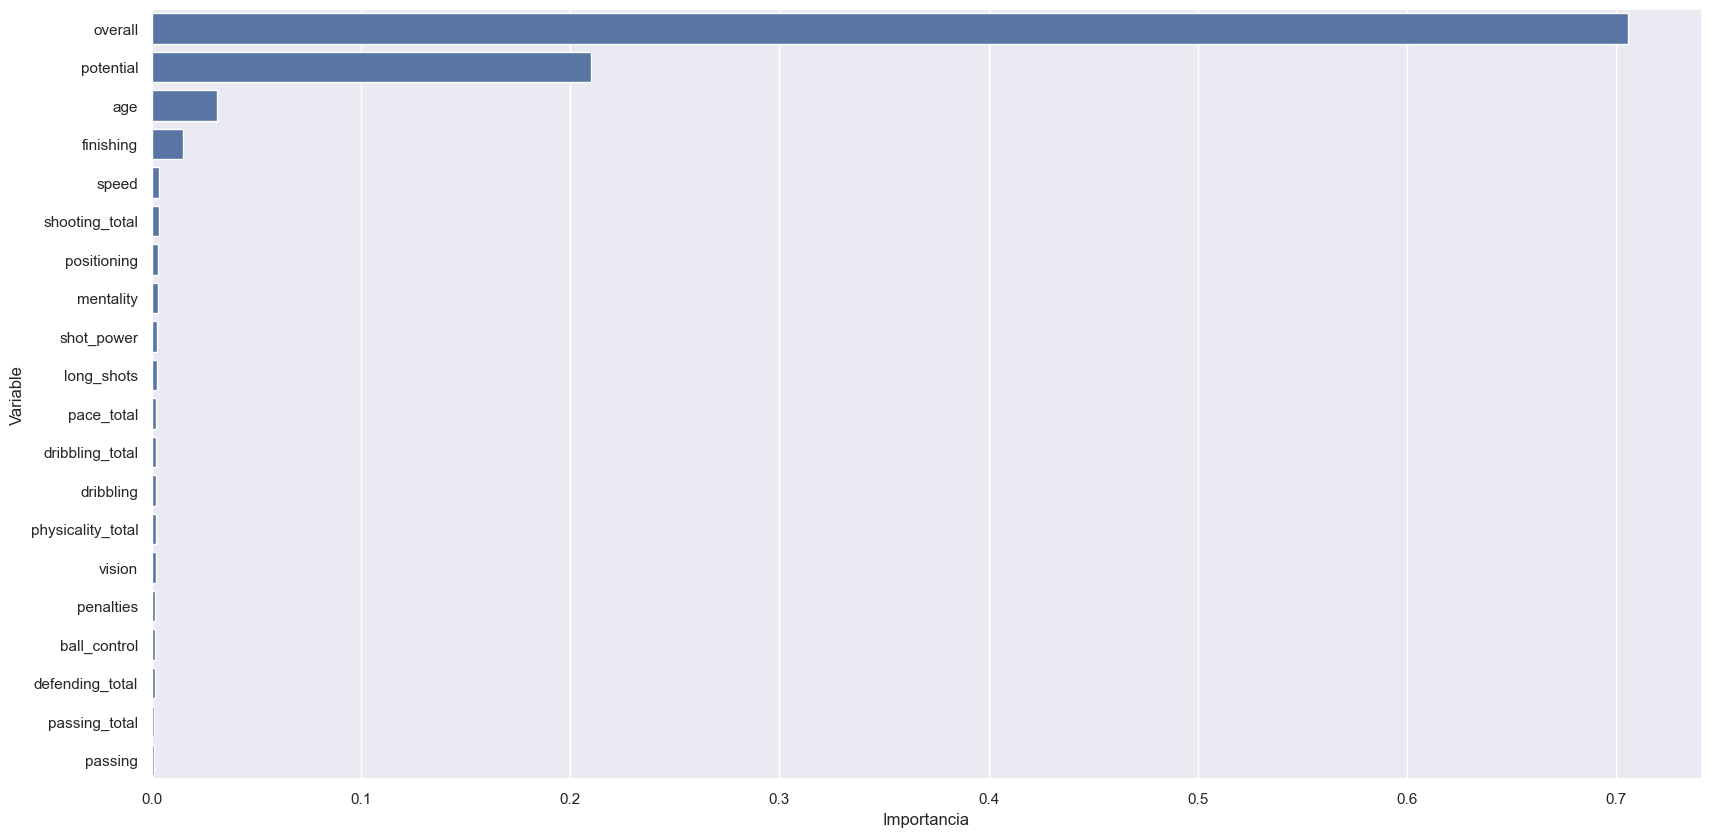

In [580]:
importances = rfr.feature_importances_

importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importances})
importance_df = importance_df.sort_values('Importancia', ascending=False)
sns.barplot(data = importance_df, x='Importancia', y ='Variable')

In [581]:
y_pred = rfr.predict(X_test)

In [582]:
df_evaluacion = pd.DataFrame()
df_evaluacion['y'] = y_test
df_evaluacion['y_pred'] = y_pred
df_evaluacion['error'] = df_evaluacion['y']-df_evaluacion['y_pred']

df_evaluacion

y    y_pred    error
60379   1.600   1.62200 -0.02200
39087   3.500   3.45100  0.04900
48463   1.900   1.86650  0.03350
89066   0.525   0.51250  0.01250
81666   1.000   1.04300 -0.04300
...       ...       ...      ...
26756   6.000   6.07800 -0.07800
43504   7.000   7.05000 -0.05000
7333   37.000  39.65500 -2.65500
39850   2.000   2.18325 -0.18325
81293   0.950   0.95050 -0.00050

[930 rows x 3 columns]

El RMSE de 1.85 indica una dispersión más bien baja o moderada en los errores del modelo, lo que sugiere que las predicciones están en general cerca del valor real. El MAE es bajo, e indica que el modelo se equivoca por poco de los datos del dataset. Esto nos da a entender que el modelo está haciendo predicciones  precisas en cuanto a error medio. El MSE de 3.43 si que es más alto y lo intentaremos corregir alto, porque parece que hay algunos más grandes en algunas predicciones, pero a nivel general sobre los 180 millones del máximo valor de mercado no es alto y será donde falla más, en los outliers (valores más altos)

In [583]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = mean_squared_error(y_test, y_pred)**0.5

print('MAE:',MAE)
print('MSE:',MSE)
print('RMSE:',RMSE)

MAE: 0.6120890310860214
MSE: 3.3683378439030993
RMSE: 1.8353032021720823


A continuación visualizamos gráficos de dispersión, del error (y los residuales) y de los valores reales vs valores de predicción, iedno que en general, cuanto mas alto es el valor de mercado más error tiene la predicción. Aún así son buenas predicciones para valores tan altos

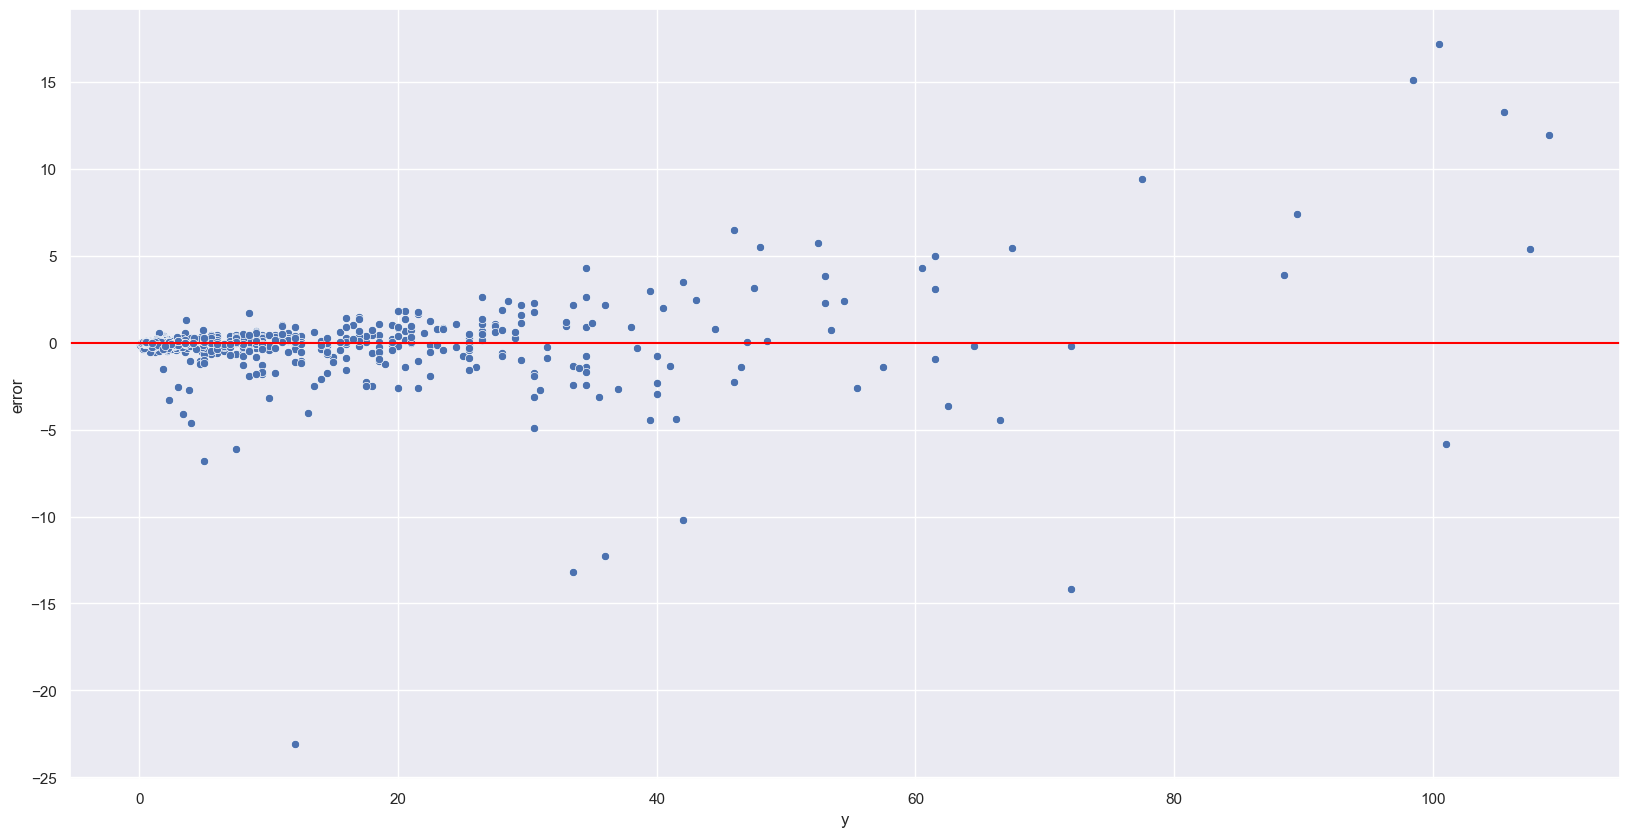

In [584]:
sns.scatterplot(data = df_evaluacion, x = 'y',y='error')
plt.axhline(0,color='red')

Ya tenemos un modelo bastante contundente, como podemos observar en los gráficos, aunque haya valores altos para los que genere más error

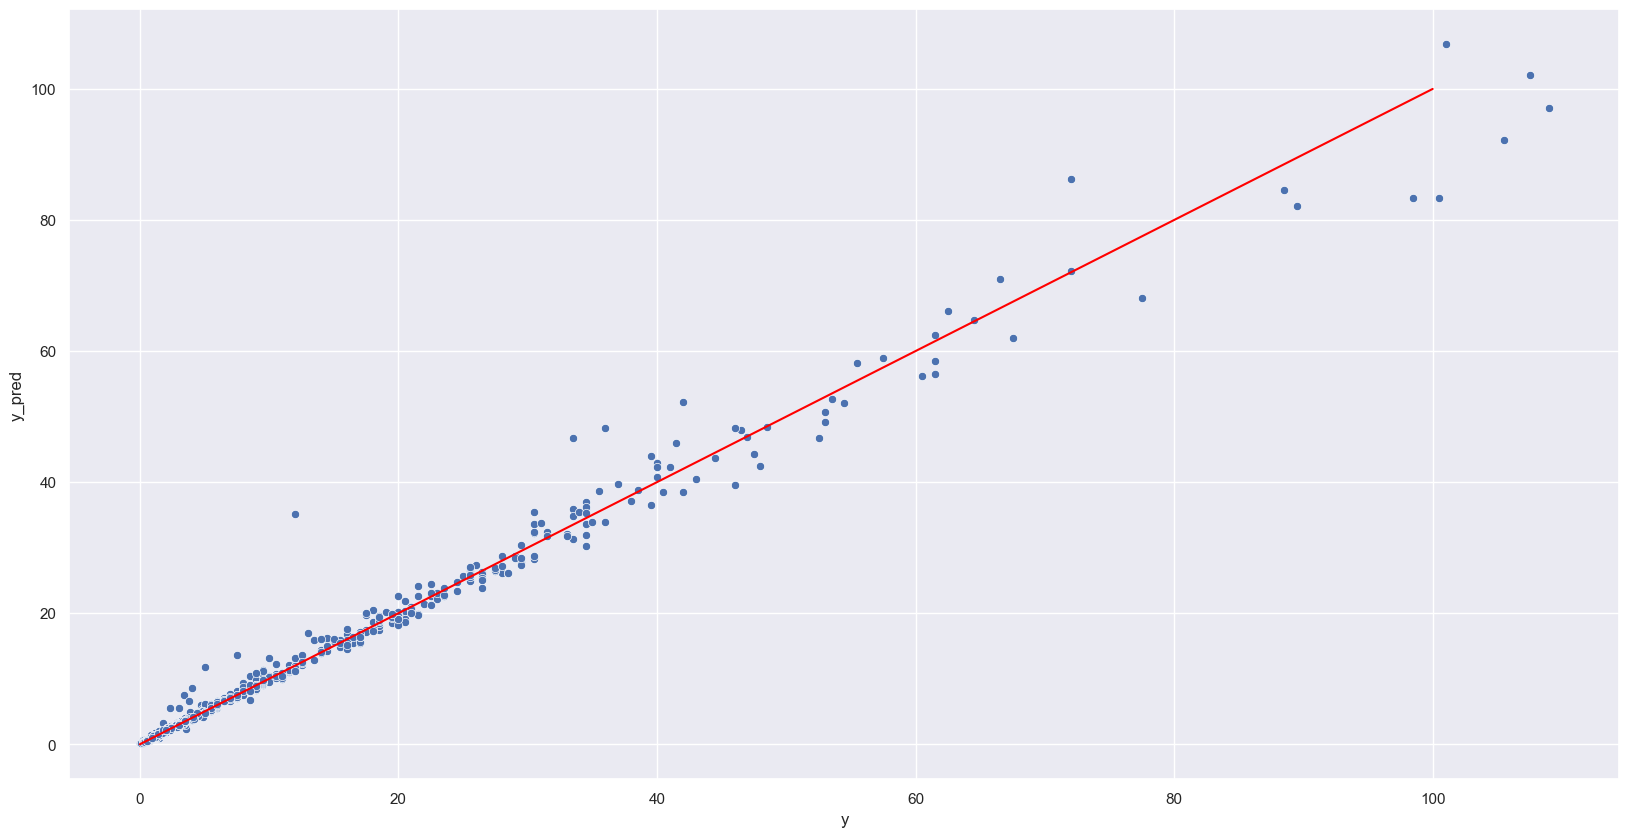

In [585]:
sns.scatterplot(data = df_evaluacion, x = 'y',y='y_pred')
plt.plot([0, 100], [0, 100],color='red')

La curva de aprendizaje nos muestra un modelo que aprende bastante bien según va aumentando el tamaño del entrenamiento

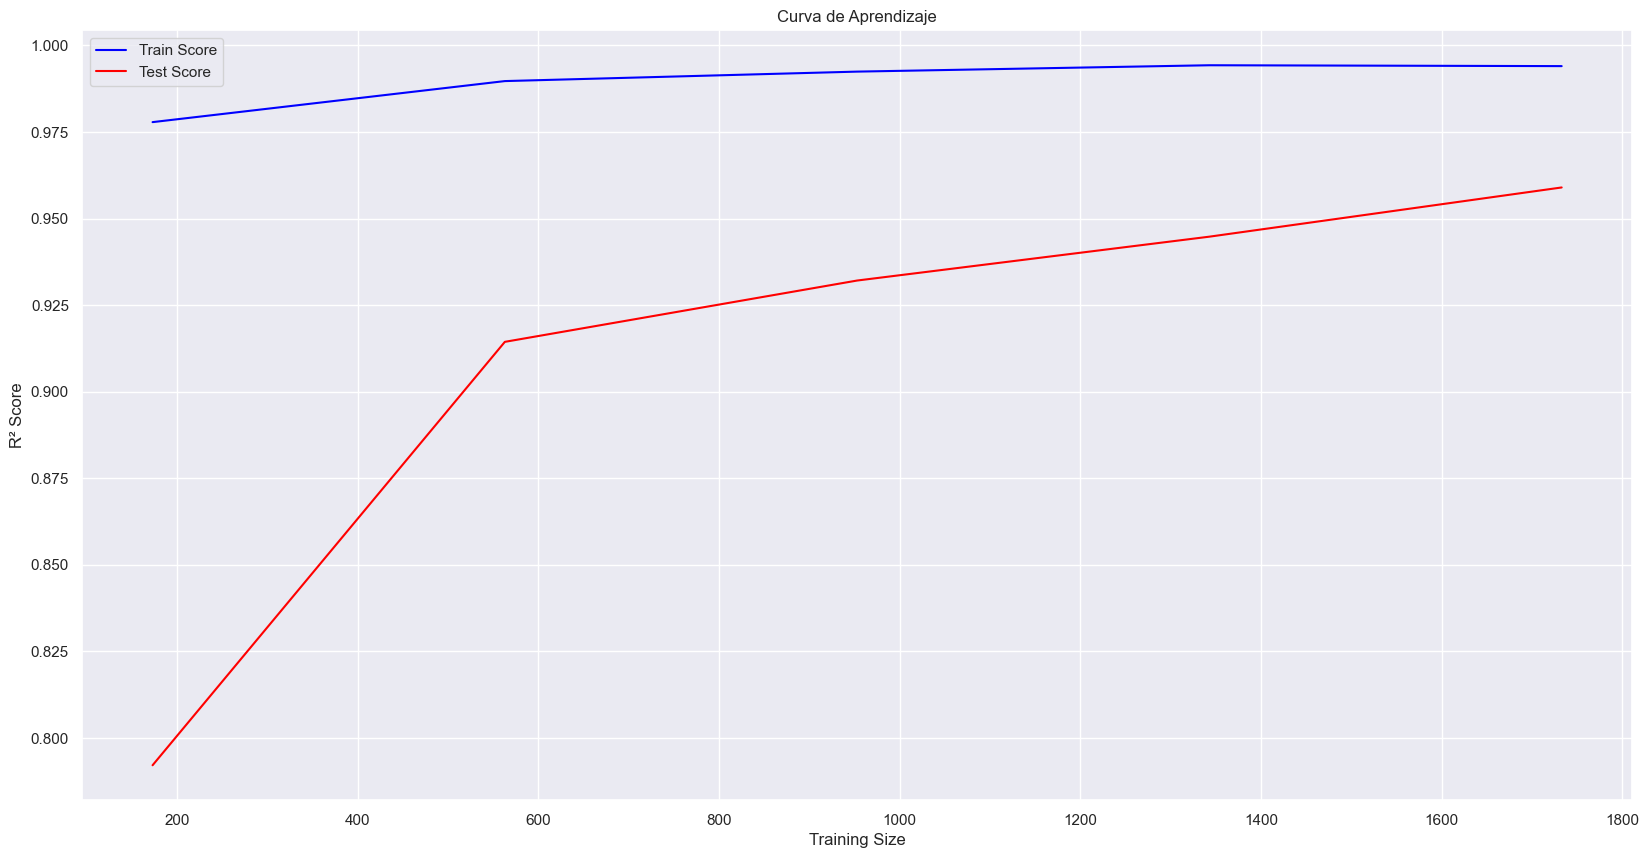

In [586]:
train_sizes, train_scores, test_scores = learning_curve(rfr, X_train, y_train, cv=5, scoring='r2')
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train Score", color="blue")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test Score", color="red")
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Curva de Aprendizaje")
plt.show()

In [587]:
from sklearn.metrics import r2_score

y_train_pred = rfr.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = rfr.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Entrenamiento MSE: {train_mse}, R²: {train_r2}")
print(f"Prueba MSE: {test_mse}, R²: {test_r2}")

Entrenamiento MSE: 0.8970358554859725, R²: 0.9962841644445213
Prueba MSE: 3.3683378439030993, R²: 0.9850121435783213


El modelo predice bastante bien en train y test, aunque tiene una subida de error MSE entre ellos, por lo que vamos a intentar ajustarlo

In [588]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

param_dist = {
    'n_estimators': np.arange(2, 5, 10),
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2,3],
}

random_search = RandomizedSearchCV(rfr, param_distributions=param_dist, 
                                   n_iter=100, random_state=42, n_jobs=-1, cv=5)


random_search.fit(X_train, y_train)

print(f"Mejores parámetros: {random_search.best_params_}")

c:\Users\metal\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parámetros: {'n_estimators': np.int64(2), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30}


In [589]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [2,5,10,20,50,100],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2,5],
    'min_samples_leaf': [2],
}

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25], 'min_samples_leaf': [2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [2, 5, 10, 20, 50, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [590]:
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [591]:
# best_model = RandomForestRegressor(**best_params)
# best_model.fit(X_train, y_train)

In [592]:
# y_pred = best_model.predict(X_test)

In [593]:
# MAE = mean_absolute_error(y_test, y_pred)
# MSE = mean_squared_error(y_test, y_pred)
# RMSE = mean_squared_error(y_test, y_pred)**0.5

# print('MAE:',MAE)
# print('MSE:',MSE)
# print('RMSE:',RMSE)

In [594]:
# y_train_pred = best_model.predict(X_train)
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_r2 = r2_score(y_train, y_train_pred)

# y_test_pred = best_model.predict(X_test)
# test_mse = mean_squared_error(y_test, y_test_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print(f"Entrenamiento - MSE: {train_mse}, R²: {train_r2}")
# print(f"Prueba - MSE: {test_mse}, R²: {test_r2}")

No parece que mejoremos el modelo con Randomized Search ni con GridSearch, asi que nos quedamos con el primer modelo

In [595]:
y_train_pred = rfr.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = rfr.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Entrenamiento MSE: {train_mse}, R²: {train_r2}")
print(f"Prueba MSE: {test_mse}, R²: {test_r2}")

Entrenamiento MSE: 0.8970358554859725, R²: 0.9962841644445213
Prueba MSE: 3.3683378439030993, R²: 0.9850121435783213


In [596]:
import joblib

joblib.dump(rfr, 'market_value_rf.pkl')

['market_value_rf.pkl']

### Conclusiones

Hemos conseguido una alta precisión en la predicción del valor de mercado, consiguiendo solo un error promedio RMSE de 1.85 millones (aunque con MSE sube a 3.43 millones de euros), considerando que nuestros datos van desde 0,1 hasta 180 millones (con media de 9,39 millones de euros).
Las variables overall (69.39%) y potential (22.75%) son las más determinantes, lo que indica que el la puntuación general del jugador (su performance) y su potencial a futuro son claves en la valoración del precio del jugador. La edad también ha sido una variable con importancia para el modelo. Las variables de habilidad más importantes para el modelo han sido la finalización de las jugadas, la potencia de disparo y el ritmo de juego. El modelo se centra en características de rendimiento y proyección, ignorando factores externos como la popularidad o contratos.

Aplicaciones prácticas:
Creemos que este modelo tiene un gran valor para hacer scouting, identificando jugadores prometedores basados en su puntuación y sobre todo en su potencial, cuando quizás su valor de mercado todavía no es muy alto.
También permitirá optimizar inversiones de los equipos en el mercado, ya que buscarán ese maximizar beneficies y bajar costes, buscando jugadores buenos cuando su valor es bajo y venderlos cuando su valor alcanza el pico.

#### MODELO DE PREDICCIÓN DE VALOR DE MERCADO CON DECISSION TREE

Hemos hecho Random Forest que es un árbol, pero nos cabe la duda de probar los árboles de decisión para mostrar diferencias 

In [597]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [598]:
if isinstance(X_train, np.ndarray):
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=feature_names)

In [599]:
tree_model = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

C:\Users\metal\AppData\Local\Temp\ipykernel_5676\4090463900.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette="viridis")


Text(0.5, 1.0, 'Importancia de las Características en el Árbol de Decisión')

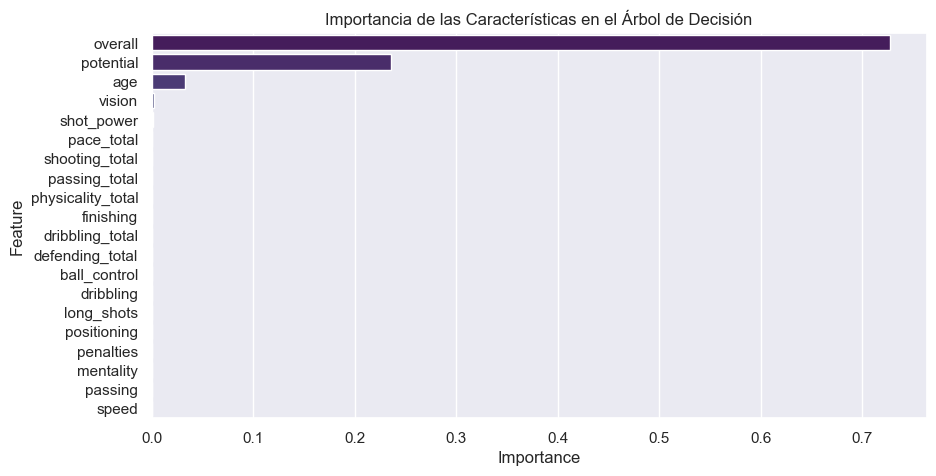

In [600]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': tree_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette="viridis")
plt.title("Importancia de las Características en el Árbol de Decisión")

In [601]:
y_pred_tree = tree_model.predict(X_test)

In [602]:
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = mse_tree ** 0.5
r2 = r2_score(y_test, y_pred_tree)

print(f"Error cuadrático medio (MSE): {mse_tree:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_tree:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")

Error cuadrático medio (MSE): 12.55
Raíz del error cuadrático medio (RMSE): 3.54
Coeficiente de determinación (R²): 0.94


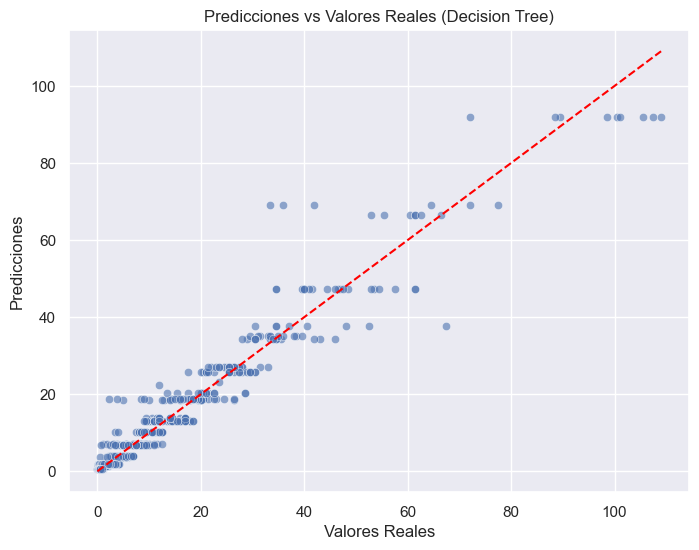

In [603]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_tree, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title("Predicciones vs Valores Reales (Decision Tree)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

### Conclusiones

El modelo de Árbol de Decisión tiene un error cuadrático medio (MSE) de 12.57, lo cual nos da peores valores que el modelo de Random Forest. Las variables más importantes son muy pocas. Este modelo da algo menos de error para los jugadores con valores extremos (muy altos o muy bajos), por lo que ha segmentado bien eso.

### MODELO PREDICCIÓN VALOR DE MERCADO CON XGBOOST

In [604]:
import xgboost as xgb

In [605]:
features = [col for col in features if col not in ['value_million_euro', 'wage_million_euro']]
target = 'value_million_euro'

In [606]:
X = df_skills[features]
y = df_skills[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [607]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Volvemos a visualizar las importancias, que son bastante similares al Random Forest (en overall y potential sobre todo), aunque aquí da más peso a la finalización que a la edad, por poco. Detrás de estos están la potencia de disparo, los disparos de larga distancia y la velocidad.

<Axes: xlabel='Importancia', ylabel='Variable'>

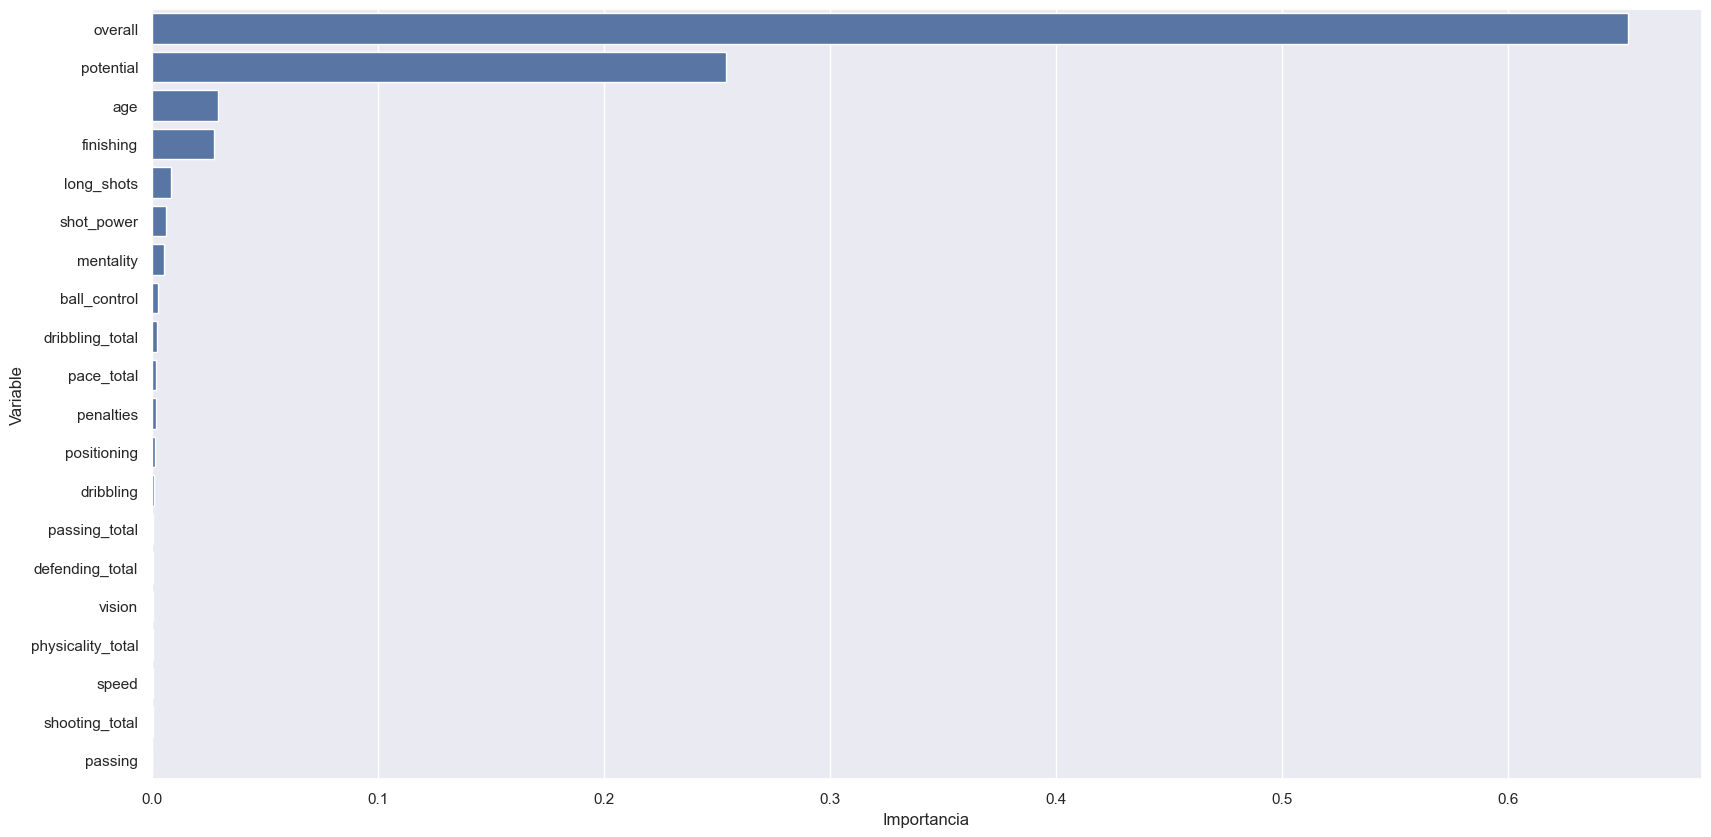

In [608]:
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importances})
importance_df = importance_df.sort_values('Importancia', ascending=False)
sns.barplot(data=importance_df, x='Importancia', y='Variable')

In [609]:
y_pred = xgb_model.predict(X_test)

In [610]:
df_evaluacion = pd.DataFrame()
df_evaluacion['y'] = y_test
df_evaluacion['y_pred'] = y_pred
df_evaluacion['error'] = df_evaluacion['y'] - df_evaluacion['y_pred']
df_evaluacion

y     y_pred     error
60379   1.600   1.609466 -0.009466
39087   3.500   3.644667 -0.144667
48463   1.900   1.843850  0.056150
89066   0.525   0.546416 -0.021416
81666   1.000   0.962300  0.037700
...       ...        ...       ...
26756   6.000   5.819133  0.180867
43504   7.000   6.953590  0.046410
7333   37.000  39.892063 -2.892063
39850   2.000   2.143108 -0.143108
81293   0.950   0.913731  0.036269

[930 rows x 3 columns]

El MAE es bastante bajo, teniendo en cuenta que el valor de mercado va de 0 a 180 millones y su media es de 9.39 millones, lo que indica que el modelo está siendo preciso de manera genérica. El RMSE nos muestra que el modelo está cometiendo errores de 1.70 millones en promedio. Es un valor moderado, ya que vemos la gran variabilidad de esta variable, aunque puede ser significativo para valores más bajos. Esto podría deberse a que los jugadores con un valor de mercado elevado están generando estos errores, influyendo más en esta métrica. El MSE de 2.87 muestra que aunque el modelo tiene un error medio bajo, algunas predicciones están distorsionadas por errores más grandes. La causa de estas diferencias entre las predicciones y los valores reales se pueden deber a que los jugadores con un valor de mercado elevado están generando estos errores más altos y alteran más esta métrica.

In [611]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = mean_squared_error(y_test, y_pred)**0.5

print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MAE: 0.5862732054906644
MSE: 2.940009344435855
RMSE: 1.7146455448388902


Visualicemos los errores graficados (residuales) y los valores reales vs valores predichos. También comprobamos la curva de aprendizaje del modelo

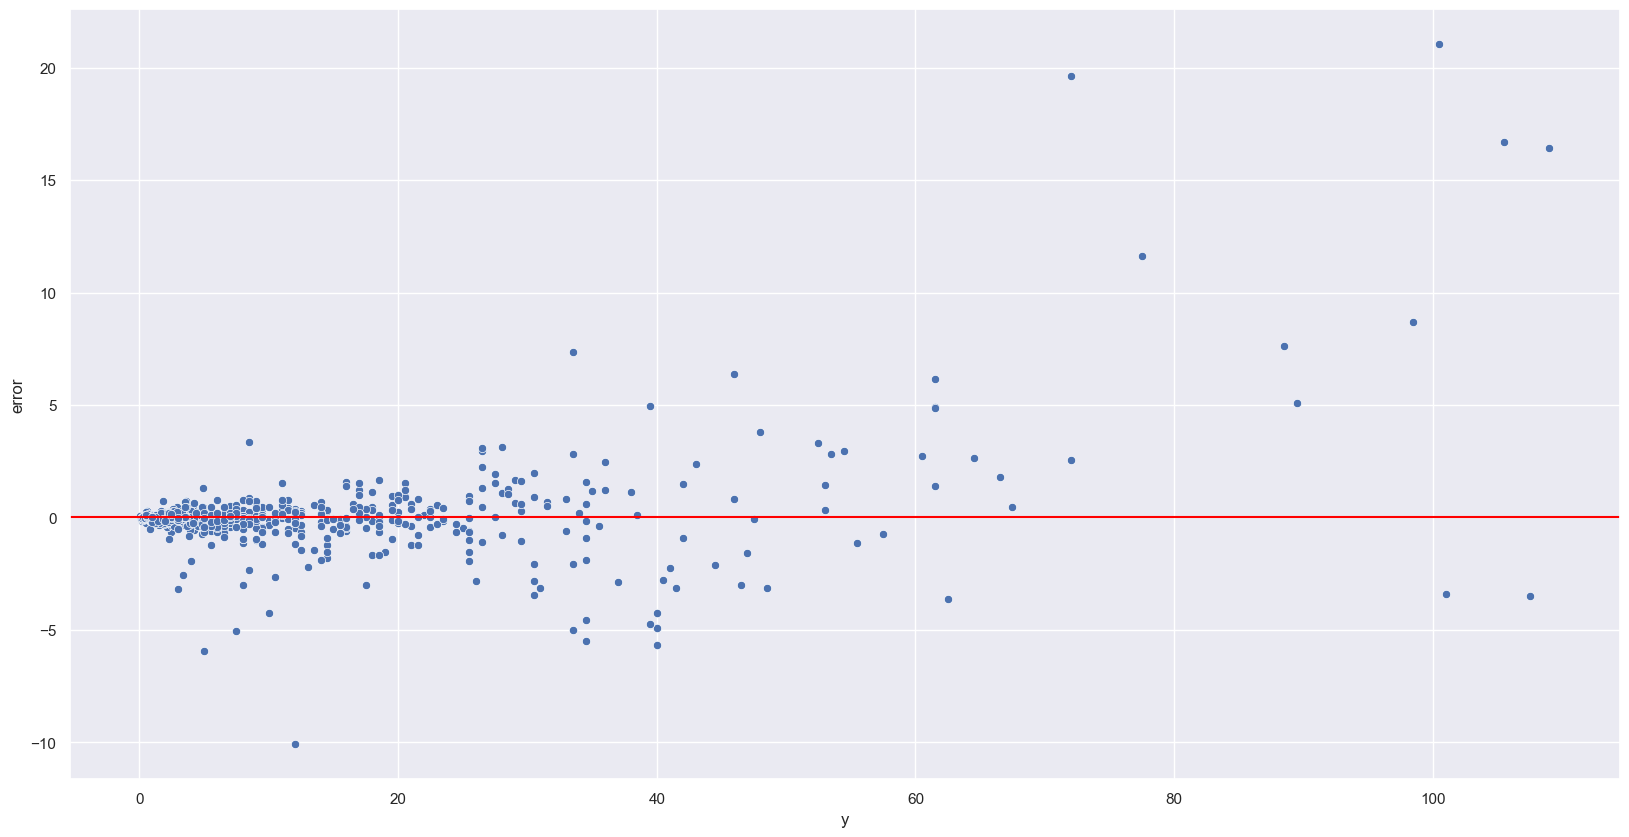

In [612]:
sns.scatterplot(data=df_evaluacion, x='y', y='error')
plt.axhline(0, color='red')

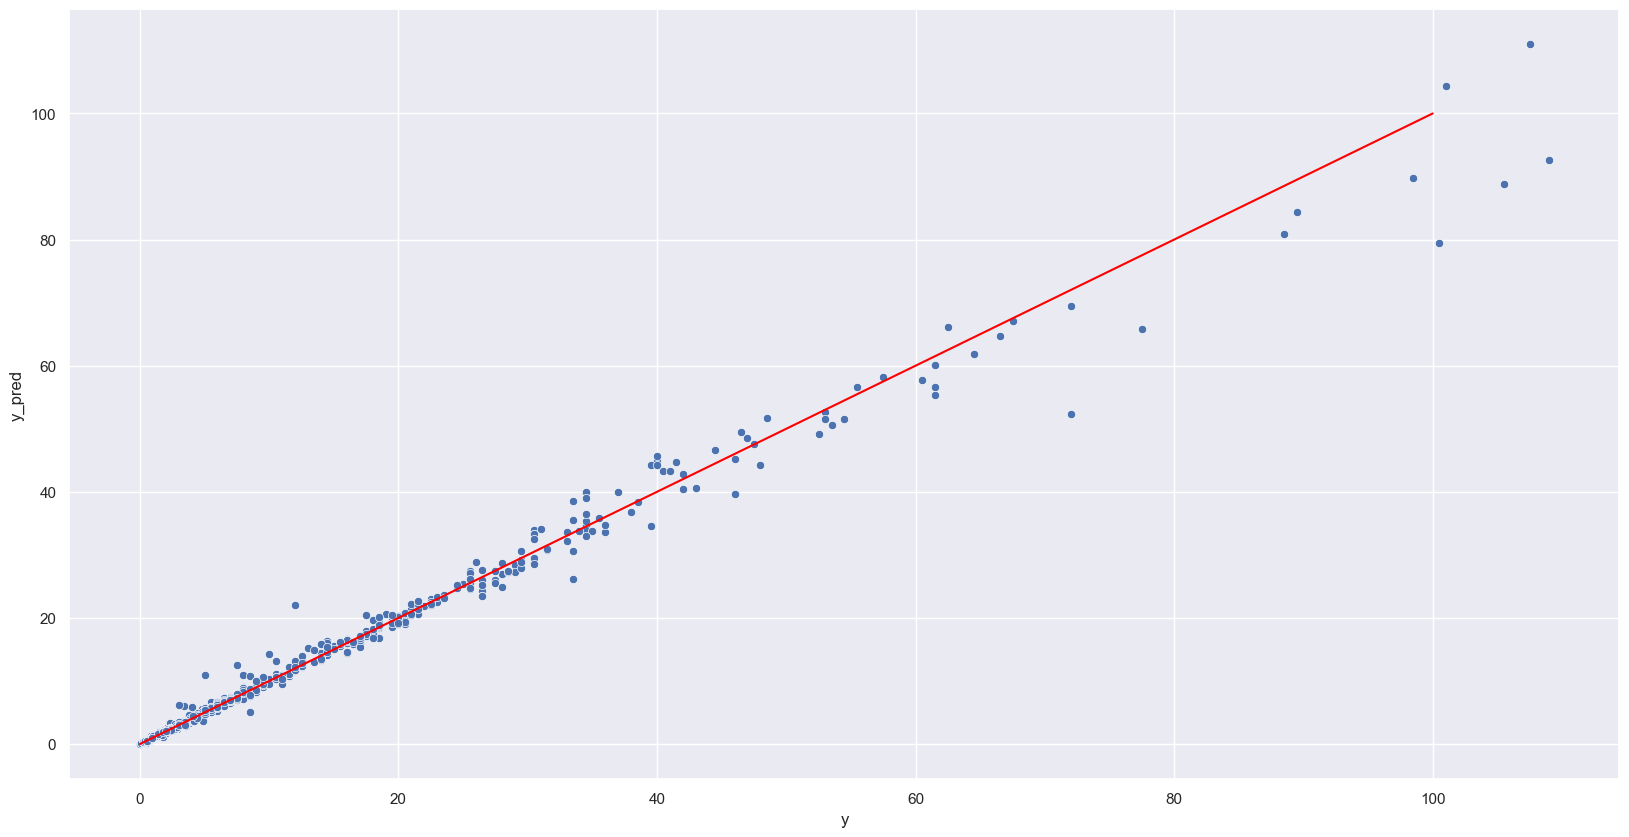

In [613]:
sns.scatterplot(data=df_evaluacion, x='y', y='y_pred')
plt.plot([0, 100], [0, 100], color='red')
plt.show()

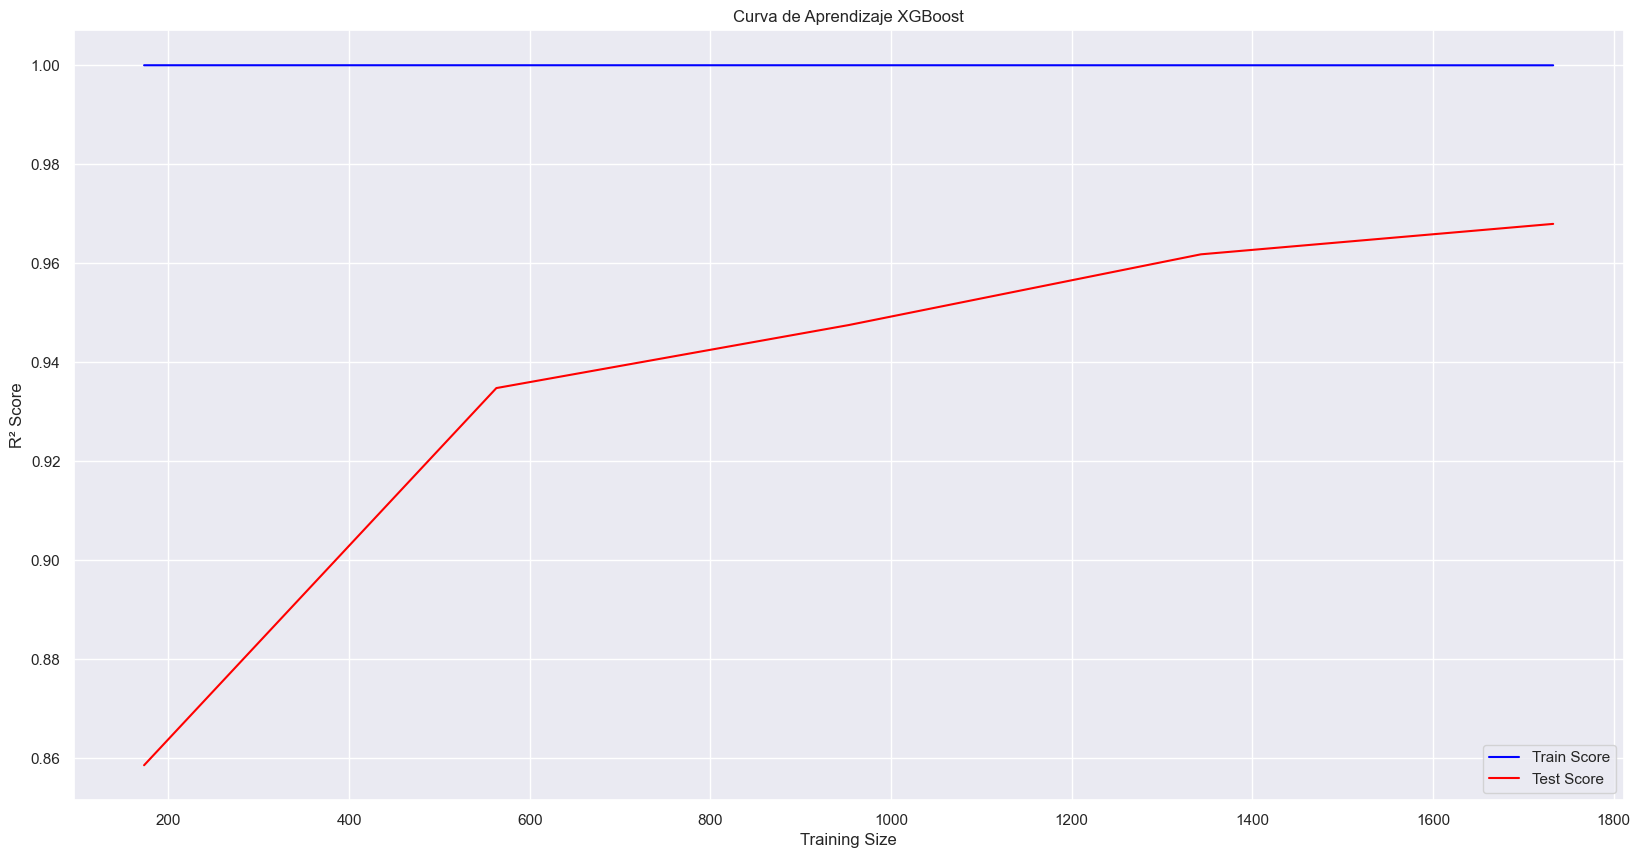

In [614]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X_train, y_train, cv=5, scoring='r2')
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train Score", color="blue")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test Score", color="red")
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Curva de Aprendizaje XGBoost")
plt.show()

Realizamos una búsqueda de hiperparámetos con GridSearch para ajustar y poder optimizar el modelo

In [615]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search_xgb.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search_xgb.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\metal\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


In [616]:
best_model_xgb = grid_search_xgb.best_estimator_

In [617]:
y_train_pred_xgb = best_model_xgb.predict(X_train)

In [618]:
train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)

y_test_pred_xgb = best_model_xgb.predict(X_test)

test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"Entrenamiento - MSE: {train_mse_xgb}, R²: {train_r2_xgb}")
print(f"Prueba - MSE: {test_mse_xgb}, R²: {test_r2_xgb}")

Entrenamiento - MSE: 0.00023154184434346508, R²: 0.9999990408728787
Prueba - MSE: 3.142757254190165, R²: 0.9860158936909339


Parece algo sobreentrenado, asi que vamos a buscar afinar más los hiperparámetros. Con el fin de facilitar la correción, vamos a dejar como comentado el código utilizado, que tarda 20 minutos en ejecutar y ya en el siguiente paso poner los mejores parámetros encontrados en este paso.

In [619]:
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5],
# }

# grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
# grid_search_xgb.fit(X_train, y_train)

# print(f"Mejores parámetros: {grid_search_xgb.best_params_}")


In [620]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.9],
    'reg_alpha': [0.5],
    'reg_lambda': [0],
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search_xgb.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search_xgb.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores parámetros: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 0, 'subsample': 0.8}


In [621]:
best_model_xgb = grid_search_xgb.best_estimator_

In [622]:
y_train_pred = best_model_xgb.predict(X_train)
y_test_pred = best_model_xgb.predict(X_test)

In [623]:
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Entrenamiento - MSE: {mse_train}, R²: {r2_train}")
print(f"Prueba - MSE: {mse_test}, R²: {r2_test}")

Entrenamiento - MSE: 0.37181568241397095, R²: 0.9984598096894913
Prueba - MSE: 2.3844926598044727, R²: 0.989389890420765


In [624]:
import joblib

joblib.dump(xgb_model, 'market_value_xgb.pkl')

['market_value_xgb.pkl']

Hemos conseguido un modelo bueno para la predicción del valor de mercado con XGBoost y algo mejor al Random Forest en cuanto al RMSE y al MSE. Mejor en cuanto a error en la predicción más bajo, aunque es cierto que es más propenso al sobreajuste que el Random Forest, ya que hay mayores diferencias entre los datos en train y en test

Hemos conseguido errores relativamente bajos, aunque con algo de diferencia entre train y test, pero mejorando bastante los resultados anteriores. Ahora el modelo tiene una mejor capacidad para generalizar bien y a nuevos datos, por ejemplo. Ahora el error medio en la predicción serían 1.69 millones de euros (en valores entre 0.1 y 180 millones), aunque sigue habiendo esos outliers y valores de mercado más alto que sesgan un poco el modelo y generan más error promedio. El porcentaje de acierto es bastante bueno tanto en entrnamiento como con prueba.

Aplicaciones prácticas:
Creemos que este modelo tiene un gran valor para hacer scouting, identificando jugadores prometedores basados en su puntuación y sobre todo en su potencial, cuando quizás su valor de mercado todavía no es muy alto.
También permitirá optimizar inversiones de los equipos en el mercado, ya que buscarán ese maximizar beneficies y bajar costes, buscando jugadores buenos cuando su valor es bajo y venderlos cuando su valor alcanza el pico.

## Modelo de Redes Neuronales (MLP)

In [625]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [626]:
X = df_skills.drop(columns=['value_million_euro', 'wage_million_euro'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)
y = df_skills['value_million_euro']

In [627]:
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df_skills['value_million_euro']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [628]:
mlp_model = MLPRegressor(max_iter=500, random_state=42)

Hacemos una búsqueda de hiperparámetros para ajustar el modelo. Con el fin de facilitar la correción, vamos a dejar como comentado el código utilizado, que tarda más de 20 minutos en ejecutar y ya en el siguiente paso poner los mejores parámetros encontrados en este paso.

In [629]:
# param_grid = {
#     'hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'sgd'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'adaptive'],
# }

# grid_search = RandomizedSearchCV(mlp_model, param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_

# best_model.fit(X_train, y_train)

# print(f"Mejores parámetros: {grid_search.best_params_}")

In [630]:
param_grid = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.001],
    'learning_rate': ['constant'],
}

grid_search = RandomizedSearchCV(mlp_model, param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

c:\Users\metal\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MLPRegressor(alpha=0.001, max_iter=500, random_state=42)

In [631]:
y_pred = best_model.predict(X_test)

In [632]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Error absoluto medio (MAE): {mae:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")


Error cuadrático medio (MSE): 103.99
Error absoluto medio (MAE): 6.04
Raíz del error cuadrático medio (RMSE): 10.20
Coeficiente de determinación (R²): 0.58


<function matplotlib.pyplot.show(close=None, block=None)>

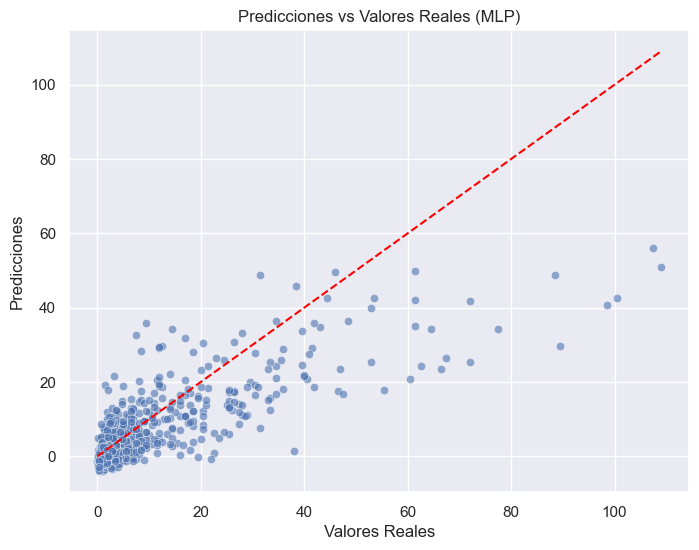

In [633]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Línea perfecta
plt.title('Predicciones vs Valores Reales (MLP)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show

CONCLUSIONES:

El modelo de redes neuronales nos da un error (MSE) muy alto, de 104 millones, por lo que no se ajusta bien a los datos y valores promedios de mercado. El modelo predice con precisión en rangos bajos y muy bajos, y según sube el valor de mercado real predice mal y con desviaciones muy grandes. En la práctica sólo podría ser factible para valores bajos y jugadores poco experimentados, pero no para el resto.